<a href="https://colab.research.google.com/github/alivahidi75/GANS/blob/main/SGAN_Dense_noisy_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale
from random import sample
from tensorflow.keras import layers
from tensorflow.keras import initializers


import numpy as np
import pandas as pd

In [ ]:
from numpy import expand_dims
from tensorflow import keras
import tensorflow as tf
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Lambda
from keras.layers import Activation
from matplotlib import pyplot
from keras import backend
from keras.models import Sequential

In [ ]:
#@title uploading dataset
import pandas as pd
from google.colab import files
uploaded=files.upload()

import io
data=pd.read_excel(io.BytesIO(uploaded['clean_PV_Data1.xlsx']))

Saving clean_PV_Data1.xlsx to clean_PV_Data1.xlsx


In [ ]:

#@title spliting inputs and targets
X = data.drop(['class'],axis=1).values
#X1 = np.random.normal(0,0.05,(3500,7))
#X = X +X1

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
minmax = MinMaxScaler()
X =  minmax.fit_transform(X)
pca = PCA(n_components=7)
pca.fit(X)
X= pca.transform(X)

#X1= df.drop(['class','Voc','Isc','Vmp','Imp','Pmp','T','G',],axis=1).values
Y=data.drop(['Voc','Isc','Vmp','Imp','Pmp','T','G'],axis=1).values.ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=6)
print(X_test.shape)
print(y_test.shape)
print('**********')
print(X_train.shape)
print(y_train.shape)

(350, 7)
(350,)
**********
(3150, 7)
(3150,)


In [ ]:
# custom activation function
def custom_activation(output):
    logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(7,), n_classes=10):
  # image input
  in_image = Input(shape=in_shape)
  # downsample
  fe = Dense(units=180, activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotNormal(),
    bias_initializer=initializers.Zeros())(in_image)
  fe = LeakyReLU(alpha=0.4)(fe)
  # downsample
  fe = Dense(units=140, activation='sigmoid',  kernel_initializer=tf.keras.initializers.GlorotNormal(),
    bias_initializer=initializers.Zeros())(fe)
  fe = LeakyReLU(alpha=0.4)(fe)
  # downsample
  fe = Dense(units=120, activation='sigmoid',  kernel_initializer=tf.keras.initializers.GlorotNormal(),
    bias_initializer=initializers.Zeros())(fe)
  fe = LeakyReLU(alpha=0.4)(fe)
  # dropout
  fe = Dropout(0.4)(fe)
  # output layer nodes
  fe = Dense(n_classes)(fe)
  # supervised output
  c_out_layer = Activation('softmax')(fe)
  # define and compile supervised discriminator model
  c_model = Model(in_image, c_out_layer)
  c_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=Adam(learning_rate= keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.002,decay_steps=10000,decay_rate=0.9),
                                                            beta_1=0.5), metrics=['accuracy'])
  # unsupervised output
  d_out_layer = Lambda(custom_activation)(fe)
  # define and compile unsupervised discriminator model
  d_model = Model(in_image, d_out_layer)
  d_model.compile(loss='binary_crossentropy',
                     optimizer=Adam(learning_rate= keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.002,decay_steps=10000,decay_rate=0.9),
                                                            beta_1=0.5))
  return d_model, c_model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=7):
    model = Sequential()
    model.add(Dense(180, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotNormal(),
    bias_initializer=initializers.Zeros(), input_dim=latent_dim))
    model.add(Dense(100, activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),
    bias_initializer=initializers.Zeros()))
    model.add(Dense(n_outputs, activation='relu'))
    return model
D1 = []
D2 = []
G = []
C = []
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect image output from generator as input to discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and outputting a classification
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load the images
def load_real_samples(X,y):
    print(X.shape, y.shape)
    return [X, y]

# select a supervised subset of the dataset, ensures classes are balanced
'''
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y = dataset
  rand = randint(0,1000)
  n_per_class = int(n_samples / n_classes)
  return X.sample(n=n_per_class,random_state=rand), y.sample(n=n_per_class,random_state=rand)
'''

def select_supervised_samples(dataset, n_samples=100, n_classes=10):
  X, y = X_train, y_train
  X_list, y_list = list(), list()
  n_per_class =int(3.5*int(n_samples / n_classes))
  for i in range(n_classes):
        # get all images for this class
    X_with_class = X[y == i]
    # choose random instances
    ix = randint(0, len(X_with_class), n_per_class)
    # add to list
    [X_list.append(X_with_class[j]) for j in ix]
    [y_list.append(i) for j in ix]
  return asarray(X_list), asarray(y_list)


# select real samples

'''
def generate_real_samples(dataset, n_samples):
    # split into images and labels
  features, labels = X_train, y_train
    # choose random instances
  rand = randint(0, 1000)
    # select features and labels
  X = features.sample(n=n_samples,random_state=rand)
  labels = labels.sample(n=n_samples,random_state=rand)
    # generate class labels
  y = ones((n_samples, 1))
  return [X, labels], y
'''

    # select real samples
def generate_real_samples(dataset, n_samples):
 # split into images and labels
 images, labels = dataset
 # choose random instances
 ix = randint(0, images.shape[0], n_samples)
 # select images and labels
 X, labels = images[ix], labels[ix]
 # generate class labels
 y = zeros((n_samples, 1))
 return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    z_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = z_input.reshape(n_samples, latent_dim)
    return z_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict(z_input)
    # create class labels
    y = ones((n_samples, 1))
    return images, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, acc_list, n_samples=100):
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    # evaluate the classifier model
    X, y = dataset
    _, acc = c_model.evaluate(X, y, verbose=0)
    acc_list.append(acc)
    print('Classifier Accuracy: %.3f%%' % (acc * 100))
    # save the generator model
    filename2 = 'g_model_%04d.h5' % (step+1)
    g_model.save(filename2)
    # save the classifier model
    filename3 = 'c_model_%04d.h5' % (step+1)
    c_model.save(filename3)
    print('>Saved:  %s and %s' % (filename2, filename3))

# train the generator and discriminator
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, acc_list, n_epochs=2000, n_batch=512):
    # select supervised dataset
    X_sup, y_sup = select_supervised_samples(dataset)
    print(X_sup.shape, y_sup.shape)
    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
    # manually enumerate epochs
    for i in range(n_steps):
        # update supervised discriminator (c)
        [Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
        c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
        # update unsupervised discriminator (d)
        [X_real, _], y_real = generate_real_samples(dataset, half_batch)
        d_loss1 = d_model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        # update generator (g)
        X_gan, y_gan = generate_latent_points(latent_dim, n_batch), ones((n_batch, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        # summarize loss on this batch
        D1.append(d_loss2), D2.append(d_loss1)
        G.append(g_loss), C.append(c_loss)

        print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1,c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
        # evaluate the model performance every so often
        if (i+1) % (10) == 0:
            summarize_performance(i, g_model, c_model, latent_dim, dataset, acc_list)
    #return D1, D2, G, C

In [ ]:
#accuracy list for each epochs
acc_list = []
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples(X_train,y_train)

(3150, 7) (3150,)


In [ ]:
# train model
train(g_model, d_model, c_model, gan_model, dataset, latent_dim, acc_list)

(350, 7) (350,)
n_epochs=2000, n_batch=512, 1/2=256, b/e=6, steps=12000
8/8 [==============================] - 0s 2ms/step
>1, c[2.872,12], d[2.729,0.091], g[0.101]
8/8 [==============================] - 0s 2ms/step
>2, c[2.531,10], d[2.293,0.132], g[0.142]
8/8 [==============================] - 0s 2ms/step
>3, c[2.506,11], d[2.029,0.174], g[0.186]
8/8 [==============================] - 0s 2ms/step
>4, c[2.398,11], d[1.789,0.223], g[0.234]
8/8 [==============================] - 0s 2ms/step
>5, c[2.434,9], d[1.586,0.271], g[0.289]
8/8 [==============================] - 0s 2ms/step
>6, c[2.444,11], d[1.412,0.331], g[0.336]
8/8 [==============================] - 0s 2ms/step
>7, c[2.401,15], d[1.292,0.384], g[0.387]
8/8 [==============================] - 0s 2ms/step
>8, c[2.493,9], d[1.182,0.430], g[0.434]
8/8 [==============================] - 0s 2ms/step
>9, c[2.482,11], d[1.090,0.465], g[0.466]
8/8 [==============================] - 0s 2ms/step
>10, c[2.379,11], d[1.030,0.509], g[0.497]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Classifier Accuracy: 10.063%
>Saved:  g_model_0010.h5 and c_model_0010.h5
8/8 [==============================] - 0s 2ms/step
>11, c[2.477,10], d[0.969,0.532], g[0.527]
8/8 [==============================] - 0s 2ms/step
>12, c[2.475,9], d[0.956,0.571], g[0.543]
8/8 [==============================] - 0s 2ms/step
>13, c[2.434,12], d[0.907,0.570], g[0.553]
8/8 [==============================] - 0s 2ms/step
>14, c[2.436,8], d[0.910,0.570], g[0.562]
8/8 [==============================] - 0s 2ms/step
>15, c[2.431,9], d[0.910,0.584], g[0.565]
8/8 [==============================] - 0s 2ms/step
>16, c[2.471,8], d[0.880,0.599], g[0.567]
8/8 [==============================] - 0s 2ms/step
>17, c[2.413,10], d[0.872,0.600], g[0.591]
8/8 [==============================] - 0s 2ms/step
>18, c[2.425,7], d[0.853,0.599], g[0.585]
8/8 [==============================] - 0s 2ms/step
>19, c[2.434,11], d[0.867,0.617], g[0.577]
8/8 [==============================] - 0s 2ms/step
>20, c[2.467,10], d[0.851,0.605], 

Classifier Accuracy: 10.063%
>Saved:  g_model_0020.h5 and c_model_0020.h5
8/8 [==============================] - 0s 2ms/step
>21, c[2.450,9], d[0.845,0.618], g[0.597]
8/8 [==============================] - 0s 2ms/step
>22, c[2.466,11], d[0.852,0.613], g[0.588]
8/8 [==============================] - 0s 2ms/step
>23, c[2.424,13], d[0.847,0.614], g[0.589]
8/8 [==============================] - 0s 2ms/step
>24, c[2.487,8], d[0.859,0.620], g[0.588]
8/8 [==============================] - 0s 2ms/step
>25, c[2.432,7], d[0.851,0.604], g[0.576]
8/8 [==============================] - 0s 2ms/step
>26, c[2.344,12], d[0.850,0.604], g[0.579]
8/8 [==============================] - 0s 2ms/step
>27, c[2.406,9], d[0.852,0.618], g[0.579]
8/8 [==============================] - 0s 1ms/step
>28, c[2.396,8], d[0.851,0.600], g[0.580]
8/8 [==============================] - 0s 2ms/step
>29, c[2.409,13], d[0.857,0.630], g[0.581]
8/8 [==============================] - 0s 2ms/step
>30, c[2.390,11], d[0.862,0.609], 

Classifier Accuracy: 9.968%
>Saved:  g_model_0030.h5 and c_model_0030.h5
8/8 [==============================] - 0s 2ms/step
>31, c[2.408,7], d[0.867,0.601], g[0.565]
8/8 [==============================] - 0s 2ms/step
>32, c[2.386,9], d[0.852,0.604], g[0.580]
8/8 [==============================] - 0s 2ms/step
>33, c[2.409,9], d[0.847,0.611], g[0.580]
8/8 [==============================] - 0s 2ms/step
>34, c[2.402,11], d[0.860,0.595], g[0.567]
8/8 [==============================] - 0s 2ms/step
>35, c[2.362,10], d[0.842,0.604], g[0.582]
8/8 [==============================] - 0s 2ms/step
>36, c[2.406,7], d[0.845,0.600], g[0.575]
8/8 [==============================] - 0s 2ms/step
>37, c[2.352,11], d[0.814,0.600], g[0.565]
8/8 [==============================] - 0s 2ms/step
>38, c[2.405,10], d[0.819,0.596], g[0.562]
8/8 [==============================] - 0s 2ms/step
>39, c[2.408,9], d[0.845,0.604], g[0.574]
8/8 [==============================] - 0s 2ms/step
>40, c[2.376,9], d[0.825,0.606], g[

Classifier Accuracy: 10.032%
>Saved:  g_model_0040.h5 and c_model_0040.h5
8/8 [==============================] - 0s 2ms/step
>41, c[2.409,6], d[0.837,0.598], g[0.559]
8/8 [==============================] - 0s 1ms/step
>42, c[2.341,14], d[0.835,0.589], g[0.561]
8/8 [==============================] - 0s 2ms/step
>43, c[2.363,7], d[0.817,0.577], g[0.556]
8/8 [==============================] - 0s 2ms/step
>44, c[2.403,7], d[0.829,0.567], g[0.554]
8/8 [==============================] - 0s 2ms/step
>45, c[2.325,16], d[0.825,0.585], g[0.554]
8/8 [==============================] - 0s 2ms/step
>46, c[2.363,12], d[0.808,0.575], g[0.549]
8/8 [==============================] - 0s 2ms/step
>47, c[2.382,8], d[0.787,0.587], g[0.543]
8/8 [==============================] - 0s 2ms/step
>48, c[2.360,13], d[0.767,0.559], g[0.535]
8/8 [==============================] - 0s 2ms/step
>49, c[2.360,9], d[0.786,0.559], g[0.529]
8/8 [==============================] - 0s 2ms/step
>50, c[2.385,12], d[0.764,0.561], 

Classifier Accuracy: 11.302%
>Saved:  g_model_0050.h5 and c_model_0050.h5
8/8 [==============================] - 0s 2ms/step
>51, c[2.349,9], d[0.746,0.546], g[0.515]
8/8 [==============================] - 0s 2ms/step
>52, c[2.402,11], d[0.746,0.525], g[0.493]
8/8 [==============================] - 0s 2ms/step
>53, c[2.376,11], d[0.726,0.507], g[0.480]
8/8 [==============================] - 0s 2ms/step
>54, c[2.361,9], d[0.704,0.503], g[0.461]
8/8 [==============================] - 0s 2ms/step
>55, c[2.377,9], d[0.700,0.472], g[0.423]
8/8 [==============================] - 0s 2ms/step
>56, c[2.383,8], d[0.693,0.435], g[0.409]
8/8 [==============================] - 0s 2ms/step
>57, c[2.369,13], d[0.676,0.416], g[0.392]
8/8 [==============================] - 0s 2ms/step
>58, c[2.364,8], d[0.629,0.395], g[0.362]
8/8 [==============================] - 0s 2ms/step
>59, c[2.424,10], d[0.606,0.349], g[0.318]
8/8 [==============================] - 0s 2ms/step
>60, c[2.329,16], d[0.589,0.313], 

Classifier Accuracy: 20.286%
>Saved:  g_model_0060.h5 and c_model_0060.h5
8/8 [==============================] - 0s 2ms/step
>61, c[2.353,14], d[0.555,0.296], g[0.257]
8/8 [==============================] - 0s 2ms/step
>62, c[2.383,11], d[0.488,0.259], g[0.229]
8/8 [==============================] - 0s 2ms/step
>63, c[2.346,13], d[0.477,0.216], g[0.180]
8/8 [==============================] - 0s 2ms/step
>64, c[2.426,11], d[0.424,0.175], g[0.155]
8/8 [==============================] - 0s 2ms/step
>65, c[2.334,14], d[0.416,0.146], g[0.132]
8/8 [==============================] - 0s 2ms/step
>66, c[2.388,14], d[0.394,0.130], g[0.106]
8/8 [==============================] - 0s 2ms/step
>67, c[2.335,15], d[0.341,0.110], g[0.086]
8/8 [==============================] - 0s 2ms/step
>68, c[2.357,14], d[0.335,0.083], g[0.083]
8/8 [==============================] - 0s 2ms/step
>69, c[2.357,16], d[0.314,0.065], g[0.070]
8/8 [==============================] - 0s 2ms/step
>70, c[2.270,16], d[0.292,0.0

Classifier Accuracy: 19.175%
>Saved:  g_model_0070.h5 and c_model_0070.h5
8/8 [==============================] - 0s 2ms/step
>71, c[2.299,16], d[0.289,0.047], g[0.055]
8/8 [==============================] - 0s 3ms/step
>72, c[2.327,16], d[0.278,0.047], g[0.044]
8/8 [==============================] - 0s 3ms/step
>73, c[2.313,18], d[0.300,0.036], g[0.047]
8/8 [==============================] - 0s 2ms/step
>74, c[2.317,12], d[0.242,0.031], g[0.048]
8/8 [==============================] - 0s 2ms/step
>75, c[2.289,20], d[0.245,0.033], g[0.035]
8/8 [==============================] - 0s 2ms/step
>76, c[2.241,21], d[0.206,0.028], g[0.027]
8/8 [==============================] - 0s 2ms/step
>77, c[2.283,16], d[0.208,0.025], g[0.026]
8/8 [==============================] - 0s 2ms/step
>78, c[2.254,23], d[0.206,0.020], g[0.021]
8/8 [==============================] - 0s 3ms/step
>79, c[2.292,16], d[0.223,0.024], g[0.024]
8/8 [==============================] - 0s 2ms/step
>80, c[2.213,23], d[0.176,0.0

Classifier Accuracy: 19.778%
>Saved:  g_model_0080.h5 and c_model_0080.h5
8/8 [==============================] - 0s 2ms/step
>81, c[2.241,21], d[0.184,0.022], g[0.019]
8/8 [==============================] - 0s 2ms/step
>82, c[2.226,20], d[0.192,0.016], g[0.019]
8/8 [==============================] - 0s 2ms/step
>83, c[2.213,20], d[0.151,0.018], g[0.016]
8/8 [==============================] - 0s 2ms/step
>84, c[2.195,18], d[0.192,0.015], g[0.022]
8/8 [==============================] - 0s 2ms/step
>85, c[2.339,16], d[0.154,0.020], g[0.023]
8/8 [==============================] - 0s 2ms/step
>86, c[2.255,20], d[0.167,0.019], g[0.019]
8/8 [==============================] - 0s 2ms/step
>87, c[2.260,18], d[0.176,0.015], g[0.014]
8/8 [==============================] - 0s 2ms/step
>88, c[2.118,27], d[0.242,0.014], g[0.019]
8/8 [==============================] - 0s 2ms/step
>89, c[2.256,20], d[0.151,0.013], g[0.017]
8/8 [==============================] - 0s 2ms/step
>90, c[2.305,15], d[0.135,0.0

Classifier Accuracy: 27.968%
>Saved:  g_model_0090.h5 and c_model_0090.h5
8/8 [==============================] - 0s 2ms/step
>91, c[2.248,19], d[0.113,0.012], g[0.016]
8/8 [==============================] - 0s 2ms/step
>92, c[2.228,16], d[0.118,0.014], g[0.013]
8/8 [==============================] - 0s 2ms/step
>93, c[2.179,22], d[0.115,0.011], g[0.014]
8/8 [==============================] - 0s 2ms/step
>94, c[2.173,16], d[0.112,0.012], g[0.014]
8/8 [==============================] - 0s 2ms/step
>95, c[2.042,25], d[0.154,0.013], g[0.016]
8/8 [==============================] - 0s 2ms/step
>96, c[2.156,21], d[0.116,0.014], g[0.013]
8/8 [==============================] - 0s 2ms/step
>97, c[2.161,18], d[0.126,0.012], g[0.012]
8/8 [==============================] - 0s 2ms/step
>98, c[2.190,20], d[0.111,0.010], g[0.011]
8/8 [==============================] - 0s 2ms/step
>99, c[2.138,18], d[0.111,0.014], g[0.015]
8/8 [==============================] - 0s 2ms/step
>100, c[2.188,21], d[0.089,0.

Classifier Accuracy: 29.238%
>Saved:  g_model_0100.h5 and c_model_0100.h5
8/8 [==============================] - 0s 2ms/step
>101, c[2.086,24], d[0.122,0.007], g[0.011]
8/8 [==============================] - 0s 2ms/step
>102, c[2.107,25], d[0.134,0.011], g[0.010]
8/8 [==============================] - 0s 2ms/step
>103, c[2.205,22], d[0.109,0.008], g[0.013]
8/8 [==============================] - 0s 2ms/step
>104, c[2.108,26], d[0.137,0.011], g[0.010]
8/8 [==============================] - 0s 2ms/step
>105, c[2.196,20], d[0.102,0.007], g[0.010]
8/8 [==============================] - 0s 2ms/step
>106, c[2.126,23], d[0.105,0.009], g[0.012]
8/8 [==============================] - 0s 2ms/step
>107, c[2.166,20], d[0.117,0.008], g[0.014]
8/8 [==============================] - 0s 2ms/step
>108, c[2.128,21], d[0.092,0.007], g[0.009]
8/8 [==============================] - 0s 2ms/step
>109, c[2.133,21], d[0.090,0.007], g[0.009]
8/8 [==============================] - 0s 2ms/step
>110, c[2.113,20], d

Classifier Accuracy: 30.032%
>Saved:  g_model_0110.h5 and c_model_0110.h5
8/8 [==============================] - 0s 2ms/step
>111, c[2.065,25], d[0.083,0.006], g[0.008]
8/8 [==============================] - 0s 2ms/step
>112, c[2.187,19], d[0.063,0.006], g[0.009]
8/8 [==============================] - 0s 2ms/step
>113, c[2.095,24], d[0.091,0.007], g[0.010]
8/8 [==============================] - 0s 2ms/step
>114, c[2.055,23], d[0.093,0.006], g[0.009]
8/8 [==============================] - 0s 2ms/step
>115, c[2.146,20], d[0.070,0.009], g[0.008]
8/8 [==============================] - 0s 2ms/step
>116, c[2.045,27], d[0.121,0.010], g[0.009]
8/8 [==============================] - 0s 2ms/step
>117, c[2.059,24], d[0.090,0.006], g[0.009]
8/8 [==============================] - 0s 2ms/step
>118, c[2.130,20], d[0.070,0.012], g[0.010]
8/8 [==============================] - 0s 2ms/step
>119, c[2.071,23], d[0.071,0.007], g[0.007]
8/8 [==============================] - 0s 2ms/step
>120, c[2.028,26], d

Classifier Accuracy: 21.556%
>Saved:  g_model_0120.h5 and c_model_0120.h5
8/8 [==============================] - 0s 2ms/step
>121, c[2.072,21], d[0.070,0.007], g[0.006]
8/8 [==============================] - 0s 2ms/step
>122, c[2.044,26], d[0.073,0.004], g[0.006]
8/8 [==============================] - 0s 2ms/step
>123, c[2.153,16], d[0.068,0.005], g[0.011]
8/8 [==============================] - 0s 2ms/step
>124, c[2.113,16], d[0.068,0.005], g[0.006]
8/8 [==============================] - 0s 2ms/step
>125, c[2.077,24], d[0.088,0.006], g[0.006]
8/8 [==============================] - 0s 2ms/step
>126, c[2.153,16], d[0.066,0.007], g[0.007]
8/8 [==============================] - 0s 2ms/step
>127, c[2.139,16], d[0.055,0.008], g[0.007]
8/8 [==============================] - 0s 2ms/step
>128, c[2.003,27], d[0.054,0.006], g[0.012]
8/8 [==============================] - 0s 2ms/step
>129, c[1.990,25], d[0.060,0.005], g[0.007]
8/8 [==============================] - 0s 2ms/step
>130, c[2.077,22], d

Classifier Accuracy: 27.714%
>Saved:  g_model_0130.h5 and c_model_0130.h5
8/8 [==============================] - 0s 2ms/step
>131, c[2.063,21], d[0.047,0.012], g[0.008]
8/8 [==============================] - 0s 2ms/step
>132, c[2.019,25], d[0.055,0.004], g[0.005]
8/8 [==============================] - 0s 2ms/step
>133, c[2.022,24], d[0.089,0.008], g[0.009]
8/8 [==============================] - 0s 2ms/step
>134, c[1.999,27], d[0.050,0.003], g[0.006]
8/8 [==============================] - 0s 2ms/step
>135, c[2.069,22], d[0.074,0.006], g[0.007]
8/8 [==============================] - 0s 2ms/step
>136, c[2.103,23], d[0.072,0.005], g[0.010]
8/8 [==============================] - 0s 2ms/step
>137, c[2.080,25], d[0.050,0.006], g[0.005]
8/8 [==============================] - 0s 2ms/step
>138, c[2.058,22], d[0.051,0.005], g[0.011]
8/8 [==============================] - 0s 2ms/step
>139, c[2.070,23], d[0.062,0.006], g[0.008]
8/8 [==============================] - 0s 2ms/step
>140, c[2.007,25], d

Classifier Accuracy: 29.524%
>Saved:  g_model_0140.h5 and c_model_0140.h5
8/8 [==============================] - 0s 2ms/step
>141, c[2.027,27], d[0.052,0.011], g[0.005]
8/8 [==============================] - 0s 2ms/step
>142, c[2.057,22], d[0.040,0.007], g[0.008]
8/8 [==============================] - 0s 2ms/step
>143, c[1.991,21], d[0.058,0.004], g[0.005]
8/8 [==============================] - 0s 2ms/step
>144, c[2.009,26], d[0.064,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>145, c[1.924,31], d[0.060,0.004], g[0.004]
8/8 [==============================] - 0s 2ms/step
>146, c[1.985,30], d[0.070,0.004], g[0.013]
8/8 [==============================] - 0s 2ms/step
>147, c[2.092,23], d[0.056,0.004], g[0.008]
8/8 [==============================] - 0s 3ms/step
>148, c[2.045,18], d[0.036,0.006], g[0.007]
8/8 [==============================] - 0s 2ms/step
>149, c[2.035,26], d[0.045,0.005], g[0.005]
8/8 [==============================] - 0s 3ms/step
>150, c[2.058,23], d

Classifier Accuracy: 34.063%
>Saved:  g_model_0150.h5 and c_model_0150.h5
8/8 [==============================] - 0s 2ms/step
>151, c[1.965,26], d[0.042,0.004], g[0.005]
8/8 [==============================] - 0s 2ms/step
>152, c[2.023,23], d[0.045,0.005], g[0.006]
8/8 [==============================] - 0s 2ms/step
>153, c[2.025,20], d[0.045,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>154, c[2.018,25], d[0.054,0.004], g[0.004]
8/8 [==============================] - 0s 2ms/step
>155, c[2.010,21], d[0.050,0.006], g[0.004]
8/8 [==============================] - 0s 2ms/step
>156, c[2.012,21], d[0.043,0.005], g[0.005]
8/8 [==============================] - 0s 2ms/step
>157, c[2.004,25], d[0.085,0.005], g[0.004]
8/8 [==============================] - 0s 2ms/step
>158, c[1.980,25], d[0.062,0.008], g[0.006]
8/8 [==============================] - 0s 2ms/step
>159, c[1.883,32], d[0.063,0.004], g[0.008]
8/8 [==============================] - 0s 1ms/step
>160, c[1.948,26], d

Classifier Accuracy: 38.317%
>Saved:  g_model_0160.h5 and c_model_0160.h5
8/8 [==============================] - 0s 2ms/step
>161, c[1.985,28], d[0.040,0.008], g[0.012]
8/8 [==============================] - 0s 2ms/step
>162, c[1.971,24], d[0.049,0.006], g[0.013]
8/8 [==============================] - 0s 2ms/step
>163, c[1.942,28], d[0.048,0.004], g[0.006]
8/8 [==============================] - 0s 2ms/step
>164, c[1.858,31], d[0.044,0.005], g[0.005]
8/8 [==============================] - 0s 2ms/step
>165, c[1.897,31], d[0.047,0.004], g[0.006]
8/8 [==============================] - 0s 2ms/step
>166, c[1.901,29], d[0.054,0.005], g[0.009]
8/8 [==============================] - 0s 2ms/step
>167, c[1.935,25], d[0.041,0.015], g[0.004]
8/8 [==============================] - 0s 2ms/step
>168, c[1.947,29], d[0.036,0.005], g[0.005]
8/8 [==============================] - 0s 2ms/step
>169, c[1.909,28], d[0.045,0.004], g[0.009]
8/8 [==============================] - 0s 2ms/step
>170, c[1.834,29], d

Classifier Accuracy: 31.397%
>Saved:  g_model_0170.h5 and c_model_0170.h5
8/8 [==============================] - 0s 2ms/step
>171, c[1.901,30], d[0.030,0.009], g[0.004]
8/8 [==============================] - 0s 2ms/step
>172, c[1.938,28], d[0.033,0.006], g[0.007]
8/8 [==============================] - 0s 2ms/step
>173, c[1.888,27], d[0.043,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>174, c[1.867,30], d[0.047,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>175, c[1.919,25], d[0.054,0.004], g[0.006]
8/8 [==============================] - 0s 2ms/step
>176, c[1.887,28], d[0.047,0.004], g[0.008]
8/8 [==============================] - 0s 2ms/step
>177, c[1.875,31], d[0.048,0.005], g[0.007]
8/8 [==============================] - 0s 2ms/step
>178, c[1.897,29], d[0.026,0.010], g[0.007]
8/8 [==============================] - 0s 2ms/step
>179, c[1.944,24], d[0.028,0.007], g[0.015]
8/8 [==============================] - 0s 2ms/step
>180, c[1.945,24], d

Classifier Accuracy: 38.571%
>Saved:  g_model_0180.h5 and c_model_0180.h5
8/8 [==============================] - 0s 2ms/step
>181, c[1.848,29], d[0.068,0.004], g[0.004]
8/8 [==============================] - 0s 2ms/step
>182, c[1.868,29], d[0.048,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>183, c[1.850,29], d[0.034,0.004], g[0.004]
8/8 [==============================] - 0s 2ms/step
>184, c[1.908,24], d[0.061,0.005], g[0.007]
8/8 [==============================] - 0s 2ms/step
>185, c[1.880,29], d[0.037,0.005], g[0.005]
8/8 [==============================] - 0s 2ms/step
>186, c[1.899,25], d[0.036,0.003], g[0.010]
8/8 [==============================] - 0s 2ms/step
>187, c[1.874,27], d[0.042,0.018], g[0.004]
8/8 [==============================] - 0s 2ms/step
>188, c[1.873,25], d[0.055,0.005], g[0.007]
8/8 [==============================] - 0s 2ms/step
>189, c[1.886,27], d[0.043,0.005], g[0.006]
8/8 [==============================] - 0s 2ms/step
>190, c[1.742,34], d

Classifier Accuracy: 51.524%
>Saved:  g_model_0190.h5 and c_model_0190.h5
8/8 [==============================] - 0s 2ms/step
>191, c[1.885,28], d[0.035,0.004], g[0.007]
8/8 [==============================] - 0s 2ms/step
>192, c[1.867,26], d[0.032,0.007], g[0.005]
8/8 [==============================] - 0s 2ms/step
>193, c[1.885,29], d[0.049,0.006], g[0.011]
8/8 [==============================] - 0s 2ms/step
>194, c[1.887,29], d[0.047,0.018], g[0.009]
8/8 [==============================] - 0s 2ms/step
>195, c[1.831,29], d[0.037,0.005], g[0.007]
8/8 [==============================] - 0s 2ms/step
>196, c[1.818,29], d[0.035,0.003], g[0.013]
8/8 [==============================] - 0s 2ms/step
>197, c[1.828,31], d[0.029,0.005], g[0.015]
8/8 [==============================] - 0s 2ms/step
>198, c[1.796,33], d[0.030,0.004], g[0.005]
8/8 [==============================] - 0s 2ms/step
>199, c[1.858,29], d[0.045,0.005], g[0.005]
8/8 [==============================] - 0s 2ms/step
>200, c[1.803,29], d

Classifier Accuracy: 40.222%
>Saved:  g_model_0200.h5 and c_model_0200.h5
8/8 [==============================] - 0s 2ms/step
>201, c[1.711,34], d[0.043,0.003], g[0.007]
8/8 [==============================] - 0s 2ms/step
>202, c[1.814,28], d[0.052,0.007], g[0.003]
8/8 [==============================] - 0s 2ms/step
>203, c[1.831,29], d[0.037,0.003], g[0.005]
8/8 [==============================] - 0s 2ms/step
>204, c[1.826,27], d[0.043,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>205, c[1.812,29], d[0.033,0.004], g[0.006]
8/8 [==============================] - 0s 2ms/step
>206, c[1.777,30], d[0.021,0.005], g[0.003]
8/8 [==============================] - 0s 2ms/step
>207, c[1.793,30], d[0.016,0.005], g[0.003]
8/8 [==============================] - 0s 2ms/step
>208, c[1.753,33], d[0.032,0.003], g[0.009]
8/8 [==============================] - 0s 2ms/step
>209, c[1.724,35], d[0.046,0.004], g[0.010]
8/8 [==============================] - 0s 2ms/step
>210, c[1.721,37], d

Classifier Accuracy: 35.016%
>Saved:  g_model_0210.h5 and c_model_0210.h5
8/8 [==============================] - 0s 2ms/step
>211, c[1.736,36], d[0.033,0.004], g[0.003]
8/8 [==============================] - 0s 2ms/step
>212, c[1.826,26], d[0.037,0.008], g[0.005]
8/8 [==============================] - 0s 2ms/step
>213, c[1.767,35], d[0.047,0.012], g[0.006]
8/8 [==============================] - 0s 1ms/step
>214, c[1.791,30], d[0.020,0.006], g[0.004]
8/8 [==============================] - 0s 2ms/step
>215, c[1.757,33], d[0.038,0.006], g[0.003]
8/8 [==============================] - 0s 3ms/step
>216, c[1.716,34], d[0.032,0.003], g[0.005]
8/8 [==============================] - 0s 2ms/step
>217, c[1.738,34], d[0.038,0.003], g[0.005]
8/8 [==============================] - 0s 3ms/step
>218, c[1.699,34], d[0.040,0.004], g[0.007]
8/8 [==============================] - 0s 3ms/step
>219, c[1.721,36], d[0.027,0.002], g[0.007]
8/8 [==============================] - 0s 2ms/step
>220, c[1.708,34], d

Classifier Accuracy: 44.222%
>Saved:  g_model_0220.h5 and c_model_0220.h5
8/8 [==============================] - 0s 2ms/step
>221, c[1.689,34], d[0.025,0.012], g[0.003]
8/8 [==============================] - 0s 3ms/step
>222, c[1.728,30], d[0.029,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>223, c[1.667,35], d[0.044,0.003], g[0.006]
8/8 [==============================] - 0s 3ms/step
>224, c[1.689,33], d[0.055,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>225, c[1.721,29], d[0.028,0.005], g[0.003]
8/8 [==============================] - 0s 3ms/step
>226, c[1.665,36], d[0.029,0.009], g[0.004]
8/8 [==============================] - 0s 2ms/step
>227, c[1.757,32], d[0.017,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>228, c[1.727,34], d[0.040,0.003], g[0.006]
8/8 [==============================] - 0s 2ms/step
>229, c[1.684,34], d[0.033,0.002], g[0.007]
8/8 [==============================] - 0s 2ms/step
>230, c[1.667,31], d

Classifier Accuracy: 41.016%
>Saved:  g_model_0230.h5 and c_model_0230.h5
8/8 [==============================] - 0s 2ms/step
>231, c[1.753,30], d[0.025,0.009], g[0.003]
8/8 [==============================] - 0s 2ms/step
>232, c[1.689,36], d[0.025,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>233, c[1.704,34], d[0.041,0.002], g[0.005]
8/8 [==============================] - 0s 2ms/step
>234, c[1.725,33], d[0.027,0.005], g[0.004]
8/8 [==============================] - 0s 2ms/step
>235, c[1.749,30], d[0.035,0.004], g[0.003]
8/8 [==============================] - 0s 2ms/step
>236, c[1.675,34], d[0.044,0.003], g[0.003]
8/8 [==============================] - 0s 2ms/step
>237, c[1.648,37], d[0.027,0.003], g[0.005]
8/8 [==============================] - 0s 2ms/step
>238, c[1.750,29], d[0.019,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>239, c[1.687,33], d[0.015,0.003], g[0.006]
8/8 [==============================] - 0s 2ms/step
>240, c[1.625,36], d

Classifier Accuracy: 47.683%
>Saved:  g_model_0240.h5 and c_model_0240.h5
8/8 [==============================] - 0s 2ms/step
>241, c[1.653,34], d[0.022,0.007], g[0.003]
8/8 [==============================] - 0s 2ms/step
>242, c[1.637,37], d[0.017,0.011], g[0.004]
8/8 [==============================] - 0s 2ms/step
>243, c[1.679,37], d[0.021,0.005], g[0.002]
8/8 [==============================] - 0s 2ms/step
>244, c[1.605,38], d[0.026,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>245, c[1.678,34], d[0.033,0.003], g[0.003]
8/8 [==============================] - 0s 2ms/step
>246, c[1.631,36], d[0.018,0.002], g[0.005]
8/8 [==============================] - 0s 2ms/step
>247, c[1.670,31], d[0.046,0.009], g[0.004]
8/8 [==============================] - 0s 2ms/step
>248, c[1.689,31], d[0.014,0.005], g[0.003]
8/8 [==============================] - 0s 2ms/step
>249, c[1.735,27], d[0.037,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>250, c[1.633,35], d

Classifier Accuracy: 47.460%
>Saved:  g_model_0250.h5 and c_model_0250.h5
8/8 [==============================] - 0s 2ms/step
>251, c[1.617,37], d[0.026,0.002], g[0.006]
8/8 [==============================] - 0s 2ms/step
>252, c[1.580,38], d[0.032,0.003], g[0.003]
8/8 [==============================] - 0s 2ms/step
>253, c[1.599,38], d[0.022,0.009], g[0.003]
8/8 [==============================] - 0s 2ms/step
>254, c[1.602,38], d[0.030,0.003], g[0.005]
8/8 [==============================] - 0s 2ms/step
>255, c[1.616,36], d[0.027,0.002], g[0.004]
8/8 [==============================] - 0s 2ms/step
>256, c[1.670,33], d[0.029,0.008], g[0.006]
8/8 [==============================] - 0s 2ms/step
>257, c[1.636,36], d[0.015,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>258, c[1.645,35], d[0.031,0.009], g[0.003]
8/8 [==============================] - 0s 2ms/step
>259, c[1.564,41], d[0.020,0.002], g[0.004]
8/8 [==============================] - 0s 2ms/step
>260, c[1.559,38], d

Classifier Accuracy: 38.603%
>Saved:  g_model_0260.h5 and c_model_0260.h5
8/8 [==============================] - 0s 2ms/step
>261, c[1.603,37], d[0.027,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>262, c[1.543,39], d[0.013,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>263, c[1.608,34], d[0.043,0.002], g[0.007]
8/8 [==============================] - 0s 2ms/step
>264, c[1.573,38], d[0.037,0.007], g[0.003]
8/8 [==============================] - 0s 2ms/step
>265, c[1.547,40], d[0.023,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>266, c[1.598,36], d[0.029,0.002], g[0.004]
8/8 [==============================] - 0s 2ms/step
>267, c[1.535,41], d[0.020,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>268, c[1.611,32], d[0.022,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>269, c[1.539,38], d[0.035,0.002], g[0.004]
8/8 [==============================] - 0s 2ms/step
>270, c[1.604,37], d

Classifier Accuracy: 40.889%
>Saved:  g_model_0270.h5 and c_model_0270.h5
8/8 [==============================] - 0s 2ms/step
>271, c[1.532,38], d[0.027,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>272, c[1.654,32], d[0.015,0.003], g[0.006]
8/8 [==============================] - 0s 2ms/step
>273, c[1.687,29], d[0.033,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>274, c[1.506,43], d[0.031,0.003], g[0.004]
8/8 [==============================] - 0s 2ms/step
>275, c[1.584,37], d[0.023,0.002], g[0.009]
8/8 [==============================] - 0s 2ms/step
>276, c[1.588,38], d[0.019,0.004], g[0.005]
8/8 [==============================] - 0s 2ms/step
>277, c[1.533,41], d[0.021,0.003], g[0.005]
8/8 [==============================] - 0s 2ms/step
>278, c[1.596,37], d[0.035,0.003], g[0.003]
8/8 [==============================] - 0s 2ms/step
>279, c[1.582,39], d[0.032,0.006], g[0.006]
8/8 [==============================] - 0s 2ms/step
>280, c[1.578,42], d

Classifier Accuracy: 45.365%
>Saved:  g_model_0280.h5 and c_model_0280.h5
8/8 [==============================] - 0s 2ms/step
>281, c[1.519,41], d[0.032,0.015], g[0.002]
8/8 [==============================] - 0s 2ms/step
>282, c[1.553,36], d[0.047,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>283, c[1.530,42], d[0.028,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>284, c[1.599,35], d[0.015,0.014], g[0.002]
8/8 [==============================] - 0s 2ms/step
>285, c[1.504,43], d[0.020,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>286, c[1.574,36], d[0.032,0.004], g[0.002]
8/8 [==============================] - 0s 2ms/step
>287, c[1.566,38], d[0.020,0.003], g[0.006]
8/8 [==============================] - 0s 2ms/step
>288, c[1.565,39], d[0.018,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>289, c[1.490,42], d[0.019,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>290, c[1.545,38], d

Classifier Accuracy: 38.952%
>Saved:  g_model_0290.h5 and c_model_0290.h5
8/8 [==============================] - 0s 2ms/step
>291, c[1.597,34], d[0.031,0.001], g[0.004]
8/8 [==============================] - 0s 3ms/step
>292, c[1.538,40], d[0.013,0.010], g[0.002]
8/8 [==============================] - 0s 3ms/step
>293, c[1.552,41], d[0.029,0.002], g[0.002]
8/8 [==============================] - 0s 3ms/step
>294, c[1.595,36], d[0.050,0.001], g[0.004]
8/8 [==============================] - 0s 3ms/step
>295, c[1.568,39], d[0.021,0.002], g[0.005]
8/8 [==============================] - 0s 3ms/step
>296, c[1.573,35], d[0.024,0.004], g[0.007]
8/8 [==============================] - 0s 3ms/step
>297, c[1.547,40], d[0.022,0.003], g[0.003]
8/8 [==============================] - 0s 3ms/step
>298, c[1.574,34], d[0.021,0.002], g[0.003]
8/8 [==============================] - 0s 3ms/step
>299, c[1.506,41], d[0.025,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>300, c[1.483,39], d

Classifier Accuracy: 43.079%
>Saved:  g_model_0300.h5 and c_model_0300.h5
8/8 [==============================] - 0s 2ms/step
>301, c[1.469,41], d[0.017,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>302, c[1.600,36], d[0.018,0.003], g[0.006]
8/8 [==============================] - 0s 2ms/step
>303, c[1.478,39], d[0.021,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>304, c[1.517,37], d[0.019,0.002], g[0.002]
8/8 [==============================] - 0s 2ms/step
>305, c[1.599,33], d[0.013,0.007], g[0.001]
8/8 [==============================] - 0s 2ms/step
>306, c[1.583,35], d[0.030,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>307, c[1.580,37], d[0.010,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>308, c[1.497,41], d[0.014,0.001], g[0.006]
8/8 [==============================] - 0s 2ms/step
>309, c[1.499,40], d[0.025,0.002], g[0.004]
8/8 [==============================] - 0s 2ms/step
>310, c[1.453,40], d

Classifier Accuracy: 47.333%
>Saved:  g_model_0310.h5 and c_model_0310.h5
8/8 [==============================] - 0s 2ms/step
>311, c[1.539,38], d[0.016,0.006], g[0.004]
8/8 [==============================] - 0s 2ms/step
>312, c[1.522,38], d[0.016,0.010], g[0.003]
8/8 [==============================] - 0s 2ms/step
>313, c[1.510,41], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>314, c[1.461,44], d[0.028,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>315, c[1.527,36], d[0.019,0.006], g[0.002]
8/8 [==============================] - 0s 2ms/step
>316, c[1.518,36], d[0.017,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>317, c[1.517,39], d[0.021,0.001], g[0.011]
8/8 [==============================] - 0s 2ms/step
>318, c[1.503,38], d[0.025,0.001], g[0.010]
8/8 [==============================] - 0s 2ms/step
>319, c[1.554,38], d[0.010,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>320, c[1.467,41], d

Classifier Accuracy: 46.889%
>Saved:  g_model_0320.h5 and c_model_0320.h5
8/8 [==============================] - 0s 2ms/step
>321, c[1.506,38], d[0.033,0.007], g[0.003]
8/8 [==============================] - 0s 2ms/step
>322, c[1.408,48], d[0.028,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>323, c[1.544,38], d[0.018,0.006], g[0.001]
8/8 [==============================] - 0s 2ms/step
>324, c[1.499,43], d[0.011,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>325, c[1.538,38], d[0.014,0.005], g[0.002]
8/8 [==============================] - 0s 2ms/step
>326, c[1.490,37], d[0.027,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>327, c[1.475,41], d[0.020,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>328, c[1.583,34], d[0.022,0.003], g[0.001]
8/8 [==============================] - 0s 2ms/step
>329, c[1.579,32], d[0.018,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>330, c[1.447,41], d

Classifier Accuracy: 47.937%
>Saved:  g_model_0330.h5 and c_model_0330.h5
8/8 [==============================] - 0s 2ms/step
>331, c[1.475,41], d[0.009,0.002], g[0.008]
8/8 [==============================] - 0s 2ms/step
>332, c[1.526,39], d[0.028,0.001], g[0.004]
8/8 [==============================] - 0s 2ms/step
>333, c[1.444,44], d[0.019,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>334, c[1.483,41], d[0.015,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>335, c[1.585,33], d[0.017,0.001], g[0.008]
8/8 [==============================] - 0s 2ms/step
>336, c[1.409,48], d[0.015,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>337, c[1.480,38], d[0.016,0.001], g[0.004]
8/8 [==============================] - 0s 2ms/step
>338, c[1.477,43], d[0.013,0.005], g[0.002]
8/8 [==============================] - 0s 2ms/step
>339, c[1.502,39], d[0.014,0.004], g[0.005]
8/8 [==============================] - 0s 2ms/step
>340, c[1.445,45], d

Classifier Accuracy: 47.016%
>Saved:  g_model_0340.h5 and c_model_0340.h5
8/8 [==============================] - 0s 2ms/step
>341, c[1.445,40], d[0.021,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>342, c[1.426,40], d[0.017,0.001], g[0.011]
8/8 [==============================] - 0s 2ms/step
>343, c[1.473,45], d[0.018,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>344, c[1.416,43], d[0.010,0.006], g[0.002]
8/8 [==============================] - 0s 2ms/step
>345, c[1.411,47], d[0.019,0.013], g[0.011]
8/8 [==============================] - 0s 2ms/step
>346, c[1.492,38], d[0.020,0.002], g[0.006]
8/8 [==============================] - 0s 2ms/step
>347, c[1.506,40], d[0.021,0.011], g[0.001]
8/8 [==============================] - 0s 2ms/step
>348, c[1.486,38], d[0.022,0.002], g[0.007]
8/8 [==============================] - 0s 2ms/step
>349, c[1.465,41], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>350, c[1.465,39], d

Classifier Accuracy: 50.349%
>Saved:  g_model_0350.h5 and c_model_0350.h5
8/8 [==============================] - 0s 2ms/step
>351, c[1.394,43], d[0.019,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>352, c[1.502,39], d[0.009,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>353, c[1.475,40], d[0.032,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>354, c[1.473,37], d[0.014,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>355, c[1.483,39], d[0.019,0.001], g[0.020]
8/8 [==============================] - 0s 2ms/step
>356, c[1.470,41], d[0.013,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>357, c[1.448,43], d[0.009,0.003], g[0.002]
8/8 [==============================] - 0s 2ms/step
>358, c[1.490,39], d[0.015,0.001], g[0.008]
8/8 [==============================] - 0s 2ms/step
>359, c[1.444,38], d[0.021,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>360, c[1.438,39], d

Classifier Accuracy: 53.619%
>Saved:  g_model_0360.h5 and c_model_0360.h5
8/8 [==============================] - 0s 2ms/step
>361, c[1.414,40], d[0.017,0.002], g[0.005]
8/8 [==============================] - 0s 3ms/step
>362, c[1.413,45], d[0.018,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>363, c[1.363,46], d[0.021,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>364, c[1.444,42], d[0.017,0.001], g[0.004]
8/8 [==============================] - 0s 3ms/step
>365, c[1.440,43], d[0.024,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>366, c[1.431,41], d[0.010,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>367, c[1.416,47], d[0.008,0.004], g[0.001]
8/8 [==============================] - 0s 2ms/step
>368, c[1.353,46], d[0.016,0.009], g[0.001]
8/8 [==============================] - 0s 3ms/step
>369, c[1.399,43], d[0.014,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>370, c[1.467,39], d

Classifier Accuracy: 45.492%
>Saved:  g_model_0370.h5 and c_model_0370.h5
8/8 [==============================] - 0s 2ms/step
>371, c[1.451,39], d[0.022,0.006], g[0.001]
8/8 [==============================] - 0s 3ms/step
>372, c[1.431,40], d[0.008,0.008], g[0.001]
8/8 [==============================] - 0s 2ms/step
>373, c[1.418,40], d[0.010,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>374, c[1.425,42], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>375, c[1.431,38], d[0.009,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>376, c[1.430,40], d[0.019,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>377, c[1.387,47], d[0.026,0.004], g[0.002]
8/8 [==============================] - 0s 2ms/step
>378, c[1.393,45], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>379, c[1.432,45], d[0.007,0.001], g[0.005]
8/8 [==============================] - 0s 2ms/step
>380, c[1.418,42], d

Classifier Accuracy: 45.016%
>Saved:  g_model_0380.h5 and c_model_0380.h5
8/8 [==============================] - 0s 2ms/step
>381, c[1.451,43], d[0.009,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>382, c[1.420,41], d[0.009,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>383, c[1.332,48], d[0.014,0.001], g[0.013]
8/8 [==============================] - 0s 3ms/step
>384, c[1.437,34], d[0.018,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>385, c[1.426,39], d[0.008,0.001], g[0.009]
8/8 [==============================] - 0s 2ms/step
>386, c[1.411,43], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>387, c[1.467,39], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>388, c[1.418,40], d[0.014,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>389, c[1.361,48], d[0.014,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>390, c[1.431,42], d

Classifier Accuracy: 50.571%
>Saved:  g_model_0390.h5 and c_model_0390.h5
8/8 [==============================] - 0s 2ms/step
>391, c[1.376,43], d[0.012,0.001], g[0.006]
8/8 [==============================] - 0s 2ms/step
>392, c[1.425,41], d[0.013,0.029], g[0.014]
8/8 [==============================] - 0s 2ms/step
>393, c[1.416,38], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>394, c[1.371,44], d[0.010,0.006], g[0.008]
8/8 [==============================] - 0s 2ms/step
>395, c[1.413,45], d[0.015,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>396, c[1.325,45], d[0.011,0.001], g[0.009]
8/8 [==============================] - 0s 2ms/step
>397, c[1.346,49], d[0.011,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>398, c[1.381,41], d[0.026,0.026], g[0.001]
8/8 [==============================] - 0s 2ms/step
>399, c[1.403,38], d[0.013,0.017], g[0.003]
8/8 [==============================] - 0s 2ms/step
>400, c[1.343,48], d

Classifier Accuracy: 40.857%
>Saved:  g_model_0400.h5 and c_model_0400.h5
8/8 [==============================] - 0s 2ms/step
>401, c[1.436,36], d[0.006,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>402, c[1.278,50], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>403, c[1.420,36], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>404, c[1.344,43], d[0.012,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>405, c[1.406,39], d[0.010,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>406, c[1.360,46], d[0.013,0.009], g[0.001]
8/8 [==============================] - 0s 2ms/step
>407, c[1.325,45], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>408, c[1.359,41], d[0.022,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>409, c[1.333,49], d[0.012,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>410, c[1.350,45], d

Classifier Accuracy: 48.794%
>Saved:  g_model_0410.h5 and c_model_0410.h5
8/8 [==============================] - 0s 2ms/step
>411, c[1.398,43], d[0.016,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>412, c[1.419,45], d[0.009,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>413, c[1.447,37], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>414, c[1.420,40], d[0.017,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>415, c[1.393,40], d[0.015,0.010], g[0.001]
8/8 [==============================] - 0s 2ms/step
>416, c[1.323,45], d[0.021,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>417, c[1.348,45], d[0.009,0.002], g[0.004]
8/8 [==============================] - 0s 2ms/step
>418, c[1.296,49], d[0.021,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>419, c[1.325,46], d[0.014,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>420, c[1.342,43], d

Classifier Accuracy: 45.238%
>Saved:  g_model_0420.h5 and c_model_0420.h5
8/8 [==============================] - 0s 2ms/step
>421, c[1.364,42], d[0.013,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>422, c[1.400,45], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>423, c[1.388,45], d[0.014,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>424, c[1.373,44], d[0.005,0.003], g[0.005]
8/8 [==============================] - 0s 2ms/step
>425, c[1.454,37], d[0.010,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>426, c[1.451,37], d[0.016,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>427, c[1.386,42], d[0.006,0.011], g[0.003]
8/8 [==============================] - 0s 2ms/step
>428, c[1.380,40], d[0.012,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>429, c[1.360,46], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>430, c[1.328,45], d

Classifier Accuracy: 50.317%
>Saved:  g_model_0430.h5 and c_model_0430.h5
8/8 [==============================] - 0s 2ms/step
>431, c[1.373,43], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>432, c[1.342,46], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>433, c[1.355,45], d[0.007,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>434, c[1.304,48], d[0.006,0.001], g[0.006]
8/8 [==============================] - 0s 2ms/step
>435, c[1.299,45], d[0.011,0.004], g[0.014]
8/8 [==============================] - 0s 2ms/step
>436, c[1.272,47], d[0.016,0.001], g[0.015]
8/8 [==============================] - 0s 2ms/step
>437, c[1.358,43], d[0.028,0.005], g[0.002]
8/8 [==============================] - 0s 3ms/step
>438, c[1.287,52], d[0.009,0.001], g[0.001]
8/8 [==============================] - 0s 3ms/step
>439, c[1.339,46], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 3ms/step
>440, c[1.340,46], d

Classifier Accuracy: 47.492%
>Saved:  g_model_0440.h5 and c_model_0440.h5
8/8 [==============================] - 0s 2ms/step
>441, c[1.364,48], d[0.015,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>442, c[1.354,45], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>443, c[1.326,44], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>444, c[1.350,46], d[0.016,0.008], g[0.003]
8/8 [==============================] - 0s 2ms/step
>445, c[1.369,46], d[0.014,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>446, c[1.462,36], d[0.007,0.001], g[0.015]
8/8 [==============================] - 0s 2ms/step
>447, c[1.423,38], d[0.007,0.001], g[0.017]
8/8 [==============================] - 0s 2ms/step
>448, c[1.403,41], d[0.019,0.006], g[0.034]
8/8 [==============================] - 0s 2ms/step
>449, c[1.336,43], d[0.007,0.001], g[0.018]
8/8 [==============================] - 0s 2ms/step
>450, c[1.332,46], d

Classifier Accuracy: 39.778%
>Saved:  g_model_0450.h5 and c_model_0450.h5
8/8 [==============================] - 0s 2ms/step
>451, c[1.345,44], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>452, c[1.359,45], d[0.007,0.001], g[0.019]
8/8 [==============================] - 0s 2ms/step
>453, c[1.301,46], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>454, c[1.345,41], d[0.012,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>455, c[1.401,42], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>456, c[1.368,43], d[0.009,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>457, c[1.347,44], d[0.006,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>458, c[1.330,49], d[0.011,0.042], g[0.003]
8/8 [==============================] - 0s 2ms/step
>459, c[1.279,48], d[0.015,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>460, c[1.403,42], d

Classifier Accuracy: 55.968%
>Saved:  g_model_0460.h5 and c_model_0460.h5
8/8 [==============================] - 0s 2ms/step
>461, c[1.346,42], d[0.006,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>462, c[1.329,47], d[0.012,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>463, c[1.298,52], d[0.013,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>464, c[1.370,43], d[0.006,0.003], g[0.001]
8/8 [==============================] - 0s 2ms/step
>465, c[1.381,40], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>466, c[1.432,36], d[0.010,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>467, c[1.350,41], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>468, c[1.338,44], d[0.006,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>469, c[1.250,46], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>470, c[1.262,48], d

Classifier Accuracy: 50.222%
>Saved:  g_model_0470.h5 and c_model_0470.h5
8/8 [==============================] - 0s 2ms/step
>471, c[1.298,48], d[0.006,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>472, c[1.307,42], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>473, c[1.283,47], d[0.006,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>474, c[1.301,46], d[0.010,0.005], g[0.000]
8/8 [==============================] - 0s 2ms/step
>475, c[1.309,43], d[0.008,0.001], g[0.004]
8/8 [==============================] - 0s 2ms/step
>476, c[1.270,49], d[0.007,0.001], g[0.006]
8/8 [==============================] - 0s 2ms/step
>477, c[1.240,49], d[0.006,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>478, c[1.300,46], d[0.011,0.003], g[0.008]
8/8 [==============================] - 0s 2ms/step
>479, c[1.296,45], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>480, c[1.267,50], d

Classifier Accuracy: 55.333%
>Saved:  g_model_0480.h5 and c_model_0480.h5
8/8 [==============================] - 0s 2ms/step
>481, c[1.240,49], d[0.011,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>482, c[1.272,44], d[0.013,0.002], g[0.001]
8/8 [==============================] - 0s 2ms/step
>483, c[1.258,48], d[0.015,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>484, c[1.301,44], d[0.012,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>485, c[1.311,46], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>486, c[1.289,49], d[0.005,0.000], g[0.013]
8/8 [==============================] - 0s 2ms/step
>487, c[1.351,42], d[0.008,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>488, c[1.296,46], d[0.011,0.000], g[0.010]
8/8 [==============================] - 0s 2ms/step
>489, c[1.260,48], d[0.019,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>490, c[1.308,47], d

Classifier Accuracy: 51.492%
>Saved:  g_model_0490.h5 and c_model_0490.h5
8/8 [==============================] - 0s 2ms/step
>491, c[1.405,42], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>492, c[1.352,41], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>493, c[1.288,48], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>494, c[1.311,45], d[0.011,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>495, c[1.313,41], d[0.006,0.001], g[0.003]
8/8 [==============================] - 0s 2ms/step
>496, c[1.238,48], d[0.007,0.000], g[0.036]
8/8 [==============================] - 0s 2ms/step
>497, c[1.339,43], d[0.007,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>498, c[1.323,38], d[0.009,0.027], g[0.000]
8/8 [==============================] - 0s 2ms/step
>499, c[1.316,46], d[0.007,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>500, c[1.273,48], d

Classifier Accuracy: 46.127%
>Saved:  g_model_0500.h5 and c_model_0500.h5
8/8 [==============================] - 0s 2ms/step
>501, c[1.353,44], d[0.014,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>502, c[1.332,45], d[0.008,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>503, c[1.313,47], d[0.010,0.013], g[0.002]
8/8 [==============================] - 0s 3ms/step
>504, c[1.299,43], d[0.023,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>505, c[1.376,42], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>506, c[1.274,44], d[0.009,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>507, c[1.245,48], d[0.009,0.002], g[0.019]
8/8 [==============================] - 0s 3ms/step
>508, c[1.250,48], d[0.007,0.031], g[0.001]
8/8 [==============================] - 0s 2ms/step
>509, c[1.310,48], d[0.010,0.000], g[0.001]
8/8 [==============================] - 0s 8ms/step
>510, c[1.346,46], d

Classifier Accuracy: 49.079%
>Saved:  g_model_0510.h5 and c_model_0510.h5
8/8 [==============================] - 0s 2ms/step
>511, c[1.268,48], d[0.005,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>512, c[1.279,50], d[0.009,0.015], g[0.003]
8/8 [==============================] - 0s 2ms/step
>513, c[1.239,47], d[0.012,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>514, c[1.307,42], d[0.010,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>515, c[1.384,42], d[0.002,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>516, c[1.343,42], d[0.008,0.000], g[0.006]
8/8 [==============================] - 0s 2ms/step
>517, c[1.248,47], d[0.013,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>518, c[1.295,49], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>519, c[1.346,49], d[0.012,0.001], g[0.011]
8/8 [==============================] - 0s 2ms/step
>520, c[1.328,45], d

Classifier Accuracy: 54.794%
>Saved:  g_model_0520.h5 and c_model_0520.h5
8/8 [==============================] - 0s 2ms/step
>521, c[1.257,50], d[0.009,0.015], g[0.008]
8/8 [==============================] - 0s 2ms/step
>522, c[1.321,44], d[0.006,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>523, c[1.283,44], d[0.011,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>524, c[1.285,48], d[0.016,0.022], g[0.000]
8/8 [==============================] - 0s 2ms/step
>525, c[1.283,46], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>526, c[1.226,49], d[0.007,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>527, c[1.277,48], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>528, c[1.290,42], d[0.014,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>529, c[1.337,44], d[0.016,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>530, c[1.260,45], d

Classifier Accuracy: 48.286%
>Saved:  g_model_0530.h5 and c_model_0530.h5
8/8 [==============================] - 0s 2ms/step
>531, c[1.273,45], d[0.003,0.006], g[0.000]
8/8 [==============================] - 0s 2ms/step
>532, c[1.266,50], d[0.006,0.001], g[0.001]
8/8 [==============================] - 0s 2ms/step
>533, c[1.269,44], d[0.017,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>534, c[1.261,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>535, c[1.337,44], d[0.009,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>536, c[1.349,41], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>537, c[1.336,47], d[0.012,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>538, c[1.320,42], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>539, c[1.288,47], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>540, c[1.300,43], d

Classifier Accuracy: 44.159%
>Saved:  g_model_0540.h5 and c_model_0540.h5
8/8 [==============================] - 0s 2ms/step
>541, c[1.309,44], d[0.010,0.000], g[0.006]
8/8 [==============================] - 0s 3ms/step
>542, c[1.323,47], d[0.007,0.000], g[0.019]
8/8 [==============================] - 0s 2ms/step
>543, c[1.273,48], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>544, c[1.269,50], d[0.010,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>545, c[1.293,43], d[0.008,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>546, c[1.376,46], d[0.004,0.001], g[0.002]
8/8 [==============================] - 0s 2ms/step
>547, c[1.185,58], d[0.008,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>548, c[1.257,50], d[0.006,0.028], g[0.000]
8/8 [==============================] - 0s 2ms/step
>549, c[1.287,48], d[0.011,0.001], g[0.010]
8/8 [==============================] - 0s 2ms/step
>550, c[1.290,49], d

Classifier Accuracy: 47.651%
>Saved:  g_model_0550.h5 and c_model_0550.h5
8/8 [==============================] - 0s 2ms/step
>551, c[1.289,44], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>552, c[1.277,46], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>553, c[1.265,44], d[0.008,0.028], g[0.001]
8/8 [==============================] - 0s 2ms/step
>554, c[1.294,44], d[0.009,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>555, c[1.268,43], d[0.006,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>556, c[1.270,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>557, c[1.249,46], d[0.011,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>558, c[1.267,48], d[0.012,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>559, c[1.250,49], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>560, c[1.249,49], d

Classifier Accuracy: 50.762%
>Saved:  g_model_0560.h5 and c_model_0560.h5
8/8 [==============================] - 0s 2ms/step
>561, c[1.268,49], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>562, c[1.293,48], d[0.004,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>563, c[1.291,44], d[0.011,0.005], g[0.002]
8/8 [==============================] - 0s 2ms/step
>564, c[1.304,45], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>565, c[1.237,46], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>566, c[1.213,52], d[0.004,0.013], g[0.000]
8/8 [==============================] - 0s 2ms/step
>567, c[1.219,55], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>568, c[1.292,45], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>569, c[1.237,49], d[0.007,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>570, c[1.169,54], d

Classifier Accuracy: 47.365%
>Saved:  g_model_0570.h5 and c_model_0570.h5
8/8 [==============================] - 0s 2ms/step
>571, c[1.289,45], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>572, c[1.246,43], d[0.009,0.016], g[0.000]
8/8 [==============================] - 0s 2ms/step
>573, c[1.254,48], d[0.007,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>574, c[1.227,48], d[0.008,0.010], g[0.000]
8/8 [==============================] - 0s 2ms/step
>575, c[1.269,49], d[0.010,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>576, c[1.288,42], d[0.003,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>577, c[1.272,50], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>578, c[1.333,38], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>579, c[1.176,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>580, c[1.254,49], d

Classifier Accuracy: 50.032%
>Saved:  g_model_0580.h5 and c_model_0580.h5
8/8 [==============================] - 0s 3ms/step
>581, c[1.295,47], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>582, c[1.200,52], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>583, c[1.282,50], d[0.004,0.009], g[0.000]
8/8 [==============================] - 0s 2ms/step
>584, c[1.235,46], d[0.012,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>585, c[1.213,47], d[0.008,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>586, c[1.321,46], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>587, c[1.248,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>588, c[1.273,46], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>589, c[1.226,49], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>590, c[1.253,51], d

Classifier Accuracy: 53.492%
>Saved:  g_model_0590.h5 and c_model_0590.h5
8/8 [==============================] - 0s 2ms/step
>591, c[1.264,47], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>592, c[1.291,49], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>593, c[1.314,49], d[0.007,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>594, c[1.259,42], d[0.008,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>595, c[1.246,45], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>596, c[1.243,48], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>597, c[1.244,45], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>598, c[1.335,45], d[0.003,0.021], g[0.003]
8/8 [==============================] - 0s 2ms/step
>599, c[1.278,46], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>600, c[1.285,45], d

Classifier Accuracy: 50.000%
>Saved:  g_model_0600.h5 and c_model_0600.h5
8/8 [==============================] - 0s 2ms/step
>601, c[1.201,50], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>602, c[1.274,45], d[0.006,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>603, c[1.223,48], d[0.006,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>604, c[1.194,50], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>605, c[1.256,41], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>606, c[1.270,46], d[0.010,0.000], g[0.010]
8/8 [==============================] - 0s 2ms/step
>607, c[1.233,49], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>608, c[1.299,44], d[0.005,0.001], g[0.008]
8/8 [==============================] - 0s 2ms/step
>609, c[1.216,45], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>610, c[1.251,44], d

Classifier Accuracy: 56.222%
>Saved:  g_model_0610.h5 and c_model_0610.h5
8/8 [==============================] - 0s 2ms/step
>611, c[1.226,48], d[0.008,0.026], g[0.000]
8/8 [==============================] - 0s 2ms/step
>612, c[1.262,47], d[0.019,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>613, c[1.242,49], d[0.007,0.000], g[0.029]
8/8 [==============================] - 0s 2ms/step
>614, c[1.229,52], d[0.007,0.007], g[0.000]
8/8 [==============================] - 0s 2ms/step
>615, c[1.156,55], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>616, c[1.218,54], d[0.004,0.002], g[0.000]
8/8 [==============================] - 0s 3ms/step
>617, c[1.230,46], d[0.008,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>618, c[1.274,45], d[0.005,0.000], g[0.006]
8/8 [==============================] - 0s 2ms/step
>619, c[1.301,47], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>620, c[1.260,47], d

Classifier Accuracy: 55.587%
>Saved:  g_model_0620.h5 and c_model_0620.h5
8/8 [==============================] - 0s 2ms/step
>621, c[1.262,47], d[0.004,0.001], g[0.018]
8/8 [==============================] - 0s 2ms/step
>622, c[1.224,45], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>623, c[1.205,51], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>624, c[1.265,45], d[0.014,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>625, c[1.240,43], d[0.003,0.000], g[0.031]
8/8 [==============================] - 0s 2ms/step
>626, c[1.389,39], d[0.009,0.001], g[0.005]
8/8 [==============================] - 0s 2ms/step
>627, c[1.310,45], d[0.009,0.031], g[0.004]
8/8 [==============================] - 0s 2ms/step
>628, c[1.224,48], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>629, c[1.248,49], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>630, c[1.274,43], d

Classifier Accuracy: 53.302%
>Saved:  g_model_0630.h5 and c_model_0630.h5
8/8 [==============================] - 0s 2ms/step
>631, c[1.294,44], d[0.006,0.001], g[0.028]
8/8 [==============================] - 0s 2ms/step
>632, c[1.209,47], d[0.011,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>633, c[1.269,44], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>634, c[1.346,44], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>635, c[1.314,41], d[0.006,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>636, c[1.319,42], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>637, c[1.192,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>638, c[1.206,46], d[0.007,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>639, c[1.223,49], d[0.006,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>640, c[1.245,45], d

Classifier Accuracy: 47.111%
>Saved:  g_model_0640.h5 and c_model_0640.h5
8/8 [==============================] - 0s 2ms/step
>641, c[1.199,49], d[0.010,0.024], g[0.035]
8/8 [==============================] - 0s 2ms/step
>642, c[1.224,43], d[0.003,0.033], g[0.000]
8/8 [==============================] - 0s 2ms/step
>643, c[1.227,50], d[0.004,0.036], g[0.002]
8/8 [==============================] - 0s 2ms/step
>644, c[1.296,45], d[0.010,0.033], g[0.000]
8/8 [==============================] - 0s 4ms/step
>645, c[1.364,41], d[0.010,0.002], g[0.003]
8/8 [==============================] - 0s 2ms/step
>646, c[1.192,53], d[0.007,0.000], g[0.034]
8/8 [==============================] - 0s 2ms/step
>647, c[1.327,43], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>648, c[1.271,47], d[0.006,0.024], g[0.011]
8/8 [==============================] - 0s 2ms/step
>649, c[1.237,50], d[0.005,0.000], g[0.015]
8/8 [==============================] - 0s 3ms/step
>650, c[1.275,53], d

Classifier Accuracy: 44.730%
>Saved:  g_model_0650.h5 and c_model_0650.h5
8/8 [==============================] - 0s 3ms/step
>651, c[1.337,37], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>652, c[1.159,54], d[0.008,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>653, c[1.231,48], d[0.007,0.003], g[0.001]
8/8 [==============================] - 0s 2ms/step
>654, c[1.164,49], d[0.005,0.000], g[0.021]
8/8 [==============================] - 0s 2ms/step
>655, c[1.208,46], d[0.021,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>656, c[1.228,48], d[0.008,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>657, c[1.303,46], d[0.004,0.027], g[0.018]
8/8 [==============================] - 0s 2ms/step
>658, c[1.222,47], d[0.008,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>659, c[1.209,48], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>660, c[1.173,49], d

Classifier Accuracy: 51.968%
>Saved:  g_model_0660.h5 and c_model_0660.h5
8/8 [==============================] - 0s 2ms/step
>661, c[1.173,55], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>662, c[1.236,48], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>663, c[1.234,51], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>664, c[1.214,52], d[0.006,0.019], g[0.000]
8/8 [==============================] - 0s 2ms/step
>665, c[1.238,51], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>666, c[1.204,53], d[0.007,0.024], g[0.001]
8/8 [==============================] - 0s 2ms/step
>667, c[1.230,46], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>668, c[1.232,52], d[0.004,0.019], g[0.000]
8/8 [==============================] - 0s 2ms/step
>669, c[1.248,46], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>670, c[1.173,50], d

Classifier Accuracy: 53.810%
>Saved:  g_model_0670.h5 and c_model_0670.h5
8/8 [==============================] - 0s 2ms/step
>671, c[1.274,46], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>672, c[1.251,46], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>673, c[1.214,49], d[0.006,0.024], g[0.003]
8/8 [==============================] - 0s 2ms/step
>674, c[1.232,44], d[0.004,0.006], g[0.011]
8/8 [==============================] - 0s 2ms/step
>675, c[1.212,50], d[0.003,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>676, c[1.240,47], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>677, c[1.181,52], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>678, c[1.173,48], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>679, c[1.175,51], d[0.008,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>680, c[1.262,46], d

Classifier Accuracy: 53.492%
>Saved:  g_model_0680.h5 and c_model_0680.h5
8/8 [==============================] - 0s 2ms/step
>681, c[1.261,48], d[0.006,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>682, c[1.193,50], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>683, c[1.329,40], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>684, c[1.198,48], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>685, c[1.225,46], d[0.003,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>686, c[1.118,55], d[0.007,0.000], g[0.020]
8/8 [==============================] - 0s 2ms/step
>687, c[1.172,49], d[0.005,0.018], g[0.001]
8/8 [==============================] - 0s 2ms/step
>688, c[1.200,45], d[0.008,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>689, c[1.178,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>690, c[1.172,54], d

Classifier Accuracy: 52.984%
>Saved:  g_model_0690.h5 and c_model_0690.h5
8/8 [==============================] - 0s 2ms/step
>691, c[1.167,51], d[0.007,0.034], g[0.000]
8/8 [==============================] - 0s 2ms/step
>692, c[1.242,49], d[0.017,0.001], g[0.021]
8/8 [==============================] - 0s 2ms/step
>693, c[1.227,51], d[0.005,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>694, c[1.167,52], d[0.004,0.029], g[0.016]
8/8 [==============================] - 0s 2ms/step
>695, c[1.261,46], d[0.011,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>696, c[1.150,52], d[0.003,0.003], g[0.001]
8/8 [==============================] - 0s 2ms/step
>697, c[1.184,55], d[0.007,0.027], g[0.001]
8/8 [==============================] - 0s 2ms/step
>698, c[1.198,50], d[0.004,0.019], g[0.000]
8/8 [==============================] - 0s 2ms/step
>699, c[1.248,50], d[0.002,0.012], g[0.000]
8/8 [==============================] - 0s 2ms/step
>700, c[1.507,38], d

Classifier Accuracy: 44.381%
>Saved:  g_model_0700.h5 and c_model_0700.h5
8/8 [==============================] - 0s 2ms/step
>701, c[1.408,36], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>702, c[1.209,54], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>703, c[1.202,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>704, c[1.217,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>705, c[1.243,48], d[0.012,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>706, c[1.184,52], d[0.004,0.000], g[0.013]
8/8 [==============================] - 0s 2ms/step
>707, c[1.201,46], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>708, c[1.175,52], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>709, c[1.197,50], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>710, c[1.167,55], d

Classifier Accuracy: 52.444%
>Saved:  g_model_0710.h5 and c_model_0710.h5
8/8 [==============================] - 0s 2ms/step
>711, c[1.184,50], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>712, c[1.192,53], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>713, c[1.183,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>714, c[1.140,52], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>715, c[1.155,55], d[0.007,0.010], g[0.016]
8/8 [==============================] - 0s 3ms/step
>716, c[1.194,54], d[0.003,0.000], g[0.012]
8/8 [==============================] - 0s 2ms/step
>717, c[1.199,49], d[0.007,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>718, c[1.221,48], d[0.006,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>719, c[1.173,52], d[0.009,0.000], g[0.031]
8/8 [==============================] - 0s 3ms/step
>720, c[1.244,49], d

Classifier Accuracy: 57.460%
>Saved:  g_model_0720.h5 and c_model_0720.h5
8/8 [==============================] - 0s 3ms/step
>721, c[1.220,48], d[0.010,0.008], g[0.000]
8/8 [==============================] - 0s 3ms/step
>722, c[1.192,47], d[0.016,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>723, c[1.098,56], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>724, c[1.218,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>725, c[1.219,43], d[0.011,0.000], g[0.002]
8/8 [==============================] - 0s 3ms/step
>726, c[1.274,48], d[0.004,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>727, c[1.220,46], d[0.009,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>728, c[1.222,51], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>729, c[1.187,48], d[0.003,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>730, c[1.196,48], d

Classifier Accuracy: 51.460%
>Saved:  g_model_0730.h5 and c_model_0730.h5
8/8 [==============================] - 0s 2ms/step
>731, c[1.212,49], d[0.007,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>732, c[1.179,54], d[0.006,0.000], g[0.040]
8/8 [==============================] - 0s 2ms/step
>733, c[1.231,47], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>734, c[1.173,48], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>735, c[1.197,45], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>736, c[1.193,46], d[0.003,0.001], g[0.009]
8/8 [==============================] - 0s 2ms/step
>737, c[1.290,46], d[0.007,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>738, c[1.217,48], d[0.005,0.000], g[0.018]
8/8 [==============================] - 0s 2ms/step
>739, c[1.209,50], d[0.003,0.000], g[0.006]
8/8 [==============================] - 0s 2ms/step
>740, c[1.218,50], d

Classifier Accuracy: 52.857%
>Saved:  g_model_0740.h5 and c_model_0740.h5
8/8 [==============================] - 0s 2ms/step
>741, c[1.223,46], d[0.003,0.009], g[0.001]
8/8 [==============================] - 0s 2ms/step
>742, c[1.146,50], d[0.004,0.050], g[0.007]
8/8 [==============================] - 0s 2ms/step
>743, c[1.222,42], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>744, c[1.209,47], d[0.005,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>745, c[1.212,45], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>746, c[1.124,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>747, c[1.157,53], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>748, c[1.194,46], d[0.006,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>749, c[1.168,53], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>750, c[1.174,49], d

Classifier Accuracy: 57.079%
>Saved:  g_model_0750.h5 and c_model_0750.h5
8/8 [==============================] - 0s 2ms/step
>751, c[1.153,48], d[0.003,0.026], g[0.000]
8/8 [==============================] - 0s 2ms/step
>752, c[1.134,51], d[0.005,0.007], g[0.000]
8/8 [==============================] - 0s 2ms/step
>753, c[1.396,37], d[0.007,0.023], g[0.000]
8/8 [==============================] - 0s 2ms/step
>754, c[1.165,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>755, c[1.255,41], d[0.009,0.000], g[0.019]
8/8 [==============================] - 0s 2ms/step
>756, c[1.185,49], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>757, c[1.117,59], d[0.008,0.006], g[0.000]
8/8 [==============================] - 0s 2ms/step
>758, c[1.201,51], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>759, c[1.145,48], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>760, c[1.219,46], d

Classifier Accuracy: 51.587%
>Saved:  g_model_0760.h5 and c_model_0760.h5
8/8 [==============================] - 0s 2ms/step
>761, c[1.196,49], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>762, c[1.229,43], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>763, c[1.232,53], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>764, c[1.189,52], d[0.004,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>765, c[1.147,55], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>766, c[1.135,49], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>767, c[1.094,52], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>768, c[1.200,55], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>769, c[1.203,48], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>770, c[1.168,52], d

Classifier Accuracy: 60.476%
>Saved:  g_model_0770.h5 and c_model_0770.h5
8/8 [==============================] - 0s 2ms/step
>771, c[1.143,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>772, c[1.207,45], d[0.002,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>773, c[1.152,52], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>774, c[1.106,60], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>775, c[1.185,50], d[0.005,0.039], g[0.000]
8/8 [==============================] - 0s 2ms/step
>776, c[1.190,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>777, c[1.161,44], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>778, c[1.196,49], d[0.005,0.000], g[0.007]
8/8 [==============================] - 0s 2ms/step
>779, c[1.213,47], d[0.005,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>780, c[1.186,52], d

Classifier Accuracy: 48.603%
>Saved:  g_model_0780.h5 and c_model_0780.h5
8/8 [==============================] - 0s 2ms/step
>781, c[1.232,45], d[0.006,0.016], g[0.008]
8/8 [==============================] - 0s 2ms/step
>782, c[1.163,55], d[0.012,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>783, c[1.160,49], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>784, c[1.180,51], d[0.003,0.000], g[0.013]
8/8 [==============================] - 0s 2ms/step
>785, c[1.150,56], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>786, c[1.188,53], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>787, c[1.179,49], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>788, c[1.165,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>789, c[1.184,48], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>790, c[1.179,50], d

Classifier Accuracy: 56.159%
>Saved:  g_model_0790.h5 and c_model_0790.h5
8/8 [==============================] - 0s 2ms/step
>791, c[1.247,46], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>792, c[1.174,46], d[0.003,0.002], g[0.000]
8/8 [==============================] - 0s 3ms/step
>793, c[1.230,47], d[0.003,0.000], g[0.004]
8/8 [==============================] - 0s 3ms/step
>794, c[1.182,49], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>795, c[1.196,53], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>796, c[1.113,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>797, c[1.117,54], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>798, c[1.196,50], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>799, c[1.143,48], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>800, c[1.180,57], d

Classifier Accuracy: 48.698%
>Saved:  g_model_0800.h5 and c_model_0800.h5
8/8 [==============================] - 0s 2ms/step
>801, c[1.160,51], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>802, c[1.179,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>803, c[1.209,47], d[0.004,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>804, c[1.172,45], d[0.005,0.018], g[0.027]
8/8 [==============================] - 0s 2ms/step
>805, c[1.183,45], d[0.004,0.000], g[0.023]
8/8 [==============================] - 0s 2ms/step
>806, c[1.185,53], d[0.002,0.001], g[0.004]
8/8 [==============================] - 0s 2ms/step
>807, c[1.211,49], d[0.004,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>808, c[1.199,49], d[0.004,0.005], g[0.001]
8/8 [==============================] - 0s 2ms/step
>809, c[1.120,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>810, c[1.159,53], d

Classifier Accuracy: 53.556%
>Saved:  g_model_0810.h5 and c_model_0810.h5
8/8 [==============================] - 0s 2ms/step
>811, c[1.113,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>812, c[1.175,50], d[0.011,0.016], g[0.000]
8/8 [==============================] - 0s 2ms/step
>813, c[1.143,50], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>814, c[1.178,51], d[0.003,0.019], g[0.000]
8/8 [==============================] - 0s 2ms/step
>815, c[1.104,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>816, c[1.152,50], d[0.009,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>817, c[1.142,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>818, c[1.151,53], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>819, c[1.109,52], d[0.006,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>820, c[1.184,47], d

Classifier Accuracy: 59.175%
>Saved:  g_model_0820.h5 and c_model_0820.h5
8/8 [==============================] - 0s 2ms/step
>821, c[1.204,53], d[0.006,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>822, c[1.124,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>823, c[1.163,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>824, c[1.141,47], d[0.002,0.000], g[0.018]
8/8 [==============================] - 0s 2ms/step
>825, c[1.101,50], d[0.006,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>826, c[1.181,50], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>827, c[1.146,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>828, c[1.211,51], d[0.003,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>829, c[1.169,52], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>830, c[1.148,47], d

Classifier Accuracy: 55.365%
>Saved:  g_model_0830.h5 and c_model_0830.h5
8/8 [==============================] - 0s 2ms/step
>831, c[1.085,57], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>832, c[1.173,49], d[0.002,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>833, c[1.197,48], d[0.003,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>834, c[1.125,50], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>835, c[1.146,48], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>836, c[1.176,49], d[0.003,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>837, c[1.120,57], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>838, c[1.123,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>839, c[1.183,50], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>840, c[1.112,54], d

Classifier Accuracy: 54.476%
>Saved:  g_model_0840.h5 and c_model_0840.h5
8/8 [==============================] - 0s 2ms/step
>841, c[1.136,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>842, c[1.171,50], d[0.002,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>843, c[1.178,51], d[0.006,0.006], g[0.003]
8/8 [==============================] - 0s 2ms/step
>844, c[1.158,54], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>845, c[1.147,50], d[0.002,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>846, c[1.085,55], d[0.004,0.020], g[0.000]
8/8 [==============================] - 0s 2ms/step
>847, c[1.224,53], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>848, c[1.253,38], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>849, c[1.213,48], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>850, c[1.124,51], d

Classifier Accuracy: 49.397%
>Saved:  g_model_0850.h5 and c_model_0850.h5
8/8 [==============================] - 0s 2ms/step
>851, c[1.219,46], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>852, c[1.146,50], d[0.008,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>853, c[1.207,46], d[0.002,0.033], g[0.002]
8/8 [==============================] - 0s 2ms/step
>854, c[1.121,54], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>855, c[1.174,48], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>856, c[1.119,54], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>857, c[1.127,54], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>858, c[1.135,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>859, c[1.130,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>860, c[1.102,59], d

Classifier Accuracy: 56.095%
>Saved:  g_model_0860.h5 and c_model_0860.h5
8/8 [==============================] - 0s 3ms/step
>861, c[1.136,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>862, c[1.151,46], d[0.011,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>863, c[1.137,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>864, c[1.158,57], d[0.003,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>865, c[1.106,56], d[0.004,0.000], g[0.020]
8/8 [==============================] - 0s 2ms/step
>866, c[1.176,46], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>867, c[1.198,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>868, c[1.207,49], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>869, c[1.137,52], d[0.004,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>870, c[1.135,49], d

Classifier Accuracy: 50.857%
>Saved:  g_model_0870.h5 and c_model_0870.h5
8/8 [==============================] - 0s 2ms/step
>871, c[1.084,50], d[0.004,0.002], g[0.005]
8/8 [==============================] - 0s 2ms/step
>872, c[1.143,47], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>873, c[1.172,52], d[0.003,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>874, c[1.188,47], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>875, c[1.190,51], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>876, c[1.102,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>877, c[1.137,51], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>878, c[1.153,43], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>879, c[1.151,54], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>880, c[1.155,54], d

Classifier Accuracy: 57.016%
>Saved:  g_model_0880.h5 and c_model_0880.h5
8/8 [==============================] - 0s 2ms/step
>881, c[1.111,55], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>882, c[1.110,57], d[0.002,0.013], g[0.013]
8/8 [==============================] - 0s 2ms/step
>883, c[1.181,49], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>884, c[1.112,53], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>885, c[1.130,51], d[0.002,0.000], g[0.012]
8/8 [==============================] - 0s 2ms/step
>886, c[1.120,57], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>887, c[1.182,51], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>888, c[1.133,53], d[0.002,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>889, c[1.173,51], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>890, c[1.105,54], d

Classifier Accuracy: 55.365%
>Saved:  g_model_0890.h5 and c_model_0890.h5
8/8 [==============================] - 0s 2ms/step
>891, c[1.192,48], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>892, c[1.107,54], d[0.002,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>893, c[1.118,50], d[0.005,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>894, c[1.096,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>895, c[1.130,46], d[0.004,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>896, c[1.108,52], d[0.003,0.005], g[0.000]
8/8 [==============================] - 0s 2ms/step
>897, c[1.131,50], d[0.002,0.040], g[0.000]
8/8 [==============================] - 0s 2ms/step
>898, c[1.321,43], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>899, c[1.154,51], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>900, c[1.140,52], d

Classifier Accuracy: 56.063%
>Saved:  g_model_0900.h5 and c_model_0900.h5
8/8 [==============================] - 0s 2ms/step
>901, c[1.057,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>902, c[1.291,44], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>903, c[1.182,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>904, c[1.160,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>905, c[1.180,48], d[0.006,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>906, c[1.116,48], d[0.003,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>907, c[1.093,51], d[0.002,0.021], g[0.000]
8/8 [==============================] - 0s 2ms/step
>908, c[1.132,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>909, c[1.129,51], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>910, c[1.100,52], d

Classifier Accuracy: 61.905%
>Saved:  g_model_0910.h5 and c_model_0910.h5
8/8 [==============================] - 0s 2ms/step
>911, c[1.070,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>912, c[1.169,53], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>913, c[1.177,47], d[0.005,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>914, c[1.164,51], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>915, c[1.153,49], d[0.005,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>916, c[1.127,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>917, c[1.147,49], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>918, c[1.157,50], d[0.001,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>919, c[1.120,52], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>920, c[1.141,49], d

Classifier Accuracy: 57.587%
>Saved:  g_model_0920.h5 and c_model_0920.h5
8/8 [==============================] - 0s 2ms/step
>921, c[1.173,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>922, c[1.068,52], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 3ms/step
>923, c[1.060,57], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>924, c[1.115,59], d[0.003,0.001], g[0.008]
8/8 [==============================] - 0s 2ms/step
>925, c[1.062,54], d[0.002,0.000], g[0.022]
8/8 [==============================] - 0s 2ms/step
>926, c[1.087,56], d[0.003,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>927, c[1.068,56], d[0.004,0.001], g[0.000]
8/8 [==============================] - 0s 3ms/step
>928, c[1.108,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>929, c[1.108,52], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>930, c[1.125,49], d

Classifier Accuracy: 54.540%
>Saved:  g_model_0930.h5 and c_model_0930.h5
8/8 [==============================] - 0s 2ms/step
>931, c[1.097,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>932, c[1.138,49], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>933, c[1.118,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>934, c[1.122,55], d[0.008,0.000], g[0.002]
8/8 [==============================] - 0s 3ms/step
>935, c[1.057,56], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>936, c[1.144,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>937, c[1.105,52], d[0.011,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>938, c[1.056,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>939, c[1.139,54], d[0.002,0.000], g[0.016]
8/8 [==============================] - 0s 4ms/step
>940, c[1.154,50], d

Classifier Accuracy: 62.794%
>Saved:  g_model_0940.h5 and c_model_0940.h5
8/8 [==============================] - 0s 2ms/step
>941, c[1.157,52], d[0.002,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>942, c[1.106,52], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>943, c[1.098,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>944, c[1.116,51], d[0.003,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>945, c[1.166,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>946, c[1.034,59], d[0.003,0.034], g[0.000]
8/8 [==============================] - 0s 2ms/step
>947, c[1.104,53], d[0.002,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>948, c[1.058,55], d[0.007,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>949, c[1.145,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>950, c[1.073,53], d

Classifier Accuracy: 63.206%
>Saved:  g_model_0950.h5 and c_model_0950.h5
8/8 [==============================] - 0s 2ms/step
>951, c[1.132,57], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>952, c[1.123,52], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>953, c[1.130,53], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>954, c[1.116,54], d[0.001,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>955, c[1.052,61], d[0.005,0.020], g[0.037]
8/8 [==============================] - 0s 2ms/step
>956, c[1.115,53], d[0.004,0.000], g[0.004]
8/8 [==============================] - 0s 3ms/step
>957, c[1.129,51], d[0.002,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>958, c[1.074,59], d[0.003,0.053], g[0.000]
8/8 [==============================] - 0s 2ms/step
>959, c[1.501,36], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>960, c[1.410,35], d

Classifier Accuracy: 62.190%
>Saved:  g_model_0960.h5 and c_model_0960.h5
8/8 [==============================] - 0s 3ms/step
>961, c[1.131,48], d[0.001,0.003], g[0.007]
8/8 [==============================] - 0s 2ms/step
>962, c[1.238,44], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>963, c[1.186,45], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>964, c[1.169,51], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>965, c[1.130,49], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>966, c[1.105,53], d[0.004,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>967, c[1.126,46], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>968, c[1.099,54], d[0.002,0.000], g[0.046]
8/8 [==============================] - 0s 2ms/step
>969, c[1.200,51], d[0.002,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>970, c[1.149,54], d

Classifier Accuracy: 64.762%
>Saved:  g_model_0970.h5 and c_model_0970.h5
8/8 [==============================] - 0s 2ms/step
>971, c[1.116,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>972, c[1.068,57], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>973, c[1.138,50], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>974, c[1.098,55], d[0.001,0.000], g[0.013]
8/8 [==============================] - 0s 2ms/step
>975, c[1.094,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>976, c[1.066,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>977, c[1.138,49], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>978, c[1.048,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>979, c[1.138,52], d[0.005,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>980, c[1.124,47], d

Classifier Accuracy: 58.381%
>Saved:  g_model_0980.h5 and c_model_0980.h5
8/8 [==============================] - 0s 2ms/step
>981, c[1.140,52], d[0.004,0.040], g[0.001]
8/8 [==============================] - 0s 2ms/step
>982, c[1.190,50], d[0.004,0.000], g[0.007]
8/8 [==============================] - 0s 2ms/step
>983, c[1.134,49], d[0.005,0.029], g[0.000]
8/8 [==============================] - 0s 2ms/step
>984, c[1.173,49], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>985, c[1.139,50], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>986, c[1.146,53], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>987, c[1.066,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>988, c[1.181,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>989, c[0.997,55], d[0.004,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>990, c[1.037,56], d

Classifier Accuracy: 63.016%
>Saved:  g_model_0990.h5 and c_model_0990.h5
8/8 [==============================] - 0s 2ms/step
>991, c[1.034,58], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>992, c[1.099,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>993, c[1.079,57], d[0.008,0.000], g[0.022]
8/8 [==============================] - 0s 2ms/step
>994, c[1.117,50], d[0.004,0.022], g[0.000]
8/8 [==============================] - 0s 2ms/step
>995, c[1.083,50], d[0.004,0.004], g[0.000]
8/8 [==============================] - 0s 2ms/step
>996, c[1.150,47], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>997, c[1.071,58], d[0.011,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>998, c[1.103,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>999, c[1.106,54], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1000, c[1.153,52], 

Classifier Accuracy: 62.413%
>Saved:  g_model_1000.h5 and c_model_1000.h5
8/8 [==============================] - 0s 3ms/step
>1001, c[1.095,51], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>1002, c[1.117,49], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1003, c[1.031,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1004, c[1.094,57], d[0.006,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>1005, c[1.130,52], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1006, c[1.071,55], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>1007, c[1.028,61], d[0.005,0.000], g[0.016]
8/8 [==============================] - 0s 4ms/step
>1008, c[1.046,59], d[0.003,0.000], g[0.001]
8/8 [==============================] - 0s 3ms/step
>1009, c[1.119,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1010, c[1.

Classifier Accuracy: 59.270%
>Saved:  g_model_1010.h5 and c_model_1010.h5
8/8 [==============================] - 0s 2ms/step
>1011, c[1.075,57], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>1012, c[1.041,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1013, c[1.135,54], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1014, c[1.123,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1015, c[1.071,54], d[0.002,0.015], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1016, c[1.091,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1017, c[1.074,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1018, c[1.097,51], d[0.009,0.009], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1019, c[1.108,59], d[0.002,0.025], g[0.009]
8/8 [==============================] - 0s 2ms/step
>1020, c[1.

Classifier Accuracy: 63.079%
>Saved:  g_model_1020.h5 and c_model_1020.h5
8/8 [==============================] - 0s 2ms/step
>1021, c[1.116,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1022, c[1.100,54], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1023, c[1.076,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1024, c[1.197,48], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1025, c[1.151,52], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1026, c[1.105,55], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1027, c[1.100,54], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1028, c[1.095,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1029, c[1.004,64], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1030, c[0.

Classifier Accuracy: 45.175%
>Saved:  g_model_1030.h5 and c_model_1030.h5
8/8 [==============================] - 0s 2ms/step
>1031, c[1.246,43], d[0.005,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1032, c[1.116,54], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1033, c[1.117,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1034, c[1.120,57], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1035, c[1.039,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1036, c[1.056,53], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1037, c[1.060,52], d[0.005,0.002], g[0.021]
8/8 [==============================] - 0s 2ms/step
>1038, c[1.083,48], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1039, c[1.040,55], d[0.004,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1040, c[1.

Classifier Accuracy: 58.222%
>Saved:  g_model_1040.h5 and c_model_1040.h5
8/8 [==============================] - 0s 3ms/step
>1041, c[1.053,51], d[0.003,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>1042, c[1.140,52], d[0.003,0.026], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1043, c[1.140,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1044, c[1.139,53], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1045, c[1.110,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1046, c[1.111,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1047, c[1.047,55], d[0.004,0.002], g[0.006]
8/8 [==============================] - 0s 2ms/step
>1048, c[1.110,53], d[0.003,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>1049, c[1.058,50], d[0.005,0.001], g[0.010]
8/8 [==============================] - 0s 2ms/step
>1050, c[1.

Classifier Accuracy: 65.333%
>Saved:  g_model_1050.h5 and c_model_1050.h5
8/8 [==============================] - 0s 2ms/step
>1051, c[1.087,57], d[0.003,0.012], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1052, c[1.187,47], d[0.012,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1053, c[1.120,52], d[0.004,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>1054, c[1.115,51], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1055, c[1.145,49], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1056, c[1.147,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1057, c[1.100,50], d[0.001,0.000], g[0.021]
8/8 [==============================] - 0s 2ms/step
>1058, c[1.122,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1059, c[1.031,54], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1060, c[1.

Classifier Accuracy: 64.984%
>Saved:  g_model_1060.h5 and c_model_1060.h5
8/8 [==============================] - 0s 2ms/step
>1061, c[1.103,55], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1062, c[1.145,47], d[0.001,0.000], g[0.022]
8/8 [==============================] - 0s 2ms/step
>1063, c[1.069,61], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1064, c[1.065,59], d[0.007,0.001], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1065, c[1.129,57], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1066, c[1.101,51], d[0.001,0.000], g[0.007]
8/8 [==============================] - 0s 3ms/step
>1067, c[1.094,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1068, c[1.137,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1069, c[1.077,52], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1070, c[1.

Classifier Accuracy: 57.778%
>Saved:  g_model_1070.h5 and c_model_1070.h5
8/8 [==============================] - 0s 3ms/step
>1071, c[1.105,54], d[0.002,0.002], g[0.013]
8/8 [==============================] - 0s 2ms/step
>1072, c[1.084,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1073, c[1.115,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1074, c[1.071,55], d[0.002,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1075, c[1.185,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1076, c[1.113,49], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1077, c[1.110,52], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1078, c[1.093,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1079, c[1.044,55], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1080, c[1.

Classifier Accuracy: 62.540%
>Saved:  g_model_1080.h5 and c_model_1080.h5
8/8 [==============================] - 0s 2ms/step
>1081, c[1.114,48], d[0.002,0.000], g[0.007]
8/8 [==============================] - 0s 2ms/step
>1082, c[1.052,54], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1083, c[1.170,46], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1084, c[1.070,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1085, c[1.148,47], d[0.004,0.018], g[0.005]
8/8 [==============================] - 0s 2ms/step
>1086, c[1.129,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1087, c[1.143,48], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1088, c[1.148,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1089, c[1.124,52], d[0.001,0.015], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1090, c[1.

Classifier Accuracy: 61.683%
>Saved:  g_model_1090.h5 and c_model_1090.h5
8/8 [==============================] - 0s 2ms/step
>1091, c[1.250,48], d[0.002,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1092, c[1.112,46], d[0.002,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>1093, c[1.072,54], d[0.003,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>1094, c[1.069,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1095, c[1.132,51], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1096, c[1.111,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1097, c[1.104,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1098, c[1.025,62], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1099, c[1.108,55], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1100, c[1.

Classifier Accuracy: 56.730%
>Saved:  g_model_1100.h5 and c_model_1100.h5
8/8 [==============================] - 0s 2ms/step
>1101, c[1.184,45], d[0.002,0.000], g[0.012]
8/8 [==============================] - 0s 2ms/step
>1102, c[1.120,51], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1103, c[1.110,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1104, c[1.013,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1105, c[1.033,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1106, c[1.144,52], d[0.002,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1107, c[0.980,62], d[0.002,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>1108, c[1.013,61], d[0.006,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1109, c[1.075,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1110, c[1.

Classifier Accuracy: 63.270%
>Saved:  g_model_1110.h5 and c_model_1110.h5
8/8 [==============================] - 0s 2ms/step
>1111, c[1.066,50], d[0.003,0.005], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1112, c[1.147,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1113, c[1.058,55], d[0.005,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>1114, c[1.058,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1115, c[1.077,55], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1116, c[1.046,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1117, c[1.074,58], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1118, c[1.076,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1119, c[1.074,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1120, c[1.

Classifier Accuracy: 59.968%
>Saved:  g_model_1120.h5 and c_model_1120.h5
8/8 [==============================] - 0s 2ms/step
>1121, c[1.076,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1122, c[1.087,57], d[0.001,0.015], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1123, c[1.062,56], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1124, c[1.016,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1125, c[1.079,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1126, c[1.054,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1127, c[1.025,57], d[0.003,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>1128, c[1.026,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1129, c[1.064,54], d[0.006,0.000], g[0.012]
8/8 [==============================] - 0s 3ms/step
>1130, c[1.

Classifier Accuracy: 64.762%
>Saved:  g_model_1130.h5 and c_model_1130.h5
8/8 [==============================] - 0s 3ms/step
>1131, c[1.039,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1132, c[1.051,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1133, c[1.031,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1134, c[1.067,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1135, c[1.064,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1136, c[1.108,50], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1137, c[1.076,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1138, c[1.125,49], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1139, c[1.017,58], d[0.002,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>1140, c[1.

Classifier Accuracy: 49.937%
>Saved:  g_model_1140.h5 and c_model_1140.h5
8/8 [==============================] - 0s 2ms/step
>1141, c[1.182,47], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1142, c[1.193,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1143, c[1.057,51], d[0.003,0.000], g[0.007]
8/8 [==============================] - 0s 2ms/step
>1144, c[0.971,62], d[0.003,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>1145, c[1.122,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1146, c[1.045,52], d[0.003,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>1147, c[1.092,54], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1148, c[1.087,52], d[0.002,0.036], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1149, c[1.049,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1150, c[1.

Classifier Accuracy: 54.603%
>Saved:  g_model_1150.h5 and c_model_1150.h5
8/8 [==============================] - 0s 2ms/step
>1151, c[1.086,50], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1152, c[1.091,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1153, c[1.038,54], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1154, c[1.058,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1155, c[1.033,57], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1156, c[1.075,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1157, c[1.068,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1158, c[1.092,47], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1159, c[1.034,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1160, c[1.

Classifier Accuracy: 56.413%
>Saved:  g_model_1160.h5 and c_model_1160.h5
8/8 [==============================] - 0s 2ms/step
>1161, c[1.064,55], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1162, c[1.031,55], d[0.001,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1163, c[1.051,54], d[0.002,0.013], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1164, c[1.110,53], d[0.006,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1165, c[1.110,53], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1166, c[1.144,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1167, c[1.032,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1168, c[1.013,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1169, c[1.035,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1170, c[1.

Classifier Accuracy: 60.730%
>Saved:  g_model_1170.h5 and c_model_1170.h5
8/8 [==============================] - 0s 2ms/step
>1171, c[1.055,52], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1172, c[1.163,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1173, c[1.042,59], d[0.005,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1174, c[1.037,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1175, c[1.018,56], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1176, c[0.973,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1177, c[0.990,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1178, c[0.998,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1179, c[1.049,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1180, c[1.

Classifier Accuracy: 58.825%
>Saved:  g_model_1180.h5 and c_model_1180.h5
8/8 [==============================] - 0s 2ms/step
>1181, c[1.024,59], d[0.003,0.000], g[0.007]
8/8 [==============================] - 0s 2ms/step
>1182, c[1.047,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1183, c[1.061,54], d[0.002,0.000], g[0.010]
8/8 [==============================] - 0s 2ms/step
>1184, c[1.027,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1185, c[1.028,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1186, c[1.006,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1187, c[1.006,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1188, c[1.049,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1189, c[1.012,50], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1190, c[1.

Classifier Accuracy: 58.603%
>Saved:  g_model_1190.h5 and c_model_1190.h5
8/8 [==============================] - 0s 2ms/step
>1191, c[1.061,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>1192, c[1.169,51], d[0.004,0.000], g[0.010]
8/8 [==============================] - 0s 7ms/step
>1193, c[1.127,46], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1194, c[1.047,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1195, c[1.043,52], d[0.003,0.030], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1196, c[1.057,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>1197, c[1.007,61], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1198, c[1.051,57], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1199, c[0.994,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1200, c[1.

Classifier Accuracy: 65.556%
>Saved:  g_model_1200.h5 and c_model_1200.h5
8/8 [==============================] - 0s 2ms/step
>1201, c[1.059,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1202, c[0.990,54], d[0.003,0.006], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1203, c[1.254,42], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1204, c[1.018,55], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1205, c[1.061,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1206, c[1.068,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1207, c[1.056,48], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1208, c[1.062,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1209, c[0.988,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1210, c[1.

Classifier Accuracy: 60.095%
>Saved:  g_model_1210.h5 and c_model_1210.h5
8/8 [==============================] - 0s 2ms/step
>1211, c[1.091,50], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1212, c[1.118,50], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1213, c[1.016,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1214, c[1.040,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1215, c[1.035,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1216, c[1.016,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1217, c[1.010,58], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1218, c[1.050,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1219, c[1.074,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1220, c[1.

Classifier Accuracy: 66.000%
>Saved:  g_model_1220.h5 and c_model_1220.h5
8/8 [==============================] - 0s 2ms/step
>1221, c[1.076,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1222, c[1.014,60], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1223, c[1.000,58], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1224, c[1.035,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1225, c[0.970,57], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1226, c[1.024,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1227, c[1.045,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1228, c[1.021,57], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1229, c[1.006,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1230, c[0.

Classifier Accuracy: 61.365%
>Saved:  g_model_1230.h5 and c_model_1230.h5
8/8 [==============================] - 0s 2ms/step
>1231, c[0.969,61], d[0.008,0.004], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1232, c[0.996,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1233, c[1.053,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1234, c[1.077,51], d[0.002,0.001], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1235, c[1.075,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1236, c[1.024,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1237, c[0.997,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1238, c[1.026,55], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1239, c[1.082,52], d[0.001,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>1240, c[1.

Classifier Accuracy: 59.556%
>Saved:  g_model_1240.h5 and c_model_1240.h5
8/8 [==============================] - 0s 2ms/step
>1241, c[0.994,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1242, c[1.078,58], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1243, c[1.079,48], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1244, c[1.066,49], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1245, c[1.026,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1246, c[1.045,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1247, c[1.039,56], d[0.003,0.006], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1248, c[1.231,45], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1249, c[1.004,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1250, c[1.

Classifier Accuracy: 56.159%
>Saved:  g_model_1250.h5 and c_model_1250.h5
8/8 [==============================] - 0s 2ms/step
>1251, c[1.111,49], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1252, c[1.026,54], d[0.004,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1253, c[1.032,56], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1254, c[0.991,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1255, c[1.036,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1256, c[1.063,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1257, c[0.958,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1258, c[1.005,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1259, c[1.102,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1260, c[0.

Classifier Accuracy: 65.651%
>Saved:  g_model_1260.h5 and c_model_1260.h5
8/8 [==============================] - 0s 2ms/step
>1261, c[1.031,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1262, c[1.008,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1263, c[0.994,61], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1264, c[1.030,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1265, c[1.087,53], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>1266, c[1.045,54], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1267, c[1.033,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1268, c[1.028,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1269, c[0.997,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1270, c[1.

Classifier Accuracy: 62.603%
>Saved:  g_model_1270.h5 and c_model_1270.h5
8/8 [==============================] - 0s 2ms/step
>1271, c[1.033,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1272, c[1.019,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1273, c[1.042,57], d[0.001,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>1274, c[1.059,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1275, c[1.040,58], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1276, c[1.007,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1277, c[0.971,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1278, c[1.010,59], d[0.003,0.000], g[0.006]
8/8 [==============================] - 0s 2ms/step
>1279, c[1.039,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1280, c[1.

Classifier Accuracy: 55.841%
>Saved:  g_model_1280.h5 and c_model_1280.h5
8/8 [==============================] - 0s 2ms/step
>1281, c[1.048,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1282, c[0.992,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1283, c[1.032,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1284, c[0.993,59], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1285, c[0.946,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1286, c[1.038,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1287, c[0.923,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1288, c[1.022,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1289, c[1.066,51], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1290, c[0.

Classifier Accuracy: 68.476%
>Saved:  g_model_1290.h5 and c_model_1290.h5
8/8 [==============================] - 0s 3ms/step
>1291, c[0.939,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1292, c[1.018,59], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1293, c[1.047,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1294, c[0.983,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1295, c[1.020,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1296, c[1.031,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1297, c[1.014,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1298, c[1.023,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1299, c[1.011,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1300, c[1.

Classifier Accuracy: 55.143%
>Saved:  g_model_1300.h5 and c_model_1300.h5
8/8 [==============================] - 0s 2ms/step
>1301, c[1.070,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1302, c[1.018,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1303, c[0.997,53], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1304, c[1.064,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1305, c[1.005,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1306, c[0.948,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1307, c[1.035,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1308, c[1.058,52], d[0.001,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1309, c[0.957,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1310, c[0.

Classifier Accuracy: 67.587%
>Saved:  g_model_1310.h5 and c_model_1310.h5
8/8 [==============================] - 0s 2ms/step
>1311, c[0.949,63], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1312, c[1.012,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1313, c[0.939,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1314, c[0.939,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1315, c[0.944,61], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1316, c[0.998,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1317, c[1.014,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1318, c[0.981,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1319, c[0.991,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1320, c[0.

Classifier Accuracy: 66.317%
>Saved:  g_model_1320.h5 and c_model_1320.h5
8/8 [==============================] - 0s 2ms/step
>1321, c[1.000,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1322, c[1.008,54], d[0.005,0.000], g[0.010]
8/8 [==============================] - 0s 3ms/step
>1323, c[1.038,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1324, c[0.970,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1325, c[1.003,59], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1326, c[1.007,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1327, c[0.963,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1328, c[1.024,59], d[0.001,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1329, c[0.989,62], d[0.002,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1330, c[1.

Classifier Accuracy: 65.365%
>Saved:  g_model_1330.h5 and c_model_1330.h5
8/8 [==============================] - 0s 2ms/step
>1331, c[0.970,66], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1332, c[0.946,62], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1333, c[1.050,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1334, c[1.046,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1335, c[0.972,58], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1336, c[0.938,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1337, c[1.032,57], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1338, c[1.036,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1339, c[1.102,49], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1340, c[1.

Classifier Accuracy: 62.603%
>Saved:  g_model_1340.h5 and c_model_1340.h5
8/8 [==============================] - 0s 2ms/step
>1341, c[0.928,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1342, c[1.054,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1343, c[0.952,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1344, c[1.004,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1345, c[1.058,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1346, c[0.956,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1347, c[1.045,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1348, c[0.986,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1349, c[0.913,64], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1350, c[0.

Classifier Accuracy: 64.540%
>Saved:  g_model_1350.h5 and c_model_1350.h5
8/8 [==============================] - 0s 2ms/step
>1351, c[0.963,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1352, c[0.914,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1353, c[0.890,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1354, c[0.883,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1355, c[1.044,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1356, c[0.954,62], d[0.003,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>1357, c[0.958,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1358, c[1.034,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1359, c[0.955,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1360, c[0.

Classifier Accuracy: 67.524%
>Saved:  g_model_1360.h5 and c_model_1360.h5
8/8 [==============================] - 0s 2ms/step
>1361, c[0.963,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1362, c[0.988,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1363, c[0.960,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1364, c[0.956,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1365, c[1.058,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1366, c[1.000,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1367, c[0.951,57], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1368, c[1.023,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1369, c[0.979,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1370, c[0.

Classifier Accuracy: 65.238%
>Saved:  g_model_1370.h5 and c_model_1370.h5
8/8 [==============================] - 0s 2ms/step
>1371, c[1.015,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1372, c[0.997,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1373, c[0.991,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1374, c[0.958,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1375, c[0.914,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1376, c[0.958,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1377, c[0.962,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1378, c[0.940,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1379, c[0.953,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1380, c[0.

Classifier Accuracy: 68.825%
>Saved:  g_model_1380.h5 and c_model_1380.h5
8/8 [==============================] - 0s 2ms/step
>1381, c[1.031,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1382, c[0.934,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1383, c[0.990,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1384, c[0.938,63], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1385, c[0.919,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1386, c[0.939,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1387, c[0.950,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1388, c[0.988,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1389, c[0.974,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1390, c[0.

Classifier Accuracy: 68.444%
>Saved:  g_model_1390.h5 and c_model_1390.h5
8/8 [==============================] - 0s 2ms/step
>1391, c[0.972,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1392, c[0.957,57], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1393, c[0.977,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1394, c[1.034,58], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1395, c[1.011,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1396, c[0.910,61], d[0.002,0.000], g[0.009]
8/8 [==============================] - 0s 3ms/step
>1397, c[0.994,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1398, c[1.038,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1399, c[0.958,59], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1400, c[0.

Classifier Accuracy: 67.810%
>Saved:  g_model_1400.h5 and c_model_1400.h5
8/8 [==============================] - 0s 3ms/step
>1401, c[0.981,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1402, c[0.999,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1403, c[0.980,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1404, c[0.958,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1405, c[0.973,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1406, c[1.044,58], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1407, c[1.005,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1408, c[1.013,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1409, c[0.929,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1410, c[0.

Classifier Accuracy: 67.429%
>Saved:  g_model_1410.h5 and c_model_1410.h5
8/8 [==============================] - 0s 2ms/step
>1411, c[0.911,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1412, c[0.968,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1413, c[1.006,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1414, c[1.056,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1415, c[0.934,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1416, c[0.949,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1417, c[0.996,53], d[0.001,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>1418, c[0.923,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1419, c[0.896,63], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1420, c[0.

Classifier Accuracy: 63.810%
>Saved:  g_model_1420.h5 and c_model_1420.h5
8/8 [==============================] - 0s 2ms/step
>1421, c[0.972,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1422, c[0.920,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1423, c[0.939,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1424, c[1.066,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1425, c[1.018,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1426, c[0.988,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1427, c[1.007,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1428, c[0.974,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1429, c[0.909,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1430, c[0.

Classifier Accuracy: 57.429%
>Saved:  g_model_1430.h5 and c_model_1430.h5
8/8 [==============================] - 0s 2ms/step
>1431, c[0.997,60], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1432, c[1.003,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1433, c[0.991,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1434, c[1.044,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1435, c[0.961,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1436, c[0.943,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1437, c[0.903,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1438, c[0.935,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1439, c[0.959,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1440, c[0.

Classifier Accuracy: 64.032%
>Saved:  g_model_1440.h5 and c_model_1440.h5
8/8 [==============================] - 0s 3ms/step
>1441, c[0.904,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1442, c[0.944,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1443, c[0.965,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1444, c[0.944,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1445, c[0.959,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1446, c[0.990,54], d[0.003,0.000], g[0.021]
8/8 [==============================] - 0s 2ms/step
>1447, c[1.070,48], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1448, c[1.062,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1449, c[1.018,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1450, c[0.

Classifier Accuracy: 63.810%
>Saved:  g_model_1450.h5 and c_model_1450.h5
8/8 [==============================] - 0s 2ms/step
>1451, c[0.926,59], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1452, c[1.039,50], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1453, c[1.021,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1454, c[0.994,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1455, c[0.973,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1456, c[0.970,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1457, c[0.940,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1458, c[0.972,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1459, c[0.911,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1460, c[0.

Classifier Accuracy: 62.063%
>Saved:  g_model_1460.h5 and c_model_1460.h5
8/8 [==============================] - 0s 3ms/step
>1461, c[0.921,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1462, c[0.969,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1463, c[0.955,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1464, c[1.024,52], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1465, c[0.960,59], d[0.010,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1466, c[1.009,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1467, c[0.976,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1468, c[0.980,53], d[0.001,0.039], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1469, c[1.153,48], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1470, c[1.

Classifier Accuracy: 65.937%
>Saved:  g_model_1470.h5 and c_model_1470.h5
8/8 [==============================] - 0s 2ms/step
>1471, c[1.007,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1472, c[1.047,51], d[0.001,0.008], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1473, c[1.000,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1474, c[0.933,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1475, c[0.935,61], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1476, c[0.941,57], d[0.001,0.000], g[0.024]
8/8 [==============================] - 0s 2ms/step
>1477, c[0.962,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1478, c[0.872,62], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1479, c[0.955,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1480, c[1.

Classifier Accuracy: 65.524%
>Saved:  g_model_1480.h5 and c_model_1480.h5
8/8 [==============================] - 0s 2ms/step
>1481, c[0.922,65], d[0.001,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>1482, c[0.972,60], d[0.001,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1483, c[0.906,62], d[0.003,0.000], g[0.012]
8/8 [==============================] - 0s 2ms/step
>1484, c[1.009,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1485, c[0.983,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1486, c[0.954,58], d[0.001,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>1487, c[0.934,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1488, c[0.960,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1489, c[0.928,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1490, c[0.

Classifier Accuracy: 63.270%
>Saved:  g_model_1490.h5 and c_model_1490.h5
8/8 [==============================] - 0s 2ms/step
>1491, c[0.978,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1492, c[0.951,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1493, c[0.979,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1494, c[0.982,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1495, c[0.977,55], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1496, c[0.871,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1497, c[0.975,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1498, c[0.965,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1499, c[1.032,56], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1500, c[0.

Classifier Accuracy: 64.794%
>Saved:  g_model_1500.h5 and c_model_1500.h5
8/8 [==============================] - 0s 2ms/step
>1501, c[0.940,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1502, c[1.000,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1503, c[0.924,62], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1504, c[0.979,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1505, c[0.964,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1506, c[0.992,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1507, c[0.987,54], d[0.001,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1508, c[1.013,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1509, c[0.938,61], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1510, c[0.

Classifier Accuracy: 63.524%
>Saved:  g_model_1510.h5 and c_model_1510.h5
8/8 [==============================] - 0s 2ms/step
>1511, c[0.939,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1512, c[0.925,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1513, c[0.883,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1514, c[0.995,56], d[0.001,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>1515, c[0.920,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1516, c[0.918,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1517, c[0.950,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1518, c[0.930,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1519, c[0.946,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1520, c[0.

Classifier Accuracy: 68.952%
>Saved:  g_model_1520.h5 and c_model_1520.h5
8/8 [==============================] - 0s 2ms/step
>1521, c[0.978,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1522, c[0.957,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1523, c[0.997,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1524, c[0.968,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1525, c[0.951,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1526, c[0.952,61], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1527, c[1.013,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1528, c[0.964,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1529, c[1.009,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1530, c[1.

Classifier Accuracy: 64.889%
>Saved:  g_model_1530.h5 and c_model_1530.h5
8/8 [==============================] - 0s 3ms/step
>1531, c[0.913,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1532, c[0.928,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1533, c[0.957,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>1534, c[0.922,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1535, c[0.933,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1536, c[0.948,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>1537, c[0.976,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1538, c[0.966,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1539, c[0.981,61], d[0.001,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1540, c[0.

Classifier Accuracy: 56.889%
>Saved:  g_model_1540.h5 and c_model_1540.h5
8/8 [==============================] - 0s 2ms/step
>1541, c[0.861,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1542, c[0.987,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1543, c[0.963,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1544, c[0.916,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1545, c[0.991,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1546, c[0.885,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1547, c[0.934,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1548, c[0.915,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1549, c[0.963,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1550, c[0.

Classifier Accuracy: 61.905%
>Saved:  g_model_1550.h5 and c_model_1550.h5
8/8 [==============================] - 0s 2ms/step
>1551, c[0.923,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1552, c[0.913,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1553, c[0.935,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1554, c[0.899,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1555, c[0.968,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1556, c[0.935,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1557, c[0.907,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1558, c[0.925,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1559, c[0.918,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1560, c[0.

Classifier Accuracy: 67.079%
>Saved:  g_model_1560.h5 and c_model_1560.h5
8/8 [==============================] - 0s 2ms/step
>1561, c[0.902,63], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1562, c[0.929,59], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1563, c[0.935,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1564, c[0.950,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1565, c[0.944,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1566, c[1.043,50], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1567, c[0.900,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1568, c[0.939,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1569, c[0.954,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1570, c[1.

Classifier Accuracy: 61.746%
>Saved:  g_model_1570.h5 and c_model_1570.h5
8/8 [==============================] - 0s 2ms/step
>1571, c[0.947,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1572, c[0.975,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1573, c[0.932,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1574, c[0.928,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1575, c[0.952,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1576, c[0.901,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1577, c[1.035,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1578, c[0.883,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1579, c[0.949,59], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1580, c[0.

Classifier Accuracy: 69.270%
>Saved:  g_model_1580.h5 and c_model_1580.h5
8/8 [==============================] - 0s 2ms/step
>1581, c[0.971,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1582, c[0.990,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1583, c[1.008,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1584, c[0.929,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1585, c[0.876,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1586, c[0.924,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1587, c[0.928,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1588, c[0.875,66], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1589, c[0.989,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1590, c[0.

Classifier Accuracy: 67.873%
>Saved:  g_model_1590.h5 and c_model_1590.h5
8/8 [==============================] - 0s 2ms/step
>1591, c[0.990,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1592, c[0.884,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1593, c[0.936,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1594, c[0.947,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1595, c[0.962,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1596, c[0.966,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1597, c[0.967,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1598, c[0.984,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1599, c[0.936,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1600, c[0.

Classifier Accuracy: 64.254%
>Saved:  g_model_1600.h5 and c_model_1600.h5
8/8 [==============================] - 0s 2ms/step
>1601, c[0.954,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1602, c[0.984,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1603, c[0.913,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1604, c[0.933,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1605, c[0.924,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1606, c[0.940,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1607, c[0.968,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1608, c[1.180,48], d[0.002,0.000], g[0.022]
8/8 [==============================] - 0s 2ms/step
>1609, c[1.151,41], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1610, c[0.

Classifier Accuracy: 62.762%
>Saved:  g_model_1610.h5 and c_model_1610.h5
8/8 [==============================] - 0s 2ms/step
>1611, c[0.935,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1612, c[0.950,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1613, c[0.935,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1614, c[0.903,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1615, c[0.971,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1616, c[0.945,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1617, c[0.955,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1618, c[0.974,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1619, c[1.027,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1620, c[1.

Classifier Accuracy: 62.413%
>Saved:  g_model_1620.h5 and c_model_1620.h5
8/8 [==============================] - 0s 2ms/step
>1621, c[1.011,53], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1622, c[1.032,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1623, c[1.065,50], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1624, c[0.944,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1625, c[0.996,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1626, c[1.036,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1627, c[0.978,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1628, c[0.929,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1629, c[0.985,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1630, c[0.

Classifier Accuracy: 66.476%
>Saved:  g_model_1630.h5 and c_model_1630.h5
8/8 [==============================] - 0s 2ms/step
>1631, c[0.978,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1632, c[1.040,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1633, c[0.936,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1634, c[0.925,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1635, c[0.895,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1636, c[0.939,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1637, c[0.921,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1638, c[0.960,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1639, c[0.954,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1640, c[0.

Classifier Accuracy: 66.730%
>Saved:  g_model_1640.h5 and c_model_1640.h5
8/8 [==============================] - 0s 2ms/step
>1641, c[0.870,64], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1642, c[0.975,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1643, c[1.025,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1644, c[0.902,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1645, c[0.890,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1646, c[0.851,64], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1647, c[1.014,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1648, c[1.026,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1649, c[1.007,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1650, c[0.

Classifier Accuracy: 66.063%
>Saved:  g_model_1650.h5 and c_model_1650.h5
8/8 [==============================] - 0s 2ms/step
>1651, c[0.914,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1652, c[0.993,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1653, c[0.937,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1654, c[0.877,64], d[0.009,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1655, c[1.123,46], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1656, c[1.393,42], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1657, c[1.014,56], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1658, c[1.389,44], d[0.002,0.000], g[0.001]
8/8 [==============================] - 0s 3ms/step
>1659, c[1.163,46], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1660, c[1.

Classifier Accuracy: 65.238%
>Saved:  g_model_1660.h5 and c_model_1660.h5
8/8 [==============================] - 0s 2ms/step
>1661, c[1.104,48], d[0.000,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1662, c[1.046,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1663, c[0.995,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1664, c[0.979,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1665, c[0.975,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1666, c[0.961,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1667, c[0.969,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1668, c[0.954,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1669, c[0.933,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1670, c[1.

Classifier Accuracy: 68.190%
>Saved:  g_model_1670.h5 and c_model_1670.h5
8/8 [==============================] - 0s 2ms/step
>1671, c[0.987,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1672, c[0.919,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1673, c[0.948,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1674, c[0.976,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1675, c[0.950,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1676, c[0.914,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1677, c[0.939,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1678, c[0.976,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1679, c[0.996,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1680, c[0.

Classifier Accuracy: 64.127%
>Saved:  g_model_1680.h5 and c_model_1680.h5
8/8 [==============================] - 0s 2ms/step
>1681, c[0.911,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1682, c[0.888,63], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1683, c[0.988,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1684, c[0.950,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1685, c[0.943,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1686, c[0.915,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1687, c[0.983,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1688, c[0.911,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1689, c[0.956,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1690, c[0.

Classifier Accuracy: 63.841%
>Saved:  g_model_1690.h5 and c_model_1690.h5
8/8 [==============================] - 0s 2ms/step
>1691, c[0.914,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1692, c[0.948,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1693, c[0.916,60], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1694, c[0.917,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1695, c[0.923,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1696, c[0.837,68], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1697, c[0.901,59], d[0.004,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>1698, c[0.991,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1699, c[1.028,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1700, c[0.

Classifier Accuracy: 65.524%
>Saved:  g_model_1700.h5 and c_model_1700.h5
8/8 [==============================] - 0s 2ms/step
>1701, c[0.919,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1702, c[0.929,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1703, c[0.994,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1704, c[1.038,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1705, c[1.023,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1706, c[0.953,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1707, c[0.939,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1708, c[0.901,60], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1709, c[1.031,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1710, c[0.

Classifier Accuracy: 64.603%
>Saved:  g_model_1710.h5 and c_model_1710.h5
8/8 [==============================] - 0s 2ms/step
>1711, c[0.947,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1712, c[0.976,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1713, c[0.973,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1714, c[0.931,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1715, c[0.934,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1716, c[0.948,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1717, c[0.936,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1718, c[0.946,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1719, c[0.894,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1720, c[0.

Classifier Accuracy: 67.683%
>Saved:  g_model_1720.h5 and c_model_1720.h5
8/8 [==============================] - 0s 2ms/step
>1721, c[0.852,67], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1722, c[0.922,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1723, c[0.904,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1724, c[0.888,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1725, c[0.943,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1726, c[0.930,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1727, c[0.908,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1728, c[0.930,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1729, c[0.865,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1730, c[0.

Classifier Accuracy: 60.000%
>Saved:  g_model_1730.h5 and c_model_1730.h5
8/8 [==============================] - 0s 4ms/step
>1731, c[0.964,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1732, c[0.954,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1733, c[0.839,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1734, c[0.867,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1735, c[0.905,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1736, c[0.888,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1737, c[0.871,62], d[0.001,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>1738, c[0.908,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1739, c[0.911,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1740, c[0.

Classifier Accuracy: 70.381%
>Saved:  g_model_1740.h5 and c_model_1740.h5
8/8 [==============================] - 0s 2ms/step
>1741, c[0.880,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1742, c[0.926,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1743, c[0.860,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1744, c[0.848,68], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1745, c[0.898,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1746, c[0.984,52], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1747, c[0.916,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1748, c[0.880,61], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1749, c[0.917,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1750, c[0.

Classifier Accuracy: 66.286%
>Saved:  g_model_1750.h5 and c_model_1750.h5
8/8 [==============================] - 0s 2ms/step
>1751, c[0.930,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1752, c[0.979,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1753, c[0.883,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1754, c[0.916,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1755, c[0.913,60], d[0.001,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1756, c[0.967,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1757, c[1.000,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1758, c[0.970,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1759, c[0.870,66], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1760, c[0.

Classifier Accuracy: 64.413%
>Saved:  g_model_1760.h5 and c_model_1760.h5
8/8 [==============================] - 0s 2ms/step
>1761, c[0.964,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1762, c[0.872,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1763, c[0.976,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1764, c[0.902,64], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1765, c[0.920,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1766, c[0.896,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1767, c[0.919,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1768, c[0.906,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1769, c[0.965,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1770, c[0.

Classifier Accuracy: 68.159%
>Saved:  g_model_1770.h5 and c_model_1770.h5
8/8 [==============================] - 0s 2ms/step
>1771, c[0.894,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1772, c[1.002,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1773, c[0.843,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1774, c[0.889,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1775, c[0.899,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1776, c[0.915,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1777, c[0.901,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1778, c[0.936,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1779, c[0.877,62], d[0.001,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1780, c[0.

Classifier Accuracy: 60.730%
>Saved:  g_model_1780.h5 and c_model_1780.h5
8/8 [==============================] - 0s 2ms/step
>1781, c[0.972,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1782, c[0.920,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1783, c[0.921,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1784, c[0.871,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1785, c[0.898,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1786, c[0.948,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1787, c[0.960,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1788, c[1.006,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1789, c[0.924,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1790, c[1.

Classifier Accuracy: 54.032%
>Saved:  g_model_1790.h5 and c_model_1790.h5
8/8 [==============================] - 0s 2ms/step
>1791, c[0.994,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1792, c[0.967,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1793, c[0.970,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1794, c[1.006,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1795, c[0.908,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1796, c[0.965,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1797, c[0.943,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1798, c[0.928,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1799, c[0.958,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1800, c[0.

Classifier Accuracy: 67.746%
>Saved:  g_model_1800.h5 and c_model_1800.h5
8/8 [==============================] - 0s 3ms/step
>1801, c[0.957,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1802, c[0.955,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1803, c[0.945,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1804, c[0.978,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1805, c[0.881,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1806, c[0.880,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1807, c[0.896,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1808, c[0.957,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1809, c[0.975,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1810, c[1.

Classifier Accuracy: 63.905%
>Saved:  g_model_1810.h5 and c_model_1810.h5
8/8 [==============================] - 0s 2ms/step
>1811, c[0.934,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1812, c[0.900,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1813, c[0.902,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1814, c[0.928,57], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1815, c[0.916,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1816, c[0.855,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1817, c[0.829,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1818, c[0.973,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1819, c[0.913,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1820, c[0.

Classifier Accuracy: 62.349%
>Saved:  g_model_1820.h5 and c_model_1820.h5
8/8 [==============================] - 0s 3ms/step
>1821, c[0.917,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1822, c[0.970,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1823, c[0.862,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1824, c[0.864,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1825, c[0.852,63], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1826, c[0.884,64], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1827, c[0.911,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1828, c[0.959,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1829, c[0.881,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1830, c[0.

Classifier Accuracy: 67.333%
>Saved:  g_model_1830.h5 and c_model_1830.h5
8/8 [==============================] - 0s 2ms/step
>1831, c[0.950,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1832, c[0.962,51], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1833, c[0.918,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1834, c[0.865,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1835, c[0.890,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1836, c[0.949,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1837, c[0.948,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1838, c[0.886,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1839, c[0.883,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1840, c[0.

Classifier Accuracy: 67.238%
>Saved:  g_model_1840.h5 and c_model_1840.h5
8/8 [==============================] - 0s 2ms/step
>1841, c[0.847,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1842, c[0.794,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1843, c[0.939,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1844, c[0.894,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1845, c[0.901,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1846, c[0.904,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1847, c[0.856,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1848, c[0.881,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1849, c[0.920,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1850, c[0.

Classifier Accuracy: 64.190%
>Saved:  g_model_1850.h5 and c_model_1850.h5
8/8 [==============================] - 0s 2ms/step
>1851, c[0.947,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1852, c[0.841,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1853, c[0.950,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1854, c[0.911,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1855, c[0.951,59], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1856, c[0.875,65], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1857, c[0.921,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1858, c[0.888,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1859, c[0.947,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1860, c[0.

Classifier Accuracy: 63.841%
>Saved:  g_model_1860.h5 and c_model_1860.h5
8/8 [==============================] - 0s 2ms/step
>1861, c[0.904,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1862, c[0.961,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1863, c[0.884,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1864, c[0.876,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1865, c[0.921,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1866, c[0.940,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1867, c[0.935,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1868, c[0.897,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1869, c[0.945,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1870, c[0.

Classifier Accuracy: 62.635%
>Saved:  g_model_1870.h5 and c_model_1870.h5
8/8 [==============================] - 0s 3ms/step
>1871, c[0.916,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1872, c[0.883,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1873, c[0.920,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1874, c[0.874,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1875, c[0.888,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1876, c[0.940,58], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1877, c[0.924,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1878, c[0.923,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1879, c[0.949,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1880, c[0.

Classifier Accuracy: 63.778%
>Saved:  g_model_1880.h5 and c_model_1880.h5
8/8 [==============================] - 0s 2ms/step
>1881, c[0.882,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1882, c[0.802,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1883, c[0.922,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1884, c[0.857,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1885, c[0.850,69], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1886, c[0.865,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1887, c[0.953,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1888, c[0.902,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1889, c[0.892,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1890, c[0.

Classifier Accuracy: 67.397%
>Saved:  g_model_1890.h5 and c_model_1890.h5
8/8 [==============================] - 0s 2ms/step
>1891, c[0.857,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1892, c[0.912,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1893, c[0.899,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1894, c[0.952,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1895, c[0.897,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1896, c[0.923,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1897, c[1.004,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1898, c[0.903,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1899, c[0.870,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1900, c[0.

Classifier Accuracy: 64.476%
>Saved:  g_model_1900.h5 and c_model_1900.h5
8/8 [==============================] - 0s 2ms/step
>1901, c[0.939,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1902, c[0.935,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1903, c[0.873,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1904, c[0.922,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1905, c[0.903,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1906, c[1.014,55], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1907, c[0.882,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1908, c[0.902,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1909, c[0.891,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1910, c[0.

Classifier Accuracy: 61.524%
>Saved:  g_model_1910.h5 and c_model_1910.h5
8/8 [==============================] - 0s 2ms/step
>1911, c[0.951,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1912, c[0.920,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1913, c[0.871,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1914, c[0.866,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1915, c[0.884,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1916, c[0.963,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1917, c[0.951,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1918, c[0.864,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1919, c[0.823,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1920, c[0.

Classifier Accuracy: 66.857%
>Saved:  g_model_1920.h5 and c_model_1920.h5
8/8 [==============================] - 0s 2ms/step
>1921, c[0.891,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1922, c[0.875,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1923, c[0.895,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1924, c[0.972,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1925, c[0.962,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1926, c[0.918,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1927, c[0.924,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1928, c[0.910,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1929, c[0.854,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1930, c[0.

Classifier Accuracy: 67.492%
>Saved:  g_model_1930.h5 and c_model_1930.h5
8/8 [==============================] - 0s 2ms/step
>1931, c[0.914,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1932, c[0.849,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1933, c[0.829,67], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1934, c[0.860,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1935, c[0.895,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1936, c[0.867,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1937, c[0.834,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1938, c[0.880,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1939, c[0.915,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1940, c[0.

Classifier Accuracy: 65.397%
>Saved:  g_model_1940.h5 and c_model_1940.h5
8/8 [==============================] - 0s 2ms/step
>1941, c[0.888,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1942, c[0.820,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1943, c[0.972,59], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1944, c[0.868,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1945, c[1.003,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1946, c[1.030,56], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1947, c[1.073,51], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1948, c[1.048,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1949, c[0.977,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1950, c[1.

Classifier Accuracy: 62.571%
>Saved:  g_model_1950.h5 and c_model_1950.h5
8/8 [==============================] - 0s 2ms/step
>1951, c[0.955,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1952, c[0.958,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1953, c[0.998,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1954, c[1.016,49], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1955, c[0.906,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>1956, c[0.921,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1957, c[0.941,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1958, c[0.953,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1959, c[0.946,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1960, c[0.

Classifier Accuracy: 64.540%
>Saved:  g_model_1960.h5 and c_model_1960.h5
8/8 [==============================] - 0s 2ms/step
>1961, c[0.926,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1962, c[0.881,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1963, c[0.953,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1964, c[0.928,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1965, c[0.889,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1966, c[0.865,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1967, c[0.978,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1968, c[0.882,64], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1969, c[0.917,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1970, c[0.

Classifier Accuracy: 57.175%
>Saved:  g_model_1970.h5 and c_model_1970.h5
8/8 [==============================] - 0s 2ms/step
>1971, c[0.942,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1972, c[0.910,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1973, c[0.893,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1974, c[0.873,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1975, c[0.901,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1976, c[0.908,60], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1977, c[0.897,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1978, c[0.899,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1979, c[0.810,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1980, c[0.

Classifier Accuracy: 62.349%
>Saved:  g_model_1980.h5 and c_model_1980.h5
8/8 [==============================] - 0s 2ms/step
>1981, c[0.880,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1982, c[0.970,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1983, c[0.913,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1984, c[0.902,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1985, c[0.904,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1986, c[0.915,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1987, c[0.917,58], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>1988, c[0.898,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1989, c[0.954,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1990, c[0.

Classifier Accuracy: 62.540%
>Saved:  g_model_1990.h5 and c_model_1990.h5
8/8 [==============================] - 0s 2ms/step
>1991, c[0.895,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1992, c[0.870,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1993, c[0.927,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1994, c[0.891,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1995, c[0.909,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1996, c[0.950,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1997, c[0.943,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1998, c[0.831,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>1999, c[0.949,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2000, c[0.

Classifier Accuracy: 54.984%
>Saved:  g_model_2000.h5 and c_model_2000.h5
8/8 [==============================] - 0s 2ms/step
>2001, c[1.026,50], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2002, c[0.964,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2003, c[0.948,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2004, c[0.905,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2005, c[0.926,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2006, c[0.876,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2007, c[0.877,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2008, c[0.958,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2009, c[0.925,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2010, c[0.

Classifier Accuracy: 65.429%
>Saved:  g_model_2010.h5 and c_model_2010.h5
8/8 [==============================] - 0s 3ms/step
>2011, c[0.883,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2012, c[0.986,57], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2013, c[0.883,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2014, c[0.907,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2015, c[0.900,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2016, c[0.935,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2017, c[0.849,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2018, c[0.903,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2019, c[0.821,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2020, c[0.

Classifier Accuracy: 65.333%
>Saved:  g_model_2020.h5 and c_model_2020.h5
8/8 [==============================] - 0s 2ms/step
>2021, c[0.901,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2022, c[0.917,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2023, c[0.902,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2024, c[0.868,64], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>2025, c[0.917,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2026, c[0.837,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2027, c[0.848,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2028, c[0.906,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2029, c[0.837,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2030, c[0.

Classifier Accuracy: 63.587%
>Saved:  g_model_2030.h5 and c_model_2030.h5
8/8 [==============================] - 0s 2ms/step
>2031, c[0.888,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2032, c[0.961,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2033, c[0.873,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2034, c[0.890,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2035, c[0.883,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2036, c[0.796,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2037, c[0.808,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2038, c[0.863,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2039, c[0.904,60], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2040, c[0.

Classifier Accuracy: 53.333%
>Saved:  g_model_2040.h5 and c_model_2040.h5
8/8 [==============================] - 0s 3ms/step
>2041, c[1.100,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2042, c[1.078,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2043, c[1.307,46], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2044, c[1.311,48], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2045, c[1.335,43], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2046, c[1.005,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2047, c[1.046,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2048, c[1.018,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2049, c[1.164,49], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2050, c[1.

Classifier Accuracy: 59.460%
>Saved:  g_model_2050.h5 and c_model_2050.h5
8/8 [==============================] - 0s 2ms/step
>2051, c[0.964,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2052, c[0.940,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2053, c[0.959,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2054, c[0.923,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2055, c[0.910,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2056, c[0.961,55], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2057, c[0.976,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2058, c[0.939,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2059, c[1.021,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2060, c[0.

Classifier Accuracy: 67.365%
>Saved:  g_model_2060.h5 and c_model_2060.h5
8/8 [==============================] - 0s 2ms/step
>2061, c[0.843,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2062, c[0.918,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2063, c[0.912,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2064, c[0.828,64], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2065, c[0.890,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2066, c[0.913,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2067, c[0.816,62], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2068, c[0.923,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2069, c[0.912,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2070, c[0.

Classifier Accuracy: 61.556%
>Saved:  g_model_2070.h5 and c_model_2070.h5
8/8 [==============================] - 0s 3ms/step
>2071, c[0.882,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2072, c[0.886,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2073, c[0.892,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2074, c[0.846,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2075, c[0.934,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2076, c[0.878,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2077, c[0.792,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2078, c[0.826,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2079, c[0.899,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2080, c[0.

Classifier Accuracy: 67.397%
>Saved:  g_model_2080.h5 and c_model_2080.h5
8/8 [==============================] - 0s 2ms/step
>2081, c[0.894,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2082, c[0.896,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2083, c[0.885,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2084, c[0.900,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2085, c[0.922,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2086, c[0.924,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2087, c[1.135,51], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2088, c[0.868,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2089, c[0.994,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2090, c[0.

Classifier Accuracy: 69.873%
>Saved:  g_model_2090.h5 and c_model_2090.h5
8/8 [==============================] - 0s 2ms/step
>2091, c[0.896,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2092, c[0.880,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2093, c[0.870,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2094, c[0.817,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2095, c[0.874,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2096, c[0.865,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2097, c[0.895,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2098, c[0.884,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2099, c[0.939,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2100, c[0.

Classifier Accuracy: 61.460%
>Saved:  g_model_2100.h5 and c_model_2100.h5
8/8 [==============================] - 0s 2ms/step
>2101, c[0.915,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2102, c[0.945,60], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2103, c[1.004,51], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2104, c[1.092,50], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2105, c[0.925,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2106, c[0.882,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2107, c[0.864,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2108, c[0.863,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2109, c[0.838,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2110, c[0.

Classifier Accuracy: 63.841%
>Saved:  g_model_2110.h5 and c_model_2110.h5
8/8 [==============================] - 0s 2ms/step
>2111, c[0.889,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2112, c[0.803,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2113, c[0.863,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2114, c[0.915,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2115, c[0.984,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2116, c[0.851,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2117, c[0.836,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2118, c[0.801,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2119, c[0.822,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2120, c[0.

Classifier Accuracy: 67.619%
>Saved:  g_model_2120.h5 and c_model_2120.h5
8/8 [==============================] - 0s 2ms/step
>2121, c[0.855,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2122, c[0.912,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2123, c[0.874,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2124, c[0.877,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2125, c[0.868,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2126, c[0.905,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2127, c[0.894,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2128, c[0.843,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2129, c[0.809,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2130, c[0.

Classifier Accuracy: 70.921%
>Saved:  g_model_2130.h5 and c_model_2130.h5
8/8 [==============================] - 0s 3ms/step
>2131, c[0.870,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2132, c[0.842,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2133, c[0.901,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2134, c[0.902,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2135, c[0.880,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2136, c[0.839,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2137, c[0.905,60], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2138, c[0.911,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2139, c[0.929,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2140, c[0.

Classifier Accuracy: 68.000%
>Saved:  g_model_2140.h5 and c_model_2140.h5
8/8 [==============================] - 0s 2ms/step
>2141, c[0.880,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2142, c[0.912,56], d[0.004,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2143, c[0.898,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2144, c[0.849,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2145, c[0.905,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2146, c[0.839,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2147, c[0.906,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2148, c[0.819,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2149, c[0.928,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2150, c[0.

Classifier Accuracy: 65.587%
>Saved:  g_model_2150.h5 and c_model_2150.h5
8/8 [==============================] - 0s 2ms/step
>2151, c[0.893,66], d[0.001,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>2152, c[0.846,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2153, c[0.841,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2154, c[0.915,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2155, c[0.832,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2156, c[0.861,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2157, c[0.837,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2158, c[0.858,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2159, c[0.901,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2160, c[0.

Classifier Accuracy: 68.032%
>Saved:  g_model_2160.h5 and c_model_2160.h5
8/8 [==============================] - 0s 2ms/step
>2161, c[0.873,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2162, c[0.887,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2163, c[0.774,68], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2164, c[0.821,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2165, c[0.817,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2166, c[0.906,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2167, c[0.867,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2168, c[0.896,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2169, c[0.774,67], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2170, c[0.

Classifier Accuracy: 68.000%
>Saved:  g_model_2170.h5 and c_model_2170.h5
8/8 [==============================] - 0s 2ms/step
>2171, c[0.829,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2172, c[0.913,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2173, c[0.858,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2174, c[0.838,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2175, c[0.786,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2176, c[0.840,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2177, c[0.829,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2178, c[0.825,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2179, c[0.888,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2180, c[0.

Classifier Accuracy: 66.349%
>Saved:  g_model_2180.h5 and c_model_2180.h5
8/8 [==============================] - 0s 2ms/step
>2181, c[0.930,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2182, c[0.882,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2183, c[0.916,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2184, c[0.811,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2185, c[0.812,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2186, c[0.930,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2187, c[0.879,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2188, c[0.818,64], d[0.000,0.000], g[0.013]
8/8 [==============================] - 0s 2ms/step
>2189, c[0.792,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2190, c[0.

Classifier Accuracy: 60.794%
>Saved:  g_model_2190.h5 and c_model_2190.h5
8/8 [==============================] - 0s 2ms/step
>2191, c[0.848,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2192, c[0.891,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2193, c[0.818,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2194, c[0.907,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2195, c[0.816,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2196, c[0.942,58], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2197, c[0.978,55], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2198, c[3.293,34], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2199, c[1.644,37], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2200, c[1.

Classifier Accuracy: 52.032%
>Saved:  g_model_2200.h5 and c_model_2200.h5
8/8 [==============================] - 0s 3ms/step
>2201, c[1.037,53], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2202, c[1.124,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2203, c[0.944,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2204, c[0.991,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2205, c[1.011,56], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2206, c[0.957,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2207, c[0.988,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2208, c[0.961,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2209, c[0.925,59], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2210, c[0.

Classifier Accuracy: 63.048%
>Saved:  g_model_2210.h5 and c_model_2210.h5
8/8 [==============================] - 0s 2ms/step
>2211, c[0.862,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2212, c[0.909,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2213, c[0.886,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2214, c[0.915,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2215, c[0.959,56], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2216, c[0.866,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2217, c[0.989,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2218, c[0.916,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2219, c[0.906,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2220, c[0.

Classifier Accuracy: 58.730%
>Saved:  g_model_2220.h5 and c_model_2220.h5
8/8 [==============================] - 0s 2ms/step
>2221, c[0.936,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2222, c[0.851,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2223, c[0.857,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2224, c[0.926,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2225, c[0.885,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2226, c[0.990,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2227, c[0.961,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2228, c[0.841,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2229, c[0.964,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2230, c[0.

Classifier Accuracy: 71.937%
>Saved:  g_model_2230.h5 and c_model_2230.h5
8/8 [==============================] - 0s 2ms/step
>2231, c[0.875,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2232, c[0.858,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2233, c[0.801,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2234, c[0.911,61], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2235, c[0.907,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2236, c[0.881,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2237, c[0.944,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2238, c[0.834,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2239, c[0.885,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2240, c[0.

Classifier Accuracy: 64.921%
>Saved:  g_model_2240.h5 and c_model_2240.h5
8/8 [==============================] - 0s 2ms/step
>2241, c[0.873,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2242, c[0.825,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2243, c[0.808,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2244, c[0.750,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2245, c[0.865,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2246, c[0.808,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2247, c[0.920,63], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>2248, c[0.849,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2249, c[0.916,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2250, c[0.

Classifier Accuracy: 66.571%
>Saved:  g_model_2250.h5 and c_model_2250.h5
8/8 [==============================] - 0s 2ms/step
>2251, c[0.894,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2252, c[0.904,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2253, c[0.913,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2254, c[0.833,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2255, c[0.884,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2256, c[0.782,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2257, c[0.869,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2258, c[0.868,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2259, c[0.805,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2260, c[0.

Classifier Accuracy: 67.048%
>Saved:  g_model_2260.h5 and c_model_2260.h5
8/8 [==============================] - 0s 2ms/step
>2261, c[0.834,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2262, c[0.875,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2263, c[0.823,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2264, c[0.854,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2265, c[0.835,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2266, c[0.845,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2267, c[0.839,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2268, c[0.836,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2269, c[0.823,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2270, c[0.

Classifier Accuracy: 70.254%
>Saved:  g_model_2270.h5 and c_model_2270.h5
8/8 [==============================] - 0s 3ms/step
>2271, c[0.862,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2272, c[0.814,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2273, c[0.873,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2274, c[0.833,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2275, c[0.869,61], d[0.000,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>2276, c[0.855,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2277, c[0.884,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2278, c[0.791,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2279, c[0.806,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2280, c[0.

Classifier Accuracy: 71.175%
>Saved:  g_model_2280.h5 and c_model_2280.h5
8/8 [==============================] - 0s 2ms/step
>2281, c[0.849,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2282, c[0.881,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2283, c[0.842,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2284, c[0.845,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2285, c[0.801,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2286, c[0.837,63], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2287, c[0.827,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2288, c[0.870,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2289, c[0.825,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2290, c[0.

Classifier Accuracy: 68.667%
>Saved:  g_model_2290.h5 and c_model_2290.h5
8/8 [==============================] - 0s 2ms/step
>2291, c[0.806,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2292, c[0.758,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2293, c[0.771,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2294, c[0.829,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2295, c[0.807,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2296, c[0.874,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2297, c[0.791,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2298, c[0.901,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2299, c[0.773,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2300, c[0.

Classifier Accuracy: 72.000%
>Saved:  g_model_2300.h5 and c_model_2300.h5
8/8 [==============================] - 0s 2ms/step
>2301, c[0.904,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2302, c[0.869,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2303, c[0.762,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2304, c[0.762,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2305, c[0.807,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2306, c[0.823,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2307, c[0.742,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2308, c[0.776,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2309, c[0.793,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2310, c[0.

Classifier Accuracy: 76.667%
>Saved:  g_model_2310.h5 and c_model_2310.h5
8/8 [==============================] - 0s 2ms/step
>2311, c[0.777,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2312, c[0.815,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2313, c[0.816,66], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2314, c[0.913,61], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2315, c[1.771,41], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2316, c[3.241,41], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2317, c[1.653,43], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2318, c[1.740,45], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2319, c[1.233,46], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2320, c[1.

Classifier Accuracy: 63.460%
>Saved:  g_model_2320.h5 and c_model_2320.h5
8/8 [==============================] - 0s 2ms/step
>2321, c[1.155,49], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2322, c[0.895,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2323, c[0.894,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2324, c[0.971,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2325, c[0.919,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2326, c[0.871,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2327, c[0.955,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2328, c[0.930,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2329, c[0.890,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2330, c[0.

Classifier Accuracy: 68.603%
>Saved:  g_model_2330.h5 and c_model_2330.h5
8/8 [==============================] - 0s 2ms/step
>2331, c[0.861,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2332, c[0.867,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2333, c[0.892,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2334, c[0.954,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2335, c[0.894,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2336, c[0.839,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2337, c[0.803,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2338, c[0.811,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2339, c[0.807,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2340, c[0.

Classifier Accuracy: 70.730%
>Saved:  g_model_2340.h5 and c_model_2340.h5
8/8 [==============================] - 0s 2ms/step
>2341, c[0.817,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2342, c[0.845,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2343, c[0.756,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2344, c[0.717,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2345, c[0.878,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2346, c[0.802,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2347, c[0.829,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2348, c[0.806,68], d[0.008,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2349, c[1.014,51], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2350, c[0.

Classifier Accuracy: 73.968%
>Saved:  g_model_2350.h5 and c_model_2350.h5
8/8 [==============================] - 0s 2ms/step
>2351, c[0.865,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2352, c[0.926,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2353, c[0.890,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2354, c[0.861,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2355, c[0.869,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2356, c[0.845,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2357, c[0.794,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2358, c[0.814,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2359, c[0.884,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2360, c[0.

Classifier Accuracy: 72.857%
>Saved:  g_model_2360.h5 and c_model_2360.h5
8/8 [==============================] - 0s 2ms/step
>2361, c[0.802,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2362, c[0.788,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2363, c[0.881,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2364, c[0.850,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2365, c[0.754,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2366, c[0.769,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2367, c[0.741,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2368, c[0.740,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2369, c[0.740,66], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2370, c[0.

Classifier Accuracy: 75.302%
>Saved:  g_model_2370.h5 and c_model_2370.h5
8/8 [==============================] - 0s 2ms/step
>2371, c[0.755,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2372, c[0.814,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2373, c[0.769,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2374, c[0.785,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2375, c[0.738,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2376, c[0.708,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2377, c[0.746,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2378, c[0.774,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2379, c[0.770,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2380, c[0.

Classifier Accuracy: 72.540%
>Saved:  g_model_2380.h5 and c_model_2380.h5
8/8 [==============================] - 0s 2ms/step
>2381, c[0.779,69], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2382, c[0.758,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2383, c[0.756,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2384, c[0.754,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2385, c[0.747,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2386, c[0.830,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2387, c[0.753,64], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2388, c[0.777,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2389, c[0.800,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2390, c[0.

Classifier Accuracy: 67.651%
>Saved:  g_model_2390.h5 and c_model_2390.h5
8/8 [==============================] - 0s 2ms/step
>2391, c[0.722,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2392, c[0.822,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2393, c[0.766,68], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2394, c[0.764,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2395, c[0.773,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2396, c[0.714,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2397, c[0.728,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2398, c[0.722,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2399, c[0.751,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2400, c[0.

Classifier Accuracy: 68.349%
>Saved:  g_model_2400.h5 and c_model_2400.h5
8/8 [==============================] - 0s 3ms/step
>2401, c[0.749,68], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2402, c[0.718,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2403, c[0.667,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2404, c[0.688,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2405, c[0.762,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2406, c[0.712,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2407, c[0.753,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2408, c[0.747,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2409, c[0.726,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2410, c[0.

Classifier Accuracy: 76.190%
>Saved:  g_model_2410.h5 and c_model_2410.h5
8/8 [==============================] - 0s 2ms/step
>2411, c[0.726,71], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2412, c[0.714,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2413, c[0.732,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2414, c[0.723,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2415, c[0.682,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2416, c[0.741,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2417, c[0.879,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2418, c[0.925,59], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2419, c[0.798,65], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2420, c[1.

Classifier Accuracy: 53.524%
>Saved:  g_model_2420.h5 and c_model_2420.h5
8/8 [==============================] - 0s 2ms/step
>2421, c[1.619,54], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2422, c[1.599,53], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2423, c[1.090,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2424, c[1.067,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2425, c[0.939,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2426, c[0.906,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2427, c[0.913,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2428, c[0.800,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2429, c[0.835,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2430, c[0.

Classifier Accuracy: 74.889%
>Saved:  g_model_2430.h5 and c_model_2430.h5
8/8 [==============================] - 0s 2ms/step
>2431, c[0.837,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2432, c[0.810,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2433, c[0.807,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2434, c[0.759,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2435, c[0.725,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2436, c[0.878,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2437, c[0.851,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2438, c[0.832,62], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2439, c[0.757,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2440, c[0.

Classifier Accuracy: 75.492%
>Saved:  g_model_2440.h5 and c_model_2440.h5
8/8 [==============================] - 0s 2ms/step
>2441, c[0.836,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2442, c[0.743,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2443, c[0.800,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2444, c[0.724,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2445, c[0.812,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2446, c[0.731,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2447, c[0.724,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2448, c[0.755,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2449, c[0.732,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2450, c[0.

Classifier Accuracy: 82.222%
>Saved:  g_model_2450.h5 and c_model_2450.h5
8/8 [==============================] - 0s 2ms/step
>2451, c[0.674,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2452, c[0.732,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2453, c[0.711,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2454, c[0.806,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2455, c[0.644,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2456, c[0.708,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2457, c[0.828,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2458, c[0.810,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2459, c[0.730,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2460, c[0.

Classifier Accuracy: 79.778%
>Saved:  g_model_2460.h5 and c_model_2460.h5
8/8 [==============================] - 0s 2ms/step
>2461, c[0.672,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2462, c[0.806,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2463, c[0.699,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2464, c[0.750,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2465, c[0.695,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2466, c[0.707,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2467, c[0.734,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2468, c[0.626,75], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2469, c[0.765,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2470, c[0.

Classifier Accuracy: 79.016%
>Saved:  g_model_2470.h5 and c_model_2470.h5
8/8 [==============================] - 0s 2ms/step
>2471, c[0.759,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2472, c[0.711,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2473, c[0.690,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2474, c[0.668,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2475, c[0.706,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2476, c[0.702,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2477, c[0.690,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2478, c[0.628,75], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2479, c[0.692,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2480, c[0.

Classifier Accuracy: 80.571%
>Saved:  g_model_2480.h5 and c_model_2480.h5
8/8 [==============================] - 0s 2ms/step
>2481, c[0.736,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2482, c[0.710,72], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2483, c[0.755,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2484, c[0.780,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2485, c[0.705,69], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2486, c[0.719,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2487, c[0.745,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2488, c[0.717,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2489, c[0.707,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2490, c[0.

Classifier Accuracy: 79.302%
>Saved:  g_model_2490.h5 and c_model_2490.h5
8/8 [==============================] - 0s 2ms/step
>2491, c[0.639,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2492, c[0.545,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2493, c[0.662,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2494, c[0.732,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2495, c[0.662,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2496, c[0.713,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2497, c[0.703,68], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2498, c[0.728,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2499, c[0.671,74], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2500, c[0.

Classifier Accuracy: 64.698%
>Saved:  g_model_2500.h5 and c_model_2500.h5
8/8 [==============================] - 0s 2ms/step
>2501, c[0.763,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2502, c[0.686,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2503, c[0.705,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2504, c[0.721,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2505, c[0.701,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2506, c[0.731,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2507, c[0.673,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2508, c[0.641,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2509, c[0.681,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2510, c[0.

Classifier Accuracy: 85.397%
>Saved:  g_model_2510.h5 and c_model_2510.h5
8/8 [==============================] - 0s 2ms/step
>2511, c[0.719,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2512, c[0.677,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2513, c[0.691,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2514, c[0.675,71], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2515, c[0.805,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2516, c[0.840,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2517, c[0.942,60], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2518, c[1.668,52], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2519, c[2.082,51], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2520, c[1.

Classifier Accuracy: 52.508%
>Saved:  g_model_2520.h5 and c_model_2520.h5
8/8 [==============================] - 0s 2ms/step
>2521, c[1.090,52], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2522, c[0.963,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2523, c[0.839,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2524, c[0.754,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2525, c[0.777,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2526, c[0.799,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2527, c[0.758,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2528, c[0.815,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2529, c[0.751,68], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2530, c[0.

Classifier Accuracy: 81.683%
>Saved:  g_model_2530.h5 and c_model_2530.h5
8/8 [==============================] - 0s 2ms/step
>2531, c[0.773,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2532, c[0.799,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2533, c[0.725,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2534, c[0.743,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2535, c[0.692,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2536, c[0.759,66], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2537, c[0.972,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2538, c[0.769,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2539, c[0.776,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2540, c[0.

Classifier Accuracy: 74.254%
>Saved:  g_model_2540.h5 and c_model_2540.h5
8/8 [==============================] - 0s 2ms/step
>2541, c[0.726,69], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2542, c[0.701,75], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>2543, c[0.770,69], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2544, c[0.788,64], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2545, c[0.733,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2546, c[0.735,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2547, c[0.685,72], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2548, c[0.798,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2549, c[0.733,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2550, c[0.

Classifier Accuracy: 82.730%
>Saved:  g_model_2550.h5 and c_model_2550.h5
8/8 [==============================] - 0s 2ms/step
>2551, c[0.738,69], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>2552, c[0.746,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2553, c[0.703,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2554, c[0.732,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2555, c[0.668,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2556, c[0.608,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2557, c[0.712,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2558, c[0.641,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2559, c[0.692,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2560, c[0.

Classifier Accuracy: 76.317%
>Saved:  g_model_2560.h5 and c_model_2560.h5
8/8 [==============================] - 0s 2ms/step
>2561, c[0.694,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2562, c[0.723,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2563, c[0.679,73], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2564, c[0.664,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2565, c[0.679,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2566, c[0.590,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2567, c[0.621,75], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2568, c[0.731,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2569, c[0.631,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2570, c[0.

Classifier Accuracy: 82.540%
>Saved:  g_model_2570.h5 and c_model_2570.h5
8/8 [==============================] - 0s 2ms/step
>2571, c[0.691,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2572, c[0.717,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2573, c[0.685,73], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2574, c[0.713,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2575, c[0.704,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2576, c[0.664,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2577, c[0.746,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2578, c[0.687,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2579, c[0.702,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2580, c[0.

Classifier Accuracy: 83.111%
>Saved:  g_model_2580.h5 and c_model_2580.h5
8/8 [==============================] - 0s 2ms/step
>2581, c[0.677,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2582, c[0.662,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2583, c[0.651,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2584, c[0.712,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2585, c[0.729,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2586, c[0.613,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2587, c[0.618,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2588, c[0.711,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2589, c[0.597,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2590, c[0.

Classifier Accuracy: 85.333%
>Saved:  g_model_2590.h5 and c_model_2590.h5
8/8 [==============================] - 0s 2ms/step
>2591, c[0.725,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2592, c[0.663,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2593, c[0.631,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2594, c[0.641,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2595, c[0.701,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2596, c[0.573,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2597, c[0.643,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2598, c[0.614,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>2599, c[0.653,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2600, c[0.

Classifier Accuracy: 77.016%
>Saved:  g_model_2600.h5 and c_model_2600.h5
8/8 [==============================] - 0s 2ms/step
>2601, c[0.682,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2602, c[0.634,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2603, c[0.629,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2604, c[0.717,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2605, c[0.659,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2606, c[0.589,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2607, c[0.686,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2608, c[0.624,75], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2609, c[0.634,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2610, c[0.

Classifier Accuracy: 82.952%
>Saved:  g_model_2610.h5 and c_model_2610.h5
8/8 [==============================] - 0s 2ms/step
>2611, c[0.681,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2612, c[0.579,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2613, c[0.608,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2614, c[0.643,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2615, c[0.626,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2616, c[0.647,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2617, c[0.649,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2618, c[0.715,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2619, c[0.650,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2620, c[0.

Classifier Accuracy: 86.825%
>Saved:  g_model_2620.h5 and c_model_2620.h5
8/8 [==============================] - 0s 2ms/step
>2621, c[0.627,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2622, c[0.599,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2623, c[0.704,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2624, c[0.684,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2625, c[0.619,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2626, c[0.773,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2627, c[0.676,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2628, c[0.599,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2629, c[0.706,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2630, c[0.

Classifier Accuracy: 87.778%
>Saved:  g_model_2630.h5 and c_model_2630.h5
8/8 [==============================] - 0s 2ms/step
>2631, c[0.671,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2632, c[0.658,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2633, c[0.608,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2634, c[0.528,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2635, c[0.619,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2636, c[0.603,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2637, c[0.564,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2638, c[0.531,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2639, c[0.660,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2640, c[0.

Classifier Accuracy: 78.476%
>Saved:  g_model_2640.h5 and c_model_2640.h5
8/8 [==============================] - 0s 2ms/step
>2641, c[0.712,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2642, c[0.700,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2643, c[0.692,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2644, c[0.621,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2645, c[0.624,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2646, c[0.625,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2647, c[0.626,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2648, c[0.614,79], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2649, c[0.672,75], d[0.011,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2650, c[1.

Classifier Accuracy: 45.460%
>Saved:  g_model_2650.h5 and c_model_2650.h5
8/8 [==============================] - 0s 2ms/step
>2651, c[2.360,43], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2652, c[0.879,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2653, c[0.843,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2654, c[0.713,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2655, c[0.685,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2656, c[0.605,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2657, c[0.671,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2658, c[0.683,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2659, c[0.623,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2660, c[0.

Classifier Accuracy: 89.302%
>Saved:  g_model_2660.h5 and c_model_2660.h5
8/8 [==============================] - 0s 2ms/step
>2661, c[0.627,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2662, c[0.653,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2663, c[0.679,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2664, c[0.665,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2665, c[0.559,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2666, c[0.660,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2667, c[0.582,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2668, c[0.577,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2669, c[0.598,78], d[0.000,0.000], g[0.019]
8/8 [==============================] - 0s 3ms/step
>2670, c[0.

Classifier Accuracy: 86.825%
>Saved:  g_model_2670.h5 and c_model_2670.h5
8/8 [==============================] - 0s 2ms/step
>2671, c[0.571,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2672, c[0.599,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2673, c[0.624,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2674, c[0.586,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2675, c[0.657,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2676, c[0.502,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2677, c[0.556,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2678, c[0.612,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2679, c[0.709,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2680, c[0.

Classifier Accuracy: 88.063%
>Saved:  g_model_2680.h5 and c_model_2680.h5
8/8 [==============================] - 0s 2ms/step
>2681, c[0.581,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2682, c[0.646,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2683, c[0.644,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2684, c[0.555,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2685, c[0.513,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2686, c[0.644,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2687, c[0.591,78], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2688, c[0.599,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2689, c[0.581,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2690, c[0.

Classifier Accuracy: 87.714%
>Saved:  g_model_2690.h5 and c_model_2690.h5
8/8 [==============================] - 0s 2ms/step
>2691, c[0.561,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2692, c[0.575,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2693, c[0.606,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2694, c[0.590,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2695, c[0.597,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2696, c[0.572,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2697, c[0.680,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2698, c[0.598,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2699, c[0.551,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2700, c[0.

Classifier Accuracy: 90.063%
>Saved:  g_model_2700.h5 and c_model_2700.h5
8/8 [==============================] - 0s 2ms/step
>2701, c[0.606,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2702, c[0.573,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2703, c[0.584,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2704, c[0.580,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2705, c[0.632,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2706, c[0.583,76], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2707, c[0.671,69], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2708, c[1.077,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2709, c[0.738,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2710, c[0.

Classifier Accuracy: 85.460%
>Saved:  g_model_2710.h5 and c_model_2710.h5
8/8 [==============================] - 0s 2ms/step
>2711, c[0.610,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2712, c[0.597,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2713, c[0.664,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2714, c[0.671,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2715, c[0.600,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2716, c[0.652,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2717, c[0.582,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2718, c[0.549,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2719, c[0.632,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2720, c[0.

Classifier Accuracy: 80.825%
>Saved:  g_model_2720.h5 and c_model_2720.h5
8/8 [==============================] - 0s 2ms/step
>2721, c[0.657,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2722, c[0.598,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2723, c[0.632,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2724, c[0.570,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2725, c[0.555,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2726, c[0.584,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2727, c[0.611,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2728, c[0.577,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2729, c[0.580,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2730, c[0.

Classifier Accuracy: 84.381%
>Saved:  g_model_2730.h5 and c_model_2730.h5
8/8 [==============================] - 0s 2ms/step
>2731, c[0.561,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2732, c[0.559,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2733, c[0.526,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2734, c[0.575,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2735, c[0.559,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2736, c[0.607,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2737, c[0.593,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>2738, c[0.581,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2739, c[0.523,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2740, c[0.

Classifier Accuracy: 84.159%
>Saved:  g_model_2740.h5 and c_model_2740.h5
8/8 [==============================] - 0s 3ms/step
>2741, c[0.538,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2742, c[0.511,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2743, c[0.546,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2744, c[0.582,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2745, c[0.560,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2746, c[0.529,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2747, c[0.574,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2748, c[0.626,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2749, c[0.500,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2750, c[0.

Classifier Accuracy: 89.841%
>Saved:  g_model_2750.h5 and c_model_2750.h5
8/8 [==============================] - 0s 2ms/step
>2751, c[0.472,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2752, c[0.491,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2753, c[0.534,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2754, c[0.595,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2755, c[0.540,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2756, c[0.646,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2757, c[0.585,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2758, c[0.607,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2759, c[0.569,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2760, c[0.

Classifier Accuracy: 89.143%
>Saved:  g_model_2760.h5 and c_model_2760.h5
8/8 [==============================] - 0s 2ms/step
>2761, c[0.547,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2762, c[0.585,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2763, c[0.593,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2764, c[0.621,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2765, c[0.604,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2766, c[0.566,82], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2767, c[1.359,48], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2768, c[1.365,57], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2769, c[0.752,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2770, c[0.

Classifier Accuracy: 87.460%
>Saved:  g_model_2770.h5 and c_model_2770.h5
8/8 [==============================] - 0s 2ms/step
>2771, c[0.678,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2772, c[0.587,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2773, c[0.646,78], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2774, c[0.579,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2775, c[0.579,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2776, c[0.598,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2777, c[0.615,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2778, c[0.612,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2779, c[0.615,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2780, c[0.

Classifier Accuracy: 80.000%
>Saved:  g_model_2780.h5 and c_model_2780.h5
8/8 [==============================] - 0s 2ms/step
>2781, c[0.559,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2782, c[0.565,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2783, c[0.532,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2784, c[0.569,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2785, c[0.569,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2786, c[0.545,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2787, c[0.566,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2788, c[0.572,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2789, c[0.556,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2790, c[0.

Classifier Accuracy: 90.190%
>Saved:  g_model_2790.h5 and c_model_2790.h5
8/8 [==============================] - 0s 2ms/step
>2791, c[0.497,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2792, c[0.535,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2793, c[0.571,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2794, c[0.524,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2795, c[0.513,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2796, c[0.509,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2797, c[0.575,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2798, c[0.530,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2799, c[0.571,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2800, c[0.

Classifier Accuracy: 89.778%
>Saved:  g_model_2800.h5 and c_model_2800.h5
8/8 [==============================] - 0s 2ms/step
>2801, c[0.552,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2802, c[0.553,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2803, c[0.536,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2804, c[0.530,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2805, c[0.608,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2806, c[0.576,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2807, c[0.492,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2808, c[0.504,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2809, c[0.553,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2810, c[0.

Classifier Accuracy: 84.762%
>Saved:  g_model_2810.h5 and c_model_2810.h5
8/8 [==============================] - 0s 3ms/step
>2811, c[0.510,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2812, c[0.589,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2813, c[0.548,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2814, c[0.475,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2815, c[0.510,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2816, c[0.507,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2817, c[0.606,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2818, c[0.544,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2819, c[0.590,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2820, c[0.

Classifier Accuracy: 79.905%
>Saved:  g_model_2820.h5 and c_model_2820.h5
8/8 [==============================] - 0s 2ms/step
>2821, c[0.559,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2822, c[0.533,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2823, c[0.586,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2824, c[0.612,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2825, c[0.530,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2826, c[0.530,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2827, c[0.568,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2828, c[0.535,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2829, c[0.631,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2830, c[0.

Classifier Accuracy: 90.444%
>Saved:  g_model_2830.h5 and c_model_2830.h5
8/8 [==============================] - 0s 2ms/step
>2831, c[0.520,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2832, c[0.562,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2833, c[0.497,81], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2834, c[0.508,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2835, c[0.542,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2836, c[0.586,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2837, c[0.520,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2838, c[0.542,80], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2839, c[0.588,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2840, c[0.

Classifier Accuracy: 85.079%
>Saved:  g_model_2840.h5 and c_model_2840.h5
8/8 [==============================] - 0s 2ms/step
>2841, c[0.540,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2842, c[0.568,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2843, c[0.584,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2844, c[0.478,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2845, c[0.510,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2846, c[0.545,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2847, c[0.496,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2848, c[0.601,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2849, c[0.491,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2850, c[0.

Classifier Accuracy: 86.794%
>Saved:  g_model_2850.h5 and c_model_2850.h5
8/8 [==============================] - 0s 2ms/step
>2851, c[0.499,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2852, c[0.537,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2853, c[0.515,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2854, c[0.494,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2855, c[0.509,80], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2856, c[0.531,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2857, c[0.563,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2858, c[0.474,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2859, c[0.492,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2860, c[0.

Classifier Accuracy: 91.111%
>Saved:  g_model_2860.h5 and c_model_2860.h5
8/8 [==============================] - 0s 2ms/step
>2861, c[0.497,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2862, c[0.558,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2863, c[0.543,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2864, c[0.473,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2865, c[0.534,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2866, c[0.559,79], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2867, c[0.503,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2868, c[0.634,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2869, c[0.599,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2870, c[0.

Classifier Accuracy: 86.889%
>Saved:  g_model_2870.h5 and c_model_2870.h5
8/8 [==============================] - 0s 2ms/step
>2871, c[0.567,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2872, c[0.491,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2873, c[0.558,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2874, c[0.597,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2875, c[0.534,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2876, c[0.566,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2877, c[0.560,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2878, c[0.543,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2879, c[0.526,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2880, c[0.

Classifier Accuracy: 91.270%
>Saved:  g_model_2880.h5 and c_model_2880.h5
8/8 [==============================] - 0s 2ms/step
>2881, c[0.567,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2882, c[0.538,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2883, c[0.566,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2884, c[0.587,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2885, c[0.606,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2886, c[0.603,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2887, c[0.680,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2888, c[0.571,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2889, c[0.523,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2890, c[0.

Classifier Accuracy: 78.540%
>Saved:  g_model_2890.h5 and c_model_2890.h5
8/8 [==============================] - 0s 2ms/step
>2891, c[0.488,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2892, c[0.512,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2893, c[0.533,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2894, c[0.564,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2895, c[0.537,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2896, c[0.513,82], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>2897, c[0.618,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2898, c[0.542,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2899, c[0.530,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2900, c[0.

Classifier Accuracy: 87.524%
>Saved:  g_model_2900.h5 and c_model_2900.h5
8/8 [==============================] - 0s 2ms/step
>2901, c[0.550,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2902, c[0.529,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2903, c[0.497,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2904, c[0.518,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2905, c[0.494,80], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2906, c[0.638,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2907, c[0.687,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2908, c[0.535,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2909, c[0.512,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2910, c[0.

Classifier Accuracy: 89.841%
>Saved:  g_model_2910.h5 and c_model_2910.h5
8/8 [==============================] - 0s 2ms/step
>2911, c[0.521,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2912, c[0.478,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2913, c[0.493,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2914, c[0.527,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2915, c[0.476,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2916, c[0.470,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2917, c[0.534,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2918, c[0.472,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2919, c[0.467,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2920, c[0.

Classifier Accuracy: 91.365%
>Saved:  g_model_2920.h5 and c_model_2920.h5
8/8 [==============================] - 0s 2ms/step
>2921, c[0.524,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2922, c[0.531,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2923, c[0.553,79], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2924, c[0.504,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2925, c[0.493,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2926, c[0.523,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2927, c[0.525,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2928, c[0.497,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2929, c[0.463,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2930, c[0.

Classifier Accuracy: 86.635%
>Saved:  g_model_2930.h5 and c_model_2930.h5
8/8 [==============================] - 0s 2ms/step
>2931, c[0.596,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2932, c[0.588,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2933, c[0.553,80], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2934, c[0.572,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2935, c[0.520,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2936, c[0.488,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2937, c[0.519,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2938, c[0.573,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2939, c[0.513,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2940, c[0.

Classifier Accuracy: 91.429%
>Saved:  g_model_2940.h5 and c_model_2940.h5
8/8 [==============================] - 0s 2ms/step
>2941, c[0.446,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2942, c[0.517,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2943, c[0.500,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2944, c[0.548,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>2945, c[0.513,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2946, c[0.602,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2947, c[0.520,80], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>2948, c[1.524,55], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2949, c[5.693,44], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2950, c[2.

Classifier Accuracy: 39.905%
>Saved:  g_model_2950.h5 and c_model_2950.h5
8/8 [==============================] - 0s 2ms/step
>2951, c[2.184,39], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2952, c[1.393,47], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2953, c[1.021,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2954, c[0.868,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2955, c[0.747,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2956, c[0.722,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2957, c[0.572,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2958, c[0.660,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2959, c[0.581,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2960, c[0.

Classifier Accuracy: 80.540%
>Saved:  g_model_2960.h5 and c_model_2960.h5
8/8 [==============================] - 0s 2ms/step
>2961, c[0.656,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2962, c[0.587,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2963, c[0.522,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2964, c[0.527,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2965, c[0.644,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2966, c[0.665,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2967, c[0.658,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2968, c[0.561,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2969, c[0.543,81], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>2970, c[0.

Classifier Accuracy: 91.460%
>Saved:  g_model_2970.h5 and c_model_2970.h5
8/8 [==============================] - 0s 2ms/step
>2971, c[0.551,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2972, c[0.530,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2973, c[0.594,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2974, c[0.597,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2975, c[0.597,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2976, c[0.548,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2977, c[0.517,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2978, c[0.532,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2979, c[0.519,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2980, c[0.

Classifier Accuracy: 92.159%
>Saved:  g_model_2980.h5 and c_model_2980.h5
8/8 [==============================] - 0s 2ms/step
>2981, c[0.498,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2982, c[0.484,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2983, c[0.545,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2984, c[0.550,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2985, c[0.529,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2986, c[0.518,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2987, c[0.576,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2988, c[0.499,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2989, c[0.543,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2990, c[0.

Classifier Accuracy: 90.349%
>Saved:  g_model_2990.h5 and c_model_2990.h5
8/8 [==============================] - 0s 2ms/step
>2991, c[0.539,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2992, c[0.458,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2993, c[0.487,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2994, c[0.454,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2995, c[0.544,79], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2996, c[0.531,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2997, c[0.538,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2998, c[0.559,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>2999, c[0.522,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3000, c[0.

Classifier Accuracy: 90.571%
>Saved:  g_model_3000.h5 and c_model_3000.h5
8/8 [==============================] - 0s 4ms/step
>3001, c[0.512,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3002, c[0.501,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3003, c[0.491,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3004, c[0.425,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3005, c[0.523,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3006, c[0.496,84], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3007, c[0.481,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3008, c[0.521,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3009, c[0.498,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3010, c[0.

Classifier Accuracy: 92.730%
>Saved:  g_model_3010.h5 and c_model_3010.h5
8/8 [==============================] - 0s 2ms/step
>3011, c[0.513,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3012, c[0.462,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3013, c[0.558,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3014, c[0.470,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3015, c[0.435,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3016, c[0.487,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3017, c[0.518,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3018, c[0.460,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3019, c[0.496,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3020, c[0.

Classifier Accuracy: 92.444%
>Saved:  g_model_3020.h5 and c_model_3020.h5
8/8 [==============================] - 0s 2ms/step
>3021, c[0.497,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3022, c[0.440,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3023, c[0.469,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3024, c[0.463,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3025, c[0.488,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3026, c[0.506,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3027, c[0.434,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3028, c[0.490,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3029, c[0.498,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3030, c[0.

Classifier Accuracy: 92.540%
>Saved:  g_model_3030.h5 and c_model_3030.h5
8/8 [==============================] - 0s 2ms/step
>3031, c[0.517,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3032, c[0.454,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3033, c[0.464,86], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3034, c[1.091,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3035, c[0.878,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3036, c[0.647,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3037, c[0.704,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3038, c[0.605,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3039, c[0.553,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3040, c[0.

Classifier Accuracy: 88.222%
>Saved:  g_model_3040.h5 and c_model_3040.h5
8/8 [==============================] - 0s 2ms/step
>3041, c[0.491,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3042, c[0.508,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3043, c[0.624,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3044, c[0.498,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3045, c[0.547,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3046, c[0.534,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3047, c[0.481,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3048, c[0.458,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3049, c[0.473,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3050, c[0.

Classifier Accuracy: 92.540%
>Saved:  g_model_3050.h5 and c_model_3050.h5
8/8 [==============================] - 0s 2ms/step
>3051, c[0.535,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3052, c[0.431,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 1ms/step
>3053, c[0.441,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3054, c[0.491,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3055, c[0.460,85], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3056, c[0.485,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3057, c[0.489,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3058, c[0.512,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3059, c[0.508,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3060, c[0.

Classifier Accuracy: 91.175%
>Saved:  g_model_3060.h5 and c_model_3060.h5
8/8 [==============================] - 0s 3ms/step
>3061, c[0.513,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3062, c[0.453,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3063, c[0.480,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3064, c[0.454,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3065, c[0.452,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3066, c[0.476,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3067, c[0.446,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3068, c[0.432,87], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3069, c[0.681,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3070, c[0.

Classifier Accuracy: 83.460%
>Saved:  g_model_3070.h5 and c_model_3070.h5
8/8 [==============================] - 0s 2ms/step
>3071, c[0.497,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3072, c[0.554,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3073, c[0.476,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3074, c[0.547,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3075, c[0.476,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3076, c[0.567,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3077, c[0.509,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3078, c[0.490,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3079, c[0.480,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3080, c[0.

Classifier Accuracy: 88.984%
>Saved:  g_model_3080.h5 and c_model_3080.h5
8/8 [==============================] - 0s 2ms/step
>3081, c[0.407,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3082, c[0.483,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3083, c[0.451,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3084, c[0.473,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3085, c[0.469,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3086, c[0.402,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3087, c[0.462,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3088, c[0.536,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3089, c[0.500,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3090, c[0.

Classifier Accuracy: 93.460%
>Saved:  g_model_3090.h5 and c_model_3090.h5
8/8 [==============================] - 0s 2ms/step
>3091, c[0.447,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3092, c[0.533,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3093, c[0.487,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3094, c[0.426,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3095, c[0.400,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3096, c[0.396,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3097, c[0.429,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3098, c[0.453,84], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3099, c[0.500,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3100, c[0.

Classifier Accuracy: 90.063%
>Saved:  g_model_3100.h5 and c_model_3100.h5
8/8 [==============================] - 0s 2ms/step
>3101, c[0.493,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3102, c[0.507,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3103, c[0.428,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3104, c[0.500,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3105, c[0.412,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3106, c[0.490,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3107, c[0.464,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3108, c[0.583,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3109, c[0.741,70], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3110, c[3.

Classifier Accuracy: 74.444%
>Saved:  g_model_3110.h5 and c_model_3110.h5
8/8 [==============================] - 0s 2ms/step
>3111, c[0.970,69], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3112, c[1.669,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3113, c[0.883,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3114, c[1.239,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3115, c[0.757,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3116, c[0.745,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3117, c[0.659,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3118, c[0.538,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3119, c[0.587,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3120, c[0.

Classifier Accuracy: 90.127%
>Saved:  g_model_3120.h5 and c_model_3120.h5
8/8 [==============================] - 0s 2ms/step
>3121, c[0.569,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3122, c[0.543,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3123, c[0.573,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3124, c[0.494,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3125, c[0.545,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3126, c[0.534,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3127, c[0.482,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3128, c[0.501,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3129, c[0.554,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3130, c[0.

Classifier Accuracy: 80.286%
>Saved:  g_model_3130.h5 and c_model_3130.h5
8/8 [==============================] - 0s 2ms/step
>3131, c[0.665,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3132, c[0.584,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3133, c[0.595,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3134, c[0.577,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3135, c[0.539,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3136, c[0.535,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3137, c[0.523,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3138, c[0.542,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3139, c[0.477,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3140, c[0.

Classifier Accuracy: 90.127%
>Saved:  g_model_3140.h5 and c_model_3140.h5
8/8 [==============================] - 0s 2ms/step
>3141, c[0.540,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3142, c[0.561,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3143, c[0.468,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3144, c[0.449,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3145, c[0.494,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3146, c[0.448,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3147, c[0.501,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3148, c[0.478,81], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3149, c[0.459,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3150, c[0.

Classifier Accuracy: 82.159%
>Saved:  g_model_3150.h5 and c_model_3150.h5
8/8 [==============================] - 0s 2ms/step
>3151, c[0.567,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3152, c[0.453,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3153, c[0.513,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3154, c[0.489,82], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3155, c[0.621,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3156, c[0.576,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3157, c[0.458,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3158, c[0.500,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3159, c[0.498,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3160, c[0.

Classifier Accuracy: 91.111%
>Saved:  g_model_3160.h5 and c_model_3160.h5
8/8 [==============================] - 0s 2ms/step
>3161, c[0.473,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3162, c[0.449,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3163, c[0.492,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3164, c[0.476,83], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3165, c[0.525,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3166, c[0.485,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3167, c[0.498,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3168, c[0.515,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3169, c[0.420,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3170, c[0.

Classifier Accuracy: 89.270%
>Saved:  g_model_3170.h5 and c_model_3170.h5
8/8 [==============================] - 0s 2ms/step
>3171, c[0.492,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3172, c[0.457,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3173, c[0.432,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3174, c[0.447,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3175, c[0.402,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3176, c[0.432,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3177, c[0.425,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3178, c[0.465,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3179, c[0.473,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3180, c[0.

Classifier Accuracy: 90.032%
>Saved:  g_model_3180.h5 and c_model_3180.h5
8/8 [==============================] - 0s 2ms/step
>3181, c[0.457,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3182, c[0.461,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3183, c[0.449,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3184, c[0.453,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3185, c[0.484,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3186, c[0.447,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3187, c[0.533,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3188, c[0.527,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3189, c[0.423,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3190, c[0.

Classifier Accuracy: 93.778%
>Saved:  g_model_3190.h5 and c_model_3190.h5
8/8 [==============================] - 0s 2ms/step
>3191, c[0.456,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3192, c[0.403,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3193, c[0.429,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3194, c[0.496,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3195, c[0.477,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3196, c[0.479,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3197, c[0.487,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3198, c[0.499,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3199, c[0.449,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3200, c[0.

Classifier Accuracy: 92.921%
>Saved:  g_model_3200.h5 and c_model_3200.h5
8/8 [==============================] - 0s 2ms/step
>3201, c[0.418,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3202, c[0.468,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3203, c[0.365,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3204, c[0.415,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3205, c[0.444,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3206, c[0.530,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3207, c[0.430,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3208, c[0.479,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3209, c[0.449,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3210, c[0.

Classifier Accuracy: 94.190%
>Saved:  g_model_3210.h5 and c_model_3210.h5
8/8 [==============================] - 0s 3ms/step
>3211, c[0.431,84], d[0.000,0.004], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3212, c[0.383,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3213, c[0.456,85], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3214, c[0.697,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3215, c[0.780,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3216, c[0.500,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3217, c[0.469,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3218, c[0.426,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3219, c[0.463,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3220, c[0.

Classifier Accuracy: 90.000%
>Saved:  g_model_3220.h5 and c_model_3220.h5
8/8 [==============================] - 0s 2ms/step
>3221, c[0.528,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3222, c[0.511,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3223, c[0.466,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3224, c[0.493,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3225, c[0.505,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3226, c[0.482,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3227, c[0.445,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3228, c[0.432,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3229, c[0.520,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3230, c[0.

Classifier Accuracy: 91.333%
>Saved:  g_model_3230.h5 and c_model_3230.h5
8/8 [==============================] - 0s 2ms/step
>3231, c[0.462,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3232, c[0.452,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3233, c[0.447,82], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3234, c[0.422,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3235, c[0.485,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3236, c[0.469,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3237, c[0.378,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3238, c[0.394,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3239, c[0.481,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3240, c[0.

Classifier Accuracy: 90.190%
>Saved:  g_model_3240.h5 and c_model_3240.h5
8/8 [==============================] - 0s 2ms/step
>3241, c[0.491,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3242, c[0.481,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3243, c[0.507,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3244, c[0.499,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3245, c[0.403,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3246, c[0.337,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3247, c[0.433,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3248, c[0.409,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3249, c[0.427,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3250, c[0.

Classifier Accuracy: 93.778%
>Saved:  g_model_3250.h5 and c_model_3250.h5
8/8 [==============================] - 0s 2ms/step
>3251, c[0.452,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3252, c[0.406,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3253, c[0.415,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3254, c[0.413,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3255, c[0.457,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3256, c[0.474,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3257, c[0.430,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3258, c[0.437,84], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3259, c[0.548,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3260, c[0.

Classifier Accuracy: 87.270%
>Saved:  g_model_3260.h5 and c_model_3260.h5
8/8 [==============================] - 0s 2ms/step
>3261, c[0.440,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3262, c[0.416,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3263, c[0.453,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3264, c[0.425,83], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3265, c[2.651,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3266, c[0.787,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3267, c[0.678,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3268, c[0.570,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>3269, c[0.496,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3270, c[0.

Classifier Accuracy: 86.349%
>Saved:  g_model_3270.h5 and c_model_3270.h5
8/8 [==============================] - 0s 3ms/step
>3271, c[0.435,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3272, c[0.430,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3273, c[0.430,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3274, c[0.490,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3275, c[0.497,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3276, c[0.459,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3277, c[0.451,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3278, c[0.406,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3279, c[0.435,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3280, c[0.

Classifier Accuracy: 93.143%
>Saved:  g_model_3280.h5 and c_model_3280.h5
8/8 [==============================] - 0s 2ms/step
>3281, c[0.413,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3282, c[0.532,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3283, c[0.462,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3284, c[0.360,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3285, c[0.436,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3286, c[0.458,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3287, c[0.365,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3288, c[0.463,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3289, c[0.482,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3290, c[0.

Classifier Accuracy: 93.365%
>Saved:  g_model_3290.h5 and c_model_3290.h5
8/8 [==============================] - 0s 3ms/step
>3291, c[0.369,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3292, c[0.461,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3293, c[0.382,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3294, c[0.411,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3295, c[0.446,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3296, c[0.442,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3297, c[0.450,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3298, c[0.398,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3299, c[0.461,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3300, c[0.

Classifier Accuracy: 92.762%
>Saved:  g_model_3300.h5 and c_model_3300.h5
8/8 [==============================] - 0s 2ms/step
>3301, c[0.424,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3302, c[0.448,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3303, c[0.420,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3304, c[0.381,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3305, c[0.362,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3306, c[0.419,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3307, c[0.404,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3308, c[0.409,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3309, c[0.407,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3310, c[0.

Classifier Accuracy: 83.016%
>Saved:  g_model_3310.h5 and c_model_3310.h5
8/8 [==============================] - 0s 2ms/step
>3311, c[0.590,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3312, c[0.520,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3313, c[0.474,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3314, c[0.518,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3315, c[0.361,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3316, c[0.481,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3317, c[0.379,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3318, c[0.443,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3319, c[0.645,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3320, c[0.

Classifier Accuracy: 80.698%
>Saved:  g_model_3320.h5 and c_model_3320.h5
8/8 [==============================] - 0s 2ms/step
>3321, c[0.501,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3322, c[0.395,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3323, c[0.415,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3324, c[0.378,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3325, c[0.387,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3326, c[0.443,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3327, c[0.422,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3328, c[0.400,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3329, c[0.436,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3330, c[0.

Classifier Accuracy: 91.556%
>Saved:  g_model_3330.h5 and c_model_3330.h5
8/8 [==============================] - 0s 3ms/step
>3331, c[0.427,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3332, c[0.454,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3333, c[0.352,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3334, c[0.418,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3335, c[0.434,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3336, c[0.419,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3337, c[0.451,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3338, c[0.470,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3339, c[0.457,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3340, c[0.

Classifier Accuracy: 94.635%
>Saved:  g_model_3340.h5 and c_model_3340.h5
8/8 [==============================] - 0s 2ms/step
>3341, c[0.390,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3342, c[0.363,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3343, c[0.413,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3344, c[0.389,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3345, c[0.342,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3346, c[0.384,86], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3347, c[0.480,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3348, c[0.487,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3349, c[0.419,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3350, c[0.

Classifier Accuracy: 93.048%
>Saved:  g_model_3350.h5 and c_model_3350.h5
8/8 [==============================] - 0s 2ms/step
>3351, c[0.395,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3352, c[0.374,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3353, c[0.405,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3354, c[0.377,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3355, c[0.435,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3356, c[0.422,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3357, c[0.472,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3358, c[0.386,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3359, c[0.385,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3360, c[0.

Classifier Accuracy: 92.032%
>Saved:  g_model_3360.h5 and c_model_3360.h5
8/8 [==============================] - 0s 2ms/step
>3361, c[0.412,84], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3362, c[0.515,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3363, c[0.602,78], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3364, c[2.129,55], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3365, c[5.725,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3366, c[3.225,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3367, c[2.486,46], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3368, c[1.811,54], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3369, c[1.335,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3370, c[1.

Classifier Accuracy: 68.921%
>Saved:  g_model_3370.h5 and c_model_3370.h5
8/8 [==============================] - 0s 3ms/step
>3371, c[1.218,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3372, c[1.009,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3373, c[0.866,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3374, c[0.835,70], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3375, c[0.716,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3376, c[0.705,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3377, c[0.634,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3378, c[0.640,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3379, c[0.630,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3380, c[0.

Classifier Accuracy: 93.333%
>Saved:  g_model_3380.h5 and c_model_3380.h5
8/8 [==============================] - 0s 2ms/step
>3381, c[0.536,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3382, c[0.643,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3383, c[0.591,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3384, c[0.585,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3385, c[0.569,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3386, c[0.555,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3387, c[0.591,77], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3388, c[0.549,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3389, c[0.536,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3390, c[0.

Classifier Accuracy: 94.635%
>Saved:  g_model_3390.h5 and c_model_3390.h5
8/8 [==============================] - 0s 4ms/step
>3391, c[0.464,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3392, c[0.490,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3393, c[0.545,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3394, c[0.489,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3395, c[0.526,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3396, c[0.516,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3397, c[0.570,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3398, c[0.467,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3399, c[0.411,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3400, c[0.

Classifier Accuracy: 93.016%
>Saved:  g_model_3400.h5 and c_model_3400.h5
8/8 [==============================] - 0s 2ms/step
>3401, c[0.506,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3402, c[0.460,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3403, c[0.457,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3404, c[0.464,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3405, c[0.409,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3406, c[0.415,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3407, c[0.476,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3408, c[0.434,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3409, c[0.361,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3410, c[0.

Classifier Accuracy: 93.905%
>Saved:  g_model_3410.h5 and c_model_3410.h5
8/8 [==============================] - 0s 2ms/step
>3411, c[0.381,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3412, c[0.389,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3413, c[0.506,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3414, c[0.441,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3415, c[0.440,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3416, c[0.376,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3417, c[0.389,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3418, c[0.474,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3419, c[0.424,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3420, c[0.

Classifier Accuracy: 94.603%
>Saved:  g_model_3420.h5 and c_model_3420.h5
8/8 [==============================] - 0s 2ms/step
>3421, c[0.434,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3422, c[0.358,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3423, c[0.431,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3424, c[0.414,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3425, c[0.386,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3426, c[0.464,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3427, c[0.405,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3428, c[0.399,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3429, c[0.460,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3430, c[0.

Classifier Accuracy: 93.778%
>Saved:  g_model_3430.h5 and c_model_3430.h5
8/8 [==============================] - 0s 2ms/step
>3431, c[0.419,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3432, c[0.398,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3433, c[0.415,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3434, c[0.391,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3435, c[0.441,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3436, c[0.406,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3437, c[0.370,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3438, c[0.427,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3439, c[0.363,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3440, c[0.

Classifier Accuracy: 92.889%
>Saved:  g_model_3440.h5 and c_model_3440.h5
8/8 [==============================] - 0s 2ms/step
>3441, c[0.364,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3442, c[0.381,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3443, c[0.393,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3444, c[0.379,88], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3445, c[0.397,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3446, c[0.443,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3447, c[0.436,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3448, c[0.399,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3449, c[0.415,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3450, c[0.

Classifier Accuracy: 93.841%
>Saved:  g_model_3450.h5 and c_model_3450.h5
8/8 [==============================] - 0s 2ms/step
>3451, c[0.383,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3452, c[0.377,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3453, c[0.410,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3454, c[0.373,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3455, c[0.372,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3456, c[0.411,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3457, c[0.411,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3458, c[0.380,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3459, c[0.381,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3460, c[0.

Classifier Accuracy: 93.778%
>Saved:  g_model_3460.h5 and c_model_3460.h5
8/8 [==============================] - 0s 5ms/step
>3461, c[0.393,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3462, c[0.429,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3463, c[0.375,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3464, c[0.400,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3465, c[0.433,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>3466, c[0.374,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3467, c[0.364,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3468, c[0.439,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3469, c[0.334,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3470, c[0.

Classifier Accuracy: 90.952%
>Saved:  g_model_3470.h5 and c_model_3470.h5
8/8 [==============================] - 0s 2ms/step
>3471, c[0.419,85], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3472, c[0.345,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3473, c[0.368,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3474, c[0.405,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3475, c[0.430,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3476, c[0.401,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3477, c[0.359,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3478, c[0.350,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3479, c[0.410,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3480, c[0.

Classifier Accuracy: 93.683%
>Saved:  g_model_3480.h5 and c_model_3480.h5
8/8 [==============================] - 0s 2ms/step
>3481, c[0.387,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3482, c[0.383,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3483, c[0.337,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3484, c[0.343,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3485, c[0.429,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3486, c[0.377,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3487, c[0.400,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3488, c[0.391,86], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3489, c[0.415,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3490, c[0.

Classifier Accuracy: 94.000%
>Saved:  g_model_3490.h5 and c_model_3490.h5
8/8 [==============================] - 0s 2ms/step
>3491, c[0.349,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3492, c[0.378,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3493, c[0.425,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3494, c[0.320,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3495, c[0.385,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3496, c[0.380,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3497, c[0.318,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3498, c[0.421,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3499, c[0.353,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3500, c[0.

Classifier Accuracy: 94.794%
>Saved:  g_model_3500.h5 and c_model_3500.h5
8/8 [==============================] - 0s 2ms/step
>3501, c[0.388,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3502, c[0.411,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3503, c[0.401,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3504, c[0.384,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3505, c[0.350,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3506, c[0.494,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3507, c[0.313,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3508, c[0.387,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3509, c[0.402,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3510, c[0.

Classifier Accuracy: 92.381%
>Saved:  g_model_3510.h5 and c_model_3510.h5
8/8 [==============================] - 0s 2ms/step
>3511, c[0.382,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3512, c[0.347,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3513, c[0.363,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3514, c[0.380,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3515, c[0.374,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3516, c[0.391,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3517, c[0.427,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3518, c[0.424,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3519, c[0.393,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3520, c[0.

Classifier Accuracy: 93.651%
>Saved:  g_model_3520.h5 and c_model_3520.h5
8/8 [==============================] - 0s 2ms/step
>3521, c[0.344,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3522, c[0.318,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3523, c[0.393,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3524, c[0.336,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3525, c[0.385,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3526, c[0.338,89], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3527, c[0.391,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3528, c[0.375,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3529, c[0.419,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3530, c[0.

Classifier Accuracy: 93.873%
>Saved:  g_model_3530.h5 and c_model_3530.h5
8/8 [==============================] - 0s 2ms/step
>3531, c[0.339,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3532, c[0.324,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3533, c[0.337,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3534, c[0.396,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3535, c[0.414,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3536, c[0.307,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3537, c[0.373,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3538, c[0.329,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3539, c[0.349,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3540, c[0.

Classifier Accuracy: 94.444%
>Saved:  g_model_3540.h5 and c_model_3540.h5
8/8 [==============================] - 0s 2ms/step
>3541, c[0.379,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3542, c[0.397,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3543, c[0.401,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3544, c[0.404,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3545, c[0.520,78], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3546, c[0.511,80], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3547, c[1.045,67], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3548, c[2.279,58], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3549, c[2.285,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3550, c[1.

Classifier Accuracy: 62.159%
>Saved:  g_model_3550.h5 and c_model_3550.h5
8/8 [==============================] - 0s 2ms/step
>3551, c[1.122,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3552, c[0.775,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3553, c[0.685,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3554, c[0.652,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3555, c[0.543,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3556, c[0.682,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3557, c[0.621,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3558, c[0.482,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3559, c[0.484,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3560, c[0.

Classifier Accuracy: 93.333%
>Saved:  g_model_3560.h5 and c_model_3560.h5
8/8 [==============================] - 0s 2ms/step
>3561, c[0.538,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3562, c[0.507,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3563, c[0.420,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3564, c[0.463,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3565, c[0.452,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3566, c[0.543,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3567, c[0.410,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3568, c[0.441,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3569, c[0.387,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3570, c[0.

Classifier Accuracy: 94.857%
>Saved:  g_model_3570.h5 and c_model_3570.h5
8/8 [==============================] - 0s 2ms/step
>3571, c[0.393,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3572, c[0.445,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3573, c[0.385,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3574, c[0.352,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3575, c[0.412,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3576, c[0.400,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3577, c[0.394,86], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3578, c[0.597,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3579, c[0.458,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3580, c[0.

Classifier Accuracy: 94.603%
>Saved:  g_model_3580.h5 and c_model_3580.h5
8/8 [==============================] - 0s 2ms/step
>3581, c[0.355,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3582, c[0.419,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3583, c[0.421,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3584, c[0.306,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3585, c[0.383,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3586, c[0.372,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3587, c[0.416,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3588, c[0.402,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3589, c[0.402,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3590, c[0.

Classifier Accuracy: 95.016%
>Saved:  g_model_3590.h5 and c_model_3590.h5
8/8 [==============================] - 0s 2ms/step
>3591, c[0.367,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3592, c[0.360,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3593, c[0.448,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3594, c[0.464,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3595, c[0.442,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3596, c[0.354,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3597, c[0.342,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3598, c[0.364,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3599, c[0.398,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3600, c[0.

Classifier Accuracy: 94.286%
>Saved:  g_model_3600.h5 and c_model_3600.h5
8/8 [==============================] - 0s 2ms/step
>3601, c[0.360,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3602, c[0.353,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3603, c[0.373,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3604, c[0.389,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3605, c[0.355,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3606, c[0.364,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3607, c[0.346,88], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3608, c[0.331,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3609, c[0.359,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3610, c[0.

Classifier Accuracy: 92.984%
>Saved:  g_model_3610.h5 and c_model_3610.h5
8/8 [==============================] - 0s 2ms/step
>3611, c[0.454,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3612, c[0.355,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3613, c[0.383,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3614, c[0.391,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3615, c[0.342,89], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3616, c[0.301,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3617, c[0.380,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3618, c[0.321,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3619, c[0.371,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3620, c[0.

Classifier Accuracy: 93.778%
>Saved:  g_model_3620.h5 and c_model_3620.h5
8/8 [==============================] - 0s 2ms/step
>3621, c[0.342,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3622, c[0.356,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3623, c[0.384,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3624, c[0.329,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3625, c[0.347,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3626, c[0.329,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3627, c[0.314,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3628, c[0.377,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3629, c[0.336,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3630, c[0.

Classifier Accuracy: 93.587%
>Saved:  g_model_3630.h5 and c_model_3630.h5
8/8 [==============================] - 0s 4ms/step
>3631, c[0.331,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3632, c[0.436,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3633, c[0.265,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3634, c[0.332,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3635, c[0.367,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3636, c[0.335,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3637, c[0.328,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3638, c[0.323,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3639, c[0.345,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3640, c[0.

Classifier Accuracy: 93.016%
>Saved:  g_model_3640.h5 and c_model_3640.h5
8/8 [==============================] - 0s 2ms/step
>3641, c[0.339,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3642, c[0.387,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3643, c[0.326,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3644, c[0.333,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3645, c[0.379,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3646, c[0.387,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3647, c[0.411,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3648, c[0.352,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3649, c[0.390,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3650, c[0.

Classifier Accuracy: 94.540%
>Saved:  g_model_3650.h5 and c_model_3650.h5
8/8 [==============================] - 0s 3ms/step
>3651, c[0.380,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3652, c[0.322,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3653, c[0.326,92], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3654, c[0.330,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3655, c[0.354,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3656, c[0.330,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3657, c[0.319,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3658, c[0.304,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3659, c[0.339,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3660, c[0.

Classifier Accuracy: 92.444%
>Saved:  g_model_3660.h5 and c_model_3660.h5
8/8 [==============================] - 0s 4ms/step
>3661, c[0.339,89], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3662, c[0.371,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3663, c[0.389,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3664, c[0.308,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3665, c[0.349,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3666, c[0.375,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3667, c[0.296,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3668, c[0.374,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3669, c[0.345,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3670, c[0.

Classifier Accuracy: 93.810%
>Saved:  g_model_3670.h5 and c_model_3670.h5
8/8 [==============================] - 0s 2ms/step
>3671, c[0.343,89], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3672, c[0.376,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3673, c[0.337,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3674, c[0.293,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3675, c[0.307,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3676, c[0.343,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3677, c[0.309,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3678, c[0.317,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3679, c[0.312,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3680, c[0.

Classifier Accuracy: 94.825%
>Saved:  g_model_3680.h5 and c_model_3680.h5
8/8 [==============================] - 0s 2ms/step
>3681, c[0.305,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3682, c[0.350,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3683, c[0.357,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3684, c[0.308,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3685, c[0.365,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3686, c[0.384,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3687, c[0.334,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3688, c[0.281,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3689, c[0.329,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3690, c[0.

Classifier Accuracy: 94.095%
>Saved:  g_model_3690.h5 and c_model_3690.h5
8/8 [==============================] - 0s 2ms/step
>3691, c[0.271,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3692, c[0.325,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3693, c[0.354,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3694, c[0.389,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3695, c[0.327,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3696, c[0.321,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3697, c[0.273,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3698, c[0.317,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3699, c[0.349,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3700, c[0.

Classifier Accuracy: 76.222%
>Saved:  g_model_3700.h5 and c_model_3700.h5
8/8 [==============================] - 0s 2ms/step
>3701, c[0.664,74], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3702, c[3.583,55], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3703, c[1.250,68], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3704, c[2.342,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3705, c[1.431,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3706, c[1.409,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3707, c[0.855,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3708, c[0.693,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3709, c[0.508,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3710, c[0.

Classifier Accuracy: 93.175%
>Saved:  g_model_3710.h5 and c_model_3710.h5
8/8 [==============================] - 0s 2ms/step
>3711, c[0.502,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3712, c[0.387,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3713, c[0.395,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3714, c[0.472,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3715, c[0.451,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3716, c[0.424,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3717, c[0.482,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3718, c[0.366,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3719, c[0.401,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3720, c[0.

Classifier Accuracy: 94.825%
>Saved:  g_model_3720.h5 and c_model_3720.h5
8/8 [==============================] - 0s 2ms/step
>3721, c[0.379,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3722, c[0.371,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3723, c[0.394,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3724, c[0.458,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3725, c[0.398,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3726, c[0.388,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3727, c[0.394,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3728, c[0.399,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3729, c[0.378,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3730, c[0.

Classifier Accuracy: 94.857%
>Saved:  g_model_3730.h5 and c_model_3730.h5
8/8 [==============================] - 0s 4ms/step
>3731, c[0.357,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3732, c[0.322,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3733, c[0.334,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3734, c[0.370,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3735, c[0.349,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3736, c[0.374,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3737, c[0.343,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3738, c[0.337,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3739, c[0.357,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3740, c[0.

Classifier Accuracy: 93.492%
>Saved:  g_model_3740.h5 and c_model_3740.h5
8/8 [==============================] - 0s 2ms/step
>3741, c[0.406,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3742, c[0.414,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3743, c[0.480,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3744, c[0.407,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3745, c[0.313,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3746, c[0.344,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3747, c[0.370,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3748, c[0.340,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3749, c[0.361,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3750, c[0.

Classifier Accuracy: 94.127%
>Saved:  g_model_3750.h5 and c_model_3750.h5
8/8 [==============================] - 0s 2ms/step
>3751, c[0.385,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3752, c[0.310,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3753, c[0.362,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3754, c[0.317,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3755, c[0.417,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3756, c[0.325,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3757, c[0.327,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3758, c[0.387,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3759, c[0.372,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3760, c[0.

Classifier Accuracy: 92.222%
>Saved:  g_model_3760.h5 and c_model_3760.h5
8/8 [==============================] - 0s 2ms/step
>3761, c[0.314,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3762, c[0.361,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3763, c[0.290,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3764, c[0.316,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3765, c[0.278,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3766, c[0.291,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3767, c[0.364,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3768, c[0.329,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3769, c[0.304,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3770, c[0.

Classifier Accuracy: 94.730%
>Saved:  g_model_3770.h5 and c_model_3770.h5
8/8 [==============================] - 0s 2ms/step
>3771, c[0.393,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3772, c[0.364,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3773, c[0.287,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3774, c[0.316,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3775, c[0.369,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3776, c[0.312,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3777, c[0.293,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3778, c[0.367,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3779, c[0.308,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3780, c[0.

Classifier Accuracy: 95.206%
>Saved:  g_model_3780.h5 and c_model_3780.h5
8/8 [==============================] - 0s 2ms/step
>3781, c[0.347,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3782, c[0.393,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3783, c[0.342,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3784, c[0.360,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3785, c[0.296,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3786, c[0.345,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3787, c[0.303,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3788, c[0.318,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3789, c[0.333,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3790, c[0.

Classifier Accuracy: 93.873%
>Saved:  g_model_3790.h5 and c_model_3790.h5
8/8 [==============================] - 0s 2ms/step
>3791, c[0.324,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3792, c[0.311,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3793, c[0.345,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3794, c[0.329,86], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3795, c[0.326,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3796, c[0.307,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3797, c[0.329,89], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3798, c[0.348,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3799, c[0.363,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3800, c[0.

Classifier Accuracy: 94.825%
>Saved:  g_model_3800.h5 and c_model_3800.h5
8/8 [==============================] - 0s 4ms/step
>3801, c[0.299,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3802, c[0.286,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3803, c[0.267,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3804, c[0.314,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3805, c[0.335,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3806, c[0.471,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3807, c[0.433,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3808, c[0.349,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3809, c[0.282,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3810, c[0.

Classifier Accuracy: 94.476%
>Saved:  g_model_3810.h5 and c_model_3810.h5
8/8 [==============================] - 0s 2ms/step
>3811, c[0.343,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3812, c[0.299,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3813, c[0.334,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3814, c[0.330,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3815, c[0.303,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3816, c[0.359,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3817, c[0.314,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3818, c[0.334,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3819, c[0.326,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3820, c[0.

Classifier Accuracy: 84.381%
>Saved:  g_model_3820.h5 and c_model_3820.h5
8/8 [==============================] - 0s 2ms/step
>3821, c[0.401,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3822, c[0.365,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3823, c[0.322,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3824, c[0.300,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3825, c[0.383,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3826, c[0.301,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3827, c[0.264,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3828, c[0.324,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3829, c[0.302,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3830, c[0.

Classifier Accuracy: 94.095%
>Saved:  g_model_3830.h5 and c_model_3830.h5
8/8 [==============================] - 0s 4ms/step
>3831, c[0.318,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3832, c[0.398,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3833, c[0.327,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3834, c[0.327,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3835, c[0.274,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3836, c[0.299,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3837, c[0.276,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3838, c[0.289,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3839, c[0.294,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3840, c[0.

Classifier Accuracy: 94.381%
>Saved:  g_model_3840.h5 and c_model_3840.h5
8/8 [==============================] - 0s 2ms/step
>3841, c[0.319,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3842, c[0.287,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3843, c[0.268,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3844, c[0.316,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3845, c[0.322,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3846, c[0.319,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3847, c[0.355,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3848, c[0.293,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3849, c[0.292,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3850, c[0.

Classifier Accuracy: 94.921%
>Saved:  g_model_3850.h5 and c_model_3850.h5
8/8 [==============================] - 0s 2ms/step
>3851, c[0.266,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3852, c[0.291,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3853, c[0.240,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3854, c[0.244,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3855, c[0.312,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3856, c[0.353,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3857, c[0.244,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3858, c[0.283,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3859, c[0.261,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3860, c[0.

Classifier Accuracy: 94.254%
>Saved:  g_model_3860.h5 and c_model_3860.h5
8/8 [==============================] - 0s 2ms/step
>3861, c[0.256,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3862, c[0.336,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3863, c[0.262,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3864, c[0.299,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3865, c[0.349,87], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3866, c[0.385,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3867, c[0.271,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3868, c[0.345,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3869, c[0.268,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3870, c[0.

Classifier Accuracy: 94.508%
>Saved:  g_model_3870.h5 and c_model_3870.h5
8/8 [==============================] - 0s 2ms/step
>3871, c[0.337,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3872, c[0.381,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3873, c[0.968,71], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3874, c[1.254,68], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3875, c[3.228,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3876, c[1.124,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3877, c[1.460,60], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3878, c[0.652,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3879, c[0.562,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3880, c[0.

Classifier Accuracy: 88.127%
>Saved:  g_model_3880.h5 and c_model_3880.h5
8/8 [==============================] - 0s 2ms/step
>3881, c[0.451,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3882, c[0.408,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3883, c[0.364,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3884, c[0.402,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3885, c[0.363,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3886, c[0.385,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3887, c[0.422,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3888, c[0.402,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3889, c[0.329,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3890, c[0.

Classifier Accuracy: 94.571%
>Saved:  g_model_3890.h5 and c_model_3890.h5
8/8 [==============================] - 0s 3ms/step
>3891, c[0.300,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3892, c[0.380,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3893, c[0.345,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3894, c[0.370,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3895, c[0.372,87], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3896, c[0.377,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3897, c[0.335,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3898, c[0.361,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3899, c[0.303,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3900, c[0.

Classifier Accuracy: 93.651%
>Saved:  g_model_3900.h5 and c_model_3900.h5
8/8 [==============================] - 0s 2ms/step
>3901, c[0.326,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3902, c[0.311,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3903, c[0.330,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3904, c[0.289,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3905, c[0.251,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3906, c[0.324,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3907, c[0.338,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3908, c[0.322,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3909, c[0.281,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3910, c[0.

Classifier Accuracy: 94.540%
>Saved:  g_model_3910.h5 and c_model_3910.h5
8/8 [==============================] - 0s 2ms/step
>3911, c[0.285,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3912, c[0.318,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3913, c[0.302,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3914, c[0.277,89], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3915, c[0.288,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3916, c[0.264,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3917, c[0.263,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3918, c[0.361,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3919, c[0.298,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3920, c[0.

Classifier Accuracy: 93.810%
>Saved:  g_model_3920.h5 and c_model_3920.h5
8/8 [==============================] - 0s 2ms/step
>3921, c[0.305,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3922, c[0.333,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3923, c[0.230,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3924, c[0.298,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3925, c[0.323,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3926, c[0.300,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3927, c[0.276,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3928, c[0.284,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3929, c[0.287,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3930, c[0.

Classifier Accuracy: 93.714%
>Saved:  g_model_3930.h5 and c_model_3930.h5
8/8 [==============================] - 0s 3ms/step
>3931, c[0.310,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3932, c[0.323,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3933, c[0.343,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3934, c[0.306,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3935, c[0.261,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3936, c[0.262,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3937, c[0.311,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3938, c[0.320,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3939, c[0.268,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3940, c[0.

Classifier Accuracy: 94.952%
>Saved:  g_model_3940.h5 and c_model_3940.h5
8/8 [==============================] - 0s 2ms/step
>3941, c[0.293,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3942, c[0.299,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3943, c[0.280,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3944, c[0.311,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3945, c[0.338,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3946, c[0.304,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3947, c[0.281,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3948, c[0.263,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3949, c[0.285,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3950, c[0.

Classifier Accuracy: 94.603%
>Saved:  g_model_3950.h5 and c_model_3950.h5
8/8 [==============================] - 0s 2ms/step
>3951, c[0.309,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3952, c[0.244,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3953, c[0.286,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3954, c[0.365,85], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3955, c[0.285,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3956, c[0.292,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3957, c[0.289,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3958, c[0.323,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3959, c[0.279,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3960, c[0.

Classifier Accuracy: 94.635%
>Saved:  g_model_3960.h5 and c_model_3960.h5
8/8 [==============================] - 0s 2ms/step
>3961, c[0.267,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3962, c[0.246,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3963, c[0.278,92], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3964, c[0.395,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3965, c[0.349,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3966, c[0.258,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3967, c[0.262,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3968, c[0.308,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3969, c[0.324,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3970, c[0.

Classifier Accuracy: 93.841%
>Saved:  g_model_3970.h5 and c_model_3970.h5
8/8 [==============================] - 0s 2ms/step
>3971, c[0.249,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3972, c[0.312,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3973, c[0.259,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3974, c[0.285,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3975, c[0.317,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3976, c[0.240,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3977, c[0.268,90], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3978, c[0.289,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3979, c[0.333,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3980, c[0.

Classifier Accuracy: 92.857%
>Saved:  g_model_3980.h5 and c_model_3980.h5
8/8 [==============================] - 0s 2ms/step
>3981, c[0.306,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3982, c[0.314,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3983, c[0.320,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3984, c[0.250,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3985, c[0.269,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3986, c[0.253,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>3987, c[0.316,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3988, c[0.314,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3989, c[0.283,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3990, c[0.

Classifier Accuracy: 92.571%
>Saved:  g_model_3990.h5 and c_model_3990.h5
8/8 [==============================] - 0s 2ms/step
>3991, c[0.355,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3992, c[0.326,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3993, c[0.389,82], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3994, c[0.839,75], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>3995, c[2.849,57], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3996, c[0.756,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3997, c[0.605,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3998, c[0.746,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>3999, c[0.482,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4000, c[0.

Classifier Accuracy: 92.540%
>Saved:  g_model_4000.h5 and c_model_4000.h5
8/8 [==============================] - 0s 2ms/step
>4001, c[0.461,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4002, c[0.479,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4003, c[0.411,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4004, c[0.356,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4005, c[0.393,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4006, c[0.361,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4007, c[0.406,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4008, c[0.323,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4009, c[0.311,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4010, c[0.

Classifier Accuracy: 94.857%
>Saved:  g_model_4010.h5 and c_model_4010.h5
8/8 [==============================] - 0s 2ms/step
>4011, c[0.308,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4012, c[0.295,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4013, c[0.312,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4014, c[0.342,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4015, c[0.370,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4016, c[0.323,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4017, c[0.380,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4018, c[0.321,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4019, c[0.321,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4020, c[0.

Classifier Accuracy: 94.286%
>Saved:  g_model_4020.h5 and c_model_4020.h5
8/8 [==============================] - 0s 2ms/step
>4021, c[0.326,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4022, c[0.358,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4023, c[0.319,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4024, c[0.317,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4025, c[0.289,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4026, c[0.341,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4027, c[0.268,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4028, c[0.303,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4029, c[0.354,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4030, c[0.

Classifier Accuracy: 93.333%
>Saved:  g_model_4030.h5 and c_model_4030.h5
8/8 [==============================] - 0s 3ms/step
>4031, c[0.331,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4032, c[0.312,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4033, c[0.356,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4034, c[0.332,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4035, c[0.348,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4036, c[0.308,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4037, c[0.261,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4038, c[0.312,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4039, c[0.291,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4040, c[0.

Classifier Accuracy: 95.587%
>Saved:  g_model_4040.h5 and c_model_4040.h5
8/8 [==============================] - 0s 2ms/step
>4041, c[0.252,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4042, c[0.316,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4043, c[0.296,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4044, c[0.311,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4045, c[0.304,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4046, c[0.303,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4047, c[0.246,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4048, c[0.314,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4049, c[0.315,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4050, c[0.

Classifier Accuracy: 94.825%
>Saved:  g_model_4050.h5 and c_model_4050.h5
8/8 [==============================] - 0s 2ms/step
>4051, c[0.227,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4052, c[0.328,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4053, c[0.288,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4054, c[0.365,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4055, c[0.292,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4056, c[0.301,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4057, c[0.268,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4058, c[0.268,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4059, c[0.228,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4060, c[0.

Classifier Accuracy: 91.556%
>Saved:  g_model_4060.h5 and c_model_4060.h5
8/8 [==============================] - 0s 2ms/step
>4061, c[0.298,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4062, c[0.275,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4063, c[0.291,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4064, c[0.241,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4065, c[0.280,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4066, c[0.277,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4067, c[0.298,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4068, c[0.310,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4069, c[0.311,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4070, c[0.

Classifier Accuracy: 95.270%
>Saved:  g_model_4070.h5 and c_model_4070.h5
8/8 [==============================] - 0s 2ms/step
>4071, c[0.273,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4072, c[0.236,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4073, c[0.261,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4074, c[0.306,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4075, c[0.216,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4076, c[0.307,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4077, c[0.280,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4078, c[0.242,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4079, c[0.281,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4080, c[0.

Classifier Accuracy: 94.667%
>Saved:  g_model_4080.h5 and c_model_4080.h5
8/8 [==============================] - 0s 2ms/step
>4081, c[0.238,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4082, c[0.255,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4083, c[0.224,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4084, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4085, c[0.253,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4086, c[0.266,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4087, c[0.285,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4088, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4089, c[0.286,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4090, c[0.

Classifier Accuracy: 95.048%
>Saved:  g_model_4090.h5 and c_model_4090.h5
8/8 [==============================] - 0s 2ms/step
>4091, c[0.273,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4092, c[0.346,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4093, c[0.227,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4094, c[0.430,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4095, c[0.352,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4096, c[0.273,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4097, c[0.314,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4098, c[0.300,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4099, c[0.265,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4100, c[0.

Classifier Accuracy: 95.397%
>Saved:  g_model_4100.h5 and c_model_4100.h5
8/8 [==============================] - 0s 2ms/step
>4101, c[0.257,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4102, c[0.285,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4103, c[0.369,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4104, c[0.462,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4105, c[0.360,85], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4106, c[0.264,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4107, c[0.306,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4108, c[0.376,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4109, c[0.289,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4110, c[0.

Classifier Accuracy: 95.333%
>Saved:  g_model_4110.h5 and c_model_4110.h5
8/8 [==============================] - 0s 2ms/step
>4111, c[0.246,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4112, c[0.304,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4113, c[0.225,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4114, c[0.240,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4115, c[0.247,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4116, c[0.274,91], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4117, c[0.566,82], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4118, c[0.606,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4119, c[0.356,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>4120, c[0.

Classifier Accuracy: 94.032%
>Saved:  g_model_4120.h5 and c_model_4120.h5
8/8 [==============================] - 0s 4ms/step
>4121, c[0.326,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4122, c[0.337,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4123, c[0.307,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4124, c[0.329,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4125, c[0.286,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4126, c[0.315,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4127, c[0.260,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4128, c[0.320,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4129, c[0.301,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4130, c[0.

Classifier Accuracy: 94.508%
>Saved:  g_model_4130.h5 and c_model_4130.h5
8/8 [==============================] - 0s 2ms/step
>4131, c[0.278,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4132, c[0.242,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4133, c[0.262,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4134, c[0.261,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4135, c[0.269,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4136, c[0.270,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4137, c[0.242,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4138, c[0.245,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4139, c[0.238,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4140, c[0.

Classifier Accuracy: 95.556%
>Saved:  g_model_4140.h5 and c_model_4140.h5
8/8 [==============================] - 0s 2ms/step
>4141, c[0.242,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4142, c[0.301,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4143, c[0.259,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4144, c[0.266,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4145, c[0.252,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4146, c[0.246,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4147, c[0.226,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4148, c[0.277,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4149, c[0.305,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4150, c[0.

Classifier Accuracy: 94.667%
>Saved:  g_model_4150.h5 and c_model_4150.h5
8/8 [==============================] - 0s 2ms/step
>4151, c[0.254,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4152, c[0.267,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4153, c[0.274,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4154, c[0.255,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4155, c[0.240,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4156, c[0.256,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4157, c[0.275,91], d[0.000,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>4158, c[0.249,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4159, c[0.227,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4160, c[0.

Classifier Accuracy: 94.889%
>Saved:  g_model_4160.h5 and c_model_4160.h5
8/8 [==============================] - 0s 2ms/step
>4161, c[0.273,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4162, c[0.269,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4163, c[0.282,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4164, c[0.338,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4165, c[0.270,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4166, c[0.231,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4167, c[0.251,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4168, c[0.874,71], d[0.001,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>4169, c[4.812,53], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4170, c[0.

Classifier Accuracy: 78.540%
>Saved:  g_model_4170.h5 and c_model_4170.h5
8/8 [==============================] - 0s 2ms/step
>4171, c[0.716,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4172, c[0.496,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4173, c[0.443,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4174, c[0.335,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4175, c[0.385,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4176, c[0.369,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4177, c[0.306,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4178, c[0.286,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4179, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4180, c[0.

Classifier Accuracy: 93.683%
>Saved:  g_model_4180.h5 and c_model_4180.h5
8/8 [==============================] - 0s 2ms/step
>4181, c[0.323,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4182, c[0.280,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4183, c[0.279,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4184, c[0.255,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4185, c[0.272,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4186, c[0.252,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>4187, c[0.324,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4188, c[0.291,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4189, c[0.279,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4190, c[0.

Classifier Accuracy: 93.937%
>Saved:  g_model_4190.h5 and c_model_4190.h5
8/8 [==============================] - 0s 2ms/step
>4191, c[0.277,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4192, c[0.247,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4193, c[0.267,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4194, c[0.287,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4195, c[0.329,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4196, c[0.258,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4197, c[0.225,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4198, c[0.240,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4199, c[0.235,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4200, c[0.

Classifier Accuracy: 95.175%
>Saved:  g_model_4200.h5 and c_model_4200.h5
8/8 [==============================] - 0s 2ms/step
>4201, c[0.273,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4202, c[0.283,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4203, c[0.264,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4204, c[0.267,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4205, c[0.244,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4206, c[0.277,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4207, c[0.236,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4208, c[0.245,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4209, c[0.279,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4210, c[0.

Classifier Accuracy: 95.397%
>Saved:  g_model_4210.h5 and c_model_4210.h5
8/8 [==============================] - 0s 2ms/step
>4211, c[0.239,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4212, c[0.241,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4213, c[0.282,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4214, c[0.247,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4215, c[0.223,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4216, c[0.236,92], d[0.000,0.006], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4217, c[0.282,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4218, c[0.391,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4219, c[0.233,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4220, c[0.

Classifier Accuracy: 89.206%
>Saved:  g_model_4220.h5 and c_model_4220.h5
8/8 [==============================] - 0s 2ms/step
>4221, c[0.388,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4222, c[0.340,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4223, c[0.357,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4224, c[0.234,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4225, c[0.227,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4226, c[0.266,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4227, c[0.262,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4228, c[0.229,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4229, c[0.242,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4230, c[0.

Classifier Accuracy: 95.238%
>Saved:  g_model_4230.h5 and c_model_4230.h5
8/8 [==============================] - 0s 2ms/step
>4231, c[0.253,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4232, c[0.316,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4233, c[0.217,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4234, c[0.246,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4235, c[0.215,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4236, c[0.259,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4237, c[0.287,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4238, c[0.254,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4239, c[0.249,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4240, c[0.

Classifier Accuracy: 95.302%
>Saved:  g_model_4240.h5 and c_model_4240.h5
8/8 [==============================] - 0s 2ms/step
>4241, c[0.247,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4242, c[0.232,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4243, c[0.282,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4244, c[0.247,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4245, c[0.276,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4246, c[0.304,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4247, c[0.222,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4248, c[0.227,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4249, c[0.230,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4250, c[0.

Classifier Accuracy: 95.397%
>Saved:  g_model_4250.h5 and c_model_4250.h5
8/8 [==============================] - 0s 2ms/step
>4251, c[0.249,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4252, c[0.305,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4253, c[0.314,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4254, c[0.248,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4255, c[0.207,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4256, c[0.278,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4257, c[0.235,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4258, c[0.245,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4259, c[0.253,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4260, c[0.

Classifier Accuracy: 95.429%
>Saved:  g_model_4260.h5 and c_model_4260.h5
8/8 [==============================] - 0s 2ms/step
>4261, c[0.260,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4262, c[0.247,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4263, c[0.259,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4264, c[0.259,93], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4265, c[0.872,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4266, c[0.505,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4267, c[0.480,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4268, c[0.478,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4269, c[0.326,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4270, c[0.

Classifier Accuracy: 95.333%
>Saved:  g_model_4270.h5 and c_model_4270.h5
8/8 [==============================] - 0s 2ms/step
>4271, c[0.347,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4272, c[0.317,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4273, c[0.255,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4274, c[0.270,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4275, c[0.284,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4276, c[0.248,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4277, c[0.275,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4278, c[0.308,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4279, c[0.275,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4280, c[0.

Classifier Accuracy: 94.794%
>Saved:  g_model_4280.h5 and c_model_4280.h5
8/8 [==============================] - 0s 2ms/step
>4281, c[0.258,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4282, c[0.272,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4283, c[0.269,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4284, c[0.282,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4285, c[0.259,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4286, c[0.306,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4287, c[0.238,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4288, c[0.242,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4289, c[0.291,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4290, c[0.

Classifier Accuracy: 94.349%
>Saved:  g_model_4290.h5 and c_model_4290.h5
8/8 [==============================] - 0s 2ms/step
>4291, c[0.301,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4292, c[0.246,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4293, c[0.238,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4294, c[0.318,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4295, c[0.334,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4296, c[0.437,81], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4297, c[1.959,68], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4298, c[3.649,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4299, c[0.698,73], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4300, c[1.

Classifier Accuracy: 80.825%
>Saved:  g_model_4300.h5 and c_model_4300.h5
8/8 [==============================] - 0s 2ms/step
>4301, c[0.686,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4302, c[0.500,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4303, c[0.351,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4304, c[0.378,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4305, c[0.323,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4306, c[0.367,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4307, c[0.419,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4308, c[0.317,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4309, c[0.308,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4310, c[0.

Classifier Accuracy: 95.270%
>Saved:  g_model_4310.h5 and c_model_4310.h5
8/8 [==============================] - 0s 3ms/step
>4311, c[0.339,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4312, c[0.308,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4313, c[0.274,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4314, c[0.307,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4315, c[0.340,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4316, c[0.338,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4317, c[0.318,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4318, c[0.299,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4319, c[0.229,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4320, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_4320.h5 and c_model_4320.h5
8/8 [==============================] - 0s 2ms/step
>4321, c[0.305,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4322, c[0.299,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4323, c[0.255,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4324, c[0.284,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4325, c[0.236,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4326, c[0.263,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4327, c[0.227,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4328, c[0.265,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4329, c[0.279,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4330, c[0.

Classifier Accuracy: 94.762%
>Saved:  g_model_4330.h5 and c_model_4330.h5
8/8 [==============================] - 0s 2ms/step
>4331, c[0.262,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4332, c[0.250,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4333, c[0.232,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4334, c[0.254,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4335, c[0.229,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4336, c[0.232,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4337, c[0.249,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4338, c[0.201,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4339, c[0.245,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4340, c[0.

Classifier Accuracy: 94.952%
>Saved:  g_model_4340.h5 and c_model_4340.h5
8/8 [==============================] - 0s 2ms/step
>4341, c[0.267,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4342, c[0.306,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4343, c[0.246,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4344, c[0.292,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4345, c[0.246,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4346, c[0.211,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4347, c[0.276,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4348, c[0.287,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4349, c[0.243,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4350, c[0.

Classifier Accuracy: 95.206%
>Saved:  g_model_4350.h5 and c_model_4350.h5
8/8 [==============================] - 0s 3ms/step
>4351, c[0.253,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4352, c[0.284,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4353, c[0.217,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4354, c[0.197,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4355, c[0.219,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4356, c[0.240,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4357, c[0.271,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4358, c[0.263,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4359, c[0.232,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4360, c[0.

Classifier Accuracy: 95.333%
>Saved:  g_model_4360.h5 and c_model_4360.h5
8/8 [==============================] - 0s 2ms/step
>4361, c[0.224,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4362, c[0.236,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4363, c[0.284,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4364, c[0.318,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4365, c[0.223,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4366, c[0.228,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4367, c[0.229,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4368, c[0.242,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4369, c[0.317,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4370, c[0.

Classifier Accuracy: 95.270%
>Saved:  g_model_4370.h5 and c_model_4370.h5
8/8 [==============================] - 0s 3ms/step
>4371, c[0.173,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4372, c[0.215,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4373, c[0.206,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4374, c[0.194,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4375, c[0.242,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4376, c[0.241,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4377, c[0.244,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4378, c[0.234,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4379, c[0.224,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4380, c[0.

Classifier Accuracy: 95.333%
>Saved:  g_model_4380.h5 and c_model_4380.h5
8/8 [==============================] - 0s 3ms/step
>4381, c[0.258,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4382, c[0.240,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4383, c[0.173,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4384, c[0.207,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4385, c[0.188,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4386, c[0.208,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4387, c[0.223,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4388, c[0.196,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4389, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4390, c[0.

Classifier Accuracy: 95.302%
>Saved:  g_model_4390.h5 and c_model_4390.h5
8/8 [==============================] - 0s 2ms/step
>4391, c[0.243,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4392, c[0.227,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4393, c[0.213,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4394, c[0.193,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4395, c[0.211,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4396, c[0.276,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4397, c[0.229,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4398, c[0.222,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4399, c[0.249,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4400, c[0.

Classifier Accuracy: 95.524%
>Saved:  g_model_4400.h5 and c_model_4400.h5
8/8 [==============================] - 0s 3ms/step
>4401, c[0.216,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4402, c[0.241,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4403, c[0.228,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4404, c[0.241,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4405, c[0.233,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4406, c[0.204,96], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4407, c[0.254,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4408, c[0.338,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4409, c[0.264,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4410, c[0.

Classifier Accuracy: 95.778%
>Saved:  g_model_4410.h5 and c_model_4410.h5
8/8 [==============================] - 0s 2ms/step
>4411, c[0.205,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4412, c[0.262,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4413, c[0.206,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4414, c[0.202,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4415, c[0.214,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4416, c[0.198,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4417, c[0.252,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4418, c[0.203,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4419, c[0.280,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4420, c[0.

Classifier Accuracy: 94.921%
>Saved:  g_model_4420.h5 and c_model_4420.h5
8/8 [==============================] - 0s 2ms/step
>4421, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4422, c[0.219,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4423, c[0.227,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4424, c[0.207,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4425, c[0.346,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4426, c[0.801,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4427, c[0.386,81], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4428, c[1.914,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4429, c[1.346,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4430, c[0.

Classifier Accuracy: 81.238%
>Saved:  g_model_4430.h5 and c_model_4430.h5
8/8 [==============================] - 0s 2ms/step
>4431, c[0.510,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4432, c[0.341,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4433, c[0.364,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4434, c[0.287,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4435, c[0.324,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4436, c[0.273,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4437, c[0.248,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4438, c[0.262,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4439, c[0.215,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4440, c[0.

Classifier Accuracy: 94.794%
>Saved:  g_model_4440.h5 and c_model_4440.h5
8/8 [==============================] - 0s 4ms/step
>4441, c[0.314,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4442, c[0.237,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4443, c[0.252,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4444, c[0.255,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4445, c[0.250,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4446, c[0.280,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4447, c[0.267,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4448, c[0.253,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4449, c[0.272,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4450, c[0.

Classifier Accuracy: 94.794%
>Saved:  g_model_4450.h5 and c_model_4450.h5
8/8 [==============================] - 0s 2ms/step
>4451, c[0.260,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4452, c[0.236,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4453, c[0.243,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4454, c[0.195,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4455, c[0.217,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4456, c[0.215,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4457, c[0.226,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4458, c[0.229,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4459, c[0.260,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4460, c[0.

Classifier Accuracy: 95.714%
>Saved:  g_model_4460.h5 and c_model_4460.h5
8/8 [==============================] - 0s 2ms/step
>4461, c[0.207,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4462, c[0.190,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4463, c[0.204,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4464, c[0.224,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4465, c[0.200,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4466, c[0.225,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4467, c[0.177,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4468, c[0.195,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4469, c[0.214,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4470, c[0.

Classifier Accuracy: 94.921%
>Saved:  g_model_4470.h5 and c_model_4470.h5
8/8 [==============================] - 0s 2ms/step
>4471, c[0.230,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4472, c[0.177,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4473, c[0.213,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4474, c[0.199,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4475, c[0.200,94], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4476, c[0.247,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4477, c[0.225,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4478, c[0.265,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4479, c[0.168,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4480, c[0.

Classifier Accuracy: 95.524%
>Saved:  g_model_4480.h5 and c_model_4480.h5
8/8 [==============================] - 0s 2ms/step
>4481, c[0.198,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4482, c[0.247,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4483, c[0.205,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4484, c[0.264,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4485, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4486, c[0.244,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4487, c[0.208,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4488, c[0.151,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4489, c[0.203,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4490, c[0.

Classifier Accuracy: 95.492%
>Saved:  g_model_4490.h5 and c_model_4490.h5
8/8 [==============================] - 0s 2ms/step
>4491, c[0.199,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4492, c[0.222,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4493, c[0.223,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4494, c[0.238,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4495, c[0.306,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4496, c[0.275,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4497, c[0.186,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4498, c[0.211,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4499, c[0.245,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4500, c[0.

Classifier Accuracy: 95.365%
>Saved:  g_model_4500.h5 and c_model_4500.h5
8/8 [==============================] - 0s 2ms/step
>4501, c[0.216,93], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4502, c[0.230,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4503, c[0.216,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4504, c[0.236,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4505, c[0.219,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4506, c[0.228,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4507, c[0.215,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4508, c[0.183,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4509, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4510, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_4510.h5 and c_model_4510.h5
8/8 [==============================] - 0s 3ms/step
>4511, c[0.211,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4512, c[0.231,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4513, c[0.232,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>4514, c[0.222,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4515, c[0.246,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4516, c[0.178,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4517, c[0.239,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4518, c[0.226,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4519, c[0.205,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4520, c[0.

Classifier Accuracy: 95.905%
>Saved:  g_model_4520.h5 and c_model_4520.h5
8/8 [==============================] - 0s 2ms/step
>4521, c[0.228,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4522, c[0.198,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4523, c[0.224,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4524, c[0.224,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4525, c[0.193,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4526, c[0.209,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4527, c[0.186,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4528, c[0.178,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4529, c[0.236,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4530, c[0.

Classifier Accuracy: 95.556%
>Saved:  g_model_4530.h5 and c_model_4530.h5
8/8 [==============================] - 0s 2ms/step
>4531, c[0.214,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4532, c[0.211,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4533, c[0.198,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4534, c[0.247,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4535, c[0.213,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4536, c[0.218,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4537, c[0.205,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4538, c[0.254,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4539, c[0.221,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4540, c[0.

Classifier Accuracy: 95.778%
>Saved:  g_model_4540.h5 and c_model_4540.h5
8/8 [==============================] - 0s 2ms/step
>4541, c[0.235,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4542, c[0.205,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4543, c[0.201,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4544, c[0.189,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4545, c[0.244,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4546, c[0.216,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4547, c[0.215,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4548, c[0.210,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4549, c[0.197,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4550, c[0.

Classifier Accuracy: 94.730%
>Saved:  g_model_4550.h5 and c_model_4550.h5
8/8 [==============================] - 0s 2ms/step
>4551, c[0.217,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4552, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4553, c[0.193,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4554, c[0.241,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4555, c[0.231,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4556, c[0.214,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4557, c[0.193,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4558, c[0.240,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4559, c[0.197,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4560, c[0.

Classifier Accuracy: 95.841%
>Saved:  g_model_4560.h5 and c_model_4560.h5
8/8 [==============================] - 0s 2ms/step
>4561, c[0.184,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4562, c[0.233,93], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4563, c[0.252,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4564, c[0.215,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4565, c[0.258,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4566, c[0.229,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4567, c[0.213,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4568, c[0.274,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4569, c[0.236,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4570, c[0.

Classifier Accuracy: 95.397%
>Saved:  g_model_4570.h5 and c_model_4570.h5
8/8 [==============================] - 0s 2ms/step
>4571, c[0.209,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4572, c[0.185,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4573, c[0.200,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4574, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4575, c[0.217,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4576, c[0.209,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4577, c[0.209,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4578, c[0.221,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4579, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4580, c[0.

Classifier Accuracy: 95.619%
>Saved:  g_model_4580.h5 and c_model_4580.h5
8/8 [==============================] - 0s 3ms/step
>4581, c[0.187,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4582, c[0.191,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4583, c[0.250,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4584, c[0.259,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4585, c[0.247,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4586, c[0.215,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4587, c[0.227,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4588, c[0.173,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4589, c[0.208,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4590, c[0.

Classifier Accuracy: 95.683%
>Saved:  g_model_4590.h5 and c_model_4590.h5
8/8 [==============================] - 0s 2ms/step
>4591, c[0.191,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4592, c[0.207,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4593, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4594, c[0.182,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4595, c[0.215,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4596, c[0.239,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4597, c[0.211,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4598, c[0.237,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4599, c[0.262,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4600, c[0.

Classifier Accuracy: 96.000%
>Saved:  g_model_4600.h5 and c_model_4600.h5
8/8 [==============================] - 0s 3ms/step
>4601, c[0.188,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4602, c[0.206,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4603, c[0.217,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4604, c[0.197,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4605, c[0.250,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4606, c[0.211,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4607, c[0.231,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4608, c[0.171,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4609, c[0.177,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4610, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_4610.h5 and c_model_4610.h5
8/8 [==============================] - 0s 2ms/step
>4611, c[0.150,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4612, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4613, c[0.215,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4614, c[0.193,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4615, c[0.170,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4616, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4617, c[0.196,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4618, c[0.206,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4619, c[0.179,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4620, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_4620.h5 and c_model_4620.h5
8/8 [==============================] - 0s 2ms/step
>4621, c[0.215,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4622, c[0.193,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4623, c[0.189,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4624, c[0.175,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4625, c[0.188,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4626, c[0.190,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4627, c[0.186,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4628, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4629, c[0.253,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>4630, c[0.

Classifier Accuracy: 95.778%
>Saved:  g_model_4630.h5 and c_model_4630.h5
8/8 [==============================] - 0s 3ms/step
>4631, c[0.254,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4632, c[0.210,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4633, c[0.207,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4634, c[0.200,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4635, c[0.214,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4636, c[0.218,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4637, c[0.214,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4638, c[0.261,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4639, c[0.258,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4640, c[0.

Classifier Accuracy: 93.968%
>Saved:  g_model_4640.h5 and c_model_4640.h5
8/8 [==============================] - 0s 2ms/step
>4641, c[0.223,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4642, c[0.202,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4643, c[0.221,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4644, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4645, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4646, c[0.207,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4647, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4648, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4649, c[0.168,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4650, c[0.

Classifier Accuracy: 95.841%
>Saved:  g_model_4650.h5 and c_model_4650.h5
8/8 [==============================] - 0s 2ms/step
>4651, c[0.194,94], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>4652, c[0.207,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4653, c[0.241,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4654, c[0.201,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4655, c[0.230,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4656, c[0.236,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4657, c[0.202,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4658, c[0.174,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4659, c[0.195,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4660, c[0.

Classifier Accuracy: 95.714%
>Saved:  g_model_4660.h5 and c_model_4660.h5
8/8 [==============================] - 0s 2ms/step
>4661, c[0.228,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4662, c[0.172,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4663, c[0.187,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4664, c[0.238,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4665, c[0.269,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4666, c[0.185,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4667, c[0.183,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4668, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4669, c[0.200,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4670, c[0.

Classifier Accuracy: 94.190%
>Saved:  g_model_4670.h5 and c_model_4670.h5
8/8 [==============================] - 0s 2ms/step
>4671, c[0.219,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4672, c[0.237,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4673, c[0.259,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4674, c[0.202,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4675, c[0.210,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4676, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4677, c[0.273,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4678, c[0.199,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4679, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4680, c[0.

Classifier Accuracy: 95.492%
>Saved:  g_model_4680.h5 and c_model_4680.h5
8/8 [==============================] - 0s 4ms/step
>4681, c[0.200,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4682, c[0.391,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4683, c[0.233,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4684, c[0.267,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4685, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4686, c[0.200,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4687, c[0.229,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4688, c[0.226,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4689, c[0.169,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4690, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_4690.h5 and c_model_4690.h5
8/8 [==============================] - 0s 2ms/step
>4691, c[0.184,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4692, c[0.235,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4693, c[0.223,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4694, c[0.232,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4695, c[0.235,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4696, c[0.164,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4697, c[0.253,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4698, c[0.208,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4699, c[0.273,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4700, c[0.

Classifier Accuracy: 95.619%
>Saved:  g_model_4700.h5 and c_model_4700.h5
8/8 [==============================] - 0s 2ms/step
>4701, c[0.213,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4702, c[0.279,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4703, c[0.188,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4704, c[0.190,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4705, c[0.221,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4706, c[0.251,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4707, c[0.240,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4708, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4709, c[0.214,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4710, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_4710.h5 and c_model_4710.h5
8/8 [==============================] - 0s 2ms/step
>4711, c[0.207,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4712, c[0.216,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4713, c[0.161,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4714, c[0.221,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4715, c[0.248,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4716, c[0.189,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4717, c[0.195,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4718, c[0.233,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4719, c[0.186,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4720, c[0.

Classifier Accuracy: 94.190%
>Saved:  g_model_4720.h5 and c_model_4720.h5
8/8 [==============================] - 0s 2ms/step
>4721, c[0.228,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4722, c[0.194,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4723, c[0.207,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4724, c[0.190,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4725, c[0.200,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4726, c[0.186,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4727, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4728, c[1.422,66], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4729, c[0.800,75], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4730, c[0.

Classifier Accuracy: 65.556%
>Saved:  g_model_4730.h5 and c_model_4730.h5
8/8 [==============================] - 0s 2ms/step
>4731, c[1.839,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4732, c[1.112,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4733, c[0.725,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4734, c[0.445,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4735, c[0.471,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4736, c[0.380,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4737, c[0.361,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4738, c[0.326,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4739, c[0.332,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4740, c[0.

Classifier Accuracy: 95.302%
>Saved:  g_model_4740.h5 and c_model_4740.h5
8/8 [==============================] - 0s 2ms/step
>4741, c[0.262,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4742, c[0.282,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4743, c[0.265,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4744, c[0.242,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4745, c[0.252,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4746, c[0.194,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4747, c[0.330,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4748, c[0.268,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4749, c[0.225,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4750, c[0.

Classifier Accuracy: 95.365%
>Saved:  g_model_4750.h5 and c_model_4750.h5
8/8 [==============================] - 0s 2ms/step
>4751, c[0.230,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4752, c[0.209,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4753, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4754, c[0.254,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4755, c[0.245,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4756, c[0.271,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4757, c[0.239,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4758, c[0.265,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4759, c[0.255,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4760, c[0.

Classifier Accuracy: 94.095%
>Saved:  g_model_4760.h5 and c_model_4760.h5
8/8 [==============================] - 0s 2ms/step
>4761, c[0.290,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4762, c[0.302,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4763, c[0.206,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4764, c[0.270,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4765, c[0.199,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4766, c[0.239,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4767, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4768, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4769, c[0.197,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4770, c[0.

Classifier Accuracy: 96.063%
>Saved:  g_model_4770.h5 and c_model_4770.h5
8/8 [==============================] - 0s 2ms/step
>4771, c[0.189,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4772, c[0.240,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4773, c[0.173,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4774, c[0.185,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4775, c[0.237,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4776, c[0.203,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4777, c[0.183,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4778, c[0.217,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4779, c[0.162,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4780, c[0.

Classifier Accuracy: 95.714%
>Saved:  g_model_4780.h5 and c_model_4780.h5
8/8 [==============================] - 0s 3ms/step
>4781, c[0.186,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4782, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4783, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4784, c[0.225,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4785, c[0.216,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4786, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4787, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4788, c[0.247,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4789, c[0.210,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4790, c[0.

Classifier Accuracy: 96.222%
>Saved:  g_model_4790.h5 and c_model_4790.h5
8/8 [==============================] - 0s 2ms/step
>4791, c[0.185,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4792, c[0.219,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4793, c[0.202,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4794, c[0.185,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4795, c[0.198,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4796, c[0.191,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4797, c[0.203,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4798, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4799, c[0.177,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4800, c[0.

Classifier Accuracy: 95.905%
>Saved:  g_model_4800.h5 and c_model_4800.h5
8/8 [==============================] - 0s 2ms/step
>4801, c[0.223,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4802, c[0.219,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4803, c[0.166,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4804, c[0.187,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4805, c[0.203,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4806, c[0.214,93], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>4807, c[0.220,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4808, c[0.188,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4809, c[0.183,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4810, c[0.

Classifier Accuracy: 96.127%
>Saved:  g_model_4810.h5 and c_model_4810.h5
8/8 [==============================] - 0s 2ms/step
>4811, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4812, c[0.205,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4813, c[0.228,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4814, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4815, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4816, c[0.231,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4817, c[0.188,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4818, c[0.158,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4819, c[0.182,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4820, c[0.

Classifier Accuracy: 81.333%
>Saved:  g_model_4820.h5 and c_model_4820.h5
8/8 [==============================] - 0s 2ms/step
>4821, c[0.442,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4822, c[0.198,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4823, c[0.250,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4824, c[0.242,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4825, c[0.268,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4826, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4827, c[0.183,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4828, c[0.253,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4829, c[0.193,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4830, c[0.

Classifier Accuracy: 95.873%
>Saved:  g_model_4830.h5 and c_model_4830.h5
8/8 [==============================] - 0s 2ms/step
>4831, c[0.146,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4832, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4833, c[0.228,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4834, c[0.187,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4835, c[0.169,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4836, c[0.161,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4837, c[0.152,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4838, c[0.225,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4839, c[0.194,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4840, c[0.

Classifier Accuracy: 96.127%
>Saved:  g_model_4840.h5 and c_model_4840.h5
8/8 [==============================] - 0s 2ms/step
>4841, c[0.208,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4842, c[0.206,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4843, c[0.194,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4844, c[0.196,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4845, c[0.194,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4846, c[0.164,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4847, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4848, c[0.222,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4849, c[0.194,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4850, c[0.

Classifier Accuracy: 95.968%
>Saved:  g_model_4850.h5 and c_model_4850.h5
8/8 [==============================] - 0s 2ms/step
>4851, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4852, c[0.232,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4853, c[0.189,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4854, c[0.205,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4855, c[0.263,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4856, c[0.306,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4857, c[0.201,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4858, c[0.126,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4859, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4860, c[0.

Classifier Accuracy: 96.095%
>Saved:  g_model_4860.h5 and c_model_4860.h5
8/8 [==============================] - 0s 2ms/step
>4861, c[0.191,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4862, c[0.190,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4863, c[0.195,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4864, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4865, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4866, c[0.167,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4867, c[0.201,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4868, c[0.252,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4869, c[0.194,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4870, c[0.

Classifier Accuracy: 95.905%
>Saved:  g_model_4870.h5 and c_model_4870.h5
8/8 [==============================] - 0s 2ms/step
>4871, c[0.179,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4872, c[0.179,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4873, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4874, c[0.169,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4875, c[0.193,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4876, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4877, c[0.206,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4878, c[0.220,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4879, c[0.191,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4880, c[0.

Classifier Accuracy: 95.937%
>Saved:  g_model_4880.h5 and c_model_4880.h5
8/8 [==============================] - 0s 3ms/step
>4881, c[0.192,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4882, c[0.218,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4883, c[0.179,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4884, c[0.182,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4885, c[0.204,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4886, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4887, c[0.191,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4888, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4889, c[0.200,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4890, c[0.

Classifier Accuracy: 96.286%
>Saved:  g_model_4890.h5 and c_model_4890.h5
8/8 [==============================] - 0s 2ms/step
>4891, c[0.198,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4892, c[0.169,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4893, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4894, c[0.162,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4895, c[0.190,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4896, c[0.167,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4897, c[0.209,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4898, c[0.240,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4899, c[0.191,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4900, c[0.

Classifier Accuracy: 95.937%
>Saved:  g_model_4900.h5 and c_model_4900.h5
8/8 [==============================] - 0s 3ms/step
>4901, c[0.188,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4902, c[0.182,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4903, c[0.163,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4904, c[0.187,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4905, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4906, c[0.209,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4907, c[0.203,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4908, c[0.167,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4909, c[0.124,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4910, c[0.

Classifier Accuracy: 95.556%
>Saved:  g_model_4910.h5 and c_model_4910.h5
8/8 [==============================] - 0s 2ms/step
>4911, c[0.187,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4912, c[0.192,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4913, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4914, c[0.213,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4915, c[0.177,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4916, c[0.213,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4917, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4918, c[0.163,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4919, c[0.198,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4920, c[0.

Classifier Accuracy: 94.381%
>Saved:  g_model_4920.h5 and c_model_4920.h5
8/8 [==============================] - 0s 2ms/step
>4921, c[0.225,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4922, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4923, c[0.242,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4924, c[0.262,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4925, c[0.257,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4926, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4927, c[0.157,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4928, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4929, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4930, c[0.

Classifier Accuracy: 93.905%
>Saved:  g_model_4930.h5 and c_model_4930.h5
8/8 [==============================] - 0s 2ms/step
>4931, c[0.253,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4932, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4933, c[0.222,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4934, c[0.204,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4935, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4936, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4937, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4938, c[0.198,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4939, c[0.137,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4940, c[0.

Classifier Accuracy: 95.905%
>Saved:  g_model_4940.h5 and c_model_4940.h5
8/8 [==============================] - 0s 2ms/step
>4941, c[0.201,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4942, c[0.227,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4943, c[0.271,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4944, c[0.240,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4945, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4946, c[0.178,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4947, c[0.173,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4948, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4949, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4950, c[0.

Classifier Accuracy: 96.095%
>Saved:  g_model_4950.h5 and c_model_4950.h5
8/8 [==============================] - 0s 2ms/step
>4951, c[0.166,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4952, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4953, c[0.182,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4954, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4955, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4956, c[0.190,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4957, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4958, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4959, c[0.200,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4960, c[0.

Classifier Accuracy: 96.095%
>Saved:  g_model_4960.h5 and c_model_4960.h5
8/8 [==============================] - 0s 2ms/step
>4961, c[0.170,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4962, c[0.169,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4963, c[0.154,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4964, c[0.230,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4965, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4966, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4967, c[0.167,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4968, c[0.198,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4969, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4970, c[0.

Classifier Accuracy: 96.413%
>Saved:  g_model_4970.h5 and c_model_4970.h5
8/8 [==============================] - 0s 2ms/step
>4971, c[0.198,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4972, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4973, c[0.199,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>4974, c[0.230,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4975, c[0.228,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4976, c[0.167,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4977, c[0.175,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4978, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4979, c[0.231,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>4980, c[0.

Classifier Accuracy: 96.190%
>Saved:  g_model_4980.h5 and c_model_4980.h5
8/8 [==============================] - 0s 2ms/step
>4981, c[0.176,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4982, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4983, c[0.177,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4984, c[1.985,61], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>4985, c[3.675,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4986, c[1.305,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4987, c[1.769,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4988, c[0.522,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4989, c[0.465,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4990, c[0.

Classifier Accuracy: 86.667%
>Saved:  g_model_4990.h5 and c_model_4990.h5
8/8 [==============================] - 0s 2ms/step
>4991, c[0.289,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4992, c[0.237,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4993, c[0.253,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4994, c[0.239,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4995, c[0.213,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4996, c[0.173,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4997, c[0.251,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4998, c[0.226,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>4999, c[0.229,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5000, c[0.

Classifier Accuracy: 96.095%
>Saved:  g_model_5000.h5 and c_model_5000.h5
8/8 [==============================] - 0s 3ms/step
>5001, c[0.189,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5002, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5003, c[0.196,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5004, c[0.206,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5005, c[0.227,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5006, c[0.232,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5007, c[0.230,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5008, c[0.178,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5009, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5010, c[0.

Classifier Accuracy: 95.873%
>Saved:  g_model_5010.h5 and c_model_5010.h5
8/8 [==============================] - 0s 2ms/step
>5011, c[0.203,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5012, c[0.199,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5013, c[0.155,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5014, c[0.201,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5015, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5016, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5017, c[0.168,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5018, c[0.166,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5019, c[0.167,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5020, c[0.

Classifier Accuracy: 96.317%
>Saved:  g_model_5020.h5 and c_model_5020.h5
8/8 [==============================] - 0s 2ms/step
>5021, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5022, c[0.144,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5023, c[0.146,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5024, c[0.216,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5025, c[0.158,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5026, c[0.189,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5027, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5028, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5029, c[0.167,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5030, c[0.

Classifier Accuracy: 95.905%
>Saved:  g_model_5030.h5 and c_model_5030.h5
8/8 [==============================] - 0s 2ms/step
>5031, c[0.167,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5032, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5033, c[0.204,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5034, c[0.126,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5035, c[0.164,95], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5036, c[1.132,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5037, c[0.516,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5038, c[0.354,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5039, c[0.344,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5040, c[0.

Classifier Accuracy: 96.190%
>Saved:  g_model_5040.h5 and c_model_5040.h5
8/8 [==============================] - 0s 3ms/step
>5041, c[0.213,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5042, c[0.251,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5043, c[0.228,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5044, c[0.194,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5045, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5046, c[0.223,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5047, c[0.203,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5048, c[0.213,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5049, c[0.233,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5050, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_5050.h5 and c_model_5050.h5
8/8 [==============================] - 0s 2ms/step
>5051, c[0.247,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5052, c[0.178,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5053, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5054, c[0.197,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5055, c[0.212,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5056, c[0.200,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5057, c[0.185,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5058, c[0.196,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5059, c[0.159,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5060, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_5060.h5 and c_model_5060.h5
8/8 [==============================] - 0s 2ms/step
>5061, c[0.178,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5062, c[0.163,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5063, c[0.204,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5064, c[0.163,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5065, c[0.185,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5066, c[0.275,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5067, c[0.249,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5068, c[0.237,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5069, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5070, c[0.

Classifier Accuracy: 96.095%
>Saved:  g_model_5070.h5 and c_model_5070.h5
8/8 [==============================] - 0s 2ms/step
>5071, c[0.200,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5072, c[0.156,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5073, c[0.172,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5074, c[0.196,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5075, c[0.166,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5076, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5077, c[0.124,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5078, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5079, c[0.183,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5080, c[0.

Classifier Accuracy: 96.159%
>Saved:  g_model_5080.h5 and c_model_5080.h5
8/8 [==============================] - 0s 2ms/step
>5081, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5082, c[0.171,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5083, c[0.166,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5084, c[0.191,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5085, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5086, c[0.173,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5087, c[0.153,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5088, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5089, c[0.177,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5090, c[0.

Classifier Accuracy: 96.190%
>Saved:  g_model_5090.h5 and c_model_5090.h5
8/8 [==============================] - 0s 2ms/step
>5091, c[0.170,94], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5092, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5093, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5094, c[0.185,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5095, c[0.204,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5096, c[0.177,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5097, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5098, c[0.159,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5099, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5100, c[0.

Classifier Accuracy: 96.381%
>Saved:  g_model_5100.h5 and c_model_5100.h5
8/8 [==============================] - 0s 3ms/step
>5101, c[0.180,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5102, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5103, c[0.164,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5104, c[0.201,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5105, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5106, c[0.171,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5107, c[0.202,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5108, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5109, c[0.218,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5110, c[0.

Classifier Accuracy: 95.302%
>Saved:  g_model_5110.h5 and c_model_5110.h5
8/8 [==============================] - 0s 4ms/step
>5111, c[0.193,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5112, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5113, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5114, c[0.155,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5115, c[0.206,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5116, c[0.153,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5117, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5118, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5119, c[0.195,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5120, c[0.

Classifier Accuracy: 95.587%
>Saved:  g_model_5120.h5 and c_model_5120.h5
8/8 [==============================] - 0s 2ms/step
>5121, c[0.187,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5122, c[0.194,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5123, c[0.226,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5124, c[0.237,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5125, c[0.200,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5126, c[0.177,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5127, c[0.186,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5128, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5129, c[0.128,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5130, c[0.

Classifier Accuracy: 96.127%
>Saved:  g_model_5130.h5 and c_model_5130.h5
8/8 [==============================] - 0s 3ms/step
>5131, c[0.129,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5132, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5133, c[0.168,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5134, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5135, c[0.160,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5136, c[0.205,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5137, c[0.164,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5138, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5139, c[0.130,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5140, c[0.

Classifier Accuracy: 96.476%
>Saved:  g_model_5140.h5 and c_model_5140.h5
8/8 [==============================] - 0s 2ms/step
>5141, c[0.158,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5142, c[0.153,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5143, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5144, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5145, c[0.186,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5146, c[0.153,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5147, c[0.179,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5148, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5149, c[0.167,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5150, c[0.

Classifier Accuracy: 96.063%
>Saved:  g_model_5150.h5 and c_model_5150.h5
8/8 [==============================] - 0s 3ms/step
>5151, c[0.185,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5152, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5153, c[0.119,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5154, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5155, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5156, c[0.187,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5157, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5158, c[0.190,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5159, c[0.223,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5160, c[0.

Classifier Accuracy: 96.190%
>Saved:  g_model_5160.h5 and c_model_5160.h5
8/8 [==============================] - 0s 2ms/step
>5161, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5162, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5163, c[0.156,96], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5164, c[0.316,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5165, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5166, c[0.205,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5167, c[0.260,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5168, c[0.203,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5169, c[0.171,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5170, c[0.

Classifier Accuracy: 96.476%
>Saved:  g_model_5170.h5 and c_model_5170.h5
8/8 [==============================] - 0s 3ms/step
>5171, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5172, c[0.163,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5173, c[0.186,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5174, c[0.152,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5175, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5176, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5177, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5178, c[0.148,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5179, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5180, c[0.

Classifier Accuracy: 95.683%
>Saved:  g_model_5180.h5 and c_model_5180.h5
8/8 [==============================] - 0s 2ms/step
>5181, c[0.184,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5182, c[0.169,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5183, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5184, c[0.127,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5185, c[0.231,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5186, c[0.170,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5187, c[0.203,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5188, c[0.155,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5189, c[0.158,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5190, c[0.

Classifier Accuracy: 96.603%
>Saved:  g_model_5190.h5 and c_model_5190.h5
8/8 [==============================] - 0s 2ms/step
>5191, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5192, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5193, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5194, c[0.152,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5195, c[0.178,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5196, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5197, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5198, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5199, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5200, c[0.

Classifier Accuracy: 96.667%
>Saved:  g_model_5200.h5 and c_model_5200.h5
8/8 [==============================] - 0s 2ms/step
>5201, c[0.154,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5202, c[0.164,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5203, c[0.197,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5204, c[0.222,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5205, c[0.213,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5206, c[0.166,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5207, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5208, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5209, c[0.232,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5210, c[0.

Classifier Accuracy: 95.556%
>Saved:  g_model_5210.h5 and c_model_5210.h5
8/8 [==============================] - 0s 2ms/step
>5211, c[0.194,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5212, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5213, c[0.129,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5214, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5215, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5216, c[0.121,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5217, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5218, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5219, c[0.152,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5220, c[0.

Classifier Accuracy: 95.619%
>Saved:  g_model_5220.h5 and c_model_5220.h5
8/8 [==============================] - 0s 2ms/step
>5221, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5222, c[0.158,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5223, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5224, c[0.174,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5225, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5226, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5227, c[0.167,95], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5228, c[0.206,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5229, c[0.204,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5230, c[0.

Classifier Accuracy: 95.365%
>Saved:  g_model_5230.h5 and c_model_5230.h5
8/8 [==============================] - 0s 3ms/step
>5231, c[0.188,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5232, c[0.175,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5233, c[0.180,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5234, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5235, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5236, c[0.164,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5237, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5238, c[0.139,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5239, c[0.153,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5240, c[0.

Classifier Accuracy: 96.603%
>Saved:  g_model_5240.h5 and c_model_5240.h5
8/8 [==============================] - 0s 2ms/step
>5241, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5242, c[0.185,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5243, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5244, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5245, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5246, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5247, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5248, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5249, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5250, c[0.

Classifier Accuracy: 96.476%
>Saved:  g_model_5250.h5 and c_model_5250.h5
8/8 [==============================] - 0s 2ms/step
>5251, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5252, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5253, c[0.112,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5254, c[0.140,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5255, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5256, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5257, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5258, c[0.123,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5259, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5260, c[0.

Classifier Accuracy: 95.683%
>Saved:  g_model_5260.h5 and c_model_5260.h5
8/8 [==============================] - 0s 3ms/step
>5261, c[0.199,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5262, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5263, c[0.146,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5264, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5265, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5266, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5267, c[0.145,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5268, c[0.153,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5269, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5270, c[0.

Classifier Accuracy: 96.508%
>Saved:  g_model_5270.h5 and c_model_5270.h5
8/8 [==============================] - 0s 3ms/step
>5271, c[0.143,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5272, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5273, c[0.204,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5274, c[0.226,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5275, c[0.156,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5276, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5277, c[0.146,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5278, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5279, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5280, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_5280.h5 and c_model_5280.h5
8/8 [==============================] - 0s 2ms/step
>5281, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5282, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5283, c[0.187,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5284, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5285, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5286, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5287, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5288, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5289, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5290, c[0.

Classifier Accuracy: 96.730%
>Saved:  g_model_5290.h5 and c_model_5290.h5
8/8 [==============================] - 0s 4ms/step
>5291, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5292, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5293, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5294, c[0.150,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5295, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5296, c[0.164,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5297, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5298, c[0.324,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5299, c[0.268,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5300, c[2.

Classifier Accuracy: 80.095%
>Saved:  g_model_5300.h5 and c_model_5300.h5
8/8 [==============================] - 0s 5ms/step
>5301, c[0.674,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5302, c[0.282,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5303, c[0.320,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5304, c[0.259,88], d[0.000,0.002], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5305, c[0.180,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5306, c[0.207,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5307, c[0.182,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5308, c[0.171,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5309, c[0.189,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5310, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_5310.h5 and c_model_5310.h5
8/8 [==============================] - 0s 2ms/step
>5311, c[0.179,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5312, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5313, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5314, c[0.180,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5315, c[0.145,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5316, c[0.187,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5317, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5318, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5319, c[0.177,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5320, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_5320.h5 and c_model_5320.h5
8/8 [==============================] - 0s 2ms/step
>5321, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5322, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5323, c[0.177,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5324, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5325, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5326, c[0.152,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5327, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5328, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5329, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5330, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_5330.h5 and c_model_5330.h5
8/8 [==============================] - 0s 2ms/step
>5331, c[0.161,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5332, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5333, c[0.159,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5334, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5335, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5336, c[0.163,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5337, c[0.165,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5338, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5339, c[0.194,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5340, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_5340.h5 and c_model_5340.h5
8/8 [==============================] - 0s 2ms/step
>5341, c[0.156,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5342, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5343, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5344, c[0.153,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5345, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5346, c[0.163,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5347, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5348, c[0.203,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5349, c[0.187,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5350, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_5350.h5 and c_model_5350.h5
8/8 [==============================] - 0s 2ms/step
>5351, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5352, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5353, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5354, c[0.199,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5355, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5356, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5357, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5358, c[0.150,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5359, c[0.140,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5360, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_5360.h5 and c_model_5360.h5
8/8 [==============================] - 0s 2ms/step
>5361, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5362, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5363, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5364, c[0.161,94], d[0.000,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>5365, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5366, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5367, c[0.118,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5368, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5369, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5370, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_5370.h5 and c_model_5370.h5
8/8 [==============================] - 0s 2ms/step
>5371, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5372, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5373, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5374, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5375, c[0.160,95], d[0.000,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>5376, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5377, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5378, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5379, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5380, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_5380.h5 and c_model_5380.h5
8/8 [==============================] - 0s 2ms/step
>5381, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5382, c[0.141,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5383, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5384, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5385, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5386, c[0.123,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5387, c[0.195,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5388, c[0.157,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5389, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5390, c[0.

Classifier Accuracy: 96.667%
>Saved:  g_model_5390.h5 and c_model_5390.h5
8/8 [==============================] - 0s 2ms/step
>5391, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5392, c[0.134,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5393, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5394, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5395, c[0.153,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5396, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5397, c[0.169,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5398, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5399, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5400, c[0.

Classifier Accuracy: 96.794%
>Saved:  g_model_5400.h5 and c_model_5400.h5
8/8 [==============================] - 0s 2ms/step
>5401, c[0.148,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5402, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5403, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5404, c[0.172,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5405, c[0.156,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5406, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5407, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5408, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5409, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5410, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_5410.h5 and c_model_5410.h5
8/8 [==============================] - 0s 2ms/step
>5411, c[0.119,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5412, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5413, c[0.113,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5414, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5415, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5416, c[0.185,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5417, c[0.183,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5418, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5419, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5420, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_5420.h5 and c_model_5420.h5
8/8 [==============================] - 0s 2ms/step
>5421, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5422, c[0.206,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5423, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5424, c[0.135,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5425, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5426, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5427, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5428, c[0.145,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5429, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5430, c[0.

Classifier Accuracy: 97.048%
>Saved:  g_model_5430.h5 and c_model_5430.h5
8/8 [==============================] - 0s 3ms/step
>5431, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5432, c[0.155,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5433, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5434, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5435, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5436, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5437, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5438, c[0.170,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5439, c[0.143,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5440, c[0.

Classifier Accuracy: 96.413%
>Saved:  g_model_5440.h5 and c_model_5440.h5
8/8 [==============================] - 0s 2ms/step
>5441, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5442, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5443, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5444, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5445, c[0.153,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5446, c[3.373,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5447, c[1.060,71], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5448, c[4.382,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5449, c[3.853,63], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5450, c[1.

Classifier Accuracy: 68.254%
>Saved:  g_model_5450.h5 and c_model_5450.h5
8/8 [==============================] - 0s 2ms/step
>5451, c[2.007,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5452, c[1.583,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5453, c[1.437,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5454, c[0.757,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5455, c[0.484,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5456, c[0.264,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5457, c[0.362,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5458, c[0.301,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5459, c[0.332,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5460, c[0.

Classifier Accuracy: 96.730%
>Saved:  g_model_5460.h5 and c_model_5460.h5
8/8 [==============================] - 0s 2ms/step
>5461, c[0.275,89], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5462, c[0.840,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5463, c[0.478,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5464, c[0.393,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5465, c[0.340,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5466, c[0.280,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5467, c[0.255,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5468, c[0.230,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5469, c[0.288,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5470, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_5470.h5 and c_model_5470.h5
8/8 [==============================] - 0s 2ms/step
>5471, c[0.256,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5472, c[0.171,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5473, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5474, c[0.183,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5475, c[0.221,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5476, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5477, c[0.197,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5478, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5479, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5480, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_5480.h5 and c_model_5480.h5
8/8 [==============================] - 0s 2ms/step
>5481, c[0.182,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5482, c[0.205,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5483, c[0.166,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5484, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5485, c[0.178,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5486, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5487, c[0.137,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5488, c[0.195,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5489, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5490, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_5490.h5 and c_model_5490.h5
8/8 [==============================] - 0s 4ms/step
>5491, c[0.169,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5492, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5493, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5494, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5495, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5496, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5497, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5498, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5499, c[0.189,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5500, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_5500.h5 and c_model_5500.h5
8/8 [==============================] - 0s 2ms/step
>5501, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5502, c[0.140,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5503, c[0.180,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5504, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5505, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5506, c[0.158,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5507, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5508, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5509, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5510, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_5510.h5 and c_model_5510.h5
8/8 [==============================] - 0s 2ms/step
>5511, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5512, c[0.294,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5513, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5514, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5515, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5516, c[0.139,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5517, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5518, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5519, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5520, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_5520.h5 and c_model_5520.h5
8/8 [==============================] - 0s 3ms/step
>5521, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5522, c[0.127,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5523, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5524, c[0.104,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5525, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5526, c[0.139,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5527, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5528, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5529, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5530, c[0.

Classifier Accuracy: 95.968%
>Saved:  g_model_5530.h5 and c_model_5530.h5
8/8 [==============================] - 0s 2ms/step
>5531, c[0.160,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5532, c[0.130,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5533, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5534, c[0.186,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5535, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5536, c[0.163,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5537, c[0.170,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5538, c[0.188,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5539, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5540, c[0.

Classifier Accuracy: 96.222%
>Saved:  g_model_5540.h5 and c_model_5540.h5
8/8 [==============================] - 0s 2ms/step
>5541, c[0.196,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5542, c[0.142,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5543, c[0.134,96], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5544, c[0.825,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5545, c[0.509,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5546, c[0.259,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5547, c[0.234,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5548, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5549, c[0.155,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5550, c[0.

Classifier Accuracy: 96.222%
>Saved:  g_model_5550.h5 and c_model_5550.h5
8/8 [==============================] - 0s 2ms/step
>5551, c[0.179,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5552, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5553, c[0.180,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5554, c[0.173,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5555, c[0.136,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5556, c[0.186,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5557, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5558, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5559, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5560, c[0.

Classifier Accuracy: 95.937%
>Saved:  g_model_5560.h5 and c_model_5560.h5
8/8 [==============================] - 0s 4ms/step
>5561, c[0.123,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5562, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5563, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5564, c[0.198,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5565, c[0.157,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5566, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5567, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5568, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5569, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5570, c[0.

Classifier Accuracy: 96.571%
>Saved:  g_model_5570.h5 and c_model_5570.h5
8/8 [==============================] - 0s 2ms/step
>5571, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5572, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5573, c[0.156,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5574, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5575, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5576, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5577, c[0.118,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5578, c[0.097,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5579, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5580, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_5580.h5 and c_model_5580.h5
8/8 [==============================] - 0s 2ms/step
>5581, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5582, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5583, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5584, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5585, c[0.173,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5586, c[4.702,56], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5587, c[2.641,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5588, c[2.235,59], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5589, c[1.399,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5590, c[1.

Classifier Accuracy: 82.921%
>Saved:  g_model_5590.h5 and c_model_5590.h5
8/8 [==============================] - 0s 2ms/step
>5591, c[1.318,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5592, c[0.612,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5593, c[0.431,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5594, c[0.272,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5595, c[0.307,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5596, c[0.183,92], d[0.000,0.011], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5597, c[0.431,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5598, c[0.272,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5599, c[0.264,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5600, c[0.

Classifier Accuracy: 93.905%
>Saved:  g_model_5600.h5 and c_model_5600.h5
8/8 [==============================] - 0s 3ms/step
>5601, c[0.283,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5602, c[0.300,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5603, c[0.314,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5604, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5605, c[0.253,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5606, c[0.171,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5607, c[0.203,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5608, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5609, c[0.208,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5610, c[0.

Classifier Accuracy: 95.968%
>Saved:  g_model_5610.h5 and c_model_5610.h5
8/8 [==============================] - 0s 2ms/step
>5611, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5612, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5613, c[0.208,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5614, c[0.227,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5615, c[1.184,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5616, c[0.287,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5617, c[0.243,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5618, c[0.293,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5619, c[0.244,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5620, c[0.

Classifier Accuracy: 96.603%
>Saved:  g_model_5620.h5 and c_model_5620.h5
8/8 [==============================] - 0s 2ms/step
>5621, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5622, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5623, c[0.194,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5624, c[0.270,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5625, c[0.233,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5626, c[0.213,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5627, c[0.174,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5628, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5629, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5630, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_5630.h5 and c_model_5630.h5
8/8 [==============================] - 0s 2ms/step
>5631, c[0.194,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5632, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5633, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5634, c[0.162,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5635, c[0.175,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5636, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5637, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5638, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5639, c[0.180,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5640, c[0.

Classifier Accuracy: 96.794%
>Saved:  g_model_5640.h5 and c_model_5640.h5
8/8 [==============================] - 0s 4ms/step
>5641, c[0.169,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5642, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5643, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5644, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5645, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5646, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5647, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5648, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5649, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5650, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_5650.h5 and c_model_5650.h5
8/8 [==============================] - 0s 2ms/step
>5651, c[0.128,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5652, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5653, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5654, c[0.150,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5655, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5656, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5657, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5658, c[0.177,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5659, c[0.156,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5660, c[0.

Classifier Accuracy: 96.159%
>Saved:  g_model_5660.h5 and c_model_5660.h5
8/8 [==============================] - 0s 2ms/step
>5661, c[0.192,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5662, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5663, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5664, c[0.125,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5665, c[0.172,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5666, c[0.187,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5667, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5668, c[0.165,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5669, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5670, c[0.

Classifier Accuracy: 96.952%
>Saved:  g_model_5670.h5 and c_model_5670.h5
8/8 [==============================] - 0s 2ms/step
>5671, c[0.102,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5672, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5673, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5674, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5675, c[0.151,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5676, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5677, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5678, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5679, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5680, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_5680.h5 and c_model_5680.h5
8/8 [==============================] - 0s 2ms/step
>5681, c[0.127,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5682, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5683, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5684, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5685, c[0.142,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5686, c[0.139,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5687, c[0.147,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5688, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5689, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5690, c[0.

Classifier Accuracy: 97.048%
>Saved:  g_model_5690.h5 and c_model_5690.h5
8/8 [==============================] - 0s 2ms/step
>5691, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5692, c[0.133,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5693, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5694, c[0.171,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5695, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5696, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5697, c[0.266,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5698, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5699, c[0.188,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5700, c[0.

Classifier Accuracy: 95.873%
>Saved:  g_model_5700.h5 and c_model_5700.h5
8/8 [==============================] - 0s 2ms/step
>5701, c[0.152,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5702, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5703, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5704, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5705, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5706, c[1.680,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5707, c[0.327,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5708, c[0.470,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5709, c[0.248,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5710, c[0.

Classifier Accuracy: 94.190%
>Saved:  g_model_5710.h5 and c_model_5710.h5
8/8 [==============================] - 0s 2ms/step
>5711, c[0.200,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5712, c[0.119,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5713, c[0.175,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5714, c[0.164,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5715, c[0.216,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5716, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5717, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5718, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5719, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5720, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_5720.h5 and c_model_5720.h5
8/8 [==============================] - 0s 2ms/step
>5721, c[0.124,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5722, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5723, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5724, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5725, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5726, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5727, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5728, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5729, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5730, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_5730.h5 and c_model_5730.h5
8/8 [==============================] - 0s 2ms/step
>5731, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5732, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5733, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5734, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5735, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5736, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5737, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5738, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5739, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5740, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_5740.h5 and c_model_5740.h5
8/8 [==============================] - 0s 2ms/step
>5741, c[0.172,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5742, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5743, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5744, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5745, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5746, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5747, c[0.198,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5748, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5749, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5750, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_5750.h5 and c_model_5750.h5
8/8 [==============================] - 0s 2ms/step
>5751, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5752, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5753, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5754, c[0.158,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5755, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5756, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5757, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5758, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5759, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5760, c[0.

Classifier Accuracy: 96.984%
>Saved:  g_model_5760.h5 and c_model_5760.h5
8/8 [==============================] - 0s 3ms/step
>5761, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5762, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5763, c[0.181,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5764, c[0.171,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5765, c[0.116,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5766, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5767, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5768, c[0.161,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5769, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5770, c[0.

Classifier Accuracy: 97.206%
>Saved:  g_model_5770.h5 and c_model_5770.h5
8/8 [==============================] - 0s 4ms/step
>5771, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5772, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5773, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5774, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5775, c[0.157,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5776, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5777, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5778, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5779, c[0.157,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5780, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_5780.h5 and c_model_5780.h5
8/8 [==============================] - 0s 2ms/step
>5781, c[0.154,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5782, c[0.216,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5783, c[0.116,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5784, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5785, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5786, c[0.148,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5787, c[0.239,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5788, c[0.214,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5789, c[0.184,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5790, c[0.

Classifier Accuracy: 96.413%
>Saved:  g_model_5790.h5 and c_model_5790.h5
8/8 [==============================] - 0s 2ms/step
>5791, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5792, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5793, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5794, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5795, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5796, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5797, c[0.115,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5798, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5799, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5800, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_5800.h5 and c_model_5800.h5
8/8 [==============================] - 0s 2ms/step
>5801, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5802, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5803, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5804, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5805, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5806, c[0.156,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5807, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5808, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5809, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5810, c[0.

Classifier Accuracy: 96.286%
>Saved:  g_model_5810.h5 and c_model_5810.h5
8/8 [==============================] - 0s 3ms/step
>5811, c[0.168,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5812, c[0.130,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5813, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5814, c[0.117,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5815, c[0.266,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5816, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5817, c[0.174,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5818, c[0.170,95], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>5819, c[0.115,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5820, c[0.

Classifier Accuracy: 96.762%
>Saved:  g_model_5820.h5 and c_model_5820.h5
8/8 [==============================] - 0s 2ms/step
>5821, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5822, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5823, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5824, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5825, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5826, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5827, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5828, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5829, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5830, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_5830.h5 and c_model_5830.h5
8/8 [==============================] - 0s 3ms/step
>5831, c[0.122,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5832, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5833, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5834, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5835, c[0.235,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5836, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5837, c[0.141,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5838, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5839, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5840, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_5840.h5 and c_model_5840.h5
8/8 [==============================] - 0s 2ms/step
>5841, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5842, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5843, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5844, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5845, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5846, c[0.110,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5847, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5848, c[0.119,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5849, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5850, c[0.

Classifier Accuracy: 97.079%
>Saved:  g_model_5850.h5 and c_model_5850.h5
8/8 [==============================] - 0s 2ms/step
>5851, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5852, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5853, c[0.127,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5854, c[0.133,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5855, c[0.104,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5856, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5857, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5858, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5859, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5860, c[0.

Classifier Accuracy: 97.079%
>Saved:  g_model_5860.h5 and c_model_5860.h5
8/8 [==============================] - 0s 2ms/step
>5861, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5862, c[0.110,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5863, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5864, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5865, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5866, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5867, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5868, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5869, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5870, c[0.

Classifier Accuracy: 74.190%
>Saved:  g_model_5870.h5 and c_model_5870.h5
8/8 [==============================] - 0s 2ms/step
>5871, c[0.727,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5872, c[0.191,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5873, c[0.224,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5874, c[0.239,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5875, c[0.227,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5876, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5877, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5878, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5879, c[0.127,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5880, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_5880.h5 and c_model_5880.h5
8/8 [==============================] - 0s 2ms/step
>5881, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5882, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5883, c[0.229,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5884, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5885, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5886, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5887, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5888, c[0.135,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5889, c[0.191,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5890, c[0.

Classifier Accuracy: 96.730%
>Saved:  g_model_5890.h5 and c_model_5890.h5
8/8 [==============================] - 0s 4ms/step
>5891, c[0.174,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5892, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5893, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5894, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5895, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5896, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5897, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5898, c[0.095,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5899, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5900, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_5900.h5 and c_model_5900.h5
8/8 [==============================] - 0s 2ms/step
>5901, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5902, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5903, c[0.118,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5904, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5905, c[0.107,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5906, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5907, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5908, c[0.123,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5909, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5910, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_5910.h5 and c_model_5910.h5
8/8 [==============================] - 0s 2ms/step
>5911, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5912, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5913, c[0.123,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5914, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5915, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5916, c[0.170,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5917, c[0.166,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5918, c[0.178,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5919, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5920, c[0.

Classifier Accuracy: 95.365%
>Saved:  g_model_5920.h5 and c_model_5920.h5
8/8 [==============================] - 0s 2ms/step
>5921, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5922, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5923, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5924, c[0.169,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5925, c[0.196,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5926, c[0.110,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5927, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5928, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5929, c[0.124,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5930, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_5930.h5 and c_model_5930.h5
8/8 [==============================] - 0s 2ms/step
>5931, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5932, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5933, c[0.104,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5934, c[0.137,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5935, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5936, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5937, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5938, c[0.123,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5939, c[0.132,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5940, c[0.

Classifier Accuracy: 95.587%
>Saved:  g_model_5940.h5 and c_model_5940.h5
8/8 [==============================] - 0s 2ms/step
>5941, c[0.204,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5942, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5943, c[0.130,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5944, c[0.110,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5945, c[0.431,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5946, c[0.249,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5947, c[0.164,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5948, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5949, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5950, c[0.

Classifier Accuracy: 95.619%
>Saved:  g_model_5950.h5 and c_model_5950.h5
8/8 [==============================] - 0s 2ms/step
>5951, c[0.164,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5952, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5953, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5954, c[0.150,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5955, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5956, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5957, c[0.172,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5958, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5959, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5960, c[0.

Classifier Accuracy: 92.317%
>Saved:  g_model_5960.h5 and c_model_5960.h5
8/8 [==============================] - 0s 3ms/step
>5961, c[0.275,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5962, c[0.203,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>5963, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5964, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5965, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5966, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5967, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5968, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5969, c[0.160,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5970, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_5970.h5 and c_model_5970.h5
8/8 [==============================] - 0s 2ms/step
>5971, c[0.123,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5972, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5973, c[0.136,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5974, c[0.168,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5975, c[0.148,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5976, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5977, c[0.168,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5978, c[0.150,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5979, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5980, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_5980.h5 and c_model_5980.h5
8/8 [==============================] - 0s 2ms/step
>5981, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5982, c[0.150,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5983, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5984, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5985, c[0.188,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>5986, c[0.130,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5987, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5988, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5989, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5990, c[0.

Classifier Accuracy: 97.079%
>Saved:  g_model_5990.h5 and c_model_5990.h5
8/8 [==============================] - 0s 2ms/step
>5991, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5992, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5993, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5994, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5995, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5996, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5997, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5998, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>5999, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6000, c[0.

Classifier Accuracy: 96.984%
>Saved:  g_model_6000.h5 and c_model_6000.h5
8/8 [==============================] - 0s 2ms/step
>6001, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6002, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6003, c[0.110,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6004, c[0.142,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6005, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6006, c[0.094,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6007, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6008, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6009, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6010, c[0.

Classifier Accuracy: 96.984%
>Saved:  g_model_6010.h5 and c_model_6010.h5
8/8 [==============================] - 0s 3ms/step
>6011, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6012, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6013, c[0.223,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6014, c[0.203,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6015, c[0.200,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6016, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6017, c[0.159,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6018, c[0.211,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6019, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6020, c[0.

Classifier Accuracy: 96.413%
>Saved:  g_model_6020.h5 and c_model_6020.h5
8/8 [==============================] - 0s 2ms/step
>6021, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6022, c[0.178,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6023, c[0.163,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6024, c[0.175,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6025, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6026, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6027, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6028, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6029, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6030, c[0.

Classifier Accuracy: 96.730%
>Saved:  g_model_6030.h5 and c_model_6030.h5
8/8 [==============================] - 0s 2ms/step
>6031, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6032, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6033, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6034, c[0.187,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6035, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6036, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6037, c[0.120,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6038, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6039, c[0.131,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6040, c[0.

Classifier Accuracy: 96.635%
>Saved:  g_model_6040.h5 and c_model_6040.h5
8/8 [==============================] - 0s 2ms/step
>6041, c[0.108,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6042, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6043, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6044, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6045, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6046, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6047, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6048, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6049, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6050, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_6050.h5 and c_model_6050.h5
8/8 [==============================] - 0s 2ms/step
>6051, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6052, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6053, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6054, c[0.140,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6055, c[0.154,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6056, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6057, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6058, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6059, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6060, c[0.

Classifier Accuracy: 96.794%
>Saved:  g_model_6060.h5 and c_model_6060.h5
8/8 [==============================] - 0s 2ms/step
>6061, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6062, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6063, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6064, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6065, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6066, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6067, c[0.341,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6068, c[0.284,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6069, c[0.577,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6070, c[0.

Classifier Accuracy: 82.032%
>Saved:  g_model_6070.h5 and c_model_6070.h5
8/8 [==============================] - 0s 2ms/step
>6071, c[0.555,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6072, c[0.178,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6073, c[0.184,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6074, c[0.135,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6075, c[0.158,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6076, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6077, c[0.120,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6078, c[0.107,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6079, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6080, c[0.

Classifier Accuracy: 96.159%
>Saved:  g_model_6080.h5 and c_model_6080.h5
8/8 [==============================] - 0s 3ms/step
>6081, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6082, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6083, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6084, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6085, c[0.150,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6086, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6087, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6088, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6089, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6090, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_6090.h5 and c_model_6090.h5
8/8 [==============================] - 0s 4ms/step
>6091, c[0.144,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6092, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6093, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6094, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6095, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6096, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6097, c[0.166,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6098, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6099, c[0.148,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6100, c[0.

Classifier Accuracy: 96.952%
>Saved:  g_model_6100.h5 and c_model_6100.h5
8/8 [==============================] - 0s 2ms/step
>6101, c[0.132,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6102, c[0.082,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6103, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6104, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6105, c[0.087,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6106, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6107, c[0.116,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6108, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6109, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6110, c[0.

Classifier Accuracy: 96.762%
>Saved:  g_model_6110.h5 and c_model_6110.h5
8/8 [==============================] - 0s 2ms/step
>6111, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6112, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6113, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6114, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6115, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6116, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6117, c[0.192,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6118, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6119, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6120, c[0.

Classifier Accuracy: 96.508%
>Saved:  g_model_6120.h5 and c_model_6120.h5
8/8 [==============================] - 0s 2ms/step
>6121, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6122, c[0.204,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6123, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6124, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6125, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6126, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6127, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6128, c[0.125,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6129, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6130, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_6130.h5 and c_model_6130.h5
8/8 [==============================] - 0s 2ms/step
>6131, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6132, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6133, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6134, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6135, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6136, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6137, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6138, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6139, c[0.207,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6140, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_6140.h5 and c_model_6140.h5
8/8 [==============================] - 0s 2ms/step
>6141, c[0.189,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6142, c[0.188,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6143, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6144, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6145, c[0.152,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6146, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6147, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6148, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6149, c[0.162,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6150, c[0.

Classifier Accuracy: 96.571%
>Saved:  g_model_6150.h5 and c_model_6150.h5
8/8 [==============================] - 0s 2ms/step
>6151, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6152, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6153, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6154, c[0.181,94], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6155, c[1.118,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6156, c[0.342,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6157, c[0.303,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6158, c[0.232,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6159, c[0.268,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6160, c[0.

Classifier Accuracy: 96.286%
>Saved:  g_model_6160.h5 and c_model_6160.h5
8/8 [==============================] - 0s 3ms/step
>6161, c[0.150,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6162, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6163, c[0.152,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6164, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6165, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6166, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6167, c[0.161,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6168, c[0.163,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6169, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6170, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_6170.h5 and c_model_6170.h5
8/8 [==============================] - 0s 2ms/step
>6171, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6172, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6173, c[0.177,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6174, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6175, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6176, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6177, c[1.031,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6178, c[0.337,85], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6179, c[2.800,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6180, c[1.

Classifier Accuracy: 71.079%
>Saved:  g_model_6180.h5 and c_model_6180.h5
8/8 [==============================] - 0s 2ms/step
>6181, c[1.368,67], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6182, c[0.433,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6183, c[0.511,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6184, c[0.238,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6185, c[0.189,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6186, c[0.179,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6187, c[0.209,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6188, c[0.193,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6189, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6190, c[0.

Classifier Accuracy: 96.762%
>Saved:  g_model_6190.h5 and c_model_6190.h5
8/8 [==============================] - 0s 2ms/step
>6191, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6192, c[0.180,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6193, c[0.170,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6194, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6195, c[0.174,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6196, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6197, c[0.162,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6198, c[0.186,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6199, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6200, c[0.

Classifier Accuracy: 96.413%
>Saved:  g_model_6200.h5 and c_model_6200.h5
8/8 [==============================] - 0s 2ms/step
>6201, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6202, c[0.148,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6203, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6204, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6205, c[0.161,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6206, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6207, c[0.158,94], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6208, c[0.233,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6209, c[0.291,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6210, c[0.

Classifier Accuracy: 95.238%
>Saved:  g_model_6210.h5 and c_model_6210.h5
8/8 [==============================] - 0s 2ms/step
>6211, c[0.216,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6212, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6213, c[0.154,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6214, c[0.173,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6215, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6216, c[0.147,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6217, c[0.190,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6218, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6219, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6220, c[0.

Classifier Accuracy: 96.603%
>Saved:  g_model_6220.h5 and c_model_6220.h5
8/8 [==============================] - 0s 2ms/step
>6221, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6222, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6223, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6224, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6225, c[0.182,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6226, c[0.178,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6227, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6228, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6229, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6230, c[0.

Classifier Accuracy: 96.667%
>Saved:  g_model_6230.h5 and c_model_6230.h5
8/8 [==============================] - 0s 2ms/step
>6231, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6232, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6233, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6234, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6235, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6236, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6237, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6238, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6239, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6240, c[0.

Classifier Accuracy: 96.762%
>Saved:  g_model_6240.h5 and c_model_6240.h5
8/8 [==============================] - 0s 2ms/step
>6241, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6242, c[0.164,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6243, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6244, c[0.188,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6245, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6246, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6247, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6248, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6249, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6250, c[0.

Classifier Accuracy: 95.937%
>Saved:  g_model_6250.h5 and c_model_6250.h5
8/8 [==============================] - 0s 2ms/step
>6251, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6252, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6253, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6254, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6255, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6256, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6257, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6258, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6259, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6260, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_6260.h5 and c_model_6260.h5
8/8 [==============================] - 0s 2ms/step
>6261, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6262, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6263, c[0.160,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6264, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6265, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6266, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6267, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6268, c[0.135,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6269, c[0.177,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6270, c[0.

Classifier Accuracy: 96.413%
>Saved:  g_model_6270.h5 and c_model_6270.h5
8/8 [==============================] - 0s 2ms/step
>6271, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6272, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6273, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6274, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6275, c[0.142,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6276, c[0.160,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6277, c[0.121,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6278, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6279, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6280, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_6280.h5 and c_model_6280.h5
8/8 [==============================] - 0s 2ms/step
>6281, c[0.107,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6282, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6283, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6284, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6285, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6286, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6287, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6288, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6289, c[0.172,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6290, c[0.

Classifier Accuracy: 96.571%
>Saved:  g_model_6290.h5 and c_model_6290.h5
8/8 [==============================] - 0s 3ms/step
>6291, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6292, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6293, c[0.151,95], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6294, c[0.184,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6295, c[0.190,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6296, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6297, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6298, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6299, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6300, c[0.

Classifier Accuracy: 96.476%
>Saved:  g_model_6300.h5 and c_model_6300.h5
8/8 [==============================] - 0s 2ms/step
>6301, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6302, c[0.152,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6303, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6304, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6305, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6306, c[0.114,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6307, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6308, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6309, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6310, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_6310.h5 and c_model_6310.h5
8/8 [==============================] - 0s 2ms/step
>6311, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6312, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6313, c[0.146,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6314, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6315, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6316, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6317, c[0.133,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6318, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6319, c[0.118,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6320, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_6320.h5 and c_model_6320.h5
8/8 [==============================] - 0s 2ms/step
>6321, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6322, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6323, c[0.123,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6324, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6325, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6326, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6327, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6328, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6329, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6330, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_6330.h5 and c_model_6330.h5
8/8 [==============================] - 0s 3ms/step
>6331, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6332, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6333, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6334, c[0.656,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6335, c[0.306,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6336, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6337, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6338, c[1.339,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6339, c[0.316,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6340, c[0.

Classifier Accuracy: 94.952%
>Saved:  g_model_6340.h5 and c_model_6340.h5
8/8 [==============================] - 0s 2ms/step
>6341, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6342, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6343, c[0.151,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6344, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6345, c[0.140,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6346, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6347, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6348, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6349, c[0.109,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6350, c[0.

Classifier Accuracy: 95.460%
>Saved:  g_model_6350.h5 and c_model_6350.h5
8/8 [==============================] - 0s 4ms/step
>6351, c[0.169,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6352, c[0.181,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6353, c[0.121,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6354, c[0.122,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6355, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6356, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6357, c[0.120,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6358, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6359, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6360, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_6360.h5 and c_model_6360.h5
8/8 [==============================] - 0s 2ms/step
>6361, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6362, c[0.137,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6363, c[0.084,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6364, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6365, c[0.144,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6366, c[0.112,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6367, c[0.123,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6368, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6369, c[0.094,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6370, c[0.

Classifier Accuracy: 95.683%
>Saved:  g_model_6370.h5 and c_model_6370.h5
8/8 [==============================] - 0s 2ms/step
>6371, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6372, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6373, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6374, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6375, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6376, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6377, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6378, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6379, c[0.113,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6380, c[0.

Classifier Accuracy: 86.349%
>Saved:  g_model_6380.h5 and c_model_6380.h5
8/8 [==============================] - 0s 2ms/step
>6381, c[0.287,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6382, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6383, c[0.271,88], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6384, c[0.263,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6385, c[0.179,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6386, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6387, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6388, c[0.175,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6389, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6390, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_6390.h5 and c_model_6390.h5
8/8 [==============================] - 0s 2ms/step
>6391, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6392, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6393, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6394, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6395, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6396, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6397, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6398, c[0.141,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6399, c[0.141,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6400, c[0.

Classifier Accuracy: 96.317%
>Saved:  g_model_6400.h5 and c_model_6400.h5
8/8 [==============================] - 0s 2ms/step
>6401, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6402, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6403, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6404, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6405, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6406, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6407, c[0.117,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6408, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6409, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6410, c[0.

Classifier Accuracy: 96.984%
>Saved:  g_model_6410.h5 and c_model_6410.h5
8/8 [==============================] - 0s 2ms/step
>6411, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6412, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6413, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6414, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6415, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6416, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6417, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6418, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6419, c[0.692,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6420, c[0.

Classifier Accuracy: 93.079%
>Saved:  g_model_6420.h5 and c_model_6420.h5
8/8 [==============================] - 0s 5ms/step
>6421, c[0.290,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6422, c[0.256,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6423, c[0.201,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6424, c[0.231,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6425, c[0.203,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6426, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6427, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6428, c[0.206,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6429, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6430, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_6430.h5 and c_model_6430.h5
8/8 [==============================] - 0s 2ms/step
>6431, c[0.113,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6432, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6433, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6434, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6435, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6436, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6437, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6438, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6439, c[0.109,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6440, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_6440.h5 and c_model_6440.h5
8/8 [==============================] - 0s 2ms/step
>6441, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6442, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6443, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6444, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6445, c[0.121,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6446, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6447, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6448, c[0.151,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6449, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6450, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_6450.h5 and c_model_6450.h5
8/8 [==============================] - 0s 2ms/step
>6451, c[0.114,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6452, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6453, c[0.120,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6454, c[0.140,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6455, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6456, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6457, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6458, c[0.131,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6459, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6460, c[0.

Classifier Accuracy: 95.651%
>Saved:  g_model_6460.h5 and c_model_6460.h5
8/8 [==============================] - 0s 2ms/step
>6461, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6462, c[0.124,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6463, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6464, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6465, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6466, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6467, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6468, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6469, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6470, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_6470.h5 and c_model_6470.h5
8/8 [==============================] - 0s 2ms/step
>6471, c[0.086,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6472, c[0.109,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6473, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6474, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6475, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6476, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6477, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6478, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6479, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6480, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_6480.h5 and c_model_6480.h5
8/8 [==============================] - 0s 2ms/step
>6481, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6482, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6483, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6484, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6485, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6486, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6487, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6488, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6489, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6490, c[0.

Classifier Accuracy: 97.079%
>Saved:  g_model_6490.h5 and c_model_6490.h5
8/8 [==============================] - 0s 4ms/step
>6491, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6492, c[0.146,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6493, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6494, c[2.200,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6495, c[0.703,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6496, c[0.460,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6497, c[0.192,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6498, c[0.219,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6499, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6500, c[0.

Classifier Accuracy: 96.381%
>Saved:  g_model_6500.h5 and c_model_6500.h5
8/8 [==============================] - 0s 2ms/step
>6501, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6502, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6503, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6504, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6505, c[0.102,97], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 2ms/step
>6506, c[0.114,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6507, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6508, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6509, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6510, c[0.

Classifier Accuracy: 97.048%
>Saved:  g_model_6510.h5 and c_model_6510.h5
8/8 [==============================] - 0s 3ms/step
>6511, c[0.125,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6512, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6513, c[0.116,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6514, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6515, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6516, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6517, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6518, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6519, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6520, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_6520.h5 and c_model_6520.h5
8/8 [==============================] - 0s 2ms/step
>6521, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6522, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6523, c[0.127,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6524, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6525, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6526, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6527, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6528, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6529, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6530, c[0.

Classifier Accuracy: 97.048%
>Saved:  g_model_6530.h5 and c_model_6530.h5
8/8 [==============================] - 0s 2ms/step
>6531, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6532, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6533, c[0.123,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6534, c[0.111,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6535, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6536, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6537, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6538, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6539, c[0.109,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6540, c[0.

Classifier Accuracy: 91.365%
>Saved:  g_model_6540.h5 and c_model_6540.h5
8/8 [==============================] - 0s 2ms/step
>6541, c[0.240,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6542, c[0.256,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6543, c[0.195,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6544, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6545, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6546, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6547, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6548, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6549, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6550, c[0.

Classifier Accuracy: 96.730%
>Saved:  g_model_6550.h5 and c_model_6550.h5
8/8 [==============================] - 0s 2ms/step
>6551, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6552, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6553, c[0.140,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6554, c[0.124,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6555, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6556, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6557, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6558, c[0.154,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6559, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6560, c[0.

Classifier Accuracy: 97.048%
>Saved:  g_model_6560.h5 and c_model_6560.h5
8/8 [==============================] - 0s 2ms/step
>6561, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>6562, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6563, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6564, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6565, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6566, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6567, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6568, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6569, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6570, c[0.

Classifier Accuracy: 96.222%
>Saved:  g_model_6570.h5 and c_model_6570.h5
8/8 [==============================] - 0s 2ms/step
>6571, c[0.103,97], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 2ms/step
>6572, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6573, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6574, c[0.148,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6575, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6576, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6577, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6578, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6579, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6580, c[0.

Classifier Accuracy: 97.048%
>Saved:  g_model_6580.h5 and c_model_6580.h5
8/8 [==============================] - 0s 2ms/step
>6581, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6582, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6583, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6584, c[0.124,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6585, c[0.167,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6586, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6587, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6588, c[0.114,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6589, c[0.152,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6590, c[0.

Classifier Accuracy: 91.206%
>Saved:  g_model_6590.h5 and c_model_6590.h5
8/8 [==============================] - 0s 2ms/step
>6591, c[0.326,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6592, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6593, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6594, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6595, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6596, c[0.807,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6597, c[2.827,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6598, c[1.704,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6599, c[1.170,68], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6600, c[0.

Classifier Accuracy: 85.683%
>Saved:  g_model_6600.h5 and c_model_6600.h5
8/8 [==============================] - 0s 2ms/step
>6601, c[0.450,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6602, c[0.577,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6603, c[0.186,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6604, c[0.303,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6605, c[0.195,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6606, c[0.224,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6607, c[0.167,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6608, c[0.204,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6609, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6610, c[0.

Classifier Accuracy: 97.302%
>Saved:  g_model_6610.h5 and c_model_6610.h5
8/8 [==============================] - 0s 2ms/step
>6611, c[0.193,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6612, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6613, c[0.169,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6614, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6615, c[0.197,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6616, c[0.175,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6617, c[0.136,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6618, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6619, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6620, c[0.

Classifier Accuracy: 96.952%
>Saved:  g_model_6620.h5 and c_model_6620.h5
8/8 [==============================] - 0s 2ms/step
>6621, c[0.146,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6622, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6623, c[0.184,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6624, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6625, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6626, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6627, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6628, c[0.146,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6629, c[0.133,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6630, c[0.

Classifier Accuracy: 97.270%
>Saved:  g_model_6630.h5 and c_model_6630.h5
8/8 [==============================] - 0s 4ms/step
>6631, c[0.131,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6632, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6633, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6634, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6635, c[0.152,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6636, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6637, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6638, c[0.147,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6639, c[0.163,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6640, c[0.

Classifier Accuracy: 97.206%
>Saved:  g_model_6640.h5 and c_model_6640.h5
8/8 [==============================] - 0s 2ms/step
>6641, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6642, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6643, c[0.151,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6644, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6645, c[0.134,95], d[0.000,0.060], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6646, c[0.111,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6647, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6648, c[0.114,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6649, c[0.132,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6650, c[0.

Classifier Accuracy: 96.032%
>Saved:  g_model_6650.h5 and c_model_6650.h5
8/8 [==============================] - 0s 2ms/step
>6651, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6652, c[0.192,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6653, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6654, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6655, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6656, c[0.158,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6657, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6658, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6659, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6660, c[0.

Classifier Accuracy: 97.111%
>Saved:  g_model_6660.h5 and c_model_6660.h5
8/8 [==============================] - 0s 2ms/step
>6661, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6662, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6663, c[0.083,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6664, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6665, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6666, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6667, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6668, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6669, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6670, c[0.

Classifier Accuracy: 97.175%
>Saved:  g_model_6670.h5 and c_model_6670.h5
8/8 [==============================] - 0s 2ms/step
>6671, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6672, c[0.095,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6673, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6674, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6675, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6676, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6677, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6678, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6679, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6680, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_6680.h5 and c_model_6680.h5
8/8 [==============================] - 0s 2ms/step
>6681, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6682, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6683, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6684, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6685, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6686, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6687, c[0.116,96], d[0.000,0.000], g[0.029]
8/8 [==============================] - 0s 3ms/step
>6688, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6689, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6690, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_6690.h5 and c_model_6690.h5
8/8 [==============================] - 0s 3ms/step
>6691, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6692, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6693, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6694, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6695, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6696, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6697, c[0.112,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6698, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6699, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6700, c[0.

Classifier Accuracy: 97.365%
>Saved:  g_model_6700.h5 and c_model_6700.h5
8/8 [==============================] - 0s 2ms/step
>6701, c[0.070,98], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 3ms/step
>6702, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6703, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6704, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6705, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6706, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6707, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6708, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6709, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6710, c[0.

Classifier Accuracy: 97.333%
>Saved:  g_model_6710.h5 and c_model_6710.h5
8/8 [==============================] - 0s 2ms/step
>6711, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6712, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6713, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6714, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6715, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6716, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6717, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6718, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6719, c[0.115,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6720, c[0.

Classifier Accuracy: 97.270%
>Saved:  g_model_6720.h5 and c_model_6720.h5
8/8 [==============================] - 0s 2ms/step
>6721, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6722, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6723, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6724, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6725, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6726, c[0.120,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6727, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6728, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6729, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6730, c[0.

Classifier Accuracy: 97.270%
>Saved:  g_model_6730.h5 and c_model_6730.h5
8/8 [==============================] - 0s 2ms/step
>6731, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6732, c[0.147,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6733, c[0.131,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6734, c[0.116,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6735, c[0.342,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6736, c[0.251,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6737, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6738, c[0.147,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6739, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6740, c[0.

Classifier Accuracy: 96.444%
>Saved:  g_model_6740.h5 and c_model_6740.h5
8/8 [==============================] - 0s 2ms/step
>6741, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6742, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6743, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6744, c[0.145,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6745, c[0.117,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6746, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6747, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6748, c[0.121,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6749, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6750, c[0.

Classifier Accuracy: 97.175%
>Saved:  g_model_6750.h5 and c_model_6750.h5
8/8 [==============================] - 0s 3ms/step
>6751, c[0.086,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6752, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6753, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6754, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6755, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6756, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6757, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6758, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6759, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6760, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_6760.h5 and c_model_6760.h5
8/8 [==============================] - 0s 2ms/step
>6761, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6762, c[0.114,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6763, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6764, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6765, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6766, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6767, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6768, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6769, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6770, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_6770.h5 and c_model_6770.h5
8/8 [==============================] - 0s 2ms/step
>6771, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6772, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6773, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6774, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6775, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6776, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6777, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6778, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6779, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6780, c[0.

Classifier Accuracy: 97.302%
>Saved:  g_model_6780.h5 and c_model_6780.h5
8/8 [==============================] - 0s 2ms/step
>6781, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6782, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6783, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6784, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6785, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6786, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6787, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6788, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6789, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6790, c[0.

Classifier Accuracy: 97.365%
>Saved:  g_model_6790.h5 and c_model_6790.h5
8/8 [==============================] - 0s 2ms/step
>6791, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6792, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6793, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6794, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6795, c[0.085,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6796, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6797, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6798, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6799, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6800, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_6800.h5 and c_model_6800.h5
8/8 [==============================] - 0s 2ms/step
>6801, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6802, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6803, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6804, c[0.117,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6805, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6806, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6807, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6808, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6809, c[0.421,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6810, c[0.

Classifier Accuracy: 93.778%
>Saved:  g_model_6810.h5 and c_model_6810.h5
8/8 [==============================] - 0s 3ms/step
>6811, c[0.224,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>6812, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6813, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6814, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6815, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6816, c[0.104,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6817, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6818, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6819, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6820, c[0.

Classifier Accuracy: 97.238%
>Saved:  g_model_6820.h5 and c_model_6820.h5
8/8 [==============================] - 0s 2ms/step
>6821, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6822, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6823, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6824, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6825, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6826, c[0.091,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6827, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6828, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6829, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6830, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_6830.h5 and c_model_6830.h5
8/8 [==============================] - 0s 2ms/step
>6831, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6832, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6833, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6834, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6835, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6836, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6837, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6838, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6839, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6840, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_6840.h5 and c_model_6840.h5
8/8 [==============================] - 0s 2ms/step
>6841, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6842, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6843, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6844, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6845, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6846, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6847, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6848, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6849, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6850, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_6850.h5 and c_model_6850.h5
8/8 [==============================] - 0s 2ms/step
>6851, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6852, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6853, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6854, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6855, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6856, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6857, c[0.071,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6858, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6859, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6860, c[0.

Classifier Accuracy: 96.540%
>Saved:  g_model_6860.h5 and c_model_6860.h5
8/8 [==============================] - 0s 2ms/step
>6861, c[0.105,98], d[0.000,0.042], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6862, c[0.199,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6863, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6864, c[0.240,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6865, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6866, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6867, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6868, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6869, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6870, c[0.

Classifier Accuracy: 97.651%
>Saved:  g_model_6870.h5 and c_model_6870.h5
8/8 [==============================] - 0s 2ms/step
>6871, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6872, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6873, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6874, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6875, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6876, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6877, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6878, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6879, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6880, c[0.

Classifier Accuracy: 97.587%
>Saved:  g_model_6880.h5 and c_model_6880.h5
8/8 [==============================] - 0s 2ms/step
>6881, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6882, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6883, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6884, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6885, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6886, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6887, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6888, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6889, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6890, c[0.

Classifier Accuracy: 97.556%
>Saved:  g_model_6890.h5 and c_model_6890.h5
8/8 [==============================] - 0s 2ms/step
>6891, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6892, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6893, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6894, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6895, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6896, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6897, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6898, c[0.185,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6899, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6900, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_6900.h5 and c_model_6900.h5
8/8 [==============================] - 0s 2ms/step
>6901, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6902, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6903, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6904, c[1.018,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6905, c[0.286,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6906, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6907, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6908, c[0.192,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6909, c[0.124,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6910, c[0.

Classifier Accuracy: 97.079%
>Saved:  g_model_6910.h5 and c_model_6910.h5
8/8 [==============================] - 0s 2ms/step
>6911, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6912, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6913, c[0.103,97], d[0.000,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>6914, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6915, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6916, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6917, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6918, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6919, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6920, c[0.

Classifier Accuracy: 97.333%
>Saved:  g_model_6920.h5 and c_model_6920.h5
8/8 [==============================] - 0s 2ms/step
>6921, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6922, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6923, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6924, c[0.126,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6925, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6926, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6927, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6928, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6929, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6930, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_6930.h5 and c_model_6930.h5
8/8 [==============================] - 0s 3ms/step
>6931, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6932, c[0.115,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6933, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6934, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6935, c[0.094,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6936, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6937, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6938, c[0.119,96], d[0.000,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>6939, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6940, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_6940.h5 and c_model_6940.h5
8/8 [==============================] - 0s 2ms/step
>6941, c[0.081,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6942, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6943, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6944, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6945, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>6946, c[0.127,96], d[0.000,0.000], g[0.002]
8/8 [==============================] - 0s 3ms/step
>6947, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6948, c[0.096,97], d[0.000,0.000], g[0.010]
8/8 [==============================] - 0s 3ms/step
>6949, c[0.099,97], d[0.000,0.000], g[0.005]
8/8 [==============================] - 0s 5ms/step
>6950, c[0.

Classifier Accuracy: 97.556%
>Saved:  g_model_6950.h5 and c_model_6950.h5
8/8 [==============================] - 0s 3ms/step
>6951, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6952, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6953, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6954, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6955, c[0.140,95], d[0.000,0.030], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6956, c[1.303,71], d[0.001,0.019], g[0.005]
8/8 [==============================] - 0s 2ms/step
>6957, c[4.122,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6958, c[3.119,62], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6959, c[3.257,45], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6960, c[1.

Classifier Accuracy: 81.016%
>Saved:  g_model_6960.h5 and c_model_6960.h5
8/8 [==============================] - 0s 2ms/step
>6961, c[1.823,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6962, c[1.575,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6963, c[1.059,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6964, c[0.697,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6965, c[0.670,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6966, c[0.585,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6967, c[0.474,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6968, c[0.603,83], d[0.000,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>6969, c[0.604,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6970, c[0.

Classifier Accuracy: 95.143%
>Saved:  g_model_6970.h5 and c_model_6970.h5
8/8 [==============================] - 0s 2ms/step
>6971, c[0.383,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6972, c[0.346,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6973, c[0.376,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6974, c[0.410,83], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6975, c[0.325,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6976, c[0.241,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6977, c[0.272,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6978, c[0.306,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6979, c[0.286,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>6980, c[0.

Classifier Accuracy: 94.222%
>Saved:  g_model_6980.h5 and c_model_6980.h5
8/8 [==============================] - 0s 2ms/step
>6981, c[0.221,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6982, c[0.215,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6983, c[0.241,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6984, c[0.213,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6985, c[0.233,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6986, c[0.241,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6987, c[0.224,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6988, c[0.226,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6989, c[0.220,92], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6990, c[0.

Classifier Accuracy: 83.079%
>Saved:  g_model_6990.h5 and c_model_6990.h5
8/8 [==============================] - 0s 3ms/step
>6991, c[0.462,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6992, c[0.363,88], d[0.000,0.000], g[0.016]
8/8 [==============================] - 0s 2ms/step
>6993, c[0.256,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6994, c[0.250,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6995, c[0.272,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>6996, c[0.199,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6997, c[0.169,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6998, c[0.263,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>6999, c[0.232,92], d[0.000,0.000], g[0.022]
8/8 [==============================] - 0s 2ms/step
>7000, c[0.

Classifier Accuracy: 94.889%
>Saved:  g_model_7000.h5 and c_model_7000.h5
8/8 [==============================] - 0s 2ms/step
>7001, c[0.229,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7002, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7003, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7004, c[0.145,95], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 4ms/step
>7005, c[0.219,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7006, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7007, c[0.171,94], d[0.000,0.000], g[0.005]
8/8 [==============================] - 0s 3ms/step
>7008, c[0.187,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7009, c[0.199,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7010, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_7010.h5 and c_model_7010.h5
8/8 [==============================] - 0s 3ms/step
>7011, c[0.177,95], d[0.004,0.012], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7012, c[0.339,85], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 5ms/step
>7013, c[0.195,92], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 2ms/step
>7014, c[0.319,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7015, c[0.188,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7016, c[0.244,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7017, c[0.213,93], d[0.000,0.017], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7018, c[0.313,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7019, c[0.234,93], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7020, c[0.

Classifier Accuracy: 91.810%
>Saved:  g_model_7020.h5 and c_model_7020.h5
8/8 [==============================] - 0s 2ms/step
>7021, c[0.419,84], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7022, c[0.660,77], d[0.000,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>7023, c[0.422,82], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 2ms/step
>7024, c[0.338,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7025, c[0.296,88], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>7026, c[0.253,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7027, c[0.334,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7028, c[0.230,92], d[0.000,0.060], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7029, c[0.253,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7030, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_7030.h5 and c_model_7030.h5
8/8 [==============================] - 0s 2ms/step
>7031, c[0.193,94], d[0.000,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>7032, c[0.184,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7033, c[0.165,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7034, c[0.181,94], d[0.000,0.020], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7035, c[0.293,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7036, c[0.592,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7037, c[0.369,88], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7038, c[0.502,79], d[0.000,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>7039, c[0.444,84], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 2ms/step
>7040, c[0.

Classifier Accuracy: 91.905%
>Saved:  g_model_7040.h5 and c_model_7040.h5
8/8 [==============================] - 0s 2ms/step
>7041, c[0.323,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7042, c[0.263,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7043, c[0.264,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7044, c[0.201,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7045, c[0.177,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7046, c[0.235,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7047, c[0.158,95], d[0.000,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>7048, c[0.164,96], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7049, c[0.429,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7050, c[0.

Classifier Accuracy: 95.746%
>Saved:  g_model_7050.h5 and c_model_7050.h5
8/8 [==============================] - 0s 2ms/step
>7051, c[0.230,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7052, c[0.212,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7053, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7054, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7055, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7056, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7057, c[0.185,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7058, c[0.158,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7059, c[0.152,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7060, c[0.

Classifier Accuracy: 96.286%
>Saved:  g_model_7060.h5 and c_model_7060.h5
8/8 [==============================] - 0s 2ms/step
>7061, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7062, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7063, c[0.143,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7064, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7065, c[0.174,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7066, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7067, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7068, c[0.153,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7069, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7070, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_7070.h5 and c_model_7070.h5
8/8 [==============================] - 0s 2ms/step
>7071, c[0.151,95], d[0.000,0.060], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7072, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7073, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7074, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7075, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7076, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7077, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7078, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7079, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7080, c[0.

Classifier Accuracy: 96.730%
>Saved:  g_model_7080.h5 and c_model_7080.h5
8/8 [==============================] - 0s 2ms/step
>7081, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7082, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7083, c[0.145,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7084, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7085, c[0.127,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7086, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7087, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7088, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7089, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7090, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_7090.h5 and c_model_7090.h5
8/8 [==============================] - 0s 2ms/step
>7091, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7092, c[0.147,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7093, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7094, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7095, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7096, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7097, c[0.155,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7098, c[0.121,96], d[0.000,0.024], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7099, c[0.871,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7100, c[0.

Classifier Accuracy: 59.968%
>Saved:  g_model_7100.h5 and c_model_7100.h5
8/8 [==============================] - 0s 2ms/step
>7101, c[3.470,57], d[0.000,0.026], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7102, c[1.264,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7103, c[1.825,54], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7104, c[0.999,68], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7105, c[0.794,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7106, c[0.621,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7107, c[0.573,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7108, c[0.453,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7109, c[0.421,86], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7110, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_7110.h5 and c_model_7110.h5
8/8 [==============================] - 0s 2ms/step
>7111, c[0.307,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7112, c[0.270,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7113, c[0.243,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7114, c[0.290,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7115, c[0.315,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7116, c[0.251,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7117, c[0.262,89], d[0.000,0.004], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7118, c[0.244,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7119, c[0.314,88], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7120, c[0.

Classifier Accuracy: 91.556%
>Saved:  g_model_7120.h5 and c_model_7120.h5
8/8 [==============================] - 0s 2ms/step
>7121, c[0.341,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7122, c[0.298,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7123, c[0.278,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7124, c[0.294,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7125, c[0.277,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7126, c[0.252,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7127, c[0.187,95], d[0.000,0.014], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7128, c[0.268,91], d[0.007,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7129, c[0.666,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7130, c[0.

Classifier Accuracy: 87.270%
>Saved:  g_model_7130.h5 and c_model_7130.h5
8/8 [==============================] - 0s 2ms/step
>7131, c[0.476,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7132, c[0.300,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7133, c[0.227,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7134, c[0.259,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7135, c[0.235,92], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7136, c[0.207,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7137, c[0.289,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7138, c[0.225,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7139, c[0.198,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7140, c[0.

Classifier Accuracy: 91.841%
>Saved:  g_model_7140.h5 and c_model_7140.h5
8/8 [==============================] - 0s 2ms/step
>7141, c[0.220,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7142, c[0.242,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7143, c[0.232,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7144, c[0.208,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7145, c[0.225,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7146, c[0.192,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7147, c[0.227,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7148, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7149, c[0.162,94], d[0.006,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7150, c[0.

Classifier Accuracy: 95.492%
>Saved:  g_model_7150.h5 and c_model_7150.h5
8/8 [==============================] - 0s 2ms/step
>7151, c[0.197,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7152, c[0.226,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7153, c[0.196,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7154, c[0.202,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7155, c[0.144,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7156, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7157, c[0.218,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7158, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7159, c[0.185,95], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7160, c[0.

Classifier Accuracy: 96.698%
>Saved:  g_model_7160.h5 and c_model_7160.h5
8/8 [==============================] - 0s 2ms/step
>7161, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7162, c[0.190,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7163, c[0.171,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7164, c[0.209,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7165, c[0.189,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7166, c[0.178,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7167, c[0.136,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7168, c[0.151,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7169, c[0.193,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7170, c[0.

Classifier Accuracy: 96.857%
>Saved:  g_model_7170.h5 and c_model_7170.h5
8/8 [==============================] - 0s 3ms/step
>7171, c[0.155,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7172, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7173, c[0.168,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7174, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7175, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7176, c[0.170,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7177, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7178, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7179, c[0.166,95], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7180, c[3.

Classifier Accuracy: 72.286%
>Saved:  g_model_7180.h5 and c_model_7180.h5
8/8 [==============================] - 0s 2ms/step
>7181, c[2.511,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7182, c[1.444,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7183, c[1.543,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7184, c[1.358,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7185, c[0.964,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7186, c[0.947,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7187, c[0.693,82], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7188, c[0.689,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7189, c[0.629,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7190, c[0.

Classifier Accuracy: 90.444%
>Saved:  g_model_7190.h5 and c_model_7190.h5
8/8 [==============================] - 0s 2ms/step
>7191, c[0.398,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7192, c[0.549,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7193, c[0.432,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7194, c[0.433,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7195, c[0.344,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7196, c[0.355,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7197, c[0.330,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7198, c[0.410,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7199, c[0.410,84], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 3ms/step
>7200, c[0.

Classifier Accuracy: 94.540%
>Saved:  g_model_7200.h5 and c_model_7200.h5
8/8 [==============================] - 0s 3ms/step
>7201, c[0.293,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7202, c[0.268,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7203, c[0.342,87], d[0.000,0.013], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7204, c[0.358,84], d[0.005,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7205, c[0.546,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7206, c[0.336,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7207, c[0.348,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7208, c[0.371,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>7209, c[0.352,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7210, c[0.

Classifier Accuracy: 95.556%
>Saved:  g_model_7210.h5 and c_model_7210.h5
8/8 [==============================] - 0s 2ms/step
>7211, c[0.328,87], d[0.000,0.000], g[0.014]
8/8 [==============================] - 0s 2ms/step
>7212, c[0.231,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7213, c[0.310,87], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>7214, c[0.341,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7215, c[0.301,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7216, c[0.246,90], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7217, c[0.378,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7218, c[0.275,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7219, c[0.290,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7220, c[0.

Classifier Accuracy: 94.635%
>Saved:  g_model_7220.h5 and c_model_7220.h5
8/8 [==============================] - 0s 2ms/step
>7221, c[0.255,90], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7222, c[0.319,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7223, c[0.207,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7224, c[0.229,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7225, c[0.262,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7226, c[0.317,86], d[0.000,0.016], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7227, c[0.354,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7228, c[0.343,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7229, c[0.307,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7230, c[0.

Classifier Accuracy: 87.556%
>Saved:  g_model_7230.h5 and c_model_7230.h5
8/8 [==============================] - 0s 2ms/step
>7231, c[0.346,86], d[0.000,0.000], g[0.003]
8/8 [==============================] - 0s 2ms/step
>7232, c[0.337,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7233, c[0.330,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7234, c[0.359,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7235, c[0.269,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7236, c[0.288,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7237, c[0.236,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7238, c[0.232,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7239, c[0.286,89], d[0.000,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>7240, c[0.

Classifier Accuracy: 96.476%
>Saved:  g_model_7240.h5 and c_model_7240.h5
8/8 [==============================] - 0s 2ms/step
>7241, c[0.232,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7242, c[0.306,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7243, c[0.217,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7244, c[0.242,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7245, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7246, c[0.192,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7247, c[0.226,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7248, c[0.260,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7249, c[0.263,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7250, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_7250.h5 and c_model_7250.h5
8/8 [==============================] - 0s 2ms/step
>7251, c[0.303,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7252, c[0.226,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7253, c[0.208,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7254, c[0.238,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7255, c[0.221,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7256, c[0.196,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7257, c[0.207,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7258, c[0.226,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7259, c[0.223,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7260, c[0.

Classifier Accuracy: 70.857%
>Saved:  g_model_7260.h5 and c_model_7260.h5
8/8 [==============================] - 0s 2ms/step
>7261, c[1.103,70], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7262, c[0.277,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7263, c[0.621,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7264, c[0.417,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7265, c[0.287,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7266, c[0.249,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7267, c[0.276,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7268, c[0.266,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7269, c[0.229,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7270, c[0.

Classifier Accuracy: 96.063%
>Saved:  g_model_7270.h5 and c_model_7270.h5
8/8 [==============================] - 0s 3ms/step
>7271, c[0.257,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7272, c[0.189,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7273, c[0.251,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7274, c[0.223,95], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7275, c[0.276,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7276, c[0.245,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7277, c[0.250,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7278, c[0.168,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7279, c[0.226,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7280, c[0.

Classifier Accuracy: 96.635%
>Saved:  g_model_7280.h5 and c_model_7280.h5
8/8 [==============================] - 0s 2ms/step
>7281, c[0.219,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7282, c[0.199,93], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7283, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7284, c[0.228,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7285, c[0.208,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7286, c[0.154,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7287, c[0.225,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7288, c[0.195,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7289, c[0.183,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7290, c[0.

Classifier Accuracy: 97.683%
>Saved:  g_model_7290.h5 and c_model_7290.h5
8/8 [==============================] - 0s 2ms/step
>7291, c[0.242,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7292, c[0.163,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7293, c[0.188,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7294, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7295, c[0.156,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7296, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7297, c[0.155,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7298, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7299, c[0.200,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7300, c[0.

Classifier Accuracy: 96.222%
>Saved:  g_model_7300.h5 and c_model_7300.h5
8/8 [==============================] - 0s 2ms/step
>7301, c[0.175,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7302, c[0.187,94], d[0.000,0.000], g[0.002]
8/8 [==============================] - 0s 2ms/step
>7303, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7304, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7305, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7306, c[0.171,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7307, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7308, c[0.168,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7309, c[0.165,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7310, c[0.

Classifier Accuracy: 93.714%
>Saved:  g_model_7310.h5 and c_model_7310.h5
8/8 [==============================] - 0s 2ms/step
>7311, c[0.215,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7312, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7313, c[0.163,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7314, c[0.202,92], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>7315, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7316, c[0.193,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7317, c[0.181,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7318, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7319, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7320, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_7320.h5 and c_model_7320.h5
8/8 [==============================] - 0s 2ms/step
>7321, c[0.182,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7322, c[0.158,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7323, c[0.154,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7324, c[0.187,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7325, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7326, c[0.167,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7327, c[0.162,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7328, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7329, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7330, c[0.

Classifier Accuracy: 97.302%
>Saved:  g_model_7330.h5 and c_model_7330.h5
8/8 [==============================] - 0s 2ms/step
>7331, c[0.138,96], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7332, c[0.177,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7333, c[0.164,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7334, c[0.109,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7335, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7336, c[0.154,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7337, c[0.280,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7338, c[0.186,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7339, c[0.196,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7340, c[0.

Classifier Accuracy: 91.556%
>Saved:  g_model_7340.h5 and c_model_7340.h5
8/8 [==============================] - 0s 3ms/step
>7341, c[0.235,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7342, c[0.135,97], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 3ms/step
>7343, c[0.163,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7344, c[0.157,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7345, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7346, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7347, c[0.140,96], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7348, c[0.214,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7349, c[0.194,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7350, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_7350.h5 and c_model_7350.h5
8/8 [==============================] - 0s 2ms/step
>7351, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7352, c[0.135,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7353, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7354, c[0.209,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7355, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7356, c[0.190,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7357, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7358, c[0.129,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7359, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7360, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7360.h5 and c_model_7360.h5
8/8 [==============================] - 0s 2ms/step
>7361, c[0.150,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7362, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7363, c[0.185,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7364, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7365, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7366, c[0.160,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7367, c[0.177,93], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 3ms/step
>7368, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7369, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7370, c[0.

Classifier Accuracy: 97.302%
>Saved:  g_model_7370.h5 and c_model_7370.h5
8/8 [==============================] - 0s 2ms/step
>7371, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7372, c[0.160,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7373, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7374, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7375, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7376, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7377, c[0.162,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7378, c[0.172,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7379, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7380, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_7380.h5 and c_model_7380.h5
8/8 [==============================] - 0s 2ms/step
>7381, c[0.140,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7382, c[0.176,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7383, c[0.128,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7384, c[0.153,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7385, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7386, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7387, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7388, c[0.153,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7389, c[0.125,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7390, c[0.

Classifier Accuracy: 96.381%
>Saved:  g_model_7390.h5 and c_model_7390.h5
8/8 [==============================] - 0s 2ms/step
>7391, c[0.108,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7392, c[0.151,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7393, c[0.167,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7394, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7395, c[0.116,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7396, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7397, c[0.168,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7398, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7399, c[0.131,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7400, c[0.

Classifier Accuracy: 95.937%
>Saved:  g_model_7400.h5 and c_model_7400.h5
8/8 [==============================] - 0s 3ms/step
>7401, c[0.178,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7402, c[0.116,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7403, c[0.124,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7404, c[0.239,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7405, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7406, c[0.170,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7407, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7408, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7409, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7410, c[0.

Classifier Accuracy: 96.381%
>Saved:  g_model_7410.h5 and c_model_7410.h5
8/8 [==============================] - 0s 2ms/step
>7411, c[0.198,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7412, c[0.214,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7413, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7414, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7415, c[0.168,94], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7416, c[0.163,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7417, c[0.191,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7418, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7419, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7420, c[0.

Classifier Accuracy: 95.968%
>Saved:  g_model_7420.h5 and c_model_7420.h5
8/8 [==============================] - 0s 2ms/step
>7421, c[0.225,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7422, c[0.184,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7423, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7424, c[0.167,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7425, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7426, c[0.148,96], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>7427, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7428, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7429, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7430, c[0.

Classifier Accuracy: 93.238%
>Saved:  g_model_7430.h5 and c_model_7430.h5
8/8 [==============================] - 0s 2ms/step
>7431, c[0.230,91], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7432, c[0.948,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7433, c[0.637,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7434, c[0.374,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7435, c[0.374,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7436, c[0.265,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7437, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7438, c[0.204,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7439, c[0.240,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7440, c[0.

Classifier Accuracy: 95.905%
>Saved:  g_model_7440.h5 and c_model_7440.h5
8/8 [==============================] - 0s 2ms/step
>7441, c[0.215,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7442, c[0.192,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7443, c[0.175,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7444, c[0.186,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7445, c[0.160,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7446, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7447, c[0.211,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7448, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7449, c[0.181,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7450, c[0.

Classifier Accuracy: 96.286%
>Saved:  g_model_7450.h5 and c_model_7450.h5
8/8 [==============================] - 0s 2ms/step
>7451, c[0.155,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7452, c[0.187,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7453, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7454, c[0.117,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7455, c[0.192,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7456, c[0.165,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7457, c[0.133,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7458, c[0.116,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7459, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7460, c[0.

Classifier Accuracy: 97.270%
>Saved:  g_model_7460.h5 and c_model_7460.h5
8/8 [==============================] - 0s 3ms/step
>7461, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7462, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7463, c[0.167,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7464, c[0.177,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7465, c[0.178,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7466, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7467, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7468, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7469, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7470, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_7470.h5 and c_model_7470.h5
8/8 [==============================] - 0s 2ms/step
>7471, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7472, c[0.138,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7473, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7474, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7475, c[0.141,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7476, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7477, c[0.195,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7478, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7479, c[0.169,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7480, c[0.

Classifier Accuracy: 96.349%
>Saved:  g_model_7480.h5 and c_model_7480.h5
8/8 [==============================] - 0s 2ms/step
>7481, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7482, c[0.148,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7483, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7484, c[0.142,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7485, c[0.145,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7486, c[0.119,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7487, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7488, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7489, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7490, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_7490.h5 and c_model_7490.h5
8/8 [==============================] - 0s 2ms/step
>7491, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7492, c[0.147,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7493, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7494, c[0.146,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7495, c[0.119,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7496, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7497, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7498, c[0.173,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7499, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7500, c[0.

Classifier Accuracy: 97.333%
>Saved:  g_model_7500.h5 and c_model_7500.h5
8/8 [==============================] - 0s 2ms/step
>7501, c[0.111,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7502, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7503, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7504, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7505, c[0.140,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7506, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7507, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7508, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7509, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7510, c[0.

Classifier Accuracy: 97.365%
>Saved:  g_model_7510.h5 and c_model_7510.h5
8/8 [==============================] - 0s 2ms/step
>7511, c[0.149,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7512, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7513, c[0.163,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7514, c[0.166,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7515, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7516, c[0.141,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7517, c[0.153,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7518, c[0.125,94], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7519, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7520, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7520.h5 and c_model_7520.h5
8/8 [==============================] - 0s 2ms/step
>7521, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7522, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7523, c[0.164,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7524, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7525, c[0.150,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7526, c[0.150,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7527, c[0.187,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7528, c[0.161,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7529, c[0.171,92], d[0.000,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7530, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_7530.h5 and c_model_7530.h5
8/8 [==============================] - 0s 2ms/step
>7531, c[0.123,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7532, c[0.124,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7533, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7534, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7535, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7536, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7537, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7538, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7539, c[0.158,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7540, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7540.h5 and c_model_7540.h5
8/8 [==============================] - 0s 3ms/step
>7541, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7542, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>7543, c[0.174,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7544, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7545, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7546, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7547, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7548, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7549, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7550, c[0.

Classifier Accuracy: 95.873%
>Saved:  g_model_7550.h5 and c_model_7550.h5
8/8 [==============================] - 0s 2ms/step
>7551, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7552, c[0.161,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7553, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7554, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7555, c[0.106,97], d[0.000,0.013], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7556, c[0.239,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7557, c[0.231,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7558, c[0.224,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7559, c[0.157,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7560, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7560.h5 and c_model_7560.h5
8/8 [==============================] - 0s 2ms/step
>7561, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7562, c[0.152,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7563, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7564, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7565, c[0.127,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7566, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7567, c[0.138,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7568, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7569, c[0.116,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7570, c[0.

Classifier Accuracy: 97.651%
>Saved:  g_model_7570.h5 and c_model_7570.h5
8/8 [==============================] - 0s 2ms/step
>7571, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7572, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7573, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7574, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7575, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7576, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7577, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7578, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7579, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7580, c[0.

Classifier Accuracy: 96.952%
>Saved:  g_model_7580.h5 and c_model_7580.h5
8/8 [==============================] - 0s 2ms/step
>7581, c[0.181,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7582, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7583, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7584, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7585, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7586, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7587, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7588, c[0.158,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7589, c[0.124,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7590, c[0.

Classifier Accuracy: 97.365%
>Saved:  g_model_7590.h5 and c_model_7590.h5
8/8 [==============================] - 0s 2ms/step
>7591, c[0.122,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7592, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7593, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7594, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7595, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7596, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7597, c[0.131,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7598, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7599, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7600, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7600.h5 and c_model_7600.h5
8/8 [==============================] - 0s 3ms/step
>7601, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7602, c[0.134,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7603, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7604, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7605, c[0.134,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7606, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7607, c[0.186,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7608, c[0.153,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7609, c[0.142,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7610, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_7610.h5 and c_model_7610.h5
8/8 [==============================] - 0s 4ms/step
>7611, c[0.113,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7612, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7613, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7614, c[0.130,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7615, c[0.163,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7616, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7617, c[0.168,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7618, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7619, c[0.148,94], d[0.000,0.000], g[0.017]
8/8 [==============================] - 0s 2ms/step
>7620, c[0.

Classifier Accuracy: 92.984%
>Saved:  g_model_7620.h5 and c_model_7620.h5
8/8 [==============================] - 0s 2ms/step
>7621, c[0.208,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7622, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7623, c[0.113,96], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 2ms/step
>7624, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7625, c[0.151,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7626, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7627, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7628, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7629, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7630, c[0.

Classifier Accuracy: 97.460%
>Saved:  g_model_7630.h5 and c_model_7630.h5
8/8 [==============================] - 0s 2ms/step
>7631, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7632, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7633, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7634, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7635, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7636, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7637, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7638, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7639, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7640, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7640.h5 and c_model_7640.h5
8/8 [==============================] - 0s 2ms/step
>7641, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7642, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7643, c[0.107,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7644, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7645, c[0.112,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7646, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7647, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7648, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7649, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7650, c[0.

Classifier Accuracy: 96.762%
>Saved:  g_model_7650.h5 and c_model_7650.h5
8/8 [==============================] - 0s 2ms/step
>7651, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7652, c[0.124,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7653, c[0.109,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7654, c[0.172,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7655, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7656, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7657, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7658, c[0.087,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7659, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7660, c[0.

Classifier Accuracy: 97.460%
>Saved:  g_model_7660.h5 and c_model_7660.h5
8/8 [==============================] - 0s 2ms/step
>7661, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7662, c[0.167,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7663, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7664, c[0.138,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7665, c[0.104,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7666, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7667, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7668, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7669, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7670, c[0.

Classifier Accuracy: 89.619%
>Saved:  g_model_7670.h5 and c_model_7670.h5
8/8 [==============================] - 0s 2ms/step
>7671, c[0.266,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7672, c[0.146,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7673, c[0.113,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>7674, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7675, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7676, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7677, c[0.085,98], d[0.000,0.016], g[0.030]
8/8 [==============================] - 0s 3ms/step
>7678, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7679, c[0.331,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7680, c[0.

Classifier Accuracy: 95.873%
>Saved:  g_model_7680.h5 and c_model_7680.h5
8/8 [==============================] - 0s 2ms/step
>7681, c[0.226,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7682, c[0.130,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7683, c[0.260,88], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7684, c[0.354,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7685, c[0.824,81], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7686, c[1.007,80], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7687, c[0.454,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7688, c[0.498,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7689, c[0.422,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7690, c[0.

Classifier Accuracy: 97.587%
>Saved:  g_model_7690.h5 and c_model_7690.h5
8/8 [==============================] - 0s 2ms/step
>7691, c[0.277,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7692, c[0.222,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7693, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7694, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7695, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7696, c[0.141,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7697, c[0.175,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7698, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7699, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7700, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7700.h5 and c_model_7700.h5
8/8 [==============================] - 0s 2ms/step
>7701, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7702, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7703, c[0.179,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7704, c[0.166,95], d[0.000,0.000], g[0.009]
8/8 [==============================] - 0s 2ms/step
>7705, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7706, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7707, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7708, c[0.177,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7709, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7710, c[0.

Classifier Accuracy: 97.683%
>Saved:  g_model_7710.h5 and c_model_7710.h5
8/8 [==============================] - 0s 2ms/step
>7711, c[0.118,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7712, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7713, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7714, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7715, c[0.150,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7716, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7717, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7718, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7719, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7720, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_7720.h5 and c_model_7720.h5
8/8 [==============================] - 0s 3ms/step
>7721, c[0.119,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7722, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7723, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7724, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7725, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7726, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7727, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7728, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7729, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7730, c[0.

Classifier Accuracy: 97.270%
>Saved:  g_model_7730.h5 and c_model_7730.h5
8/8 [==============================] - 0s 3ms/step
>7731, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7732, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7733, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7734, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7735, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7736, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7737, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7738, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7739, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7740, c[0.

Classifier Accuracy: 97.111%
>Saved:  g_model_7740.h5 and c_model_7740.h5
8/8 [==============================] - 0s 2ms/step
>7741, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7742, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7743, c[0.100,98], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7744, c[0.118,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7745, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7746, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7747, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7748, c[0.119,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7749, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7750, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7750.h5 and c_model_7750.h5
8/8 [==============================] - 0s 2ms/step
>7751, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7752, c[0.123,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7753, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7754, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7755, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7756, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7757, c[0.116,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7758, c[0.145,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7759, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7760, c[0.

Classifier Accuracy: 97.302%
>Saved:  g_model_7760.h5 and c_model_7760.h5
8/8 [==============================] - 0s 2ms/step
>7761, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7762, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7763, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7764, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7765, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7766, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7767, c[0.125,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7768, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7769, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7770, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_7770.h5 and c_model_7770.h5
8/8 [==============================] - 0s 2ms/step
>7771, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7772, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7773, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7774, c[0.121,96], d[0.000,0.007], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7775, c[0.143,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7776, c[0.104,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7777, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7778, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7779, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7780, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7780.h5 and c_model_7780.h5
8/8 [==============================] - 0s 2ms/step
>7781, c[0.116,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7782, c[0.128,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7783, c[0.114,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7784, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7785, c[0.144,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7786, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7787, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7788, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7789, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7790, c[0.

Classifier Accuracy: 97.587%
>Saved:  g_model_7790.h5 and c_model_7790.h5
8/8 [==============================] - 0s 2ms/step
>7791, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7792, c[0.107,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7793, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7794, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7795, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7796, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7797, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7798, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7799, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7800, c[0.

Classifier Accuracy: 96.984%
>Saved:  g_model_7800.h5 and c_model_7800.h5
8/8 [==============================] - 0s 3ms/step
>7801, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7802, c[0.142,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>7803, c[0.118,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7804, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7805, c[0.114,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7806, c[0.073,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7807, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7808, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7809, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7810, c[0.

Classifier Accuracy: 97.556%
>Saved:  g_model_7810.h5 and c_model_7810.h5
8/8 [==============================] - 0s 2ms/step
>7811, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7812, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7813, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7814, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7815, c[0.141,95], d[0.000,0.022], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7816, c[0.572,82], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7817, c[0.233,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7818, c[0.318,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7819, c[0.169,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7820, c[0.

Classifier Accuracy: 96.222%
>Saved:  g_model_7820.h5 and c_model_7820.h5
8/8 [==============================] - 0s 2ms/step
>7821, c[0.161,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7822, c[0.249,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7823, c[0.165,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7824, c[0.158,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7825, c[0.193,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7826, c[0.129,96], d[0.009,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7827, c[0.579,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7828, c[0.264,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7829, c[0.327,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7830, c[0.

Classifier Accuracy: 94.635%
>Saved:  g_model_7830.h5 and c_model_7830.h5
8/8 [==============================] - 0s 2ms/step
>7831, c[0.203,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7832, c[0.187,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7833, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7834, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7835, c[0.187,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7836, c[0.183,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7837, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7838, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7839, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7840, c[0.

Classifier Accuracy: 97.365%
>Saved:  g_model_7840.h5 and c_model_7840.h5
8/8 [==============================] - 0s 2ms/step
>7841, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7842, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7843, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7844, c[0.123,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7845, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7846, c[0.984,75], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7847, c[0.364,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7848, c[0.190,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7849, c[0.167,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7850, c[0.

Classifier Accuracy: 96.508%
>Saved:  g_model_7850.h5 and c_model_7850.h5
8/8 [==============================] - 0s 2ms/step
>7851, c[0.152,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7852, c[0.152,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7853, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7854, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7855, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7856, c[0.142,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7857, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7858, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>7859, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7860, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_7860.h5 and c_model_7860.h5
8/8 [==============================] - 0s 2ms/step
>7861, c[0.083,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7862, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7863, c[0.150,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7864, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7865, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7866, c[0.081,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7867, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7868, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7869, c[0.174,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7870, c[0

Classifier Accuracy: 97.460%
>Saved:  g_model_7870.h5 and c_model_7870.h5
8/8 [==============================] - 0s 3ms/step
>7871, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7872, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7873, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7874, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7875, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7876, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7877, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7878, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7879, c[0.136,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7880, c[0.

Classifier Accuracy: 97.206%
>Saved:  g_model_7880.h5 and c_model_7880.h5
8/8 [==============================] - 0s 2ms/step
>7881, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7882, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7883, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7884, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7885, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7886, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7887, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7888, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7889, c[0.131,96], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7890, c[0.

Classifier Accuracy: 96.825%
>Saved:  g_model_7890.h5 and c_model_7890.h5
8/8 [==============================] - 0s 2ms/step
>7891, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7892, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7893, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7894, c[0.117,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7895, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7896, c[0.148,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7897, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7898, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7899, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7900, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_7900.h5 and c_model_7900.h5
8/8 [==============================] - 0s 2ms/step
>7901, c[0.097,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7902, c[0.215,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7903, c[0.182,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7904, c[0.191,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7905, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7906, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7907, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7908, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7909, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7910, c[0.

Classifier Accuracy: 97.238%
>Saved:  g_model_7910.h5 and c_model_7910.h5
8/8 [==============================] - 0s 2ms/step
>7911, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7912, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7913, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7914, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7915, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7916, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7917, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7918, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7919, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7920, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_7920.h5 and c_model_7920.h5
8/8 [==============================] - 0s 2ms/step
>7921, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7922, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7923, c[0.145,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7924, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7925, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7926, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7927, c[0.133,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7928, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7929, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7930, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_7930.h5 and c_model_7930.h5
8/8 [==============================] - 0s 2ms/step
>7931, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7932, c[0.068,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7933, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7934, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7935, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7936, c[0.125,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7937, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7938, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7939, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7940, c[0.

Classifier Accuracy: 97.460%
>Saved:  g_model_7940.h5 and c_model_7940.h5
8/8 [==============================] - 0s 2ms/step
>7941, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7942, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7943, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7944, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7945, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7946, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7947, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7948, c[0.111,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7949, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7950, c[0.

Classifier Accuracy: 96.889%
>Saved:  g_model_7950.h5 and c_model_7950.h5
8/8 [==============================] - 0s 2ms/step
>7951, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7952, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7953, c[0.109,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7954, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7955, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7956, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7957, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7958, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7959, c[0.083,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7960, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_7960.h5 and c_model_7960.h5
8/8 [==============================] - 0s 2ms/step
>7961, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7962, c[0.114,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7963, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7964, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7965, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7966, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7967, c[0.172,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7968, c[0.072,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7969, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7970, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_7970.h5 and c_model_7970.h5
8/8 [==============================] - 0s 2ms/step
>7971, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7972, c[0.139,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7973, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7974, c[0.129,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7975, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7976, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7977, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7978, c[0.101,96], d[0.000,0.060], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7979, c[0.073,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7980, c[0

Classifier Accuracy: 96.984%
>Saved:  g_model_7980.h5 and c_model_7980.h5
8/8 [==============================] - 0s 2ms/step
>7981, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7982, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7983, c[0.078,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7984, c[0.104,96], d[0.000,0.000], g[0.008]
8/8 [==============================] - 0s 3ms/step
>7985, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7986, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7987, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7988, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7989, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7990, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_7990.h5 and c_model_7990.h5
8/8 [==============================] - 0s 4ms/step
>7991, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>7992, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7993, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7994, c[0.139,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>7995, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7996, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7997, c[0.080,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7998, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>7999, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8000, c[0.

Classifier Accuracy: 67.778%
>Saved:  g_model_8000.h5 and c_model_8000.h5
8/8 [==============================] - 0s 2ms/step
>8001, c[2.313,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8002, c[0.713,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8003, c[1.265,74], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8004, c[0.277,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8005, c[0.290,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8006, c[0.180,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8007, c[0.148,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8008, c[0.136,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8009, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8010, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_8010.h5 and c_model_8010.h5
8/8 [==============================] - 0s 2ms/step
>8011, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8012, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8013, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8014, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8015, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8016, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8017, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8018, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8019, c[0.162,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8020, c[0.

Classifier Accuracy: 97.365%
>Saved:  g_model_8020.h5 and c_model_8020.h5
8/8 [==============================] - 0s 2ms/step
>8021, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8022, c[0.163,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8023, c[0.153,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8024, c[0.101,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8025, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8026, c[0.139,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8027, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8028, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8029, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8030, c[0.

Classifier Accuracy: 96.794%
>Saved:  g_model_8030.h5 and c_model_8030.h5
8/8 [==============================] - 0s 2ms/step
>8031, c[0.132,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8032, c[0.120,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8033, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8034, c[0.118,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8035, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8036, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8037, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8038, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8039, c[0.114,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8040, c[0.

Classifier Accuracy: 97.460%
>Saved:  g_model_8040.h5 and c_model_8040.h5
8/8 [==============================] - 0s 2ms/step
>8041, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8042, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8043, c[0.123,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8044, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8045, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8046, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8047, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8048, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8049, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8050, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_8050.h5 and c_model_8050.h5
8/8 [==============================] - 0s 2ms/step
>8051, c[0.107,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8052, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8053, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8054, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8055, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8056, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8057, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8058, c[0.087,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8059, c[0.135,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8060, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_8060.h5 and c_model_8060.h5
8/8 [==============================] - 0s 2ms/step
>8061, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8062, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8063, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8064, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8065, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8066, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8067, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8068, c[0.145,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8069, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8070, c[0.

Classifier Accuracy: 97.556%
>Saved:  g_model_8070.h5 and c_model_8070.h5
8/8 [==============================] - 0s 2ms/step
>8071, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8072, c[0.067,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8073, c[0.073,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8074, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8075, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8076, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8077, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8078, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8079, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8080, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_8080.h5 and c_model_8080.h5
8/8 [==============================] - 0s 2ms/step
>8081, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8082, c[0.125,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8083, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8084, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8085, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8086, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8087, c[0.065,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8088, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8089, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8090, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_8090.h5 and c_model_8090.h5
8/8 [==============================] - 0s 2ms/step
>8091, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8092, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8093, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8094, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8095, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8096, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8097, c[0.068,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8098, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8099, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8100, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_8100.h5 and c_model_8100.h5
8/8 [==============================] - 0s 2ms/step
>8101, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8102, c[0.110,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8103, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8104, c[0.080,98], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8105, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8106, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8107, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8108, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8109, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8110, c[0.

Classifier Accuracy: 97.778%
>Saved:  g_model_8110.h5 and c_model_8110.h5
8/8 [==============================] - 0s 4ms/step
>8111, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8112, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8113, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8114, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8115, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8116, c[0.072,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>8117, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8118, c[0.079,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8119, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8120, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_8120.h5 and c_model_8120.h5
8/8 [==============================] - 0s 2ms/step
>8121, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8122, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8123, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8124, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8125, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8126, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8127, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8128, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8129, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8130, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8130.h5 and c_model_8130.h5
8/8 [==============================] - 0s 2ms/step
>8131, c[0.086,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8132, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8133, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8134, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8135, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8136, c[0.110,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8137, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8138, c[0.077,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8139, c[0.105,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8140, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8140.h5 and c_model_8140.h5
8/8 [==============================] - 0s 2ms/step
>8141, c[0.079,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8142, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8143, c[0.077,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8144, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8145, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8146, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8147, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8148, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8149, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8150, c[0.

Classifier Accuracy: 97.778%
>Saved:  g_model_8150.h5 and c_model_8150.h5
8/8 [==============================] - 0s 2ms/step
>8151, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8152, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8153, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8154, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8155, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8156, c[0.074,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8157, c[0.121,95], d[0.004,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8158, c[0.497,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8159, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8160, c[0

Classifier Accuracy: 96.571%
>Saved:  g_model_8160.h5 and c_model_8160.h5
8/8 [==============================] - 0s 2ms/step
>8161, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8162, c[0.151,95], d[0.000,0.001], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8163, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8164, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8165, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8166, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8167, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8168, c[0.111,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8169, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8170, c[0.

Classifier Accuracy: 98.032%
>Saved:  g_model_8170.h5 and c_model_8170.h5
8/8 [==============================] - 0s 2ms/step
>8171, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8172, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8173, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8174, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8175, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8176, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8177, c[0.075,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8178, c[0.119,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8179, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8180, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_8180.h5 and c_model_8180.h5
8/8 [==============================] - 0s 2ms/step
>8181, c[0.120,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8182, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8183, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8184, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8185, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8186, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8187, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8188, c[0.086,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8189, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8190, c[0.

Classifier Accuracy: 97.206%
>Saved:  g_model_8190.h5 and c_model_8190.h5
8/8 [==============================] - 0s 2ms/step
>8191, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8192, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8193, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8194, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8195, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8196, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8197, c[0.110,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8198, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8199, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8200, c[0.

Classifier Accuracy: 89.937%
>Saved:  g_model_8200.h5 and c_model_8200.h5
8/8 [==============================] - 0s 2ms/step
>8201, c[0.251,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8202, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8203, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8204, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8205, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8206, c[1.058,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8207, c[0.612,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8208, c[0.255,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8209, c[0.249,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8210, c[0.

Classifier Accuracy: 96.381%
>Saved:  g_model_8210.h5 and c_model_8210.h5
8/8 [==============================] - 0s 2ms/step
>8211, c[0.140,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8212, c[0.141,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8213, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8214, c[0.136,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8215, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8216, c[0.127,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8217, c[0.129,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8218, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8219, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8220, c[0.

Classifier Accuracy: 97.683%
>Saved:  g_model_8220.h5 and c_model_8220.h5
8/8 [==============================] - 0s 2ms/step
>8221, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8222, c[0.153,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8223, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8224, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8225, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8226, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8227, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8228, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8229, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8230, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_8230.h5 and c_model_8230.h5
8/8 [==============================] - 0s 2ms/step
>8231, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8232, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8233, c[0.161,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8234, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8235, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8236, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8237, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8238, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8239, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8240, c[0.

Classifier Accuracy: 97.778%
>Saved:  g_model_8240.h5 and c_model_8240.h5
8/8 [==============================] - 0s 3ms/step
>8241, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8242, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8243, c[0.099,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8244, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8245, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8246, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8247, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8248, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8249, c[0.136,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8250, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_8250.h5 and c_model_8250.h5
8/8 [==============================] - 0s 2ms/step
>8251, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8252, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8253, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8254, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8255, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8256, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8257, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8258, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8259, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8260, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8260.h5 and c_model_8260.h5
8/8 [==============================] - 0s 2ms/step
>8261, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8262, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8263, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8264, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8265, c[0.119,97], d[0.000,0.000], g[0.008]
8/8 [==============================] - 0s 2ms/step
>8266, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8267, c[0.093,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8268, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8269, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8270, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_8270.h5 and c_model_8270.h5
8/8 [==============================] - 0s 2ms/step
>8271, c[0.071,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8272, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8273, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8274, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8275, c[0.143,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8276, c[0.125,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8277, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8278, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8279, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8280, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_8280.h5 and c_model_8280.h5
8/8 [==============================] - 0s 2ms/step
>8281, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8282, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8283, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8284, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8285, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8286, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8287, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8288, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8289, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8290, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_8290.h5 and c_model_8290.h5
8/8 [==============================] - 0s 2ms/step
>8291, c[0.079,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8292, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8293, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8294, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8295, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8296, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8297, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8298, c[0.101,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8299, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8300, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_8300.h5 and c_model_8300.h5
8/8 [==============================] - 0s 3ms/step
>8301, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8302, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8303, c[0.072,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8304, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8305, c[0.075,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8306, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8307, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8308, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8309, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8310, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_8310.h5 and c_model_8310.h5
8/8 [==============================] - 0s 2ms/step
>8311, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8312, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8313, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8314, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8315, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8316, c[0.114,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8317, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8318, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8319, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8320, c[0.

Classifier Accuracy: 97.778%
>Saved:  g_model_8320.h5 and c_model_8320.h5
8/8 [==============================] - 0s 2ms/step
>8321, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8322, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8323, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8324, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8325, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8326, c[0.116,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8327, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8328, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8329, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8330, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_8330.h5 and c_model_8330.h5
8/8 [==============================] - 0s 2ms/step
>8331, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8332, c[0.122,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8333, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8334, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8335, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8336, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8337, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8338, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8339, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8340, c[0.

Classifier Accuracy: 97.937%
>Saved:  g_model_8340.h5 and c_model_8340.h5
8/8 [==============================] - 0s 2ms/step
>8341, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8342, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8343, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8344, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8345, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8346, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8347, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8348, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8349, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8350, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_8350.h5 and c_model_8350.h5
8/8 [==============================] - 0s 2ms/step
>8351, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8352, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8353, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8354, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8355, c[0.094,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8356, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8357, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8358, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8359, c[0.070,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8360, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_8360.h5 and c_model_8360.h5
8/8 [==============================] - 0s 2ms/step
>8361, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8362, c[0.139,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8363, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8364, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8365, c[0.096,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8366, c[0.133,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8367, c[0.129,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8368, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8369, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8370, c[0.

Classifier Accuracy: 97.873%
>Saved:  g_model_8370.h5 and c_model_8370.h5
8/8 [==============================] - 0s 2ms/step
>8371, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8372, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8373, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8374, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8375, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8376, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8377, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8378, c[0.102,96], d[0.000,0.005], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8379, c[0.142,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8380, c[0.

Classifier Accuracy: 95.778%
>Saved:  g_model_8380.h5 and c_model_8380.h5
8/8 [==============================] - 0s 2ms/step
>8381, c[0.189,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8382, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8383, c[0.105,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8384, c[1.568,72], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8385, c[0.313,86], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8386, c[0.278,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8387, c[0.227,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8388, c[0.212,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8389, c[0.156,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8390, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_8390.h5 and c_model_8390.h5
8/8 [==============================] - 0s 2ms/step
>8391, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8392, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8393, c[0.126,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8394, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8395, c[0.114,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8396, c[0.126,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8397, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8398, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8399, c[0.106,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8400, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_8400.h5 and c_model_8400.h5
8/8 [==============================] - 0s 2ms/step
>8401, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8402, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8403, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8404, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8405, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8406, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8407, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8408, c[0.112,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8409, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8410, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_8410.h5 and c_model_8410.h5
8/8 [==============================] - 0s 2ms/step
>8411, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8412, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8413, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8414, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8415, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8416, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8417, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8418, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8419, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8420, c[0.

Classifier Accuracy: 96.571%
>Saved:  g_model_8420.h5 and c_model_8420.h5
8/8 [==============================] - 0s 4ms/step
>8421, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8422, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8423, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8424, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8425, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8426, c[0.113,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8427, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8428, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8429, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8430, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_8430.h5 and c_model_8430.h5
8/8 [==============================] - 0s 4ms/step
>8431, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8432, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8433, c[0.121,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8434, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8435, c[0.098,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8436, c[0.113,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8437, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8438, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8439, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8440, c[0.

Classifier Accuracy: 97.714%
>Saved:  g_model_8440.h5 and c_model_8440.h5
8/8 [==============================] - 0s 2ms/step
>8441, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8442, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8443, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8444, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8445, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8446, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8447, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8448, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8449, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8450, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8450.h5 and c_model_8450.h5
8/8 [==============================] - 0s 2ms/step
>8451, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8452, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8453, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8454, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8455, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8456, c[3.788,65], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8457, c[1.779,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8458, c[1.726,62], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8459, c[2.246,71], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8460, c[0.

Classifier Accuracy: 90.254%
>Saved:  g_model_8460.h5 and c_model_8460.h5
8/8 [==============================] - 0s 2ms/step
>8461, c[0.423,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8462, c[0.469,82], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8463, c[0.340,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8464, c[0.341,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8465, c[0.267,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8466, c[0.316,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8467, c[0.235,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8468, c[0.192,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8469, c[0.196,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8470, c[0.

Classifier Accuracy: 97.079%
>Saved:  g_model_8470.h5 and c_model_8470.h5
8/8 [==============================] - 0s 2ms/step
>8471, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8472, c[0.163,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8473, c[0.159,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8474, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8475, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8476, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8477, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8478, c[0.180,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8479, c[0.154,95], d[0.000,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8480, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_8480.h5 and c_model_8480.h5
8/8 [==============================] - 0s 2ms/step
>8481, c[0.176,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8482, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8483, c[0.167,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8484, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8485, c[0.113,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8486, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8487, c[0.137,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8488, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8489, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8490, c[0.

Classifier Accuracy: 97.651%
>Saved:  g_model_8490.h5 and c_model_8490.h5
8/8 [==============================] - 0s 2ms/step
>8491, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8492, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8493, c[0.100,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>8494, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8495, c[0.102,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8496, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8497, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8498, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8499, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8500, c[0.

Classifier Accuracy: 97.651%
>Saved:  g_model_8500.h5 and c_model_8500.h5
8/8 [==============================] - 0s 4ms/step
>8501, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8502, c[0.108,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8503, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8504, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8505, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8506, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8507, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8508, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8509, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8510, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8510.h5 and c_model_8510.h5
8/8 [==============================] - 0s 2ms/step
>8511, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8512, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8513, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8514, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8515, c[0.111,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8516, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8517, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8518, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8519, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8520, c[0.

Classifier Accuracy: 97.778%
>Saved:  g_model_8520.h5 and c_model_8520.h5
8/8 [==============================] - 0s 2ms/step
>8521, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8522, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8523, c[0.069,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8524, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8525, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8526, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8527, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8528, c[0.102,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8529, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8530, c[0

Classifier Accuracy: 97.619%
>Saved:  g_model_8530.h5 and c_model_8530.h5
8/8 [==============================] - 0s 2ms/step
>8531, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8532, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8533, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8534, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8535, c[0.109,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8536, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8537, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8538, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8539, c[0.180,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8540, c[0.

Classifier Accuracy: 97.714%
>Saved:  g_model_8540.h5 and c_model_8540.h5
8/8 [==============================] - 0s 2ms/step
>8541, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8542, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8543, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8544, c[0.123,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8545, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8546, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8547, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8548, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8549, c[0.120,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8550, c[0.

Classifier Accuracy: 97.492%
>Saved:  g_model_8550.h5 and c_model_8550.h5
8/8 [==============================] - 0s 2ms/step
>8551, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8552, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8553, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8554, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8555, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8556, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8557, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8558, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8559, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8560, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_8560.h5 and c_model_8560.h5
8/8 [==============================] - 0s 2ms/step
>8561, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8562, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8563, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8564, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8565, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8566, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8567, c[0.135,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8568, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8569, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8570, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_8570.h5 and c_model_8570.h5
8/8 [==============================] - 0s 2ms/step
>8571, c[0.075,98], d[0.000,0.000], g[0.011]
8/8 [==============================] - 0s 2ms/step
>8572, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8573, c[0.120,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8574, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8575, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8576, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8577, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8578, c[0.106,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8579, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8580, c[0.

Classifier Accuracy: 97.524%
>Saved:  g_model_8580.h5 and c_model_8580.h5
8/8 [==============================] - 0s 2ms/step
>8581, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8582, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8583, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8584, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8585, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8586, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8587, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8588, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8589, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8590, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_8590.h5 and c_model_8590.h5
8/8 [==============================] - 0s 2ms/step
>8591, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8592, c[0.064,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8593, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8594, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8595, c[0.063,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8596, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8597, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8598, c[0.072,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8599, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8600, c[0

Classifier Accuracy: 97.746%
>Saved:  g_model_8600.h5 and c_model_8600.h5
8/8 [==============================] - 0s 2ms/step
>8601, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8602, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8603, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8604, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8605, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8606, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8607, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8608, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8609, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8610, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_8610.h5 and c_model_8610.h5
8/8 [==============================] - 0s 2ms/step
>8611, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8612, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8613, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8614, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8615, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8616, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8617, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8618, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8619, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8620, c[0.

Classifier Accuracy: 84.476%
>Saved:  g_model_8620.h5 and c_model_8620.h5
8/8 [==============================] - 0s 5ms/step
>8621, c[0.467,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8622, c[0.170,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8623, c[0.151,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8624, c[0.123,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8625, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8626, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8627, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8628, c[0.153,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8629, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8630, c[0.

Classifier Accuracy: 97.714%
>Saved:  g_model_8630.h5 and c_model_8630.h5
8/8 [==============================] - 0s 2ms/step
>8631, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8632, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8633, c[0.119,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8634, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8635, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8636, c[0.095,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8637, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8638, c[0.058,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8639, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8640, c[0

Classifier Accuracy: 97.841%
>Saved:  g_model_8640.h5 and c_model_8640.h5
8/8 [==============================] - 0s 2ms/step
>8641, c[0.070,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8642, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8643, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8644, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8645, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8646, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8647, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8648, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8649, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8650, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_8650.h5 and c_model_8650.h5
8/8 [==============================] - 0s 2ms/step
>8651, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8652, c[0.059,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8653, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8654, c[0.135,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8655, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8656, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8657, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8658, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8659, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8660, c[0.

Classifier Accuracy: 98.159%
>Saved:  g_model_8660.h5 and c_model_8660.h5
8/8 [==============================] - 0s 2ms/step
>8661, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8662, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8663, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8664, c[0.143,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8665, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8666, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8667, c[0.109,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8668, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8669, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8670, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_8670.h5 and c_model_8670.h5
8/8 [==============================] - 0s 2ms/step
>8671, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8672, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8673, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8674, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8675, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8676, c[0.065,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8677, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8678, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8679, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8680, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_8680.h5 and c_model_8680.h5
8/8 [==============================] - 0s 2ms/step
>8681, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8682, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8683, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8684, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8685, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8686, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8687, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8688, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8689, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8690, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_8690.h5 and c_model_8690.h5
8/8 [==============================] - 0s 4ms/step
>8691, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8692, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8693, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8694, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8695, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8696, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8697, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8698, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8699, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8700, c[0.

Classifier Accuracy: 97.937%
>Saved:  g_model_8700.h5 and c_model_8700.h5
8/8 [==============================] - 0s 2ms/step
>8701, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8702, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8703, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8704, c[0.059,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8705, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8706, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8707, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8708, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8709, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8710, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_8710.h5 and c_model_8710.h5
8/8 [==============================] - 0s 3ms/step
>8711, c[0.070,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8712, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8713, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8714, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8715, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8716, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8717, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8718, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8719, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8720, c[0.

Classifier Accuracy: 98.032%
>Saved:  g_model_8720.h5 and c_model_8720.h5
8/8 [==============================] - 0s 2ms/step
>8721, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8722, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8723, c[0.085,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8724, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8725, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8726, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8727, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8728, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8729, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8730, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_8730.h5 and c_model_8730.h5
8/8 [==============================] - 0s 2ms/step
>8731, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8732, c[0.090,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8733, c[0.073,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8734, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8735, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8736, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8737, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8738, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8739, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8740, c[0.

Classifier Accuracy: 98.095%
>Saved:  g_model_8740.h5 and c_model_8740.h5
8/8 [==============================] - 0s 4ms/step
>8741, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8742, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8743, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8744, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8745, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8746, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8747, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8748, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8749, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8750, c[0.

Classifier Accuracy: 97.556%
>Saved:  g_model_8750.h5 and c_model_8750.h5
8/8 [==============================] - 0s 3ms/step
>8751, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8752, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8753, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8754, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8755, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8756, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8757, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8758, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8759, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8760, c[0.

Classifier Accuracy: 98.127%
>Saved:  g_model_8760.h5 and c_model_8760.h5
8/8 [==============================] - 0s 2ms/step
>8761, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8762, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8763, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8764, c[0.068,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8765, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8766, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8767, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8768, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8769, c[0.068,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8770, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_8770.h5 and c_model_8770.h5
8/8 [==============================] - 0s 2ms/step
>8771, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8772, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8773, c[0.085,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8774, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8775, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8776, c[0.067,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8777, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8778, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8779, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8780, c[0.

Classifier Accuracy: 96.952%
>Saved:  g_model_8780.h5 and c_model_8780.h5
8/8 [==============================] - 0s 2ms/step
>8781, c[0.109,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8782, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8783, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8784, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8785, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8786, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8787, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8788, c[0.051,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8789, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8790, c[0

Classifier Accuracy: 97.905%
>Saved:  g_model_8790.h5 and c_model_8790.h5
8/8 [==============================] - 0s 2ms/step
>8791, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8792, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8793, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8794, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8795, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8796, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8797, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8798, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8799, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8800, c[0.

Classifier Accuracy: 97.937%
>Saved:  g_model_8800.h5 and c_model_8800.h5
8/8 [==============================] - 0s 4ms/step
>8801, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8802, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8803, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8804, c[0.132,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8805, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8806, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8807, c[0.047,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8808, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8809, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8810, c[0

Classifier Accuracy: 98.032%
>Saved:  g_model_8810.h5 and c_model_8810.h5
8/8 [==============================] - 0s 4ms/step
>8811, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8812, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8813, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8814, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8815, c[0.080,97], d[0.000,0.000], g[0.012]
8/8 [==============================] - 0s 2ms/step
>8816, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8817, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8818, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8819, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8820, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_8820.h5 and c_model_8820.h5
8/8 [==============================] - 0s 2ms/step
>8821, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8822, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8823, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8824, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8825, c[0.078,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8826, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8827, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8828, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8829, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8830, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_8830.h5 and c_model_8830.h5
8/8 [==============================] - 0s 2ms/step
>8831, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8832, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8833, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8834, c[0.104,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8835, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8836, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8837, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8838, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8839, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8840, c[0.

Classifier Accuracy: 98.127%
>Saved:  g_model_8840.h5 and c_model_8840.h5
8/8 [==============================] - 0s 2ms/step
>8841, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8842, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8843, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8844, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8845, c[0.059,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8846, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8847, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8848, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8849, c[0.117,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8850, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8850.h5 and c_model_8850.h5
8/8 [==============================] - 0s 2ms/step
>8851, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8852, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8853, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8854, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8855, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8856, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8857, c[0.049,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8858, c[0.065,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8859, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8860, c[0

Classifier Accuracy: 98.000%
>Saved:  g_model_8860.h5 and c_model_8860.h5
8/8 [==============================] - 0s 2ms/step
>8861, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8862, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8863, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8864, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8865, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8866, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8867, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8868, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8869, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8870, c[0.

Classifier Accuracy: 96.921%
>Saved:  g_model_8870.h5 and c_model_8870.h5
8/8 [==============================] - 0s 3ms/step
>8871, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8872, c[0.113,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8873, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8874, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8875, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8876, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8877, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8878, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8879, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8880, c[0.

Classifier Accuracy: 98.095%
>Saved:  g_model_8880.h5 and c_model_8880.h5
8/8 [==============================] - 0s 3ms/step
>8881, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8882, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8883, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8884, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8885, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8886, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8887, c[0.089,97], d[0.000,0.000], g[0.005]
8/8 [==============================] - 0s 2ms/step
>8888, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8889, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8890, c[0.

Classifier Accuracy: 98.000%
>Saved:  g_model_8890.h5 and c_model_8890.h5
8/8 [==============================] - 0s 2ms/step
>8891, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8892, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8893, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8894, c[0.088,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8895, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8896, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8897, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8898, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8899, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8900, c[0.

Classifier Accuracy: 78.825%
>Saved:  g_model_8900.h5 and c_model_8900.h5
8/8 [==============================] - 0s 2ms/step
>8901, c[0.490,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8902, c[0.266,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8903, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8904, c[0.121,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8905, c[0.120,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8906, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8907, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8908, c[0.116,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8909, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8910, c[0.

Classifier Accuracy: 95.619%
>Saved:  g_model_8910.h5 and c_model_8910.h5
8/8 [==============================] - 0s 2ms/step
>8911, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8912, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8913, c[0.117,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8914, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8915, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8916, c[0.117,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8917, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8918, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8919, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8920, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_8920.h5 and c_model_8920.h5
8/8 [==============================] - 0s 2ms/step
>8921, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8922, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8923, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8924, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8925, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8926, c[0.066,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8927, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8928, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8929, c[0.110,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8930, c[0.

Classifier Accuracy: 98.317%
>Saved:  g_model_8930.h5 and c_model_8930.h5
8/8 [==============================] - 0s 2ms/step
>8931, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8932, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>8933, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8934, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8935, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8936, c[0.115,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8937, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8938, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8939, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8940, c[0.

Classifier Accuracy: 97.143%
>Saved:  g_model_8940.h5 and c_model_8940.h5
8/8 [==============================] - 0s 2ms/step
>8941, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8942, c[0.115,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8943, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8944, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8945, c[0.076,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8946, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8947, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8948, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8949, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8950, c[0.

Classifier Accuracy: 98.095%
>Saved:  g_model_8950.h5 and c_model_8950.h5
8/8 [==============================] - 0s 2ms/step
>8951, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8952, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8953, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8954, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8955, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8956, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8957, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8958, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8959, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8960, c[0.

Classifier Accuracy: 98.159%
>Saved:  g_model_8960.h5 and c_model_8960.h5
8/8 [==============================] - 0s 2ms/step
>8961, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8962, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8963, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8964, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8965, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8966, c[0.069,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8967, c[0.125,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8968, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8969, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8970, c[0.

Classifier Accuracy: 95.238%
>Saved:  g_model_8970.h5 and c_model_8970.h5
8/8 [==============================] - 0s 2ms/step
>8971, c[0.254,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8972, c[0.131,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8973, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8974, c[0.083,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8975, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8976, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8977, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8978, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8979, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8980, c[0.

Classifier Accuracy: 97.651%
>Saved:  g_model_8980.h5 and c_model_8980.h5
8/8 [==============================] - 0s 2ms/step
>8981, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8982, c[0.403,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8983, c[0.154,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8984, c[0.147,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8985, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8986, c[0.156,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8987, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8988, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8989, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8990, c[0.

Classifier Accuracy: 98.000%
>Saved:  g_model_8990.h5 and c_model_8990.h5
8/8 [==============================] - 0s 3ms/step
>8991, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8992, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8993, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8994, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>8995, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8996, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8997, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>8998, c[0.091,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>8999, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9000, c[0.

Classifier Accuracy: 98.317%
>Saved:  g_model_9000.h5 and c_model_9000.h5
8/8 [==============================] - 0s 2ms/step
>9001, c[0.124,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9002, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9003, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9004, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9005, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9006, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9007, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9008, c[0.090,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9009, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9010, c[0.

Classifier Accuracy: 98.317%
>Saved:  g_model_9010.h5 and c_model_9010.h5
8/8 [==============================] - 0s 2ms/step
>9011, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9012, c[0.079,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9013, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9014, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9015, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9016, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9017, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9018, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9019, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9020, c[0.

Classifier Accuracy: 97.714%
>Saved:  g_model_9020.h5 and c_model_9020.h5
8/8 [==============================] - 0s 2ms/step
>9021, c[0.109,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9022, c[0.112,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9023, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9024, c[0.062,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9025, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9026, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9027, c[0.098,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9028, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9029, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9030, c[0.

Classifier Accuracy: 98.000%
>Saved:  g_model_9030.h5 and c_model_9030.h5
8/8 [==============================] - 0s 2ms/step
>9031, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9032, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9033, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9034, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9035, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9036, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9037, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9038, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9039, c[0.078,98], d[0.001,0.003], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9040, c[0.

Classifier Accuracy: 95.714%
>Saved:  g_model_9040.h5 and c_model_9040.h5
8/8 [==============================] - 0s 2ms/step
>9041, c[0.153,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9042, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9043, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9044, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9045, c[0.096,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9046, c[0.127,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9047, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9048, c[0.067,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9049, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9050, c[0.

Classifier Accuracy: 98.095%
>Saved:  g_model_9050.h5 and c_model_9050.h5
8/8 [==============================] - 0s 3ms/step
>9051, c[0.100,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9052, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9053, c[0.067,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9054, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9055, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9056, c[0.084,97], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9057, c[2.861,58], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9058, c[1.000,73], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9059, c[0.579,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9060, c[0.

Classifier Accuracy: 95.429%
>Saved:  g_model_9060.h5 and c_model_9060.h5
8/8 [==============================] - 0s 3ms/step
>9061, c[0.256,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9062, c[0.161,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9063, c[0.112,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9064, c[0.091,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9065, c[0.157,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9066, c[0.180,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9067, c[0.170,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9068, c[0.111,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9069, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9070, c[0.

Classifier Accuracy: 97.111%
>Saved:  g_model_9070.h5 and c_model_9070.h5
8/8 [==============================] - 0s 2ms/step
>9071, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9072, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9073, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9074, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9075, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9076, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9077, c[0.091,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9078, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9079, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9080, c[0.

Classifier Accuracy: 97.206%
>Saved:  g_model_9080.h5 and c_model_9080.h5
8/8 [==============================] - 0s 2ms/step
>9081, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9082, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9083, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9084, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9085, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9086, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9087, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9088, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9089, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9090, c[0.

Classifier Accuracy: 97.460%
>Saved:  g_model_9090.h5 and c_model_9090.h5
8/8 [==============================] - 0s 2ms/step
>9091, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9092, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9093, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9094, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9095, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9096, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9097, c[0.080,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9098, c[0.330,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9099, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9100, c[0.

Classifier Accuracy: 95.492%
>Saved:  g_model_9100.h5 and c_model_9100.h5
8/8 [==============================] - 0s 2ms/step
>9101, c[0.170,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9102, c[0.106,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9103, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9104, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9105, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9106, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9107, c[0.072,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9108, c[0.262,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9109, c[0.157,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9110, c[0.

Classifier Accuracy: 97.016%
>Saved:  g_model_9110.h5 and c_model_9110.h5
8/8 [==============================] - 0s 2ms/step
>9111, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9112, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9113, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9114, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9115, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9116, c[0.065,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9117, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9118, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9119, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9120, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_9120.h5 and c_model_9120.h5
8/8 [==============================] - 0s 3ms/step
>9121, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9122, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9123, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9124, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9125, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9126, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9127, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9128, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9129, c[0.124,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9130, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_9130.h5 and c_model_9130.h5
8/8 [==============================] - 0s 2ms/step
>9131, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9132, c[0.083,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9133, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9134, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9135, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9136, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9137, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9138, c[0.090,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9139, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9140, c[0.

Classifier Accuracy: 97.302%
>Saved:  g_model_9140.h5 and c_model_9140.h5
8/8 [==============================] - 0s 2ms/step
>9141, c[0.080,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9142, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9143, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9144, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9145, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9146, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9147, c[0.046,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9148, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9149, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9150, c[0

Classifier Accuracy: 97.714%
>Saved:  g_model_9150.h5 and c_model_9150.h5
8/8 [==============================] - 0s 2ms/step
>9151, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9152, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9153, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9154, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9155, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9156, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9157, c[0.103,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9158, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9159, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9160, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_9160.h5 and c_model_9160.h5
8/8 [==============================] - 0s 2ms/step
>9161, c[0.093,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9162, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9163, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9164, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9165, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9166, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9167, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9168, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9169, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9170, c[0.

Classifier Accuracy: 97.937%
>Saved:  g_model_9170.h5 and c_model_9170.h5
8/8 [==============================] - 0s 2ms/step
>9171, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9172, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9173, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9174, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9175, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9176, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9177, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9178, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9179, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9180, c[0.

Classifier Accuracy: 95.619%
>Saved:  g_model_9180.h5 and c_model_9180.h5
8/8 [==============================] - 0s 3ms/step
>9181, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9182, c[0.160,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9183, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9184, c[0.169,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9185, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9186, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9187, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9188, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9189, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9190, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_9190.h5 and c_model_9190.h5
8/8 [==============================] - 0s 3ms/step
>9191, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9192, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9193, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9194, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9195, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9196, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9197, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9198, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9199, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9200, c[0.

Classifier Accuracy: 98.095%
>Saved:  g_model_9200.h5 and c_model_9200.h5
8/8 [==============================] - 0s 2ms/step
>9201, c[0.089,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9202, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9203, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9204, c[0.119,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9205, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9206, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9207, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9208, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9209, c[0.093,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9210, c[0.

Classifier Accuracy: 98.032%
>Saved:  g_model_9210.h5 and c_model_9210.h5
8/8 [==============================] - 0s 2ms/step
>9211, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9212, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9213, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9214, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9215, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9216, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9217, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9218, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9219, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9220, c[0.

Classifier Accuracy: 98.190%
>Saved:  g_model_9220.h5 and c_model_9220.h5
8/8 [==============================] - 0s 2ms/step
>9221, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9222, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9223, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9224, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9225, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9226, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9227, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9228, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9229, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9230, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_9230.h5 and c_model_9230.h5
8/8 [==============================] - 0s 2ms/step
>9231, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9232, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9233, c[0.119,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9234, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9235, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9236, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9237, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9238, c[0.066,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9239, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9240, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_9240.h5 and c_model_9240.h5
8/8 [==============================] - 0s 3ms/step
>9241, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9242, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9243, c[0.074,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9244, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9245, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9246, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9247, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9248, c[0.061,98], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9249, c[0.169,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9250, c[0.

Classifier Accuracy: 97.556%
>Saved:  g_model_9250.h5 and c_model_9250.h5
8/8 [==============================] - 0s 3ms/step
>9251, c[0.113,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9252, c[0.120,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9253, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9254, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9255, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9256, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9257, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9258, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9259, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9260, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_9260.h5 and c_model_9260.h5
8/8 [==============================] - 0s 2ms/step
>9261, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9262, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9263, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9264, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9265, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9266, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9267, c[0.074,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9268, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9269, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9270, c[0

Classifier Accuracy: 97.587%
>Saved:  g_model_9270.h5 and c_model_9270.h5
8/8 [==============================] - 0s 2ms/step
>9271, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9272, c[0.078,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9273, c[0.077,98], d[0.000,0.000], g[0.004]
8/8 [==============================] - 0s 2ms/step
>9274, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9275, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9276, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9277, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9278, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9279, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9280, c[0.

Classifier Accuracy: 97.873%
>Saved:  g_model_9280.h5 and c_model_9280.h5
8/8 [==============================] - 0s 2ms/step
>9281, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9282, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9283, c[0.149,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9284, c[0.088,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9285, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9286, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9287, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9288, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9289, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9290, c[0.

Classifier Accuracy: 97.841%
>Saved:  g_model_9290.h5 and c_model_9290.h5
8/8 [==============================] - 0s 2ms/step
>9291, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9292, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9293, c[0.057,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9294, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9295, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9296, c[0.045,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9297, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9298, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9299, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9300, c[

Classifier Accuracy: 98.127%
>Saved:  g_model_9300.h5 and c_model_9300.h5
8/8 [==============================] - 0s 2ms/step
>9301, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9302, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9303, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9304, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9305, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9306, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9307, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9308, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9309, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9310, c[0.

Classifier Accuracy: 98.190%
>Saved:  g_model_9310.h5 and c_model_9310.h5
8/8 [==============================] - 0s 2ms/step
>9311, c[0.053,100], d[0.000,0.000], g[0.030]
8/8 [==============================] - 0s 3ms/step
>9312, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9313, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9314, c[0.104,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9315, c[0.091,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9316, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9317, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9318, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9319, c[0.068,99], d[0.000,0.000], g[0.012]
8/8 [==============================] - 0s 3ms/step
>9320, c[0

Classifier Accuracy: 98.095%
>Saved:  g_model_9320.h5 and c_model_9320.h5
8/8 [==============================] - 0s 2ms/step
>9321, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9322, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9323, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9324, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9325, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9326, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9327, c[0.078,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9328, c[0.098,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9329, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9330, c[1.

Classifier Accuracy: 82.794%
>Saved:  g_model_9330.h5 and c_model_9330.h5
8/8 [==============================] - 0s 2ms/step
>9331, c[0.559,82], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9332, c[0.657,80], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9333, c[0.194,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9334, c[0.349,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9335, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9336, c[0.148,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9337, c[0.130,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9338, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9339, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9340, c[0.

Classifier Accuracy: 97.429%
>Saved:  g_model_9340.h5 and c_model_9340.h5
8/8 [==============================] - 0s 2ms/step
>9341, c[0.108,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9342, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9343, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9344, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9345, c[0.114,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9346, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9347, c[0.083,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9348, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9349, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9350, c[0.

Classifier Accuracy: 97.683%
>Saved:  g_model_9350.h5 and c_model_9350.h5
8/8 [==============================] - 0s 2ms/step
>9351, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9352, c[0.073,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9353, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9354, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9355, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9356, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9357, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9358, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9359, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9360, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_9360.h5 and c_model_9360.h5
8/8 [==============================] - 0s 2ms/step
>9361, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9362, c[0.066,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9363, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9364, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9365, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9366, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9367, c[0.088,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9368, c[0.069,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9369, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9370, c[0.

Classifier Accuracy: 97.810%
>Saved:  g_model_9370.h5 and c_model_9370.h5
8/8 [==============================] - 0s 2ms/step
>9371, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9372, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9373, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9374, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9375, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9376, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9377, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9378, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9379, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9380, c[0.

Classifier Accuracy: 97.746%
>Saved:  g_model_9380.h5 and c_model_9380.h5
8/8 [==============================] - 0s 2ms/step
>9381, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9382, c[0.092,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9383, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9384, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9385, c[0.137,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9386, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9387, c[0.125,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9388, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9389, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9390, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_9390.h5 and c_model_9390.h5
8/8 [==============================] - 0s 2ms/step
>9391, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9392, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9393, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9394, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9395, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9396, c[0.103,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9397, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9398, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9399, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9400, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_9400.h5 and c_model_9400.h5
8/8 [==============================] - 0s 2ms/step
>9401, c[0.082,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9402, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9403, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9404, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9405, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9406, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9407, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9408, c[0.085,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9409, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9410, c[0.

Classifier Accuracy: 98.000%
>Saved:  g_model_9410.h5 and c_model_9410.h5
8/8 [==============================] - 0s 2ms/step
>9411, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9412, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9413, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9414, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9415, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9416, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9417, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9418, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9419, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9420, c[0.

Classifier Accuracy: 98.190%
>Saved:  g_model_9420.h5 and c_model_9420.h5
8/8 [==============================] - 0s 3ms/step
>9421, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9422, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9423, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9424, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9425, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9426, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9427, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9428, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9429, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9430, c[1.

Classifier Accuracy: 93.492%
>Saved:  g_model_9430.h5 and c_model_9430.h5
8/8 [==============================] - 0s 2ms/step
>9431, c[0.199,92], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9432, c[0.311,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9433, c[0.124,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9434, c[0.137,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9435, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9436, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9437, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9438, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9439, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9440, c[0.

Classifier Accuracy: 98.127%
>Saved:  g_model_9440.h5 and c_model_9440.h5
8/8 [==============================] - 0s 3ms/step
>9441, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9442, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9443, c[0.090,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9444, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9445, c[0.080,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9446, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9447, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9448, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9449, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9450, c[0.

Classifier Accuracy: 97.873%
>Saved:  g_model_9450.h5 and c_model_9450.h5
8/8 [==============================] - 0s 2ms/step
>9451, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9452, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9453, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9454, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9455, c[0.090,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9456, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9457, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9458, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9459, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9460, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_9460.h5 and c_model_9460.h5
8/8 [==============================] - 0s 2ms/step
>9461, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9462, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9463, c[0.142,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9464, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9465, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9466, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9467, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9468, c[0.075,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9469, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9470, c[0.

Classifier Accuracy: 97.968%
>Saved:  g_model_9470.h5 and c_model_9470.h5
8/8 [==============================] - 0s 3ms/step
>9471, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9472, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9473, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9474, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9475, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9476, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9477, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9478, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9479, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9480, c[0.

Classifier Accuracy: 97.460%
>Saved:  g_model_9480.h5 and c_model_9480.h5
8/8 [==============================] - 0s 2ms/step
>9481, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9482, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9483, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9484, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9485, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9486, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9487, c[0.075,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9488, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9489, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9490, c[0.

Classifier Accuracy: 98.032%
>Saved:  g_model_9490.h5 and c_model_9490.h5
8/8 [==============================] - 0s 2ms/step
>9491, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9492, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9493, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9494, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9495, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9496, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9497, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9498, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9499, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9500, c[0.

Classifier Accuracy: 98.286%
>Saved:  g_model_9500.h5 and c_model_9500.h5
8/8 [==============================] - 0s 2ms/step
>9501, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9502, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9503, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9504, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9505, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9506, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9507, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9508, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9509, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9510, c[0.

Classifier Accuracy: 98.254%
>Saved:  g_model_9510.h5 and c_model_9510.h5
8/8 [==============================] - 0s 3ms/step
>9511, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9512, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9513, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9514, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9515, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9516, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9517, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9518, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9519, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9520, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_9520.h5 and c_model_9520.h5
8/8 [==============================] - 0s 2ms/step
>9521, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9522, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9523, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9524, c[0.043,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9525, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9526, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9527, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9528, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9529, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9530, c[0

Classifier Accuracy: 98.127%
>Saved:  g_model_9530.h5 and c_model_9530.h5
8/8 [==============================] - 0s 2ms/step
>9531, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9532, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9533, c[0.106,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9534, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9535, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9536, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9537, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9538, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9539, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9540, c[0

Classifier Accuracy: 97.873%
>Saved:  g_model_9540.h5 and c_model_9540.h5
8/8 [==============================] - 0s 2ms/step
>9541, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9542, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9543, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9544, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9545, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9546, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9547, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9548, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9549, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9550, c[0.

Classifier Accuracy: 98.159%
>Saved:  g_model_9550.h5 and c_model_9550.h5
8/8 [==============================] - 0s 2ms/step
>9551, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9552, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9553, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9554, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9555, c[0.053,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9556, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9557, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9558, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9559, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9560, c[

Classifier Accuracy: 98.095%
>Saved:  g_model_9560.h5 and c_model_9560.h5
8/8 [==============================] - 0s 2ms/step
>9561, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9562, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9563, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9564, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9565, c[0.066,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9566, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9567, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9568, c[0.112,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9569, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9570, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_9570.h5 and c_model_9570.h5
8/8 [==============================] - 0s 3ms/step
>9571, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9572, c[0.056,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9573, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9574, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9575, c[0.355,86], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9576, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9577, c[0.241,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9578, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9579, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9580, c[0.

Classifier Accuracy: 97.873%
>Saved:  g_model_9580.h5 and c_model_9580.h5
8/8 [==============================] - 0s 2ms/step
>9581, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9582, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9583, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9584, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9585, c[0.079,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9586, c[0.221,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9587, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9588, c[0.110,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9589, c[0.080,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9590, c[0.

Classifier Accuracy: 97.873%
>Saved:  g_model_9590.h5 and c_model_9590.h5
8/8 [==============================] - 0s 2ms/step
>9591, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9592, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9593, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9594, c[0.071,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9595, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9596, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9597, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9598, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9599, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9600, c[0.

Classifier Accuracy: 98.286%
>Saved:  g_model_9600.h5 and c_model_9600.h5
8/8 [==============================] - 0s 2ms/step
>9601, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9602, c[0.050,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9603, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9604, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9605, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9606, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9607, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9608, c[0.076,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9609, c[0.105,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9610, c[0

Classifier Accuracy: 98.095%
>Saved:  g_model_9610.h5 and c_model_9610.h5
8/8 [==============================] - 0s 2ms/step
>9611, c[0.066,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9612, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9613, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9614, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9615, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9616, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9617, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9618, c[0.040,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9619, c[0.198,90], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9620, c[0.

Classifier Accuracy: 96.571%
>Saved:  g_model_9620.h5 and c_model_9620.h5
8/8 [==============================] - 0s 2ms/step
>9621, c[0.121,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9622, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9623, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9624, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9625, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9626, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9627, c[0.092,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9628, c[0.049,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9629, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9630, c[0

Classifier Accuracy: 98.127%
>Saved:  g_model_9630.h5 and c_model_9630.h5
8/8 [==============================] - 0s 3ms/step
>9631, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9632, c[0.099,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9633, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9634, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9635, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9636, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9637, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9638, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9639, c[0.069,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9640, c[0.

Classifier Accuracy: 98.159%
>Saved:  g_model_9640.h5 and c_model_9640.h5
8/8 [==============================] - 0s 4ms/step
>9641, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9642, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9643, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9644, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9645, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9646, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9647, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9648, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9649, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9650, c[0.

Classifier Accuracy: 98.222%
>Saved:  g_model_9650.h5 and c_model_9650.h5
8/8 [==============================] - 0s 2ms/step
>9651, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9652, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9653, c[0.051,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9654, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9655, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9656, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9657, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9658, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9659, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9660, c[0

Classifier Accuracy: 98.254%
>Saved:  g_model_9660.h5 and c_model_9660.h5
8/8 [==============================] - 0s 5ms/step
>9661, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9662, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9663, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9664, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9665, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9666, c[0.062,98], d[0.000,0.000], g[0.015]
8/8 [==============================] - 0s 2ms/step
>9667, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9668, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9669, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9670, c[0.

Classifier Accuracy: 98.127%
>Saved:  g_model_9670.h5 and c_model_9670.h5
8/8 [==============================] - 0s 2ms/step
>9671, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9672, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9673, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9674, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9675, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9676, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9677, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9678, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9679, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9680, c[0.

Classifier Accuracy: 98.349%
>Saved:  g_model_9680.h5 and c_model_9680.h5
8/8 [==============================] - 0s 2ms/step
>9681, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9682, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9683, c[0.076,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9684, c[0.059,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9685, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9686, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9687, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9688, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9689, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9690, c[0

Classifier Accuracy: 98.317%
>Saved:  g_model_9690.h5 and c_model_9690.h5
8/8 [==============================] - 0s 3ms/step
>9691, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9692, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9693, c[0.036,99], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9694, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9695, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9696, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9697, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9698, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9699, c[0.076,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9700, c[0.

Classifier Accuracy: 98.349%
>Saved:  g_model_9700.h5 and c_model_9700.h5
8/8 [==============================] - 0s 3ms/step
>9701, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9702, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9703, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9704, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9705, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9706, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9707, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9708, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9709, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9710, c[0.

Classifier Accuracy: 98.254%
>Saved:  g_model_9710.h5 and c_model_9710.h5
8/8 [==============================] - 0s 3ms/step
>9711, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9712, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9713, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9714, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9715, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9716, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9717, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9718, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9719, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9720, c[0.

Classifier Accuracy: 98.190%
>Saved:  g_model_9720.h5 and c_model_9720.h5
8/8 [==============================] - 0s 2ms/step
>9721, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9722, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9723, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9724, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9725, c[3.166,66], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9726, c[0.739,79], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9727, c[0.783,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9728, c[0.274,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9729, c[0.256,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9730, c[0.

Classifier Accuracy: 95.524%
>Saved:  g_model_9730.h5 and c_model_9730.h5
8/8 [==============================] - 0s 2ms/step
>9731, c[0.188,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9732, c[0.145,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9733, c[0.110,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9734, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9735, c[0.111,96], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9736, c[1.288,69], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9737, c[0.257,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9738, c[0.392,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9739, c[0.238,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9740, c[0.

Classifier Accuracy: 95.460%
>Saved:  g_model_9740.h5 and c_model_9740.h5
8/8 [==============================] - 0s 2ms/step
>9741, c[0.159,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9742, c[0.102,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9743, c[0.140,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9744, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9745, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9746, c[0.124,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9747, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9748, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9749, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9750, c[0.

Classifier Accuracy: 97.397%
>Saved:  g_model_9750.h5 and c_model_9750.h5
8/8 [==============================] - 0s 2ms/step
>9751, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9752, c[0.103,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9753, c[0.108,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9754, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9755, c[0.101,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9756, c[0.130,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9757, c[0.116,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9758, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9759, c[0.088,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9760, c[0.

Classifier Accuracy: 97.714%
>Saved:  g_model_9760.h5 and c_model_9760.h5
8/8 [==============================] - 0s 4ms/step
>9761, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9762, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9763, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9764, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9765, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9766, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9767, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9768, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9769, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9770, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_9770.h5 and c_model_9770.h5
8/8 [==============================] - 0s 3ms/step
>9771, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9772, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9773, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9774, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9775, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9776, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9777, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9778, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9779, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9780, c[0.

Classifier Accuracy: 97.937%
>Saved:  g_model_9780.h5 and c_model_9780.h5
8/8 [==============================] - 0s 2ms/step
>9781, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9782, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9783, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9784, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9785, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9786, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9787, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9788, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9789, c[0.073,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9790, c[0.

Classifier Accuracy: 97.937%
>Saved:  g_model_9790.h5 and c_model_9790.h5
8/8 [==============================] - 0s 2ms/step
>9791, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9792, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9793, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9794, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9795, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9796, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9797, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9798, c[0.041,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9799, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9800, c[0

Classifier Accuracy: 98.000%
>Saved:  g_model_9800.h5 and c_model_9800.h5
8/8 [==============================] - 0s 2ms/step
>9801, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9802, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9803, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9804, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9805, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9806, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9807, c[0.038,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9808, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9809, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9810, c

Classifier Accuracy: 98.254%
>Saved:  g_model_9810.h5 and c_model_9810.h5
8/8 [==============================] - 0s 2ms/step
>9811, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9812, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9813, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9814, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9815, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9816, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9817, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9818, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9819, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9820, c[0.

Classifier Accuracy: 98.222%
>Saved:  g_model_9820.h5 and c_model_9820.h5
8/8 [==============================] - 0s 2ms/step
>9821, c[0.050,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9822, c[0.067,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9823, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9824, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9825, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9826, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9827, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9828, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9829, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9830, c[0

Classifier Accuracy: 98.190%
>Saved:  g_model_9830.h5 and c_model_9830.h5
8/8 [==============================] - 0s 3ms/step
>9831, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9832, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9833, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9834, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9835, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9836, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9837, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9838, c[0.065,98], d[0.000,0.000], g[0.012]
8/8 [==============================] - 0s 4ms/step
>9839, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9840, c[0.

Classifier Accuracy: 98.063%
>Saved:  g_model_9840.h5 and c_model_9840.h5
8/8 [==============================] - 0s 2ms/step
>9841, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9842, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9843, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9844, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9845, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9846, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9847, c[0.049,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9848, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9849, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9850, c[0.

Classifier Accuracy: 97.587%
>Saved:  g_model_9850.h5 and c_model_9850.h5
8/8 [==============================] - 0s 2ms/step
>9851, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9852, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9853, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9854, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9855, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9856, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9857, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9858, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9859, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9860, c[0

Classifier Accuracy: 98.095%
>Saved:  g_model_9860.h5 and c_model_9860.h5
8/8 [==============================] - 0s 2ms/step
>9861, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9862, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9863, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9864, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9865, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9866, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9867, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9868, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9869, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9870, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_9870.h5 and c_model_9870.h5
8/8 [==============================] - 0s 2ms/step
>9871, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9872, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9873, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9874, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9875, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9876, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9877, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9878, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9879, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9880, c[0.

Classifier Accuracy: 98.032%
>Saved:  g_model_9880.h5 and c_model_9880.h5
8/8 [==============================] - 0s 3ms/step
>9881, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9882, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9883, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9884, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9885, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9886, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9887, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9888, c[0.058,97], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9889, c[0.453,82], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9890, c[1.

Classifier Accuracy: 93.746%
>Saved:  g_model_9890.h5 and c_model_9890.h5
8/8 [==============================] - 0s 3ms/step
>9891, c[0.287,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9892, c[0.231,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9893, c[0.159,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9894, c[0.176,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9895, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9896, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9897, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9898, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9899, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9900, c[0.

Classifier Accuracy: 97.905%
>Saved:  g_model_9900.h5 and c_model_9900.h5
8/8 [==============================] - 0s 3ms/step
>9901, c[0.093,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>9902, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9903, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9904, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9905, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9906, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9907, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9908, c[0.072,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9909, c[0.047,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9910, c[0

Classifier Accuracy: 98.095%
>Saved:  g_model_9910.h5 and c_model_9910.h5
8/8 [==============================] - 0s 2ms/step
>9911, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9912, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9913, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9914, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9915, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9916, c[0.062,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9917, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9918, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9919, c[0.105,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9920, c[0.

Classifier Accuracy: 97.683%
>Saved:  g_model_9920.h5 and c_model_9920.h5
8/8 [==============================] - 0s 2ms/step
>9921, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9922, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9923, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9924, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9925, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9926, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9927, c[0.061,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9928, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9929, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9930, c[0.

Classifier Accuracy: 98.127%
>Saved:  g_model_9930.h5 and c_model_9930.h5
8/8 [==============================] - 0s 2ms/step
>9931, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9932, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9933, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9934, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9935, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9936, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9937, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9938, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9939, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9940, c[0.

Classifier Accuracy: 98.095%
>Saved:  g_model_9940.h5 and c_model_9940.h5
8/8 [==============================] - 0s 2ms/step
>9941, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9942, c[0.091,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9943, c[0.091,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9944, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9945, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9946, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9947, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9948, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9949, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9950, c[0.

Classifier Accuracy: 98.127%
>Saved:  g_model_9950.h5 and c_model_9950.h5
8/8 [==============================] - 0s 2ms/step
>9951, c[0.026,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9952, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9953, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9954, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9955, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9956, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9957, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9958, c[0.074,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>9959, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9960, c[0

Classifier Accuracy: 97.238%
>Saved:  g_model_9960.h5 and c_model_9960.h5
8/8 [==============================] - 0s 2ms/step
>9961, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9962, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9963, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9964, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9965, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>9966, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9967, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9968, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9969, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9970, c[0.

Classifier Accuracy: 97.873%
>Saved:  g_model_9970.h5 and c_model_9970.h5
8/8 [==============================] - 0s 2ms/step
>9971, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9972, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9973, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9974, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9975, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9976, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9977, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9978, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9979, c[0.045,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9980, c[0

Classifier Accuracy: 97.683%
>Saved:  g_model_9980.h5 and c_model_9980.h5
8/8 [==============================] - 0s 2ms/step
>9981, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9982, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9983, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9984, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9985, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9986, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9987, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9988, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9989, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9990, c[0.

Classifier Accuracy: 97.619%
>Saved:  g_model_9990.h5 and c_model_9990.h5
8/8 [==============================] - 0s 2ms/step
>9991, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9992, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9993, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9994, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9995, c[0.031,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9996, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9997, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>9998, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>9999, c[0.044,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10000, 

Classifier Accuracy: 97.937%
>Saved:  g_model_10000.h5 and c_model_10000.h5
8/8 [==============================] - 0s 2ms/step
>10001, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10002, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10003, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10004, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10005, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10006, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10007, c[0.451,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10008, c[0.166,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10009, c[0.097,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 96.635%
>Saved:  g_model_10010.h5 and c_model_10010.h5
8/8 [==============================] - 0s 2ms/step
>10011, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10012, c[0.096,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10013, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10014, c[0.069,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10015, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10016, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10017, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10018, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10019, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.968%
>Saved:  g_model_10020.h5 and c_model_10020.h5
8/8 [==============================] - 0s 3ms/step
>10021, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10022, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10023, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10024, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10025, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10026, c[0.043,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10027, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10028, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10029, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_10030.h5 and c_model_10030.h5
8/8 [==============================] - 0s 2ms/step
>10031, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10032, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10033, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10034, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10035, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10036, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10037, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10038, c[0.062,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10039, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.000%
>Saved:  g_model_10040.h5 and c_model_10040.h5
8/8 [==============================] - 0s 2ms/step
>10041, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10042, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10043, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10044, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10045, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10046, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10047, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10048, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10049, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.159%
>Saved:  g_model_10050.h5 and c_model_10050.h5
8/8 [==============================] - 0s 2ms/step
>10051, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10052, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10053, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10054, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10055, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10056, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10057, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10058, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10059, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.286%
>Saved:  g_model_10060.h5 and c_model_10060.h5
8/8 [==============================] - 0s 2ms/step
>10061, c[0.075,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10062, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10063, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10064, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10065, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10066, c[0.055,99], d[0.000,0.000], g[0.019]
8/8 [==============================] - 0s 2ms/step
>10067, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10068, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10069, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.127%
>Saved:  g_model_10070.h5 and c_model_10070.h5
8/8 [==============================] - 0s 2ms/step
>10071, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10072, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10073, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10074, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10075, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10076, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10077, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10078, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10079, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.286%
>Saved:  g_model_10080.h5 and c_model_10080.h5
8/8 [==============================] - 0s 2ms/step
>10081, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10082, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10083, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10084, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10085, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10086, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10087, c[0.041,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10088, c[0.060,98], d[0.000,0.000], g[0.012]
8/8 [==============================] - 0s 3ms/step
>10089, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.286%
>Saved:  g_model_10090.h5 and c_model_10090.h5
8/8 [==============================] - 0s 2ms/step
>10091, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10092, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10093, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10094, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10095, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10096, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10097, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10098, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10099, c[0.031,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.286%
>Saved:  g_model_10100.h5 and c_model_10100.h5
8/8 [==============================] - 0s 2ms/step
>10101, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10102, c[0.041,99], d[0.000,0.027], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10103, c[0.286,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10104, c[3.302,61], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10105, c[1.220,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10106, c[0.678,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10107, c[0.373,84], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10108, c[0.241,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10109, c[0.303,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.238%
>Saved:  g_model_10110.h5 and c_model_10110.h5
8/8 [==============================] - 0s 2ms/step
>10111, c[0.122,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10112, c[0.102,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10113, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10114, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10115, c[0.083,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10116, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10117, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10118, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10119, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.524%
>Saved:  g_model_10120.h5 and c_model_10120.h5
8/8 [==============================] - 0s 2ms/step
>10121, c[0.064,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10122, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10123, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10124, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10125, c[0.100,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10126, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10127, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10128, c[0.080,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10129, c[0.069,98], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 96.825%
>Saved:  g_model_10130.h5 and c_model_10130.h5
8/8 [==============================] - 0s 2ms/step
>10131, c[0.140,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10132, c[0.107,97], d[0.000,0.011], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10133, c[0.429,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10134, c[0.260,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10135, c[0.181,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10136, c[0.282,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10137, c[0.148,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10138, c[0.117,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10139, c[0.127,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.222%
>Saved:  g_model_10140.h5 and c_model_10140.h5
8/8 [==============================] - 0s 3ms/step
>10141, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10142, c[0.101,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10143, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10144, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10145, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10146, c[0.085,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10147, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10148, c[0.354,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10149, c[0.112,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.254%
>Saved:  g_model_10150.h5 and c_model_10150.h5
8/8 [==============================] - 0s 4ms/step
>10151, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10152, c[0.096,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10153, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10154, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10155, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10156, c[0.082,98], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10157, c[1.037,78], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10158, c[0.190,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10159, c[0.288,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 79.175%
>Saved:  g_model_10160.h5 and c_model_10160.h5
8/8 [==============================] - 0s 4ms/step
>10161, c[1.596,76], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10162, c[0.649,81], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10163, c[0.458,81], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10164, c[0.240,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10165, c[0.204,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10166, c[0.181,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10167, c[0.173,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10168, c[0.160,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10169, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.873%
>Saved:  g_model_10170.h5 and c_model_10170.h5
8/8 [==============================] - 0s 2ms/step
>10171, c[0.162,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10172, c[0.186,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10173, c[0.139,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10174, c[0.219,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10175, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10176, c[0.122,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10177, c[0.111,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10178, c[0.104,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10179, c[0.110,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.968%
>Saved:  g_model_10180.h5 and c_model_10180.h5
8/8 [==============================] - 0s 2ms/step
>10181, c[0.112,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10182, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10183, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10184, c[0.089,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10185, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10186, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10187, c[0.106,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10188, c[0.097,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10189, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.841%
>Saved:  g_model_10190.h5 and c_model_10190.h5
8/8 [==============================] - 0s 2ms/step
>10191, c[0.093,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10192, c[0.094,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10193, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10194, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10195, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10196, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10197, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10198, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10199, c[0.128,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.032%
>Saved:  g_model_10200.h5 and c_model_10200.h5
8/8 [==============================] - 0s 2ms/step
>10201, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10202, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10203, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10204, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10205, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10206, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10207, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10208, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10209, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_10210.h5 and c_model_10210.h5
8/8 [==============================] - 0s 2ms/step
>10211, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10212, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10213, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10214, c[0.070,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10215, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10216, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10217, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10218, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10219, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.905%
>Saved:  g_model_10220.h5 and c_model_10220.h5
8/8 [==============================] - 0s 3ms/step
>10221, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10222, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10223, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10224, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10225, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10226, c[0.074,98], d[0.000,0.021], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10227, c[0.085,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10228, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10229, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.397%
>Saved:  g_model_10230.h5 and c_model_10230.h5
8/8 [==============================] - 0s 3ms/step
>10231, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10232, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10233, c[0.077,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10234, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10235, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10236, c[0.069,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10237, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10238, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10239, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.000%
>Saved:  g_model_10240.h5 and c_model_10240.h5
8/8 [==============================] - 0s 2ms/step
>10241, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10242, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10243, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10244, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10245, c[0.064,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10246, c[0.067,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10247, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10248, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10249, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.000%
>Saved:  g_model_10250.h5 and c_model_10250.h5
8/8 [==============================] - 0s 2ms/step
>10251, c[0.076,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10252, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10253, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10254, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10255, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10256, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10257, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10258, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10259, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.063%
>Saved:  g_model_10260.h5 and c_model_10260.h5
8/8 [==============================] - 0s 2ms/step
>10261, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10262, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10263, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10264, c[0.070,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10265, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10266, c[0.040,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10267, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10268, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10269, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.127%
>Saved:  g_model_10270.h5 and c_model_10270.h5
8/8 [==============================] - 0s 2ms/step
>10271, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10272, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10273, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10274, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10275, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10276, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10277, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10278, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10279, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_10280.h5 and c_model_10280.h5
8/8 [==============================] - 0s 2ms/step
>10281, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10282, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10283, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10284, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10285, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10286, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10287, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10288, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10289, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.254%
>Saved:  g_model_10290.h5 and c_model_10290.h5
8/8 [==============================] - 0s 2ms/step
>10291, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10292, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10293, c[0.065,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10294, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10295, c[0.079,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10296, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10297, c[0.103,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10298, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10299, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_10300.h5 and c_model_10300.h5
8/8 [==============================] - 0s 2ms/step
>10301, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10302, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10303, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10304, c[0.061,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10305, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10306, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10307, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10308, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10309, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_10310.h5 and c_model_10310.h5
8/8 [==============================] - 0s 2ms/step
>10311, c[0.061,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10312, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10313, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10314, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10315, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10316, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10317, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10318, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10319, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.873%
>Saved:  g_model_10320.h5 and c_model_10320.h5
8/8 [==============================] - 0s 2ms/step
>10321, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10322, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10323, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10324, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10325, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10326, c[0.027,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10327, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10328, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10329, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.317%
>Saved:  g_model_10330.h5 and c_model_10330.h5
8/8 [==============================] - 0s 2ms/step
>10331, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10332, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10333, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10334, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10335, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10336, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10337, c[0.063,98], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10338, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10339, c[0.063,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.127%
>Saved:  g_model_10340.h5 and c_model_10340.h5
8/8 [==============================] - 0s 2ms/step
>10341, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10342, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10343, c[0.056,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10344, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10345, c[0.071,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10346, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10347, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10348, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10349, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step


Classifier Accuracy: 98.286%
>Saved:  g_model_10350.h5 and c_model_10350.h5
8/8 [==============================] - 0s 2ms/step
>10351, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10352, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10353, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10354, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10355, c[0.059,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10356, c[0.030,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10357, c[0.062,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10358, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10359, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.413%
>Saved:  g_model_10360.h5 and c_model_10360.h5
8/8 [==============================] - 0s 2ms/step
>10361, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10362, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10363, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10364, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10365, c[0.074,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10366, c[0.038,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10367, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10368, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10369, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 98.127%
>Saved:  g_model_10370.h5 and c_model_10370.h5
8/8 [==============================] - 0s 2ms/step
>10371, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10372, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10373, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10374, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10375, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10376, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10377, c[0.058,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10378, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10379, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.254%
>Saved:  g_model_10380.h5 and c_model_10380.h5
8/8 [==============================] - 0s 2ms/step
>10381, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10382, c[0.038,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10383, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10384, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10385, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10386, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10387, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10388, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10389, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.841%
>Saved:  g_model_10390.h5 and c_model_10390.h5
8/8 [==============================] - 0s 2ms/step
>10391, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10392, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10393, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10394, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10395, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10396, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10397, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10398, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10399, c[0.063,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.317%
>Saved:  g_model_10400.h5 and c_model_10400.h5
8/8 [==============================] - 0s 2ms/step
>10401, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10402, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10403, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10404, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10405, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10406, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10407, c[0.055,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10408, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10409, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.095%
>Saved:  g_model_10410.h5 and c_model_10410.h5
8/8 [==============================] - 0s 4ms/step
>10411, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10412, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10413, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10414, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10415, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10416, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10417, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10418, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10419, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.222%
>Saved:  g_model_10420.h5 and c_model_10420.h5
8/8 [==============================] - 0s 4ms/step
>10421, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10422, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10423, c[0.035,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10424, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10425, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10426, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10427, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10428, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10429, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_10430.h5 and c_model_10430.h5
8/8 [==============================] - 0s 2ms/step
>10431, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10432, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10433, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10434, c[0.028,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10435, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10436, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10437, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10438, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10439, c[0.029,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 97.016%
>Saved:  g_model_10440.h5 and c_model_10440.h5
8/8 [==============================] - 0s 2ms/step
>10441, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10442, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10443, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10444, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10445, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10446, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10447, c[0.034,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10448, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10449, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step

Classifier Accuracy: 98.159%
>Saved:  g_model_10450.h5 and c_model_10450.h5
8/8 [==============================] - 0s 3ms/step
>10451, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10452, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10453, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10454, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10455, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10456, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10457, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10458, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10459, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.286%
>Saved:  g_model_10460.h5 and c_model_10460.h5
8/8 [==============================] - 0s 2ms/step
>10461, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10462, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10463, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10464, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10465, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10466, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10467, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10468, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10469, c[0.049,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.000%
>Saved:  g_model_10470.h5 and c_model_10470.h5
8/8 [==============================] - 0s 2ms/step
>10471, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10472, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10473, c[0.077,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10474, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10475, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10476, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10477, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10478, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10479, c[0.061,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_10480.h5 and c_model_10480.h5
8/8 [==============================] - 0s 5ms/step
>10481, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10482, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10483, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10484, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10485, c[0.029,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10486, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10487, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10488, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10489, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.127%
>Saved:  g_model_10490.h5 and c_model_10490.h5
8/8 [==============================] - 0s 2ms/step
>10491, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10492, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10493, c[0.080,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10494, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10495, c[0.034,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10496, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10497, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10498, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10499, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.127%
>Saved:  g_model_10500.h5 and c_model_10500.h5
8/8 [==============================] - 0s 2ms/step
>10501, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10502, c[0.037,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10503, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10504, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10505, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10506, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10507, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10508, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10509, c[0.051,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.127%
>Saved:  g_model_10510.h5 and c_model_10510.h5
8/8 [==============================] - 0s 2ms/step
>10511, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10512, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10513, c[0.082,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10514, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10515, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10516, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10517, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10518, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10519, c[0.043,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.254%
>Saved:  g_model_10520.h5 and c_model_10520.h5
8/8 [==============================] - 0s 2ms/step
>10521, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10522, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10523, c[0.038,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10524, c[0.041,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10525, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10526, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10527, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10528, c[0.030,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10529, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 98.222%
>Saved:  g_model_10530.h5 and c_model_10530.h5
8/8 [==============================] - 0s 2ms/step
>10531, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10532, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10533, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10534, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10535, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10536, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10537, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10538, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10539, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.095%
>Saved:  g_model_10540.h5 and c_model_10540.h5
8/8 [==============================] - 0s 2ms/step
>10541, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10542, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10543, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10544, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10545, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10546, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10547, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10548, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10549, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_10550.h5 and c_model_10550.h5
8/8 [==============================] - 0s 3ms/step
>10551, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10552, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10553, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10554, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10555, c[0.205,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10556, c[0.135,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10557, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10558, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10559, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_10560.h5 and c_model_10560.h5
8/8 [==============================] - 0s 2ms/step
>10561, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10562, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10563, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10564, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10565, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10566, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10567, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10568, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10569, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.270%
>Saved:  g_model_10570.h5 and c_model_10570.h5
8/8 [==============================] - 0s 2ms/step
>10571, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10572, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10573, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10574, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10575, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10576, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10577, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10578, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10579, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.000%
>Saved:  g_model_10580.h5 and c_model_10580.h5
8/8 [==============================] - 0s 2ms/step
>10581, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10582, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10583, c[0.028,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10584, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10585, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10586, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10587, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10588, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10589, c[0.074,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.095%
>Saved:  g_model_10590.h5 and c_model_10590.h5
8/8 [==============================] - 0s 2ms/step
>10591, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10592, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10593, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10594, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10595, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10596, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10597, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10598, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10599, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.905%
>Saved:  g_model_10600.h5 and c_model_10600.h5
8/8 [==============================] - 0s 2ms/step
>10601, c[0.037,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10602, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10603, c[0.026,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10604, c[0.073,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10605, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10606, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10607, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10608, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10609, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/st

Classifier Accuracy: 98.190%
>Saved:  g_model_10610.h5 and c_model_10610.h5
8/8 [==============================] - 0s 3ms/step
>10611, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10612, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10613, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10614, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10615, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10616, c[1.078,77], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10617, c[0.499,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10618, c[0.291,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10619, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.302%
>Saved:  g_model_10620.h5 and c_model_10620.h5
8/8 [==============================] - 0s 2ms/step
>10621, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10622, c[0.149,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10623, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10624, c[0.083,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10625, c[0.091,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10626, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10627, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10628, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10629, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.810%
>Saved:  g_model_10630.h5 and c_model_10630.h5
8/8 [==============================] - 0s 2ms/step
>10631, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10632, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10633, c[0.088,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10634, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10635, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10636, c[0.107,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10637, c[0.086,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10638, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10639, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.905%
>Saved:  g_model_10640.h5 and c_model_10640.h5
8/8 [==============================] - 0s 2ms/step
>10641, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10642, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10643, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10644, c[0.051,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10645, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10646, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10647, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10648, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10649, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.032%
>Saved:  g_model_10650.h5 and c_model_10650.h5
8/8 [==============================] - 0s 2ms/step
>10651, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10652, c[0.034,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10653, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10654, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10655, c[0.042,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10656, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10657, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10658, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10659, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.063%
>Saved:  g_model_10660.h5 and c_model_10660.h5
8/8 [==============================] - 0s 2ms/step
>10661, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10662, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10663, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10664, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10665, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10666, c[0.061,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10667, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10668, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10669, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.444%
>Saved:  g_model_10670.h5 and c_model_10670.h5
8/8 [==============================] - 0s 3ms/step
>10671, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10672, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10673, c[0.053,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10674, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10675, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10676, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10677, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10678, c[0.061,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10679, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step


Classifier Accuracy: 98.413%
>Saved:  g_model_10680.h5 and c_model_10680.h5
8/8 [==============================] - 0s 2ms/step
>10681, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10682, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10683, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10684, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10685, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10686, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10687, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10688, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10689, c[0.079,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.968%
>Saved:  g_model_10690.h5 and c_model_10690.h5
8/8 [==============================] - 0s 2ms/step
>10691, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10692, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10693, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10694, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10695, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10696, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10697, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10698, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10699, c[0.045,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.460%
>Saved:  g_model_10700.h5 and c_model_10700.h5
8/8 [==============================] - 0s 3ms/step
>10701, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10702, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10703, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10704, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10705, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10706, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10707, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10708, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10709, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.810%
>Saved:  g_model_10710.h5 and c_model_10710.h5
8/8 [==============================] - 0s 2ms/step
>10711, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10712, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10713, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10714, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10715, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10716, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10717, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10718, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10719, c[0.078,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.317%
>Saved:  g_model_10720.h5 and c_model_10720.h5
8/8 [==============================] - 0s 2ms/step
>10721, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10722, c[0.031,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10723, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10724, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10725, c[0.055,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10726, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10727, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10728, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10729, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.381%
>Saved:  g_model_10730.h5 and c_model_10730.h5
8/8 [==============================] - 0s 3ms/step
>10731, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10732, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10733, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10734, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10735, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10736, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10737, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10738, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10739, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.413%
>Saved:  g_model_10740.h5 and c_model_10740.h5
8/8 [==============================] - 0s 6ms/step
>10741, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10742, c[0.045,98], d[0.000,0.000], g[0.004]
8/8 [==============================] - 0s 4ms/step
>10743, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10744, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10745, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10746, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10747, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10748, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10749, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 72.190%
>Saved:  g_model_10750.h5 and c_model_10750.h5
8/8 [==============================] - 0s 2ms/step
>10751, c[1.236,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10752, c[0.403,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10753, c[0.150,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10754, c[0.104,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10755, c[0.111,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10756, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10757, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10758, c[0.066,98], d[0.000,0.000], g[0.001]
8/8 [==============================] - 0s 3ms/step
>10759, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.683%
>Saved:  g_model_10760.h5 and c_model_10760.h5
8/8 [==============================] - 0s 2ms/step
>10761, c[0.048,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10762, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10763, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10764, c[0.082,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10765, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10766, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10767, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10768, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10769, c[0.056,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.905%
>Saved:  g_model_10770.h5 and c_model_10770.h5
8/8 [==============================] - 0s 2ms/step
>10771, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10772, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10773, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10774, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10775, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10776, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10777, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10778, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10779, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_10780.h5 and c_model_10780.h5
8/8 [==============================] - 0s 2ms/step
>10781, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10782, c[0.052,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10783, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10784, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10785, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10786, c[0.063,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10787, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10788, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10789, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_10790.h5 and c_model_10790.h5
8/8 [==============================] - 0s 3ms/step
>10791, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10792, c[0.041,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10793, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10794, c[0.101,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10795, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10796, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10797, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10798, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10799, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.286%
>Saved:  g_model_10800.h5 and c_model_10800.h5
8/8 [==============================] - 0s 3ms/step
>10801, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10802, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10803, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10804, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10805, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10806, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10807, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10808, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10809, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.032%
>Saved:  g_model_10810.h5 and c_model_10810.h5
8/8 [==============================] - 0s 2ms/step
>10811, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10812, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10813, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10814, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10815, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10816, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10817, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10818, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10819, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.476%
>Saved:  g_model_10820.h5 and c_model_10820.h5
8/8 [==============================] - 0s 2ms/step
>10821, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10822, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10823, c[0.048,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10824, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10825, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10826, c[0.023,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10827, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10828, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10829, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/st

Classifier Accuracy: 98.127%
>Saved:  g_model_10830.h5 and c_model_10830.h5
8/8 [==============================] - 0s 2ms/step
>10831, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10832, c[0.063,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10833, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10834, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10835, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10836, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10837, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10838, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10839, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.381%
>Saved:  g_model_10840.h5 and c_model_10840.h5
8/8 [==============================] - 0s 2ms/step
>10841, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10842, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10843, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10844, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10845, c[0.025,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10846, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10847, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10848, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10849, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.222%
>Saved:  g_model_10850.h5 and c_model_10850.h5
8/8 [==============================] - 0s 2ms/step
>10851, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10852, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10853, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10854, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10855, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10856, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10857, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10858, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10859, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 92.857%
>Saved:  g_model_10860.h5 and c_model_10860.h5
8/8 [==============================] - 0s 2ms/step
>10861, c[0.197,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10862, c[0.420,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10863, c[0.242,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10864, c[0.469,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10865, c[0.063,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10866, c[0.519,85], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10867, c[0.094,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10868, c[0.146,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10869, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.333%
>Saved:  g_model_10870.h5 and c_model_10870.h5
8/8 [==============================] - 0s 2ms/step
>10871, c[0.105,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10872, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10873, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10874, c[0.102,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10875, c[0.061,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10876, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10877, c[0.092,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10878, c[0.087,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10879, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.778%
>Saved:  g_model_10880.h5 and c_model_10880.h5
8/8 [==============================] - 0s 2ms/step
>10881, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10882, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10883, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10884, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10885, c[0.089,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10886, c[0.041,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10887, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10888, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10889, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.254%
>Saved:  g_model_10890.h5 and c_model_10890.h5
8/8 [==============================] - 0s 2ms/step
>10891, c[0.055,99], d[0.000,0.006], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10892, c[0.111,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10893, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10894, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10895, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10896, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10897, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10898, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10899, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.127%
>Saved:  g_model_10900.h5 and c_model_10900.h5
8/8 [==============================] - 0s 2ms/step
>10901, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10902, c[0.077,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10903, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10904, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10905, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10906, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10907, c[0.041,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10908, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10909, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.968%
>Saved:  g_model_10910.h5 and c_model_10910.h5
8/8 [==============================] - 0s 2ms/step
>10911, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10912, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10913, c[0.100,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10914, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10915, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10916, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10917, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10918, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10919, c[0.040,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.873%
>Saved:  g_model_10920.h5 and c_model_10920.h5
8/8 [==============================] - 0s 2ms/step
>10921, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10922, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10923, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10924, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10925, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10926, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10927, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10928, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10929, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.127%
>Saved:  g_model_10930.h5 and c_model_10930.h5
8/8 [==============================] - 0s 2ms/step
>10931, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10932, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10933, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10934, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10935, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10936, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10937, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10938, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10939, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.381%
>Saved:  g_model_10940.h5 and c_model_10940.h5
8/8 [==============================] - 0s 2ms/step
>10941, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10942, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10943, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10944, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10945, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10946, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10947, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10948, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10949, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.968%
>Saved:  g_model_10950.h5 and c_model_10950.h5
8/8 [==============================] - 0s 2ms/step
>10951, c[0.038,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10952, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10953, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10954, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10955, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10956, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10957, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10958, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10959, c[0.052,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 97.587%
>Saved:  g_model_10960.h5 and c_model_10960.h5
8/8 [==============================] - 0s 2ms/step
>10961, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10962, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10963, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10964, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10965, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10966, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10967, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10968, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10969, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_10970.h5 and c_model_10970.h5
8/8 [==============================] - 0s 2ms/step
>10971, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10972, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10973, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10974, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10975, c[0.024,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10976, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10977, c[0.029,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10978, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10979, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 96.603%
>Saved:  g_model_10980.h5 and c_model_10980.h5
8/8 [==============================] - 0s 2ms/step
>10981, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10982, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10983, c[0.020,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10984, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10985, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>10986, c[0.239,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10987, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10988, c[0.061,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10989, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.000%
>Saved:  g_model_10990.h5 and c_model_10990.h5
8/8 [==============================] - 0s 2ms/step
>10991, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10992, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10993, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>10994, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>10995, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10996, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10997, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10998, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>10999, c[0.043,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 98.381%
>Saved:  g_model_11000.h5 and c_model_11000.h5
8/8 [==============================] - 0s 2ms/step
>11001, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11002, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11003, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11004, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11005, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11006, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11007, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11008, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11009, c[0.022,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.000%
>Saved:  g_model_11010.h5 and c_model_11010.h5
8/8 [==============================] - 0s 2ms/step
>11011, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11012, c[0.062,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11013, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11014, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11015, c[0.026,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11016, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11017, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11018, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11019, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.063%
>Saved:  g_model_11020.h5 and c_model_11020.h5
8/8 [==============================] - 0s 2ms/step
>11021, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11022, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11023, c[0.367,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11024, c[0.149,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11025, c[0.097,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11026, c[0.081,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11027, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11028, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11029, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.000%
>Saved:  g_model_11030.h5 and c_model_11030.h5
8/8 [==============================] - 0s 2ms/step
>11031, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11032, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11033, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11034, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11035, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11036, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11037, c[0.023,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11038, c[0.060,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11039, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.968%
>Saved:  g_model_11040.h5 and c_model_11040.h5
8/8 [==============================] - 0s 2ms/step
>11041, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11042, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11043, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11044, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11045, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11046, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11047, c[0.060,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11048, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11049, c[0.075,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.127%
>Saved:  g_model_11050.h5 and c_model_11050.h5
8/8 [==============================] - 0s 3ms/step
>11051, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11052, c[0.057,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11053, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11054, c[0.021,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11055, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11056, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11057, c[0.022,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11058, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11059, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/s

Classifier Accuracy: 97.905%
>Saved:  g_model_11060.h5 and c_model_11060.h5
8/8 [==============================] - 0s 2ms/step
>11061, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11062, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11063, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11064, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11065, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11066, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11067, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11068, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11069, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.683%
>Saved:  g_model_11070.h5 and c_model_11070.h5
8/8 [==============================] - 0s 2ms/step
>11071, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11072, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11073, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11074, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11075, c[0.030,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11076, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11077, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11078, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11079, c[0.108,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 96.952%
>Saved:  g_model_11080.h5 and c_model_11080.h5
8/8 [==============================] - 0s 2ms/step
>11081, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11082, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11083, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11084, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11085, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11086, c[0.053,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11087, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11088, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11089, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.127%
>Saved:  g_model_11090.h5 and c_model_11090.h5
8/8 [==============================] - 0s 2ms/step
>11091, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11092, c[0.080,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11093, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11094, c[0.032,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11095, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11096, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11097, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11098, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11099, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.063%
>Saved:  g_model_11100.h5 and c_model_11100.h5
8/8 [==============================] - 0s 2ms/step
>11101, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11102, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11103, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11104, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11105, c[0.081,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11106, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11107, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11108, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11109, c[0.054,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.810%
>Saved:  g_model_11110.h5 and c_model_11110.h5
8/8 [==============================] - 0s 3ms/step
>11111, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11112, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11113, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11114, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11115, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11116, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11117, c[0.024,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11118, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11119, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.841%
>Saved:  g_model_11120.h5 and c_model_11120.h5
8/8 [==============================] - 0s 3ms/step
>11121, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11122, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11123, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11124, c[0.062,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11125, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11126, c[0.032,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11127, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11128, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11129, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.095%
>Saved:  g_model_11130.h5 and c_model_11130.h5
8/8 [==============================] - 0s 2ms/step
>11131, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11132, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11133, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11134, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11135, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11136, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11137, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11138, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11139, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.032%
>Saved:  g_model_11140.h5 and c_model_11140.h5
8/8 [==============================] - 0s 2ms/step
>11141, c[0.041,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11142, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11143, c[0.024,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11144, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11145, c[0.073,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11146, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11147, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11148, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11149, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/ste

Classifier Accuracy: 98.381%
>Saved:  g_model_11150.h5 and c_model_11150.h5
8/8 [==============================] - 0s 2ms/step
>11151, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11152, c[0.067,97], d[0.002,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11153, c[0.267,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11154, c[0.141,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11155, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11156, c[0.163,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11157, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11158, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11159, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.413%
>Saved:  g_model_11160.h5 and c_model_11160.h5
8/8 [==============================] - 0s 2ms/step
>11161, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11162, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11163, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11164, c[0.034,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11165, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11166, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11167, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11168, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11169, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 97.937%
>Saved:  g_model_11170.h5 and c_model_11170.h5
8/8 [==============================] - 0s 2ms/step
>11171, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11172, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11173, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11174, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11175, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11176, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11177, c[0.024,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11178, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11179, c[0.031,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/ste

Classifier Accuracy: 98.381%
>Saved:  g_model_11180.h5 and c_model_11180.h5
8/8 [==============================] - 0s 2ms/step
>11181, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11182, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11183, c[0.033,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11184, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11185, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11186, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11187, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11188, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11189, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 98.349%
>Saved:  g_model_11190.h5 and c_model_11190.h5
8/8 [==============================] - 0s 2ms/step
>11191, c[0.021,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11192, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11193, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11194, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11195, c[0.047,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11196, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11197, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11198, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11199, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/st

Classifier Accuracy: 98.444%
>Saved:  g_model_11200.h5 and c_model_11200.h5
8/8 [==============================] - 0s 2ms/step
>11201, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11202, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11203, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11204, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11205, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11206, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11207, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11208, c[0.066,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11209, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.571%
>Saved:  g_model_11210.h5 and c_model_11210.h5
8/8 [==============================] - 0s 2ms/step
>11211, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11212, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11213, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11214, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11215, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11216, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11217, c[0.028,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11218, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11219, c[0.036,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.968%
>Saved:  g_model_11220.h5 and c_model_11220.h5
8/8 [==============================] - 0s 2ms/step
>11221, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11222, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11223, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11224, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11225, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11226, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11227, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11228, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11229, c[0.063,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 95.841%
>Saved:  g_model_11230.h5 and c_model_11230.h5
8/8 [==============================] - 0s 2ms/step
>11231, c[0.126,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11232, c[0.100,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11233, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11234, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11235, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11236, c[0.098,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11237, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11238, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11239, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step


Classifier Accuracy: 98.222%
>Saved:  g_model_11240.h5 and c_model_11240.h5
8/8 [==============================] - 0s 3ms/step
>11241, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11242, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11243, c[0.061,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11244, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11245, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11246, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11247, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11248, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11249, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.286%
>Saved:  g_model_11250.h5 and c_model_11250.h5
8/8 [==============================] - 0s 2ms/step
>11251, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11252, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11253, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11254, c[0.044,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11255, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11256, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11257, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11258, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11259, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_11260.h5 and c_model_11260.h5
8/8 [==============================] - 0s 3ms/step
>11261, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11262, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11263, c[0.038,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11264, c[0.450,88], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11265, c[0.131,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11266, c[0.138,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11267, c[0.131,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11268, c[0.168,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11269, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.571%
>Saved:  g_model_11270.h5 and c_model_11270.h5
8/8 [==============================] - 0s 2ms/step
>11271, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11272, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11273, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11274, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11275, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11276, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11277, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11278, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11279, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.794%
>Saved:  g_model_11280.h5 and c_model_11280.h5
8/8 [==============================] - 0s 2ms/step
>11281, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11282, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11283, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11284, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11285, c[0.065,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11286, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11287, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11288, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11289, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.508%
>Saved:  g_model_11290.h5 and c_model_11290.h5
8/8 [==============================] - 0s 2ms/step
>11291, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11292, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11293, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11294, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11295, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11296, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11297, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11298, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11299, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.730%
>Saved:  g_model_11300.h5 and c_model_11300.h5
8/8 [==============================] - 0s 3ms/step
>11301, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11302, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11303, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11304, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11305, c[0.017,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11306, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11307, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11308, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11309, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.635%
>Saved:  g_model_11310.h5 and c_model_11310.h5
8/8 [==============================] - 0s 3ms/step
>11311, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11312, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11313, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11314, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11315, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11316, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11317, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11318, c[0.040,99], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11319, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_11320.h5 and c_model_11320.h5
8/8 [==============================] - 0s 2ms/step
>11321, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11322, c[0.078,96], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11323, c[0.166,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11324, c[0.099,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11325, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11326, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11327, c[0.099,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11328, c[0.085,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11329, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.635%
>Saved:  g_model_11330.h5 and c_model_11330.h5
8/8 [==============================] - 0s 2ms/step
>11331, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11332, c[0.042,98], d[0.003,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11333, c[0.201,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11334, c[0.058,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11335, c[0.144,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11336, c[0.103,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11337, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11338, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11339, c[0.078,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step

Classifier Accuracy: 98.095%
>Saved:  g_model_11340.h5 and c_model_11340.h5
8/8 [==============================] - 0s 2ms/step
>11341, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11342, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11343, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11344, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11345, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11346, c[0.073,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11347, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11348, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11349, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.667%
>Saved:  g_model_11350.h5 and c_model_11350.h5
8/8 [==============================] - 0s 2ms/step
>11351, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11352, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11353, c[0.087,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11354, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11355, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11356, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11357, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11358, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11359, c[0.057,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.603%
>Saved:  g_model_11360.h5 and c_model_11360.h5
8/8 [==============================] - 0s 2ms/step
>11361, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11362, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11363, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11364, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11365, c[0.057,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11366, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11367, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11368, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11369, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.476%
>Saved:  g_model_11370.h5 and c_model_11370.h5
8/8 [==============================] - 0s 3ms/step
>11371, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11372, c[0.066,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11373, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11374, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11375, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11376, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11377, c[0.084,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11378, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11379, c[0.031,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.476%
>Saved:  g_model_11380.h5 and c_model_11380.h5
8/8 [==============================] - 0s 2ms/step
>11381, c[0.024,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11382, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11383, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11384, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11385, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11386, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11387, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11388, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11389, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.444%
>Saved:  g_model_11390.h5 and c_model_11390.h5
8/8 [==============================] - 0s 2ms/step
>11391, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11392, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11393, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11394, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11395, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11396, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11397, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11398, c[0.035,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11399, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/st

Classifier Accuracy: 98.317%
>Saved:  g_model_11400.h5 and c_model_11400.h5
8/8 [==============================] - 0s 2ms/step
>11401, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11402, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11403, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11404, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11405, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11406, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11407, c[0.078,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11408, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11409, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.444%
>Saved:  g_model_11410.h5 and c_model_11410.h5
8/8 [==============================] - 0s 2ms/step
>11411, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11412, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11413, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11414, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11415, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11416, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11417, c[0.036,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11418, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11419, c[0.063,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 98.159%
>Saved:  g_model_11420.h5 and c_model_11420.h5
8/8 [==============================] - 0s 2ms/step
>11421, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11422, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11423, c[0.067,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11424, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11425, c[0.064,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11426, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11427, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step
>11428, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11429, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.635%
>Saved:  g_model_11430.h5 and c_model_11430.h5
8/8 [==============================] - 0s 4ms/step
>11431, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11432, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11433, c[0.074,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11434, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11435, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11436, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11437, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11438, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11439, c[0.090,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step

Classifier Accuracy: 98.667%
>Saved:  g_model_11440.h5 and c_model_11440.h5
8/8 [==============================] - 0s 3ms/step
>11441, c[0.092,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11442, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11443, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11444, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11445, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11446, c[0.071,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11447, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11448, c[0.062,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11449, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.603%
>Saved:  g_model_11450.h5 and c_model_11450.h5
8/8 [==============================] - 0s 2ms/step
>11451, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11452, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11453, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11454, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11455, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11456, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11457, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11458, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11459, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.603%
>Saved:  g_model_11460.h5 and c_model_11460.h5
8/8 [==============================] - 0s 2ms/step
>11461, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11462, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11463, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11464, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11465, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11466, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11467, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11468, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11469, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.444%
>Saved:  g_model_11470.h5 and c_model_11470.h5
8/8 [==============================] - 0s 2ms/step
>11471, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11472, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11473, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11474, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11475, c[0.084,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11476, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11477, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11478, c[0.080,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11479, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.762%
>Saved:  g_model_11480.h5 and c_model_11480.h5
8/8 [==============================] - 0s 3ms/step
>11481, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11482, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11483, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11484, c[0.030,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11485, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11486, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11487, c[0.086,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11488, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11489, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.413%
>Saved:  g_model_11490.h5 and c_model_11490.h5
8/8 [==============================] - 0s 3ms/step
>11491, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11492, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11493, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11494, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11495, c[0.036,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11496, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11497, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11498, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11499, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.508%
>Saved:  g_model_11500.h5 and c_model_11500.h5
8/8 [==============================] - 0s 2ms/step
>11501, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11502, c[0.034,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11503, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11504, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11505, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11506, c[0.062,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11507, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11508, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11509, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.762%
>Saved:  g_model_11510.h5 and c_model_11510.h5
8/8 [==============================] - 0s 2ms/step
>11511, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11512, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11513, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11514, c[0.027,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11515, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11516, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11517, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11518, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11519, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.635%
>Saved:  g_model_11520.h5 and c_model_11520.h5
8/8 [==============================] - 0s 2ms/step
>11521, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11522, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11523, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11524, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11525, c[0.026,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11526, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11527, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11528, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11529, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step


Classifier Accuracy: 97.778%
>Saved:  g_model_11530.h5 and c_model_11530.h5
8/8 [==============================] - 0s 2ms/step
>11531, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11532, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11533, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11534, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11535, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11536, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11537, c[0.049,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11538, c[0.110,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11539, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.063%
>Saved:  g_model_11540.h5 and c_model_11540.h5
8/8 [==============================] - 0s 2ms/step
>11541, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11542, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11543, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11544, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11545, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11546, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11547, c[0.056,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11548, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11549, c[0.052,99], d[0.000,0.002], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.429%
>Saved:  g_model_11550.h5 and c_model_11550.h5
8/8 [==============================] - 0s 4ms/step
>11551, c[0.079,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11552, c[0.060,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11553, c[0.085,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11554, c[0.037,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11555, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11556, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11557, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11558, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11559, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step

Classifier Accuracy: 98.730%
>Saved:  g_model_11560.h5 and c_model_11560.h5
8/8 [==============================] - 0s 2ms/step
>11561, c[0.042,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11562, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11563, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11564, c[0.051,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11565, c[0.053,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11566, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11567, c[0.087,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11568, c[0.109,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11569, c[0.090,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_11570.h5 and c_model_11570.h5
8/8 [==============================] - 0s 2ms/step
>11571, c[0.061,98], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11572, c[1.223,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11573, c[1.620,70], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11574, c[0.290,87], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11575, c[0.257,89], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11576, c[0.210,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11577, c[0.115,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11578, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11579, c[0.086,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.778%
>Saved:  g_model_11580.h5 and c_model_11580.h5
8/8 [==============================] - 0s 2ms/step
>11581, c[0.057,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11582, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11583, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11584, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11585, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11586, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11587, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11588, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11589, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.778%
>Saved:  g_model_11590.h5 and c_model_11590.h5
8/8 [==============================] - 0s 2ms/step
>11591, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11592, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11593, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11594, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11595, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11596, c[0.079,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11597, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11598, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11599, c[0.037,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.841%
>Saved:  g_model_11600.h5 and c_model_11600.h5
8/8 [==============================] - 0s 2ms/step
>11601, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11602, c[0.084,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11603, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11604, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11605, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11606, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11607, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11608, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11609, c[0.031,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.063%
>Saved:  g_model_11610.h5 and c_model_11610.h5
8/8 [==============================] - 0s 2ms/step
>11611, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11612, c[0.047,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11613, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11614, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11615, c[0.077,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11616, c[0.042,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11617, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11618, c[0.033,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11619, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/ste

Classifier Accuracy: 97.905%
>Saved:  g_model_11620.h5 and c_model_11620.h5
8/8 [==============================] - 0s 4ms/step
>11621, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11622, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11623, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11624, c[0.076,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11625, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11626, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11627, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11628, c[0.056,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11629, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_11630.h5 and c_model_11630.h5
8/8 [==============================] - 0s 2ms/step
>11631, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11632, c[0.028,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11633, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11634, c[0.033,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11635, c[0.055,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11636, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11637, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11638, c[0.067,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11639, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.127%
>Saved:  g_model_11640.h5 and c_model_11640.h5
8/8 [==============================] - 0s 2ms/step
>11641, c[0.069,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11642, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11643, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11644, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11645, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11646, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11647, c[0.019,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11648, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11649, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_11650.h5 and c_model_11650.h5
8/8 [==============================] - 0s 2ms/step
>11651, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11652, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11653, c[0.134,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11654, c[0.156,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11655, c[0.106,95], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11656, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11657, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11658, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11659, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.159%
>Saved:  g_model_11660.h5 and c_model_11660.h5
8/8 [==============================] - 0s 2ms/step
>11661, c[0.033,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11662, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11663, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11664, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11665, c[0.095,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11666, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11667, c[0.052,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11668, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11669, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_11670.h5 and c_model_11670.h5
8/8 [==============================] - 0s 2ms/step
>11671, c[0.046,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11672, c[0.029,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11673, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11674, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11675, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11676, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11677, c[0.029,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11678, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11679, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.063%
>Saved:  g_model_11680.h5 and c_model_11680.h5
8/8 [==============================] - 0s 2ms/step
>11681, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11682, c[0.025,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11683, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11684, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11685, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11686, c[0.033,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11687, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11688, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11689, c[0.024,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.286%
>Saved:  g_model_11690.h5 and c_model_11690.h5
8/8 [==============================] - 0s 2ms/step
>11691, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11692, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11693, c[0.083,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11694, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11695, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11696, c[0.081,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11697, c[0.049,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11698, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11699, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_11700.h5 and c_model_11700.h5
8/8 [==============================] - 0s 2ms/step
>11701, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11702, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11703, c[0.076,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11704, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11705, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11706, c[0.021,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11707, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11708, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11709, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.222%
>Saved:  g_model_11710.h5 and c_model_11710.h5
8/8 [==============================] - 0s 2ms/step
>11711, c[0.066,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11712, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11713, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11714, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11715, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11716, c[0.056,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11717, c[0.034,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11718, c[0.039,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11719, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.254%
>Saved:  g_model_11720.h5 and c_model_11720.h5
8/8 [==============================] - 0s 2ms/step
>11721, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11722, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11723, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11724, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11725, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11726, c[0.039,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11727, c[0.038,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11728, c[0.030,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11729, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/ste

Classifier Accuracy: 98.286%
>Saved:  g_model_11730.h5 and c_model_11730.h5
8/8 [==============================] - 0s 3ms/step
>11731, c[0.032,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11732, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11733, c[0.029,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11734, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11735, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11736, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11737, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11738, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11739, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.937%
>Saved:  g_model_11740.h5 and c_model_11740.h5
8/8 [==============================] - 0s 2ms/step
>11741, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11742, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11743, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11744, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11745, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11746, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11747, c[0.036,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11748, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11749, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step


Classifier Accuracy: 97.778%
>Saved:  g_model_11750.h5 and c_model_11750.h5
8/8 [==============================] - 0s 3ms/step
>11751, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11752, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11753, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11754, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11755, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11756, c[0.027,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11757, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11758, c[0.033,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11759, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_11760.h5 and c_model_11760.h5
8/8 [==============================] - 0s 2ms/step
>11761, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11762, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11763, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11764, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11765, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11766, c[0.063,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11767, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11768, c[0.057,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11769, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.063%
>Saved:  g_model_11770.h5 and c_model_11770.h5
8/8 [==============================] - 0s 2ms/step
>11771, c[0.066,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11772, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11773, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11774, c[0.040,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11775, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11776, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11777, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11778, c[0.047,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11779, c[0.077,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.905%
>Saved:  g_model_11780.h5 and c_model_11780.h5
8/8 [==============================] - 0s 2ms/step
>11781, c[0.070,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11782, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11783, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11784, c[0.172,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11785, c[0.098,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11786, c[0.091,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11787, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11788, c[0.041,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11789, c[0.079,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_11790.h5 and c_model_11790.h5
8/8 [==============================] - 0s 2ms/step
>11791, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11792, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11793, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11794, c[0.030,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11795, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11796, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11797, c[0.082,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11798, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11799, c[0.069,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.714%
>Saved:  g_model_11800.h5 and c_model_11800.h5
8/8 [==============================] - 0s 2ms/step
>11801, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11802, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11803, c[0.080,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11804, c[0.065,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11805, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11806, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11807, c[0.057,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11808, c[0.075,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11809, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.556%
>Saved:  g_model_11810.h5 and c_model_11810.h5
8/8 [==============================] - 0s 4ms/step
>11811, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11812, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11813, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 5ms/step
>11814, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11815, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11816, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11817, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11818, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11819, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.000%
>Saved:  g_model_11820.h5 and c_model_11820.h5
8/8 [==============================] - 0s 2ms/step
>11821, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11822, c[0.051,98], d[0.007,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11823, c[0.786,81], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11824, c[0.294,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11825, c[0.232,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11826, c[0.094,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11827, c[0.235,91], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11828, c[0.109,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11829, c[0.122,93], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.302%
>Saved:  g_model_11830.h5 and c_model_11830.h5
8/8 [==============================] - 0s 2ms/step
>11831, c[0.124,94], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11832, c[0.083,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11833, c[0.089,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11834, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11835, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11836, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11837, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11838, c[0.095,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11839, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.460%
>Saved:  g_model_11840.h5 and c_model_11840.h5
8/8 [==============================] - 0s 2ms/step
>11841, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11842, c[0.062,97], d[0.000,0.000], g[0.028]
8/8 [==============================] - 0s 2ms/step
>11843, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11844, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11845, c[0.079,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11846, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11847, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11848, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11849, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.063%
>Saved:  g_model_11850.h5 and c_model_11850.h5
8/8 [==============================] - 0s 2ms/step
>11851, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11852, c[0.113,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11853, c[0.068,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11854, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11855, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11856, c[0.071,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11857, c[0.072,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11858, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11859, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.746%
>Saved:  g_model_11860.h5 and c_model_11860.h5
8/8 [==============================] - 0s 2ms/step
>11861, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11862, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11863, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11864, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11865, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11866, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11867, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11868, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11869, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 94.984%
>Saved:  g_model_11870.h5 and c_model_11870.h5
8/8 [==============================] - 0s 3ms/step
>11871, c[0.106,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11872, c[0.054,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11873, c[0.074,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11874, c[0.047,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11875, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11876, c[0.062,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11877, c[0.070,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11878, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11879, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 6ms/step


Classifier Accuracy: 97.778%
>Saved:  g_model_11880.h5 and c_model_11880.h5
8/8 [==============================] - 0s 2ms/step
>11881, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11882, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11883, c[0.063,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11884, c[0.057,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11885, c[0.041,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11886, c[0.068,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11887, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11888, c[0.040,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11889, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.746%
>Saved:  g_model_11890.h5 and c_model_11890.h5
8/8 [==============================] - 0s 2ms/step
>11891, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11892, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11893, c[0.063,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11894, c[0.029,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11895, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11896, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11897, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11898, c[0.037,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11899, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.032%
>Saved:  g_model_11900.h5 and c_model_11900.h5
8/8 [==============================] - 0s 2ms/step
>11901, c[0.044,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11902, c[0.048,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11903, c[0.076,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11904, c[0.075,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11905, c[0.052,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11906, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11907, c[0.060,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11908, c[0.061,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11909, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.095%
>Saved:  g_model_11910.h5 and c_model_11910.h5
8/8 [==============================] - 0s 2ms/step
>11911, c[0.062,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11912, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11913, c[0.038,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11914, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11915, c[0.065,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11916, c[0.040,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11917, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11918, c[0.067,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11919, c[0.038,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.254%
>Saved:  g_model_11920.h5 and c_model_11920.h5
8/8 [==============================] - 0s 2ms/step
>11921, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11922, c[0.055,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11923, c[0.044,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11924, c[0.067,97], d[0.001,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11925, c[0.201,92], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11926, c[0.107,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11927, c[0.064,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11928, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11929, c[0.083,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 97.651%
>Saved:  g_model_11930.h5 and c_model_11930.h5
8/8 [==============================] - 0s 2ms/step
>11931, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11932, c[0.066,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11933, c[0.056,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11934, c[0.060,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11935, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 4ms/step
>11936, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11937, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11938, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11939, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 97.873%
>Saved:  g_model_11940.h5 and c_model_11940.h5
8/8 [==============================] - 0s 4ms/step
>11941, c[0.052,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11942, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11943, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11944, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11945, c[0.050,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11946, c[0.053,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11947, c[0.042,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11948, c[0.072,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11949, c[0.058,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.000%
>Saved:  g_model_11950.h5 and c_model_11950.h5
8/8 [==============================] - 0s 2ms/step
>11951, c[0.082,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11952, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11953, c[0.054,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11954, c[0.023,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11955, c[0.048,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11956, c[0.047,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11957, c[0.046,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11958, c[0.042,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11959, c[0.043,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 97.873%
>Saved:  g_model_11960.h5 and c_model_11960.h5
8/8 [==============================] - 0s 2ms/step
>11961, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11962, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11963, c[0.028,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11964, c[0.059,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11965, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11966, c[0.043,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11967, c[0.050,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11968, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11969, c[0.032,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.222%
>Saved:  g_model_11970.h5 and c_model_11970.h5
8/8 [==============================] - 0s 2ms/step
>11971, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11972, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11973, c[0.035,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11974, c[0.033,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11975, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11976, c[0.049,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11977, c[0.058,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11978, c[0.078,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11979, c[0.066,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step


Classifier Accuracy: 98.159%
>Saved:  g_model_11980.h5 and c_model_11980.h5
8/8 [==============================] - 0s 2ms/step
>11981, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11982, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11983, c[0.048,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11984, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11985, c[0.045,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11986, c[0.051,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11987, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11988, c[0.036,100], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11989, c[0.050,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step

Classifier Accuracy: 98.286%
>Saved:  g_model_11990.h5 and c_model_11990.h5
8/8 [==============================] - 0s 2ms/step
>11991, c[0.040,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11992, c[0.077,97], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11993, c[0.059,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11994, c[0.036,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11995, c[0.067,96], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11996, c[0.045,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step
>11997, c[0.031,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11998, c[0.039,98], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 2ms/step
>11999, c[0.034,99], d[0.000,0.000], g[0.000]
8/8 [==============================] - 0s 3ms/step


Classifier Accuracy: 98.190%
>Saved:  g_model_12000.h5 and c_model_12000.h5


In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc_list)

In [ ]:
from keras.models import load_model
#for x in range(10000,12000,100):
  # load the model
x = 11300
model = load_model('c_model_%04d.h5'%x)
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(x,"epochs")

print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))
Ypred = model.predict(X_test)

11300 epochs
Train Accuracy: 98.730%
Test Accuracy: 99.143%
11/11 [==============================] - 0s 2ms/step


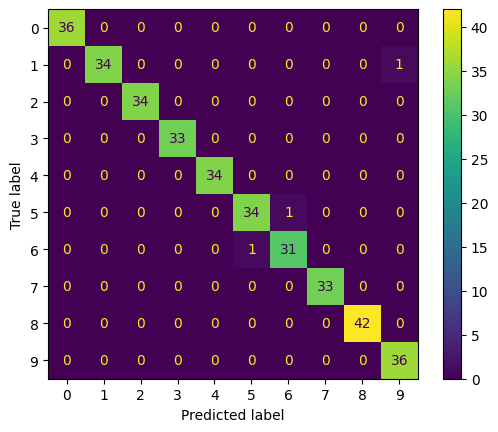

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
y_test
Y = np.argmax(Ypred, axis=1)
cm = confusion_matrix(y_test, Y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
starter_learning_rate = 0.1
end_learning_rate = 0.01
decay_steps = 10000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(0.1,10000,0.001,power=0.5)

In [ ]:
print(max(acc_list)) # 20% labeled data

0.9879364967346191


In [ ]:
print(np.argmax(acc_list)) # 30% labeled data

In [ ]:
print(max(acc_list)) # 40% labeled data

In [ ]:
print(100*max(acc_list)) # 10% labeled data and Xavier

In [ ]:
X = data.drop(['class'],axis=1).values
X1 = X[:350, :]
X1 = np.reshape(X1, (350,1))
X2 = np.random.normal(0,0.01,(300,1))
X3 = X1*X2 + X1

plt.subplot(1,2,4)
plt.plot(X1[:,0], '.')
plt.plot(X3[:,0], '.')
plt.title('Voc')

plt.subplot(2,2,4)
plt.plot(X1[:,1], '.')
plt.plot(X3[:,1], '.')
plt.title('Isc')

plt.subplot(3,2,4)
plt.plot(X1[:,2], '.')
plt.plot(X3[:,2], '.')
plt.title('Vmp')

plt.subplot(4,2,4)
plt.plot(X1[:,3], '.')
plt.plot(X3[:,3], '.')
plt.title('Imp')

plt.subplot(5,2,4)
plt.plot(X1[:,4], '.')
plt.plot(X3[:,4], '.')
plt.title('Pmp')

plt.subplot(6,2,4)
plt.plot(X1[:,5], '.')
plt.plot(X3[:,5], '.')
plt.title('T')

plt.subplot(7,2,4)
plt.plot(X1[:,6], '.')
plt.plot(X3[:,6], '.')
plt.title('G')

In [ ]:
import matplotlib.pyplot as plt
plt.plot(D1)
plt.plot(D2)
plt.plot(C)
plt.plot(G)

plt.legend(["unsupervisedDiscriminator_Xreal","unsupervisedDiscriminator_Xfake","supervisedDiscriminator", "Generator"], loc ="upper right")
